# Running spike sorting on Neuropixel probes
This document covers how to run spike sorting. If you are running this for the first time, please follow the installation instructions below. Note, during installation you will create a new conda environment, kilosort, which must be used to run this notebook.

## Installation
Several pieces of software need to be installed before you can begin.
1. Create a conda environment for Kilosort4 by following the instructions on its [github page](https://github.com/MouseLand/Kilosort). Once the environment is created, we will add support for Jupyter notebooks and Matplotlib. To do this:
    1. In the anaconda terminal, enter the kilosort environment by typing `conda activate kilosort`.
    2. Install Jupyter notebooks by calling `pip install notebook`.
    3. Install Matplotlib by calling `python -m pip install matplotlib`.
2. Go the the [SpikeGLX site](https://billkarsh.github.io/SpikeGLX/) and download CatGT. For a detailed help of the processing options it offers, [see here](https://billkarsh.github.io/SpikeGLX/help/syncEdges/Sync_edges/#catgt-event-extraction). To better understand how it works, you can read the explanation [here](https://billkarsh.github.io/SpikeGLX/help/catgt_tshift/catgt_tshift/)
3. Once CatGT is downloaded, make it callable from the command line. The instructions for doing this on Windows are:
    1. Extract the CatGT-win folder and move it to the *C:\Program Files* directory.
    2. Type 'environment variables' into the search box in the Windows task bar and click the option 'Edit the system environment variables'.
    3. Click the 'Environment Variables...' button at the bottom of the window that pops up.
    4. Under the panel heading 'System variables', click on the line whose Variable name is 'Path' (the line should turn gray), and then press the 'Edit...' button.
    5. In the window that pops up, click the 'New' button. Enter the directory where CatGT was placed (*C:\Program Files\CatGT-win*).
    6. Do the same as steps 4-5 under the panel heading 'User variables for {user id here}'.
    7. Verify CatGT works by opening a terminal (type 'Command Prompt' into the Windows search bar) and entering 'CatGT'. If the environment variable was successfully modified after pressing enter the terminal should return a new command line and in the directory you called CatGT a log file will be created named *CatGT.log* that lists the configuration settings for CatGT.
4. Download *SGLXMetaToCoords.py* from its [github page](https://github.com/jenniferColonell/SGLXMetaToCoords/blob/main/SGLXMetaToCoords.py). Place it on the drive where you intend to place the files for sorting.
5. Download *SpikeGLX_Datafile_Tools* from its [github page](https://github.com/jenniferColonell/SpikeGLX_Datafile_Tools). Place the folder *DemoReadSGLXData* found in the *Python* directory on the drive where you intend to place the files for sorting. For a demonstration of how to use the functions contained in *readSGLX.py* check out this Jupyter notebook for [analog signals](https://github.com/jenniferColonell/SpikeGLX_Datafile_Tools/blob/main/Python/read_SGLX_analog.ipynb) or this one for [digital signals](https://github.com/jenniferColonell/SpikeGLX_Datafile_Tools/blob/main/Python/read_SGLX_digital.ipynb).
6. Make sure this notebook is placed on your spike sorting drive. You can save a new version of it each time you want to 
7. You will need to manually refine the output of Kilosort4. To do that, you can either use our homebrew program [SortaSort2](https://github.com/dbheadley/SortaSort2) or [Phy2](https://github.com/cortex-lab/phy).


## Processing spike data
To run this code, call this notebook from the kilosort conda environment that you created above.

### Common settings
Note that on windows machines I use two slashes ('\\\\') instead of just one ('\\') to separate directories.

In [1]:
# need library to save as json
import os
import re
import subprocess
from pathlib import Path
import numpy as np
from kilosort.io import save_probe
from kilosort.parameters import DEFAULT_SETTINGS
from kilosort.run_kilosort import run_kilosort
import SGLXMetaToCoords as sglx

# set your data directory here, should contain the .ap.bin and .ap.meta files
file_dir = Path('D:\\SortingTest\\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1\\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_imec0\\')

# skip CatGT if already ran
skip_catgt = True

# useful Kilosort settings
config = {'tmin': 0, # start time in seconds
          'tmax': np.inf, # end time in seconds
          'artifact_threshold': np.inf, # threshold for detecting artifacts
          'batch_size': 60000, # number of samples per batch
          'nblocks': 1, # number of blocks to split the data into for drift correction
          'Th_universal': 9, # threshold for detecting spikes used in universal templates
          'Th_learned': 8} # threshold for detecting spikes used in learned templates

### Get files to process

In [2]:
# get the data dir
data_dir = file_dir.parents[1]

# get the meta file in the folder
meta_file = str(list(file_dir.glob('*.ap.meta'))[0])

# get the binary file in the folder
bin_file = str(list(file_dir.glob('*.ap.bin'))[0])

# get the run name
run_name = file_dir.parts[-2]
run_name = re.sub(r'_g\d+$', '', run_name)

# get the gate and trigger numbers
gate_num = re.search(r'_g(\d+)', bin_file).group(1)
trig_num = re.search(r'_t(\d+)', bin_file).group(1)

# get the probe number
probe_num = re.search(r'_imec(\d+)', bin_file).group(1)

# print directory and file names
print('Files directory: {}'.format(file_dir))
print('Meta file: {}'.format(meta_file))
print('Binary file: {}'.format(bin_file))
print('Data directory: {}'.format(data_dir))
print('Run name: {}'.format(run_name))
print('Gate number: {}'.format(gate_num))
print('Trigger number: {}'.format(trig_num))
print('Probe number: {}'.format(probe_num))

Files directory: D:\SortingTest\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_imec0
Meta file: D:\SortingTest\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_imec0\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_t0.imec0.ap.meta
Binary file: D:\SortingTest\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_imec0\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_t0.imec0.ap.bin
Data directory: D:\SortingTest
Run name: 24-04-09_DH12_M1-Shk1_M2-SupraLayer
Gate number: 1
Trigger number: 0
Probe number: 0


### Create probe dictionary
Kilosort4 requires a `.json` file that specifies the locations of the recording sites on the recording probe. It should contain the fields `chanMap`, `xc`, `yx`, `kcoords`, and `n_chan`. When multiple shanks were used, the recording sites are rearranged to all be on the same shank.

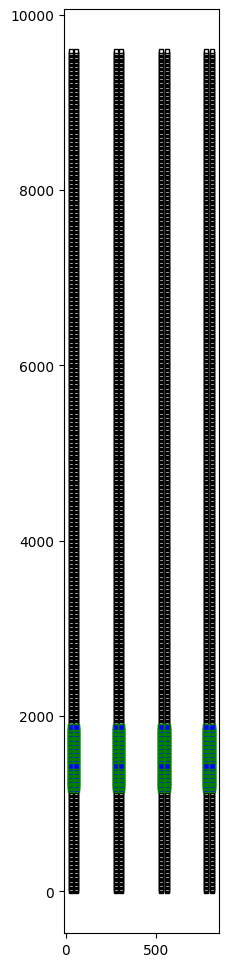

In [3]:
# get the coordinates of the electrodes from the meta file
xc, yc, shanks, kcoords, n_chan = sglx.MetaToCoords(Path(meta_file), outType=0, showPlot=True)
shank_sep = 250
xc = xc + shanks*shank_sep
n_chan = int(n_chan)
chan_map = np.arange(n_chan-1) # exclude last channel which is sync

# if you are using a multishank probe and run into problems with sorting, you can 
# adjust the coordinates of the channels so that each shank is stacked on top of
# the previous one.
""" shank_list = np.unique(shanks)
if len(shank_list) > 1:
    offset = 0
    for shank in shank_list:
        idx = np.where(shanks == shank)[0] # get the indices of the channels in the current shank
        y_min = np.min(yc[idx]) # get the minimum y coordinate of the current shank
        yc[idx] = yc[idx] - y_min + offset # adjust the y coordinates of the current shank
        offset = np.max(yc[idx]) + shank_sep # update the offset for the next shank """


probe =  {'chanMap': chan_map, 'xc': xc, 'yc': yc, 'kcoords': kcoords, 'n_chan': n_chan}

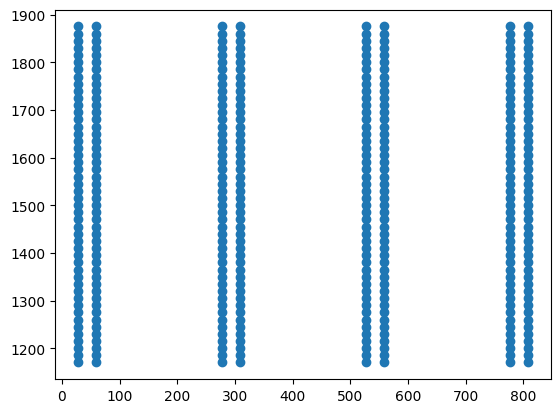

In [4]:
import matplotlib.pyplot as plt
plt.scatter(xc, yc)

In [5]:
probe_file = os.path.join(str(file_dir), 'probe.json')
print('Saving probe file to: {}'.format(probe_file))

save_probe(probe, probe_file)

Saving probe file to: D:\SortingTest\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_imec0\probe.json


### Fix timing, remove common noise, and filter for spikes with CatGT
We use the CatGT function to perform common average referencing (CAR) to clean data intended for spike sorting. Prior to carrying this out, the data must have a correction applied to fix a subtle timing offset. Channels that are multiplexed into the same ADC are sampled at slightly different times, which could cause problems when removing common mode noise that has a fast, large, transients (e.g. electrical stimulation artifacts or head bumps). CatGT corrects for this and then applies CAR. We also apply filtering to isolate unit activity signals.

In [6]:
# test if already ran CatGT
tcat_file = bin_file.replace('_t'+trig_num, '_tcat')

if skip_catgt and Path(tcat_file).exists():
    print('CatGT already ran, skipping...')
else:
    print('Running CatGT...')
    # file and directory names for CatGT
    catgt_files = '-dir={} -run={} -g={} -t={} -prb={}'.format(
        data_dir, run_name, gate_num, trig_num, probe_num)

    # options for CatGT, can be edited as needed
    catgt_opts = '-ap -prb_fld -gbldmx -apfilter=butter,2,300,9000'

    # full command for CatGT
    catgt_cmd = 'CatGT {} {}'.format(catgt_files, catgt_opts)

    # run catGT
    cmd_out = subprocess.run(catgt_cmd, shell=True, capture_output=True)
    print(cmd_out.stdout.decode('utf-8'))

CatGT already ran, skipping...


### Run Kilosort4

In [7]:
# initialize settings with default values
settings = DEFAULT_SETTINGS

# update settings with custom values from config
for key, value in config.items():
    settings[key] = value

# run Kilosort
ops, st, clu, tf, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes \
    = run_kilosort(settings, probe=probe, filename=tcat_file, data_dir=file_dir)

Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
Using GPU for PyTorch computations. Specify `device` to change this.
Preprocessing filters computed in  34.06s; total  34.12s

computing drift
Re-computing universal templates from data.


c:\Users\dbh60\.conda\envs\kilosort\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 8806/8806 [1:33:48<00:00,  1.56it/s]


drift computed in  5984.30s; total  6018.47s

Extracting spikes using templates
Re-computing universal templates from data.
torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
co

  0%|          | 0/8806 [00:00<?, ?it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 1/8806 [00:00<2:03:39,  1.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 2/8806 [00:01<1:44:29,  1.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 3/8806 [00:02<1:37:03,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 4/8806 [00:02<1:34:22,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 5/8806 [00:03<1:33:02,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 6/8806 [00:03<1:32:06,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 7/8806 [00:04<1:32:53,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 8/8806 [00:05<1:31:35,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 9/8806 [00:05<1:31:12,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 10/8806 [00:06<1:30:57,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 11/8806 [00:07<1:30:47,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 12/8806 [00:07<1:30:38,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 13/8806 [00:08<1:30:35,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 14/8806 [00:08<1:30:28,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 15/8806 [00:09<1:30:25,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 16/8806 [00:10<1:30:24,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 17/8806 [00:10<1:30:24,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 18/8806 [00:11<1:31:01,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 19/8806 [00:11<1:31:02,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 20/8806 [00:12<1:30:36,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 21/8806 [00:13<1:31:12,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 22/8806 [00:13<1:30:52,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 23/8806 [00:14<1:30:43,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 24/8806 [00:15<1:29:55,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 25/8806 [00:15<1:30:26,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 26/8806 [00:16<1:25:26,  1.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 27/8806 [00:16<1:27:39,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 28/8806 [00:17<1:29:09,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 29/8806 [00:18<1:29:28,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 30/8806 [00:18<1:29:41,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 31/8806 [00:19<1:29:52,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 32/8806 [00:19<1:29:54,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 33/8806 [00:20<1:30:40,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 34/8806 [00:21<1:30:31,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 35/8806 [00:21<1:30:33,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 36/8806 [00:22<1:30:55,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 37/8806 [00:23<1:31:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 38/8806 [00:23<1:31:00,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 39/8806 [00:24<1:31:33,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 40/8806 [00:24<1:31:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 41/8806 [00:25<1:31:28,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 42/8806 [00:26<1:31:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 43/8806 [00:26<1:31:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 44/8806 [00:27<1:31:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 45/8806 [00:28<1:30:50,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 46/8806 [00:28<1:31:14,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 47/8806 [00:29<1:31:41,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 48/8806 [00:29<1:31:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 49/8806 [00:30<1:31:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 50/8806 [00:31<1:31:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 51/8806 [00:31<1:26:18,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 52/8806 [00:32<1:27:31,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 53/8806 [00:32<1:28:21,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 54/8806 [00:33<1:29:21,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 55/8806 [00:34<1:30:10,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 56/8806 [00:34<1:30:53,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 57/8806 [00:35<1:30:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 58/8806 [00:36<1:30:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 59/8806 [00:36<1:30:57,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 60/8806 [00:37<1:30:40,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 61/8806 [00:37<1:30:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 62/8806 [00:38<1:30:56,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 63/8806 [00:39<1:30:41,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 64/8806 [00:39<1:31:04,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 65/8806 [00:40<1:30:41,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 66/8806 [00:41<1:30:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 67/8806 [00:41<1:30:56,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 68/8806 [00:42<1:30:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 69/8806 [00:42<1:30:58,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 70/8806 [00:43<1:31:18,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 71/8806 [00:44<1:30:57,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 72/8806 [00:44<1:30:32,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 73/8806 [00:45<1:30:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 74/8806 [00:46<1:30:13,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 75/8806 [00:46<1:30:46,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 76/8806 [00:47<1:25:54,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 77/8806 [00:47<1:27:12,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 78/8806 [00:48<1:28:38,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 79/8806 [00:49<1:28:59,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 80/8806 [00:49<1:29:51,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 81/8806 [00:50<1:29:49,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 82/8806 [00:50<1:29:47,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 83/8806 [00:51<1:30:06,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 84/8806 [00:52<1:30:16,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 85/8806 [00:52<1:30:06,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 86/8806 [00:53<1:29:58,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 87/8806 [00:54<1:30:33,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 88/8806 [00:54<1:30:18,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 89/8806 [00:55<1:30:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 90/8806 [00:55<1:30:22,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 91/8806 [00:56<1:30:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 92/8806 [00:57<1:30:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 93/8806 [00:57<1:31:05,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 94/8806 [00:58<1:30:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 95/8806 [00:59<1:30:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 96/8806 [00:59<1:30:47,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 97/8806 [01:00<1:30:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 98/8806 [01:00<1:30:39,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 99/8806 [01:01<1:30:17,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 100/8806 [01:02<1:30:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 101/8806 [01:02<1:25:29,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 102/8806 [01:03<1:27:23,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 103/8806 [01:03<1:27:57,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 104/8806 [01:04<1:28:54,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 105/8806 [01:05<1:29:20,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 106/8806 [01:05<1:29:21,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 107/8806 [01:06<1:30:04,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 108/8806 [01:06<1:29:52,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 109/8806 [01:07<1:29:43,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 110/8806 [01:08<1:31:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 111/8806 [01:08<1:30:30,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 112/8806 [01:09<1:30:54,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 113/8806 [01:10<1:30:27,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 114/8806 [01:10<1:30:15,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 115/8806 [01:11<1:30:32,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 116/8806 [01:11<1:30:12,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 117/8806 [01:12<1:30:34,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 118/8806 [01:13<1:30:32,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 119/8806 [01:13<1:30:30,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 120/8806 [01:14<1:30:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 121/8806 [01:15<1:30:35,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 122/8806 [01:15<1:30:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 123/8806 [01:16<1:29:55,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 124/8806 [01:16<1:30:23,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 125/8806 [01:17<1:30:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 126/8806 [01:18<1:25:26,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 127/8806 [01:18<1:27:18,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 128/8806 [01:19<1:28:33,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 129/8806 [01:20<1:28:46,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 130/8806 [01:20<1:29:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 131/8806 [01:21<1:29:34,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 132/8806 [01:21<1:29:49,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 133/8806 [01:22<1:29:48,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 134/8806 [01:23<1:30:18,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 135/8806 [01:23<1:30:17,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 136/8806 [01:24<1:29:37,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 137/8806 [01:25<1:30:09,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 138/8806 [01:25<1:29:50,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 139/8806 [01:26<1:30:18,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 140/8806 [01:26<1:30:38,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 141/8806 [01:27<1:30:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 142/8806 [01:28<1:30:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 143/8806 [01:28<1:30:04,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 144/8806 [01:29<1:30:28,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 145/8806 [01:30<1:30:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 146/8806 [01:30<1:30:21,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 147/8806 [01:31<1:30:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 148/8806 [01:31<1:30:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 149/8806 [01:32<1:29:58,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 150/8806 [01:33<1:31:09,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 151/8806 [01:33<1:26:00,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 152/8806 [01:34<1:27:39,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 153/8806 [01:34<1:28:06,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 154/8806 [01:35<1:28:19,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 155/8806 [01:36<1:29:07,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 156/8806 [01:36<1:29:11,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 157/8806 [01:37<1:29:45,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 158/8806 [01:38<1:29:26,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 159/8806 [01:38<1:30:01,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 160/8806 [01:39<1:29:37,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 161/8806 [01:39<1:30:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 162/8806 [01:40<1:29:44,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 163/8806 [01:41<1:30:09,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 164/8806 [01:41<1:29:46,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 165/8806 [01:42<1:29:30,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 166/8806 [01:43<1:29:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 167/8806 [01:43<1:29:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 168/8806 [01:44<1:30:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 169/8806 [01:44<1:29:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 170/8806 [01:45<1:29:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 171/8806 [01:46<1:29:50,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 172/8806 [01:46<1:29:30,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 173/8806 [01:47<1:30:36,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 174/8806 [01:48<1:30:06,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 175/8806 [01:48<1:29:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 176/8806 [01:49<1:25:02,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 177/8806 [01:49<1:27:32,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 178/8806 [01:50<1:27:53,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 179/8806 [01:51<1:28:50,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 180/8806 [01:51<1:28:44,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 181/8806 [01:52<1:28:46,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 182/8806 [01:52<1:29:25,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 183/8806 [01:53<1:29:11,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 184/8806 [01:54<1:29:40,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 185/8806 [01:54<1:29:29,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 186/8806 [01:55<1:30:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 187/8806 [01:56<1:29:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 188/8806 [01:56<1:30:12,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 189/8806 [01:57<1:29:45,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 190/8806 [01:57<1:29:25,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 191/8806 [01:58<1:29:46,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 192/8806 [01:59<1:29:26,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 193/8806 [01:59<1:31:15,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 194/8806 [02:00<1:30:26,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 195/8806 [02:01<1:29:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 196/8806 [02:01<1:30:09,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 197/8806 [02:02<1:29:39,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 198/8806 [02:02<1:29:57,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 199/8806 [02:03<1:30:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 200/8806 [02:04<1:29:47,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 201/8806 [02:04<1:25:00,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 202/8806 [02:05<1:26:44,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 203/8806 [02:06<1:27:56,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 204/8806 [02:06<1:28:03,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 205/8806 [02:07<1:28:12,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 206/8806 [02:07<1:28:57,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 207/8806 [02:08<1:28:42,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 208/8806 [02:09<1:29:25,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 209/8806 [02:09<1:29:02,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 210/8806 [02:10<1:28:51,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 211/8806 [02:10<1:29:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 212/8806 [02:11<1:29:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 213/8806 [02:12<1:29:34,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 214/8806 [02:12<1:29:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 215/8806 [02:13<1:28:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 216/8806 [02:14<1:29:27,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 217/8806 [02:14<1:29:47,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 218/8806 [02:15<1:29:18,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 219/8806 [02:15<1:29:01,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 220/8806 [02:16<1:29:27,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 221/8806 [02:17<1:29:40,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 222/8806 [02:17<1:29:21,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 223/8806 [02:18<1:28:59,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 224/8806 [02:19<1:29:27,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 225/8806 [02:19<1:30:27,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 226/8806 [02:20<1:24:48,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 227/8806 [02:20<1:26:31,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 228/8806 [02:21<1:27:03,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 229/8806 [02:22<1:28:07,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 230/8806 [02:22<1:28:05,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 231/8806 [02:23<1:28:46,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 232/8806 [02:24<1:29:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 233/8806 [02:24<1:29:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 234/8806 [02:25<1:29:18,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 235/8806 [02:25<1:29:38,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 236/8806 [02:26<1:29:12,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 237/8806 [02:27<1:29:33,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 238/8806 [02:27<1:29:04,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 239/8806 [02:28<1:29:28,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 240/8806 [02:29<1:29:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 241/8806 [02:29<1:29:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 242/8806 [02:30<1:28:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 243/8806 [02:30<1:28:44,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 244/8806 [02:31<1:29:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 245/8806 [02:32<1:29:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 246/8806 [02:32<1:29:04,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 247/8806 [02:33<1:28:45,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 248/8806 [02:34<1:29:39,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 249/8806 [02:34<1:29:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 250/8806 [02:35<1:28:53,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 251/8806 [02:35<1:24:19,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 252/8806 [02:36<1:26:07,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 253/8806 [02:37<1:26:40,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 254/8806 [02:37<1:27:12,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 255/8806 [02:38<1:27:54,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 256/8806 [02:38<1:27:56,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 257/8806 [02:39<1:28:34,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 258/8806 [02:40<1:28:40,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 259/8806 [02:40<1:27:55,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 260/8806 [02:41<1:28:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 261/8806 [02:42<1:28:28,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 262/8806 [02:42<1:28:57,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 263/8806 [02:43<1:28:41,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 264/8806 [02:43<1:29:00,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 265/8806 [02:44<1:28:44,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 266/8806 [02:45<1:28:28,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 267/8806 [02:45<1:28:57,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 268/8806 [02:46<1:28:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 269/8806 [02:47<1:28:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 270/8806 [02:47<1:28:34,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 271/8806 [02:48<1:28:22,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 272/8806 [02:48<1:28:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 273/8806 [02:49<1:28:34,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 274/8806 [02:50<1:28:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 275/8806 [02:50<1:28:32,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 276/8806 [02:51<1:24:03,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 277/8806 [02:51<1:25:10,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 278/8806 [02:52<1:26:02,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 279/8806 [02:53<1:26:31,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 280/8806 [02:53<1:26:51,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 281/8806 [02:54<1:27:52,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 282/8806 [02:54<1:27:32,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 283/8806 [02:55<1:28:16,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 284/8806 [02:56<1:28:06,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 285/8806 [02:56<1:28:39,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 286/8806 [02:57<1:28:22,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 287/8806 [02:58<1:28:49,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 288/8806 [02:58<1:28:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 289/8806 [02:59<1:28:15,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 290/8806 [02:59<1:28:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 291/8806 [03:00<1:28:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 292/8806 [03:01<1:28:28,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 293/8806 [03:01<1:28:11,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 294/8806 [03:02<1:28:05,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 295/8806 [03:03<1:27:58,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 296/8806 [03:03<1:28:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 297/8806 [03:04<1:28:13,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 298/8806 [03:04<1:28:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 299/8806 [03:05<1:28:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 300/8806 [03:06<1:27:56,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 301/8806 [03:06<1:23:34,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 302/8806 [03:07<1:24:44,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 303/8806 [03:07<1:26:16,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 304/8806 [03:08<1:26:42,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 305/8806 [03:09<1:27:15,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 306/8806 [03:09<1:27:21,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 307/8806 [03:10<1:27:29,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 308/8806 [03:11<1:27:19,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 309/8806 [03:11<1:28:05,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 310/8806 [03:12<1:27:52,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 311/8806 [03:12<1:28:27,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 312/8806 [03:13<1:28:08,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 313/8806 [03:14<1:28:05,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 314/8806 [03:14<1:28:07,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 315/8806 [03:15<1:27:55,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 316/8806 [03:16<1:27:46,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 317/8806 [03:16<1:28:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 318/8806 [03:17<1:28:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 319/8806 [03:17<1:28:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 320/8806 [03:18<1:28:12,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 321/8806 [03:19<1:28:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 322/8806 [03:19<1:27:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 323/8806 [03:20<1:28:25,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 324/8806 [03:21<1:28:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 325/8806 [03:21<1:27:55,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 326/8806 [03:22<1:23:22,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 327/8806 [03:22<1:25:14,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 328/8806 [03:23<1:25:53,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 329/8806 [03:24<1:26:56,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 330/8806 [03:24<1:26:47,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 331/8806 [03:25<1:26:57,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 332/8806 [03:25<1:27:42,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 333/8806 [03:26<1:27:34,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 334/8806 [03:27<1:27:28,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 335/8806 [03:27<1:28:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 336/8806 [03:28<1:27:47,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 337/8806 [03:29<1:27:58,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 338/8806 [03:29<1:27:47,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 339/8806 [03:30<1:27:33,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 340/8806 [03:30<1:28:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 341/8806 [03:31<1:27:46,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 342/8806 [03:32<1:28:17,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 343/8806 [03:32<1:28:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 344/8806 [03:33<1:28:44,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 345/8806 [03:34<1:29:36,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 346/8806 [03:34<1:29:30,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 347/8806 [03:35<1:29:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 348/8806 [03:35<1:28:40,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 349/8806 [03:36<1:29:12,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 350/8806 [03:37<1:29:33,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 351/8806 [03:37<1:24:31,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 352/8806 [03:38<1:26:20,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 353/8806 [03:39<1:26:47,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 354/8806 [03:39<1:27:30,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 355/8806 [03:40<1:28:27,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 356/8806 [03:40<1:28:58,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 357/8806 [03:41<1:29:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 358/8806 [03:42<1:29:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 359/8806 [03:42<1:29:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 360/8806 [03:43<1:29:00,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 361/8806 [03:44<1:29:02,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 362/8806 [03:44<1:29:02,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 363/8806 [03:45<1:29:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 364/8806 [03:46<1:28:22,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 365/8806 [03:46<1:28:34,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 366/8806 [03:47<1:28:43,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 367/8806 [03:47<1:28:49,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 368/8806 [03:48<1:29:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 369/8806 [03:49<1:29:25,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 370/8806 [03:49<1:29:18,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 371/8806 [03:50<1:29:40,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 372/8806 [03:51<1:29:00,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 373/8806 [03:51<1:29:42,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 374/8806 [03:52<1:29:28,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 375/8806 [03:53<1:29:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 376/8806 [03:53<1:24:19,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 377/8806 [03:54<1:25:57,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 378/8806 [03:54<1:26:36,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 379/8806 [03:55<1:27:17,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 380/8806 [03:56<1:28:29,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 381/8806 [03:56<1:29:18,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 382/8806 [03:57<1:29:38,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 383/8806 [03:57<1:28:54,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 384/8806 [03:58<1:28:58,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 385/8806 [03:59<1:29:19,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 386/8806 [03:59<1:28:50,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 387/8806 [04:00<1:28:47,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 388/8806 [04:01<1:29:21,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 389/8806 [04:01<1:28:36,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 390/8806 [04:02<1:29:22,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 391/8806 [04:03<1:29:12,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 392/8806 [04:03<1:29:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 393/8806 [04:04<1:28:59,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 394/8806 [04:04<1:28:55,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 395/8806 [04:05<1:28:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 396/8806 [04:06<1:29:36,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 397/8806 [04:06<1:29:16,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 398/8806 [04:07<1:29:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 399/8806 [04:08<1:28:58,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 400/8806 [04:08<1:28:53,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 401/8806 [04:09<1:23:56,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 402/8806 [04:09<1:25:22,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 403/8806 [04:10<1:27:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 404/8806 [04:11<1:27:32,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 405/8806 [04:11<1:28:04,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 406/8806 [04:12<1:28:02,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 407/8806 [04:13<1:28:14,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 408/8806 [04:13<1:28:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 409/8806 [04:14<1:28:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 410/8806 [04:15<1:28:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 411/8806 [04:15<1:28:55,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 412/8806 [04:16<1:28:16,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 413/8806 [04:16<1:28:49,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 414/8806 [04:17<1:28:20,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 415/8806 [04:18<1:28:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 416/8806 [04:18<1:28:51,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 417/8806 [04:19<1:28:53,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 418/8806 [04:20<1:28:51,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 419/8806 [04:20<1:28:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 420/8806 [04:21<1:28:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 421/8806 [04:22<1:28:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 422/8806 [04:22<1:28:38,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 423/8806 [04:23<1:28:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 424/8806 [04:23<1:29:09,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 425/8806 [04:24<1:28:54,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 426/8806 [04:25<1:23:55,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 427/8806 [04:25<1:25:16,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 428/8806 [04:26<1:26:12,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 429/8806 [04:26<1:26:52,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 430/8806 [04:27<1:27:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 431/8806 [04:28<1:27:38,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 432/8806 [04:28<1:27:59,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 433/8806 [04:29<1:28:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 434/8806 [04:30<1:28:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 435/8806 [04:30<1:28:08,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 436/8806 [04:31<1:28:50,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 437/8806 [04:32<1:28:46,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 438/8806 [04:32<1:27:53,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 439/8806 [04:33<1:28:00,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 440/8806 [04:33<1:28:59,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 441/8806 [04:34<1:28:38,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 442/8806 [04:35<1:28:27,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 443/8806 [04:35<1:29:25,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 444/8806 [04:36<1:28:44,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 445/8806 [04:37<1:29:18,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 446/8806 [04:37<1:28:57,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 447/8806 [04:38<1:28:41,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 448/8806 [04:39<1:28:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 449/8806 [04:39<1:27:54,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 450/8806 [04:40<1:27:59,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 451/8806 [04:40<1:23:51,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 452/8806 [04:41<1:25:14,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 453/8806 [04:42<1:26:01,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 454/8806 [04:42<1:26:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 455/8806 [04:43<1:27:42,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 456/8806 [04:44<1:27:50,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 457/8806 [04:44<1:28:09,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 458/8806 [04:45<1:27:53,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 459/8806 [04:45<1:27:56,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 460/8806 [04:46<1:28:40,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 461/8806 [04:47<1:28:29,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 462/8806 [04:47<1:28:26,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 463/8806 [04:48<1:28:14,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 464/8806 [04:49<1:28:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 465/8806 [04:49<1:28:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 466/8806 [04:50<1:29:20,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 467/8806 [04:51<1:28:56,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 468/8806 [04:51<1:28:39,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 469/8806 [04:52<1:28:51,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 470/8806 [04:52<1:28:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 471/8806 [04:53<1:27:56,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 472/8806 [04:54<1:27:56,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 473/8806 [04:54<1:28:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 474/8806 [04:55<1:27:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 475/8806 [04:56<1:27:47,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 476/8806 [04:56<1:22:57,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 477/8806 [04:57<1:24:30,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 478/8806 [04:57<1:25:26,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 479/8806 [04:58<1:26:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 480/8806 [04:59<1:27:05,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 481/8806 [04:59<1:26:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 482/8806 [05:00<1:27:51,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 483/8806 [05:01<1:27:42,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 484/8806 [05:01<1:27:17,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 485/8806 [05:02<1:27:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 486/8806 [05:02<1:27:55,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 487/8806 [05:03<1:27:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 488/8806 [05:04<1:27:32,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 489/8806 [05:04<1:27:55,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 490/8806 [05:05<1:27:33,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 491/8806 [05:06<1:27:42,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 492/8806 [05:06<1:28:23,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 493/8806 [05:07<1:28:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 494/8806 [05:08<1:29:07,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 495/8806 [05:08<1:28:14,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 496/8806 [05:09<1:28:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 497/8806 [05:09<1:28:22,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 498/8806 [05:10<1:27:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 499/8806 [05:11<1:27:47,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 500/8806 [05:11<1:28:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 501/8806 [05:12<1:23:22,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 502/8806 [05:13<1:24:38,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 503/8806 [05:13<1:25:39,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 504/8806 [05:14<1:26:07,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 505/8806 [05:14<1:26:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 506/8806 [05:15<1:27:29,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 507/8806 [05:16<1:26:52,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 508/8806 [05:16<1:27:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 509/8806 [05:17<1:27:33,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 510/8806 [05:18<1:26:54,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 511/8806 [05:18<1:26:30,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 512/8806 [05:19<1:26:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 513/8806 [05:19<1:26:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 514/8806 [05:20<1:26:04,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 515/8806 [05:21<1:25:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 516/8806 [05:21<1:26:23,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 517/8806 [05:22<1:25:48,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 518/8806 [05:23<1:26:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 519/8806 [05:23<1:26:41,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 520/8806 [05:24<1:27:04,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 521/8806 [05:24<1:27:07,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 522/8806 [05:25<1:26:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 523/8806 [05:26<1:26:41,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 524/8806 [05:26<1:26:14,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 525/8806 [05:27<1:26:01,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 526/8806 [05:27<1:21:39,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 527/8806 [05:28<1:23:08,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 528/8806 [05:29<1:23:43,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 529/8806 [05:29<1:25:25,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 530/8806 [05:30<1:25:25,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 531/8806 [05:31<1:25:18,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 532/8806 [05:31<1:25:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 533/8806 [05:32<1:25:44,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 534/8806 [05:33<1:26:51,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 535/8806 [05:33<1:27:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 536/8806 [05:34<1:27:23,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 537/8806 [05:34<1:27:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 538/8806 [05:35<1:26:12,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 539/8806 [05:36<1:26:41,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 540/8806 [05:36<1:26:04,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 541/8806 [05:37<1:25:47,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 542/8806 [05:38<1:26:14,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 543/8806 [05:38<1:25:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 544/8806 [05:39<1:25:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 545/8806 [05:39<1:25:45,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 546/8806 [05:40<1:25:28,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 547/8806 [05:41<1:25:20,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 548/8806 [05:41<1:25:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 549/8806 [05:42<1:25:44,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 550/8806 [05:42<1:25:50,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 551/8806 [05:43<1:20:57,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 552/8806 [05:44<1:23:16,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 553/8806 [05:44<1:23:46,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 554/8806 [05:45<1:24:18,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 555/8806 [05:46<1:25:01,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 556/8806 [05:46<1:24:56,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 557/8806 [05:47<1:25:34,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 558/8806 [05:47<1:25:51,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 559/8806 [05:48<1:25:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 560/8806 [05:49<1:25:22,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 561/8806 [05:49<1:25:18,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 562/8806 [05:50<1:26:00,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 563/8806 [05:50<1:25:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 564/8806 [05:51<1:25:45,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 565/8806 [05:52<1:25:30,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 566/8806 [05:52<1:25:17,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 567/8806 [05:53<1:25:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 568/8806 [05:54<1:25:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 569/8806 [05:54<1:25:34,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 570/8806 [05:55<1:25:58,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 571/8806 [05:55<1:25:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 572/8806 [05:56<1:25:25,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 573/8806 [05:57<1:25:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 574/8806 [05:57<1:25:19,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 575/8806 [05:58<1:25:45,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 576/8806 [05:58<1:20:39,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 577/8806 [05:59<1:22:34,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 578/8806 [06:00<1:23:15,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 579/8806 [06:00<1:24:02,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 580/8806 [06:01<1:24:29,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 581/8806 [06:02<1:24:22,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 582/8806 [06:02<1:24:21,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 583/8806 [06:03<1:25:08,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 584/8806 [06:03<1:25:01,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 585/8806 [06:04<1:25:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 586/8806 [06:05<1:24:59,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 587/8806 [06:06<1:52:27,  1.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 588/8806 [06:07<1:45:24,  1.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 589/8806 [06:07<1:40:27,  1.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 590/8806 [06:08<1:36:19,  1.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 591/8806 [06:09<1:34:32,  1.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 592/8806 [06:09<1:31:04,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 593/8806 [06:10<1:29:07,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 594/8806 [06:10<1:28:07,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 595/8806 [06:11<1:27:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 596/8806 [06:12<1:26:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 597/8806 [06:12<1:25:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 598/8806 [06:13<1:25:12,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 599/8806 [06:14<1:25:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 600/8806 [06:14<1:25:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 601/8806 [06:15<1:20:16,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 602/8806 [06:15<1:22:12,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 603/8806 [06:16<1:22:35,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 604/8806 [06:17<1:23:46,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 605/8806 [06:17<1:24:02,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 606/8806 [06:18<1:24:11,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 607/8806 [06:18<1:24:16,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 608/8806 [06:19<1:24:43,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 609/8806 [06:20<1:24:42,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 610/8806 [06:20<1:25:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 611/8806 [06:21<1:25:12,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 612/8806 [06:22<1:24:42,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 613/8806 [06:22<1:25:14,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 614/8806 [06:23<1:24:39,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 615/8806 [06:23<1:25:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 616/8806 [06:24<1:24:55,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 617/8806 [06:25<1:24:46,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 618/8806 [06:25<1:25:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 619/8806 [06:26<1:25:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 620/8806 [06:27<1:24:28,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 621/8806 [06:27<1:25:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 622/8806 [06:28<1:24:50,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 623/8806 [06:28<1:25:21,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 624/8806 [06:29<1:25:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 625/8806 [06:30<1:24:39,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 626/8806 [06:30<1:20:17,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 627/8806 [06:31<1:21:30,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 628/8806 [06:31<1:22:24,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 629/8806 [06:32<1:23:31,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 630/8806 [06:33<1:23:36,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 631/8806 [06:33<1:24:51,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 632/8806 [06:34<1:25:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 633/8806 [06:35<1:25:09,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 634/8806 [06:35<1:25:23,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 635/8806 [06:36<1:25:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 636/8806 [06:36<1:25:23,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 637/8806 [06:37<1:25:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 638/8806 [06:38<1:24:27,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 639/8806 [06:38<1:25:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 640/8806 [06:39<1:24:46,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 641/8806 [06:40<1:24:58,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 642/8806 [06:40<1:24:40,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 643/8806 [06:41<1:24:29,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 644/8806 [06:41<1:25:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 645/8806 [06:42<1:24:43,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 646/8806 [06:43<1:24:56,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 647/8806 [06:43<1:24:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 648/8806 [06:44<1:24:25,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 649/8806 [06:45<1:24:57,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 650/8806 [06:45<1:24:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 651/8806 [06:46<1:20:08,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 652/8806 [06:46<1:21:17,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 653/8806 [06:47<1:22:10,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 654/8806 [06:48<1:23:20,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 655/8806 [06:48<1:23:25,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 656/8806 [06:49<1:24:02,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 657/8806 [06:49<1:23:56,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 658/8806 [06:50<1:23:55,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 659/8806 [06:51<1:24:30,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 660/8806 [06:51<1:24:34,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 661/8806 [06:52<1:24:51,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 662/8806 [06:53<1:24:57,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 663/8806 [06:53<1:24:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 664/8806 [06:54<1:24:22,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 665/8806 [06:54<1:24:17,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 666/8806 [06:55<1:24:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 667/8806 [06:56<1:24:18,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 668/8806 [06:56<1:24:06,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 669/8806 [06:57<1:24:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 670/8806 [06:57<1:24:28,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 671/8806 [06:58<1:24:53,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 672/8806 [06:59<1:24:19,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 673/8806 [06:59<1:24:41,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 674/8806 [07:00<1:24:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 675/8806 [07:01<1:24:20,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 676/8806 [07:01<1:20:42,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 677/8806 [07:02<1:22:13,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 678/8806 [07:02<1:23:21,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 679/8806 [07:03<1:24:00,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 680/8806 [07:04<1:24:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 681/8806 [07:04<1:24:53,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 682/8806 [07:05<1:25:08,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 683/8806 [07:06<1:25:18,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 684/8806 [07:06<1:25:29,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 685/8806 [07:07<1:25:33,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 686/8806 [07:07<1:25:32,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 687/8806 [07:08<1:25:34,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 688/8806 [07:09<1:25:36,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 689/8806 [07:09<1:25:38,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 690/8806 [07:10<1:25:36,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 691/8806 [07:11<1:25:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 692/8806 [07:11<1:25:42,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 693/8806 [07:12<1:25:39,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 694/8806 [07:13<1:25:38,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 695/8806 [07:13<1:25:43,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 696/8806 [07:14<1:25:30,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 697/8806 [07:14<1:25:31,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 698/8806 [07:15<1:25:43,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 699/8806 [07:16<1:25:29,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 700/8806 [07:16<1:25:29,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 701/8806 [07:17<1:21:27,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 702/8806 [07:18<1:22:44,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 703/8806 [07:18<1:23:30,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 704/8806 [07:19<1:24:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 705/8806 [07:19<1:24:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 706/8806 [07:20<1:24:45,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 707/8806 [07:21<1:25:12,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 708/8806 [07:21<1:25:02,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 709/8806 [07:22<1:25:09,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 710/8806 [07:23<1:25:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 711/8806 [07:23<1:25:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 712/8806 [07:24<1:25:13,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 713/8806 [07:24<1:25:39,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 714/8806 [07:25<1:25:11,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 715/8806 [07:26<1:25:15,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 716/8806 [07:26<1:25:41,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 717/8806 [07:27<1:25:11,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 718/8806 [07:28<1:25:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 719/8806 [07:28<1:25:55,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 720/8806 [07:29<1:25:43,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 721/8806 [07:30<1:24:56,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 722/8806 [07:30<1:25:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 723/8806 [07:31<1:25:07,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 724/8806 [07:31<1:25:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 725/8806 [07:32<1:25:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 726/8806 [07:33<1:21:05,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 727/8806 [07:33<1:22:14,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 728/8806 [07:34<1:23:07,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 729/8806 [07:35<1:24:23,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 730/8806 [07:35<1:24:00,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 731/8806 [07:36<1:24:28,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 732/8806 [07:36<1:24:35,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 733/8806 [07:37<1:24:45,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 734/8806 [07:38<1:24:57,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 735/8806 [07:38<1:24:57,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 736/8806 [07:39<1:25:01,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 737/8806 [07:40<1:25:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 738/8806 [07:40<1:25:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 739/8806 [07:41<1:25:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 740/8806 [07:41<1:25:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 741/8806 [07:42<1:25:42,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 742/8806 [07:43<1:25:14,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 743/8806 [07:43<1:25:16,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 744/8806 [07:44<1:25:29,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 745/8806 [07:45<1:25:00,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 746/8806 [07:45<1:25:09,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 747/8806 [07:46<1:25:22,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 748/8806 [07:47<1:24:56,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 749/8806 [07:47<1:25:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 750/8806 [07:48<1:24:56,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 751/8806 [07:48<1:20:11,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 752/8806 [07:49<1:21:37,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 753/8806 [07:50<1:22:38,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 754/8806 [07:50<1:23:20,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 755/8806 [07:51<1:23:49,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 756/8806 [07:51<1:24:09,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 757/8806 [07:52<1:24:24,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 758/8806 [07:53<1:25:13,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 759/8806 [07:53<1:25:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 760/8806 [07:54<1:24:24,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 761/8806 [07:55<1:24:32,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 762/8806 [07:55<1:24:42,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 763/8806 [07:56<1:24:41,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 764/8806 [07:57<1:25:51,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 765/8806 [07:57<1:25:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 766/8806 [07:58<1:24:53,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 767/8806 [07:58<1:24:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 768/8806 [07:59<1:25:12,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 769/8806 [08:00<1:24:47,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 770/8806 [08:00<1:24:43,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 771/8806 [08:01<1:25:29,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 772/8806 [08:02<1:25:12,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 773/8806 [08:02<1:25:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 774/8806 [08:03<1:24:58,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 775/8806 [08:04<1:25:03,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 776/8806 [08:04<1:20:07,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 777/8806 [08:05<1:22:01,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 778/8806 [08:05<1:22:18,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 779/8806 [08:06<1:23:01,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 780/8806 [08:07<1:23:55,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 781/8806 [08:07<1:23:45,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 782/8806 [08:08<1:24:05,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 783/8806 [08:09<1:24:17,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 784/8806 [08:09<1:24:22,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 785/8806 [08:10<1:25:07,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 786/8806 [08:10<1:24:54,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 787/8806 [08:11<1:24:49,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 788/8806 [08:12<1:24:51,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 789/8806 [08:12<1:24:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 790/8806 [08:13<1:24:39,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 791/8806 [08:14<1:24:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 792/8806 [08:14<1:25:15,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 793/8806 [08:15<1:24:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 794/8806 [08:15<1:24:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 795/8806 [08:16<1:24:27,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 796/8806 [08:17<1:24:28,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 797/8806 [08:17<1:25:22,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 798/8806 [08:18<1:24:53,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 799/8806 [08:19<1:24:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 800/8806 [08:19<1:24:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 801/8806 [08:20<1:19:55,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 802/8806 [08:20<1:21:21,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 803/8806 [08:21<1:22:12,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 804/8806 [08:22<1:22:46,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 805/8806 [08:22<1:22:42,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 806/8806 [08:23<1:23:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 807/8806 [08:24<1:24:14,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 808/8806 [08:24<1:24:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 809/8806 [08:25<1:24:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 810/8806 [08:26<1:25:03,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 811/8806 [08:26<1:24:46,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 812/8806 [08:27<1:24:57,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 813/8806 [08:27<1:24:27,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 814/8806 [08:28<1:24:26,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 815/8806 [08:29<1:23:43,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 816/8806 [08:29<1:23:54,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 817/8806 [08:30<1:24:01,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 818/8806 [08:31<1:24:43,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 819/8806 [08:31<1:24:37,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 820/8806 [08:32<1:24:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 821/8806 [08:33<1:25:04,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 822/8806 [08:33<1:24:14,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 823/8806 [08:34<1:24:50,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 824/8806 [08:34<1:24:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 825/8806 [08:35<1:24:32,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 826/8806 [08:36<1:19:47,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 827/8806 [08:36<1:21:32,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 828/8806 [08:37<1:21:54,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 829/8806 [08:37<1:22:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 830/8806 [08:38<1:23:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 831/8806 [08:39<1:22:41,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 832/8806 [08:39<1:23:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 833/8806 [08:40<1:23:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 834/8806 [08:41<1:23:38,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 835/8806 [08:41<1:23:46,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 836/8806 [08:42<1:24:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 837/8806 [08:43<1:25:01,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 838/8806 [08:43<1:24:51,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 839/8806 [08:44<1:24:32,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 840/8806 [08:44<1:24:28,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 841/8806 [08:45<1:24:16,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 842/8806 [08:46<1:24:12,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 843/8806 [08:46<1:23:33,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 844/8806 [08:47<1:24:19,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 845/8806 [08:48<1:23:21,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 846/8806 [08:48<1:23:34,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 847/8806 [08:49<1:23:04,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 848/8806 [08:49<1:23:18,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 849/8806 [08:50<1:22:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 850/8806 [08:51<1:22:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 851/8806 [08:51<1:18:10,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 852/8806 [08:52<1:19:54,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 853/8806 [08:52<1:20:35,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 854/8806 [08:53<1:21:24,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 855/8806 [08:54<1:21:32,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 856/8806 [08:54<1:21:43,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 857/8806 [08:55<1:22:24,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 858/8806 [08:56<1:22:51,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 859/8806 [08:56<1:22:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 860/8806 [08:57<1:22:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 861/8806 [08:57<1:22:20,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 862/8806 [08:58<1:22:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 863/8806 [08:59<1:22:57,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 864/8806 [08:59<1:22:35,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 865/8806 [09:00<1:22:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 866/8806 [09:01<1:22:13,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 867/8806 [09:01<1:22:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 868/8806 [09:02<1:22:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 869/8806 [09:02<1:22:41,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 870/8806 [09:03<1:22:15,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 871/8806 [09:04<1:22:41,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 872/8806 [09:04<1:22:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 873/8806 [09:05<1:22:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 874/8806 [09:06<1:22:22,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 875/8806 [09:06<1:22:41,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 876/8806 [09:07<1:18:11,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 877/8806 [09:07<1:19:28,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 878/8806 [09:08<1:19:59,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 879/8806 [09:09<1:21:08,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 880/8806 [09:09<1:21:44,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 881/8806 [09:10<1:21:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 882/8806 [09:11<1:22:16,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 883/8806 [09:11<1:22:01,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 884/8806 [09:12<1:21:50,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 885/8806 [09:12<1:21:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 886/8806 [09:13<1:22:11,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 887/8806 [09:14<1:22:34,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 888/8806 [09:14<1:22:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 889/8806 [09:15<1:22:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 890/8806 [09:15<1:21:48,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 891/8806 [09:16<1:22:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 892/8806 [09:17<1:21:57,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 893/8806 [09:17<1:21:49,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 894/8806 [09:18<1:22:17,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 895/8806 [09:19<1:22:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 896/8806 [09:19<1:21:46,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 897/8806 [09:20<1:22:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 898/8806 [09:20<1:22:09,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 899/8806 [09:21<1:21:39,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 900/8806 [09:22<1:21:37,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 901/8806 [09:22<1:17:24,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 902/8806 [09:23<1:19:25,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 903/8806 [09:23<1:20:15,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 904/8806 [09:24<1:20:44,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 905/8806 [09:25<1:20:57,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 906/8806 [09:25<1:21:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 907/8806 [09:26<1:21:28,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 908/8806 [09:27<1:22:01,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 909/8806 [09:27<1:21:53,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 910/8806 [09:28<1:22:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 911/8806 [09:28<1:21:49,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 912/8806 [09:29<1:21:45,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 913/8806 [09:30<1:22:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 914/8806 [09:30<1:21:49,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 915/8806 [09:31<1:21:41,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 916/8806 [09:32<1:21:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 917/8806 [09:32<1:21:57,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 918/8806 [09:33<1:21:30,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 919/8806 [09:33<1:22:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 920/8806 [09:34<1:22:46,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 921/8806 [09:35<1:21:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 922/8806 [09:35<1:22:27,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 923/8806 [09:36<1:21:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 924/8806 [09:37<1:22:11,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 925/8806 [09:37<1:21:50,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 926/8806 [09:38<1:17:00,  1.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 927/8806 [09:38<1:18:47,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 928/8806 [09:39<1:19:30,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 929/8806 [09:40<1:19:57,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 930/8806 [09:40<1:20:59,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 931/8806 [09:41<1:20:46,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 932/8806 [09:41<1:21:28,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 933/8806 [09:42<1:21:19,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 934/8806 [09:43<1:21:16,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 935/8806 [09:43<1:21:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 936/8806 [09:44<1:22:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 937/8806 [09:45<1:21:44,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 938/8806 [09:45<1:21:31,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 939/8806 [09:46<1:21:29,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 940/8806 [09:46<1:21:50,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 941/8806 [09:47<1:21:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 942/8806 [09:48<1:21:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 943/8806 [09:48<1:21:39,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 944/8806 [09:49<1:21:27,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 945/8806 [09:50<1:21:14,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 946/8806 [09:50<1:21:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 947/8806 [09:51<1:22:07,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 948/8806 [09:51<1:21:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 949/8806 [09:52<1:21:57,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 950/8806 [09:53<1:21:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 951/8806 [09:53<1:16:59,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 952/8806 [09:54<1:18:33,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 953/8806 [09:54<1:19:18,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 954/8806 [09:55<1:20:21,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 955/8806 [09:56<1:20:16,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 956/8806 [09:56<1:20:27,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 957/8806 [09:57<1:21:15,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 958/8806 [09:58<1:21:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 959/8806 [09:58<1:21:26,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 960/8806 [09:59<1:21:12,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 961/8806 [09:59<1:21:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 962/8806 [10:00<1:21:25,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 963/8806 [10:01<1:21:14,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 964/8806 [10:01<1:21:34,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 965/8806 [10:02<1:21:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 966/8806 [10:03<1:21:35,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 967/8806 [10:03<1:22:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 968/8806 [10:04<1:21:32,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 969/8806 [10:04<1:21:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 970/8806 [10:05<1:21:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 971/8806 [10:06<1:21:19,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 972/8806 [10:06<1:21:39,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 973/8806 [10:07<1:21:18,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 974/8806 [10:08<1:21:44,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 975/8806 [10:08<1:21:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 976/8806 [10:09<1:17:07,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 977/8806 [10:09<1:18:12,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 978/8806 [10:10<1:18:54,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 979/8806 [10:11<1:20:06,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 980/8806 [10:11<1:20:03,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 981/8806 [10:12<1:20:11,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 982/8806 [10:12<1:21:00,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 983/8806 [10:13<1:20:37,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 984/8806 [10:14<1:21:13,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 985/8806 [10:14<1:21:01,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 986/8806 [10:15<1:20:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 987/8806 [10:16<1:21:11,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 988/8806 [10:16<1:21:17,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 989/8806 [10:17<1:20:50,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 990/8806 [10:17<1:20:57,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 991/8806 [10:18<1:20:57,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 992/8806 [10:19<1:21:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 993/8806 [10:19<1:21:00,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 994/8806 [10:20<1:20:49,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 995/8806 [10:20<1:20:41,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 996/8806 [10:21<1:21:09,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 997/8806 [10:22<1:20:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 998/8806 [10:22<1:21:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 999/8806 [10:23<1:21:35,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1000/8806 [10:24<1:21:12,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1001/8806 [10:24<1:16:34,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1002/8806 [10:25<1:18:39,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1003/8806 [10:25<1:19:12,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1004/8806 [10:26<1:19:31,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1005/8806 [10:27<1:20:18,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1006/8806 [10:27<1:20:30,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1007/8806 [10:28<1:20:12,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1008/8806 [10:28<1:20:20,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1009/8806 [10:29<1:20:42,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1010/8806 [10:30<1:20:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1011/8806 [10:30<1:20:48,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1012/8806 [10:31<1:20:51,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1013/8806 [10:32<1:20:34,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1014/8806 [10:32<1:20:25,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1015/8806 [10:33<1:20:22,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1016/8806 [10:33<1:21:00,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1017/8806 [10:34<1:21:12,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1018/8806 [10:35<1:21:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1019/8806 [10:35<1:21:11,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1020/8806 [10:36<1:20:42,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1021/8806 [10:37<1:21:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1022/8806 [10:37<1:21:32,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1023/8806 [10:38<1:20:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1024/8806 [10:38<1:20:46,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1025/8806 [10:39<1:21:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1026/8806 [10:40<1:16:20,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1027/8806 [10:40<1:18:00,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1028/8806 [10:41<1:19:02,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1029/8806 [10:41<1:19:19,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1030/8806 [10:42<1:20:30,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1031/8806 [10:43<1:20:00,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1032/8806 [10:43<1:20:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1033/8806 [10:44<1:20:32,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1034/8806 [10:45<1:20:14,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1035/8806 [10:45<1:20:39,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1036/8806 [10:46<1:20:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1037/8806 [10:46<1:20:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1038/8806 [10:47<1:21:11,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1039/8806 [10:48<1:20:50,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1040/8806 [10:48<1:20:27,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1041/8806 [10:49<1:20:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1042/8806 [10:50<1:20:40,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1043/8806 [10:50<1:20:30,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1044/8806 [10:51<1:20:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1045/8806 [10:51<1:20:26,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1046/8806 [10:52<1:20:58,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1047/8806 [10:53<1:21:14,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1048/8806 [10:53<1:20:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1049/8806 [10:54<1:21:20,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1050/8806 [10:55<1:21:12,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1051/8806 [10:55<1:16:57,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1052/8806 [10:56<1:18:23,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1053/8806 [10:56<1:19:26,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1054/8806 [10:57<1:19:22,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1055/8806 [10:58<1:20:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1056/8806 [10:58<1:20:25,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1057/8806 [10:59<1:20:19,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1058/8806 [11:00<1:20:00,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1059/8806 [11:00<1:19:51,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1060/8806 [11:01<1:20:30,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1061/8806 [11:01<1:20:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1062/8806 [11:02<1:20:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1063/8806 [11:03<1:20:17,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1064/8806 [11:03<1:20:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1065/8806 [11:04<1:20:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1066/8806 [11:04<1:20:12,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1067/8806 [11:05<1:19:52,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1068/8806 [11:06<1:20:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1069/8806 [11:06<1:20:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1070/8806 [11:07<1:20:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1071/8806 [11:08<1:20:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1072/8806 [11:08<1:20:27,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1073/8806 [11:09<1:20:49,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1074/8806 [11:10<1:21:05,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1075/8806 [11:10<1:21:02,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1076/8806 [11:11<1:16:43,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1077/8806 [11:11<1:17:31,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1078/8806 [11:12<1:18:30,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1079/8806 [11:13<1:18:58,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1080/8806 [11:13<1:19:03,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1081/8806 [11:14<1:19:13,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1082/8806 [11:14<1:19:20,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1083/8806 [11:15<1:20:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1084/8806 [11:16<1:19:37,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1085/8806 [11:16<1:19:42,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1086/8806 [11:17<1:20:44,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1087/8806 [11:18<1:20:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1088/8806 [11:18<1:20:49,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1089/8806 [11:19<1:20:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1090/8806 [11:19<1:19:58,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1091/8806 [11:20<1:20:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1092/8806 [11:21<1:19:57,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1093/8806 [11:21<1:21:04,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1094/8806 [11:22<1:20:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1095/8806 [11:23<1:20:18,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1096/8806 [11:23<1:20:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1097/8806 [11:24<1:20:06,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1098/8806 [11:24<1:19:48,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1099/8806 [11:25<1:20:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1100/8806 [11:26<1:19:56,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1101/8806 [11:26<1:15:24,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1102/8806 [11:27<1:17:10,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1103/8806 [11:27<1:17:45,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1104/8806 [11:28<1:18:33,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1105/8806 [11:29<1:18:54,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1106/8806 [11:29<1:19:31,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1107/8806 [11:30<1:19:33,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1108/8806 [11:31<1:19:51,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1109/8806 [11:31<1:19:53,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1110/8806 [11:32<1:19:27,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1111/8806 [11:32<1:19:19,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1112/8806 [11:33<1:19:53,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1113/8806 [11:34<1:20:52,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1114/8806 [11:34<1:20:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1115/8806 [11:35<1:20:01,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1116/8806 [11:36<1:20:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1117/8806 [11:36<1:20:04,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1118/8806 [11:37<1:20:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1119/8806 [11:37<1:20:01,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1120/8806 [11:38<1:19:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1121/8806 [11:39<1:19:53,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1122/8806 [11:39<1:19:40,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1123/8806 [11:40<1:20:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1124/8806 [11:41<1:20:22,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1125/8806 [11:41<1:19:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1126/8806 [11:42<1:15:57,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1127/8806 [11:42<1:16:49,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1128/8806 [11:43<1:18:10,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1129/8806 [11:44<1:18:10,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1130/8806 [11:44<1:19:04,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1131/8806 [11:45<1:19:34,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1132/8806 [11:45<1:19:30,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1133/8806 [11:46<1:19:07,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1134/8806 [11:47<1:19:39,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1135/8806 [11:47<1:19:38,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1136/8806 [11:48<1:19:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1137/8806 [11:49<1:19:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1138/8806 [11:49<1:19:15,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1139/8806 [11:50<1:19:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1140/8806 [11:50<1:20:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1141/8806 [11:51<1:19:49,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1142/8806 [11:52<1:19:21,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1143/8806 [11:52<1:19:49,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1144/8806 [11:53<1:19:28,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1145/8806 [11:53<1:19:27,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1146/8806 [11:54<1:18:58,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1147/8806 [11:55<1:19:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1148/8806 [11:55<1:19:19,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1149/8806 [11:56<1:19:13,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1150/8806 [11:57<1:19:45,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1151/8806 [11:57<1:15:57,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1152/8806 [11:58<1:16:56,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1153/8806 [11:58<1:17:57,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1154/8806 [11:59<1:18:49,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1155/8806 [12:00<1:19:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1156/8806 [12:00<1:19:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1157/8806 [12:01<1:18:59,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1158/8806 [12:02<1:18:54,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1159/8806 [12:02<1:19:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1160/8806 [12:03<1:19:18,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1161/8806 [12:03<1:18:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1162/8806 [12:04<1:20:02,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1163/8806 [12:05<1:19:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1164/8806 [12:05<1:19:20,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1165/8806 [12:06<1:19:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1166/8806 [12:07<1:19:51,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1167/8806 [12:07<1:19:30,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1168/8806 [12:08<1:19:40,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1169/8806 [12:08<1:18:51,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1170/8806 [12:09<1:19:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1171/8806 [12:10<1:19:02,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1172/8806 [12:10<1:19:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1173/8806 [12:11<1:19:45,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1174/8806 [12:12<1:19:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1175/8806 [12:12<1:19:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1176/8806 [12:13<1:15:13,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1177/8806 [12:13<1:16:35,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1178/8806 [12:14<1:17:12,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1179/8806 [12:15<1:17:41,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1180/8806 [12:15<1:17:48,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1181/8806 [12:16<1:17:57,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1182/8806 [12:16<1:18:46,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1183/8806 [12:17<1:18:39,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1184/8806 [12:18<1:19:44,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1185/8806 [12:18<1:19:44,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1186/8806 [12:19<1:19:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1187/8806 [12:20<1:20:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1188/8806 [12:20<1:20:38,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1189/8806 [12:21<1:20:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1190/8806 [12:21<1:20:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1191/8806 [12:22<1:20:36,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1192/8806 [12:23<1:20:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1193/8806 [12:23<1:20:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1194/8806 [12:24<1:20:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1195/8806 [12:26<2:12:56,  1.05s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1196/8806 [12:27<1:58:15,  1.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1197/8806 [12:27<1:47:39,  1.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1198/8806 [12:28<1:40:24,  1.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1199/8806 [12:29<1:34:39,  1.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1200/8806 [12:29<1:30:47,  1.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1201/8806 [12:30<1:23:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1202/8806 [12:30<1:21:49,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1203/8806 [12:31<1:21:20,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1204/8806 [12:32<1:21:13,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1205/8806 [12:32<1:20:42,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1206/8806 [12:33<1:20:32,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1207/8806 [12:34<1:20:30,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1208/8806 [12:34<1:20:20,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1209/8806 [12:35<1:19:39,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1210/8806 [12:35<1:19:48,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1211/8806 [12:36<1:19:54,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1212/8806 [12:37<1:19:58,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1213/8806 [12:37<1:20:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1214/8806 [12:38<1:20:01,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1215/8806 [12:39<1:20:02,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1216/8806 [12:39<1:20:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1217/8806 [12:40<1:20:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1218/8806 [12:41<1:20:07,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1219/8806 [12:41<1:20:02,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1220/8806 [12:42<1:20:02,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1221/8806 [12:42<1:20:02,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1222/8806 [12:43<1:20:37,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1223/8806 [12:44<1:20:28,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1224/8806 [12:44<1:20:20,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1225/8806 [12:45<1:19:36,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1226/8806 [12:45<1:15:56,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1227/8806 [12:46<1:17:47,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1228/8806 [12:47<1:18:26,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1229/8806 [12:47<1:18:14,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1230/8806 [12:48<1:18:45,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1231/8806 [12:49<1:19:43,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1232/8806 [12:49<1:19:49,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1233/8806 [12:50<1:19:48,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1234/8806 [12:51<1:19:13,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1235/8806 [12:51<1:20:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1236/8806 [12:52<1:20:00,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1237/8806 [12:52<1:20:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1238/8806 [12:53<1:19:51,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1239/8806 [12:54<1:19:51,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1240/8806 [12:54<1:20:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1241/8806 [12:55<1:20:24,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1242/8806 [12:56<1:20:13,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1243/8806 [12:56<1:20:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1244/8806 [12:57<1:20:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1245/8806 [12:58<1:19:54,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1246/8806 [12:58<1:19:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1247/8806 [12:59<1:19:57,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1248/8806 [12:59<1:19:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1249/8806 [13:00<1:20:23,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1250/8806 [13:01<1:19:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1251/8806 [13:01<1:15:47,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1252/8806 [13:02<1:16:56,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1253/8806 [13:03<1:17:44,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1254/8806 [13:03<1:18:22,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1255/8806 [13:04<1:18:45,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1256/8806 [13:04<1:18:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1257/8806 [13:05<1:19:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1258/8806 [13:06<1:19:28,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1259/8806 [13:06<1:19:49,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1260/8806 [13:07<1:19:57,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1261/8806 [13:08<1:19:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1262/8806 [13:08<1:19:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1263/8806 [13:09<1:19:58,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1264/8806 [13:09<1:19:53,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1265/8806 [13:10<1:20:25,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1266/8806 [13:11<1:20:14,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1267/8806 [13:11<1:20:36,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1268/8806 [13:12<1:20:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1269/8806 [13:13<1:20:27,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1270/8806 [13:13<1:20:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1271/8806 [13:14<1:20:36,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1272/8806 [13:15<1:20:16,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1273/8806 [13:15<1:20:24,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1274/8806 [13:16<1:19:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1275/8806 [13:17<1:19:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1276/8806 [13:17<1:15:12,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1277/8806 [13:18<1:16:29,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1278/8806 [13:18<1:17:22,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1279/8806 [13:19<1:17:58,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1280/8806 [13:20<1:18:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1281/8806 [13:20<1:18:42,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1282/8806 [13:21<1:19:31,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1283/8806 [13:21<1:19:29,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1284/8806 [13:22<1:18:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1285/8806 [13:23<1:18:51,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1286/8806 [13:23<1:19:08,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1287/8806 [13:24<1:19:12,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1288/8806 [13:25<1:19:14,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1289/8806 [13:25<1:20:32,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1290/8806 [13:26<1:20:08,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1291/8806 [13:27<1:19:44,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1292/8806 [13:27<1:19:07,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1293/8806 [13:28<1:19:26,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1294/8806 [13:28<1:19:29,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1295/8806 [13:29<1:19:41,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1296/8806 [13:30<1:19:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1297/8806 [13:30<1:19:27,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1298/8806 [13:31<1:20:00,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1299/8806 [13:32<1:19:43,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1300/8806 [13:32<1:19:37,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1301/8806 [13:33<1:15:06,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1302/8806 [13:33<1:17:08,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1303/8806 [13:34<1:17:34,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1304/8806 [13:35<1:18:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1305/8806 [13:35<1:18:26,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1306/8806 [13:36<1:18:35,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1307/8806 [13:37<1:19:22,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1308/8806 [13:37<1:19:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1309/8806 [13:38<1:19:11,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1310/8806 [13:39<1:19:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1311/8806 [13:39<1:19:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1312/8806 [13:40<1:19:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1313/8806 [13:40<1:19:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1314/8806 [13:41<1:19:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1315/8806 [13:42<1:18:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1316/8806 [13:42<1:18:40,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1317/8806 [13:43<1:18:48,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1318/8806 [13:44<1:19:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1319/8806 [13:44<1:19:22,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1320/8806 [13:45<1:19:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1321/8806 [13:45<1:18:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1322/8806 [13:46<1:19:14,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1323/8806 [13:47<1:18:38,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1324/8806 [13:47<1:18:39,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1325/8806 [13:48<1:19:21,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1326/8806 [13:49<1:14:58,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1327/8806 [13:49<1:16:03,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1328/8806 [13:50<1:16:54,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1329/8806 [13:50<1:17:29,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1330/8806 [13:51<1:17:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1331/8806 [13:52<1:18:12,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1332/8806 [13:52<1:18:33,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1333/8806 [13:53<1:18:31,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1334/8806 [13:54<1:18:33,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1335/8806 [13:54<1:18:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1336/8806 [13:55<1:18:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1337/8806 [13:56<1:18:16,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1338/8806 [13:56<1:18:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1339/8806 [13:57<1:19:03,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1340/8806 [13:57<1:18:58,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1341/8806 [13:58<1:19:00,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1342/8806 [13:59<1:18:50,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1343/8806 [13:59<1:18:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1344/8806 [14:00<1:19:03,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1345/8806 [14:01<1:18:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1346/8806 [14:01<1:18:41,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1347/8806 [14:02<1:18:41,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1348/8806 [14:02<1:19:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1349/8806 [14:03<1:18:25,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1350/8806 [14:04<1:17:56,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1351/8806 [14:04<1:13:56,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1352/8806 [14:05<1:14:33,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1353/8806 [14:06<1:15:50,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1354/8806 [14:06<1:16:03,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1355/8806 [14:07<1:16:45,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1356/8806 [14:07<1:16:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1357/8806 [14:08<1:16:35,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1358/8806 [14:09<1:17:14,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1359/8806 [14:09<1:16:57,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1360/8806 [14:10<1:17:17,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1361/8806 [14:10<1:17:13,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1362/8806 [14:11<1:17:02,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1363/8806 [14:12<1:16:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1364/8806 [14:12<1:17:17,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1365/8806 [14:13<1:17:13,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1366/8806 [14:14<1:17:23,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1367/8806 [14:14<1:17:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1368/8806 [14:15<1:16:58,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1369/8806 [14:15<1:17:21,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1370/8806 [14:16<1:17:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1371/8806 [14:17<1:17:00,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1372/8806 [14:17<1:17:25,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1373/8806 [14:18<1:16:55,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1374/8806 [14:19<1:17:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1375/8806 [14:19<1:17:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1376/8806 [14:20<1:12:37,  1.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1377/8806 [14:20<1:14:24,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1378/8806 [14:21<1:15:21,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1379/8806 [14:22<1:15:47,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1380/8806 [14:22<1:16:26,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1381/8806 [14:23<1:16:33,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1382/8806 [14:23<1:16:22,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1383/8806 [14:24<1:16:48,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1384/8806 [14:25<1:16:44,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1385/8806 [14:25<1:16:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1386/8806 [14:26<1:16:34,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1387/8806 [14:27<1:16:59,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1388/8806 [14:27<1:16:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1389/8806 [14:28<1:16:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1390/8806 [14:28<1:17:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1391/8806 [14:29<1:16:55,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1392/8806 [14:30<1:17:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1393/8806 [14:30<1:16:56,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1394/8806 [14:31<1:17:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1395/8806 [14:32<1:16:55,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1396/8806 [14:32<1:16:48,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1397/8806 [14:33<1:17:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1398/8806 [14:33<1:16:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1399/8806 [14:34<1:17:53,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1400/8806 [14:35<1:17:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1401/8806 [14:35<1:13:05,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1402/8806 [14:36<1:14:00,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1403/8806 [14:36<1:15:11,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1404/8806 [14:37<1:15:28,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1405/8806 [14:38<1:16:04,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1406/8806 [14:38<1:16:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1407/8806 [14:39<1:16:11,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1408/8806 [14:40<1:16:40,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1409/8806 [14:40<1:17:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1410/8806 [14:41<1:16:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1411/8806 [14:41<1:17:04,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1412/8806 [14:42<1:16:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1413/8806 [14:43<1:17:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1414/8806 [14:43<1:16:53,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1415/8806 [14:44<1:16:29,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1416/8806 [14:45<1:16:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1417/8806 [14:45<1:16:34,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1418/8806 [14:46<1:16:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1419/8806 [14:46<1:16:49,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1420/8806 [14:47<1:16:44,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1421/8806 [14:48<1:16:18,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1422/8806 [14:48<1:16:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1423/8806 [14:49<1:16:33,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1424/8806 [14:50<1:17:00,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1425/8806 [14:50<1:17:09,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1426/8806 [14:51<1:12:30,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1427/8806 [14:51<1:14:12,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1428/8806 [14:52<1:14:36,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1429/8806 [14:53<1:14:54,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1430/8806 [14:53<1:15:46,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1431/8806 [14:54<1:15:48,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1432/8806 [14:54<1:16:22,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1433/8806 [14:55<1:16:14,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1434/8806 [14:56<1:16:39,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1435/8806 [14:56<1:16:31,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1436/8806 [14:57<1:16:16,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1437/8806 [14:58<1:16:35,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1438/8806 [14:58<1:16:20,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1439/8806 [14:59<1:16:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1440/8806 [14:59<1:16:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1441/8806 [15:00<1:16:08,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1442/8806 [15:01<1:16:39,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1443/8806 [15:01<1:16:50,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1444/8806 [15:02<1:16:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1445/8806 [15:03<1:16:17,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1446/8806 [15:03<1:16:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1447/8806 [15:04<1:16:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1448/8806 [15:04<1:16:08,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1449/8806 [15:05<1:16:41,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1450/8806 [15:06<1:16:11,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1451/8806 [15:06<1:12:19,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1452/8806 [15:07<1:13:57,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1453/8806 [15:07<1:14:30,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1454/8806 [15:08<1:14:41,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1455/8806 [15:09<1:15:34,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1456/8806 [15:09<1:15:40,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1457/8806 [15:10<1:15:29,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1458/8806 [15:11<1:16:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1459/8806 [15:11<1:16:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1460/8806 [15:12<1:15:44,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1461/8806 [15:12<1:16:14,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1462/8806 [15:13<1:16:00,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1463/8806 [15:14<1:16:25,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1464/8806 [15:14<1:16:11,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1465/8806 [15:15<1:16:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1466/8806 [15:16<1:16:12,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1467/8806 [15:16<1:16:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1468/8806 [15:17<1:16:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1469/8806 [15:17<1:16:00,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1470/8806 [15:18<1:16:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1471/8806 [15:19<1:16:05,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1472/8806 [15:19<1:16:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1473/8806 [15:20<1:16:07,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1474/8806 [15:20<1:15:49,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1475/8806 [15:21<1:16:23,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1476/8806 [15:22<1:12:15,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1477/8806 [15:22<1:13:14,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1478/8806 [15:23<1:13:56,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1479/8806 [15:24<1:14:50,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1480/8806 [15:24<1:15:00,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1481/8806 [15:25<1:15:08,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1482/8806 [15:25<1:15:47,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1483/8806 [15:26<1:15:30,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1484/8806 [15:27<1:15:28,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1485/8806 [15:27<1:15:55,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1486/8806 [15:28<1:15:51,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1487/8806 [15:28<1:15:59,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1488/8806 [15:29<1:16:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1489/8806 [15:30<1:15:41,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1490/8806 [15:30<1:15:48,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1491/8806 [15:31<1:15:56,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1492/8806 [15:32<1:15:44,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1493/8806 [15:32<1:16:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1494/8806 [15:33<1:16:11,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1495/8806 [15:34<1:16:39,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1496/8806 [15:34<1:16:48,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1497/8806 [15:35<1:16:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1498/8806 [15:35<1:16:29,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1499/8806 [15:36<1:16:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1500/8806 [15:37<1:16:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1501/8806 [15:37<1:11:47,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1502/8806 [15:38<1:13:20,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1503/8806 [15:38<1:14:24,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1504/8806 [15:39<1:14:38,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1505/8806 [15:40<1:15:18,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1506/8806 [15:40<1:15:21,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1507/8806 [15:41<1:15:12,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1508/8806 [15:42<1:15:43,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1509/8806 [15:42<1:15:28,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1510/8806 [15:43<1:15:56,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1511/8806 [15:43<1:15:39,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1512/8806 [15:44<1:16:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1513/8806 [15:45<1:15:44,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1514/8806 [15:45<1:16:17,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1515/8806 [15:46<1:16:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1516/8806 [15:47<1:15:53,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1517/8806 [15:47<1:15:37,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1518/8806 [15:48<1:15:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1519/8806 [15:48<1:15:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1520/8806 [15:49<1:15:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1521/8806 [15:50<1:16:20,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1522/8806 [15:50<1:16:23,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1523/8806 [15:51<1:16:41,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1524/8806 [15:52<1:16:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1525/8806 [15:52<1:16:43,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1526/8806 [15:53<1:12:27,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1527/8806 [15:53<1:14:24,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1528/8806 [15:54<1:15:05,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1529/8806 [15:55<1:15:01,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1530/8806 [15:55<1:16:09,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1531/8806 [15:56<1:15:44,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1532/8806 [15:56<1:16:02,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1533/8806 [15:57<1:16:51,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1534/8806 [15:58<1:17:03,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1535/8806 [15:58<1:17:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1536/8806 [15:59<1:16:36,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1537/8806 [16:00<1:17:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1538/8806 [16:00<1:16:56,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1539/8806 [16:01<1:16:25,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1540/8806 [16:02<1:17:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1541/8806 [16:02<1:16:58,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1542/8806 [16:03<1:16:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1543/8806 [16:04<1:17:24,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1544/8806 [16:04<1:16:34,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1545/8806 [16:05<1:16:34,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1546/8806 [16:05<1:17:03,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1547/8806 [16:06<1:17:01,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1548/8806 [16:07<1:16:55,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1549/8806 [16:07<1:17:24,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1550/8806 [16:08<1:17:07,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1551/8806 [16:08<1:12:41,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1552/8806 [16:09<1:14:21,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1553/8806 [16:10<1:15:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1554/8806 [16:10<1:14:52,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1555/8806 [16:11<1:15:54,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1556/8806 [16:12<1:15:39,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1557/8806 [16:12<1:15:54,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1558/8806 [16:13<1:16:25,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1559/8806 [16:14<1:16:05,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1560/8806 [16:14<1:16:07,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1561/8806 [16:15<1:16:28,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1562/8806 [16:15<1:16:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1563/8806 [16:16<1:16:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1564/8806 [16:17<1:16:06,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1565/8806 [16:17<1:17:39,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1566/8806 [16:18<1:17:38,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1567/8806 [16:19<1:16:54,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1568/8806 [16:19<1:16:41,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1569/8806 [16:20<1:16:55,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1570/8806 [16:21<1:16:28,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1571/8806 [16:21<1:17:01,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1572/8806 [16:22<1:16:54,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1573/8806 [16:22<1:16:39,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1574/8806 [16:23<1:16:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1575/8806 [16:24<1:16:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1576/8806 [16:24<1:12:14,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1577/8806 [16:25<1:14:02,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1578/8806 [16:26<1:14:43,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1579/8806 [16:26<1:15:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1580/8806 [16:27<1:15:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1581/8806 [16:27<1:15:43,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1582/8806 [16:28<1:15:52,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1583/8806 [16:29<1:15:59,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1584/8806 [16:29<1:16:02,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1585/8806 [16:30<1:16:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1586/8806 [16:31<1:16:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1587/8806 [16:31<1:16:08,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1588/8806 [16:32<1:16:09,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1589/8806 [16:33<1:16:49,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1590/8806 [16:33<1:16:36,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1591/8806 [16:34<1:16:53,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1592/8806 [16:34<1:16:46,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1593/8806 [16:35<1:16:34,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1594/8806 [16:36<1:16:52,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1595/8806 [16:36<1:16:12,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1596/8806 [16:37<1:16:09,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1597/8806 [16:38<1:16:02,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1598/8806 [16:38<1:16:08,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1599/8806 [16:39<1:16:51,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1600/8806 [16:40<1:17:09,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1601/8806 [16:40<1:13:08,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1602/8806 [16:41<1:13:58,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1603/8806 [16:41<1:14:45,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1604/8806 [16:42<1:15:32,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1605/8806 [16:43<1:15:31,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1606/8806 [16:43<1:15:49,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1607/8806 [16:44<1:15:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1608/8806 [16:45<1:16:19,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1609/8806 [16:45<1:15:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1610/8806 [16:46<1:16:25,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1611/8806 [16:46<1:16:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1612/8806 [16:47<1:16:09,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1613/8806 [16:48<1:16:40,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1614/8806 [16:48<1:15:50,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1615/8806 [16:49<1:15:51,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1616/8806 [16:50<1:16:39,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1617/8806 [16:50<1:16:13,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1618/8806 [16:51<1:16:36,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1619/8806 [16:52<1:16:28,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1620/8806 [16:52<1:16:16,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1621/8806 [16:53<1:16:08,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1622/8806 [16:53<1:16:02,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1623/8806 [16:54<1:15:56,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1624/8806 [16:55<1:15:54,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1625/8806 [16:55<1:15:43,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1626/8806 [16:56<1:11:44,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1627/8806 [16:56<1:12:59,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1628/8806 [16:57<1:13:44,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1629/8806 [16:58<1:14:26,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1630/8806 [16:58<1:14:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1631/8806 [16:59<1:15:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1632/8806 [17:00<1:14:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1633/8806 [17:00<1:14:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1634/8806 [17:01<1:15:09,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1635/8806 [17:02<1:15:18,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1636/8806 [17:02<1:15:54,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1637/8806 [17:03<1:15:16,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1638/8806 [17:03<1:15:26,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1639/8806 [17:04<1:16:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1640/8806 [17:05<1:15:54,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1641/8806 [17:05<1:15:51,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1642/8806 [17:06<1:15:10,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1643/8806 [17:07<1:15:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1644/8806 [17:07<1:15:50,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1645/8806 [17:08<1:15:45,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1646/8806 [17:09<1:16:11,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1647/8806 [17:09<1:16:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1648/8806 [17:10<1:16:39,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1649/8806 [17:10<1:16:11,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1650/8806 [17:11<1:15:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1651/8806 [17:12<1:11:43,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1652/8806 [17:12<1:12:57,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1653/8806 [17:13<1:14:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1654/8806 [17:13<1:14:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1655/8806 [17:14<1:14:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1656/8806 [17:15<1:14:58,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1657/8806 [17:15<1:15:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1658/8806 [17:16<1:15:27,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1659/8806 [17:17<1:15:26,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1660/8806 [17:17<1:15:44,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1661/8806 [17:18<1:15:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1662/8806 [17:19<1:15:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1663/8806 [17:19<1:15:57,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1664/8806 [17:20<1:15:46,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1665/8806 [17:20<1:15:39,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1666/8806 [17:21<1:15:32,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1667/8806 [17:22<1:15:29,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1668/8806 [17:22<1:15:23,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1669/8806 [17:23<1:15:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1670/8806 [17:24<1:15:22,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1671/8806 [17:24<1:15:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1672/8806 [17:25<1:15:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1673/8806 [17:26<1:15:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1674/8806 [17:26<1:15:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1675/8806 [17:27<1:15:16,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1676/8806 [17:27<1:11:43,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1677/8806 [17:28<1:12:39,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1678/8806 [17:29<1:13:30,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1679/8806 [17:29<1:13:25,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1680/8806 [17:30<1:14:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1681/8806 [17:31<1:14:38,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1682/8806 [17:31<1:14:27,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1683/8806 [17:32<1:15:09,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1684/8806 [17:32<1:15:13,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1685/8806 [17:33<1:15:13,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1686/8806 [17:34<1:15:39,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1687/8806 [17:34<1:15:37,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1688/8806 [17:35<1:15:28,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1689/8806 [17:36<1:15:18,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1690/8806 [17:36<1:17:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1691/8806 [17:37<1:16:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1692/8806 [17:38<1:15:51,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1693/8806 [17:38<1:15:01,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1694/8806 [17:39<1:15:01,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1695/8806 [17:39<1:14:31,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1696/8806 [17:40<1:14:33,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1697/8806 [17:41<1:14:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1698/8806 [17:41<1:13:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1699/8806 [17:42<1:14:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1700/8806 [17:43<1:13:51,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1701/8806 [17:43<1:10:02,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1702/8806 [17:44<1:11:38,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1703/8806 [17:44<1:13:03,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1704/8806 [17:45<1:13:05,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1705/8806 [17:46<1:12:58,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1706/8806 [17:46<1:13:17,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1707/8806 [17:47<1:14:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1708/8806 [17:47<1:14:17,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1709/8806 [17:48<1:14:29,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1710/8806 [17:49<1:14:20,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1711/8806 [17:49<1:13:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1712/8806 [17:50<1:13:58,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1713/8806 [17:51<1:13:33,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1714/8806 [17:51<1:13:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1715/8806 [17:52<1:13:40,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1716/8806 [17:52<1:13:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1717/8806 [17:53<1:13:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1718/8806 [17:54<1:14:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1719/8806 [17:54<1:14:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1720/8806 [17:55<1:14:48,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1721/8806 [17:56<1:14:31,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1722/8806 [17:56<1:15:14,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1723/8806 [17:57<1:15:11,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1724/8806 [17:58<1:15:01,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1725/8806 [17:58<1:14:18,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1726/8806 [17:59<1:10:21,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1727/8806 [17:59<1:11:39,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1728/8806 [18:00<1:12:05,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1729/8806 [18:01<1:12:39,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1730/8806 [18:01<1:13:12,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1731/8806 [18:02<1:13:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1732/8806 [18:02<1:13:01,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1733/8806 [18:03<1:13:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1734/8806 [18:04<1:13:14,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1735/8806 [18:04<1:13:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1736/8806 [18:05<1:13:22,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1737/8806 [18:06<1:13:45,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1738/8806 [18:06<1:13:56,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1739/8806 [18:07<1:13:34,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1740/8806 [18:07<1:13:15,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1741/8806 [18:08<1:13:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1742/8806 [18:09<1:13:17,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1743/8806 [18:09<1:13:45,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1744/8806 [18:10<1:13:55,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1745/8806 [18:11<1:13:32,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1746/8806 [18:11<1:13:51,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1747/8806 [18:12<1:13:34,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1748/8806 [18:12<1:13:08,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1749/8806 [18:13<1:13:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1750/8806 [18:14<1:13:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1751/8806 [18:14<1:09:27,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1752/8806 [18:15<1:10:57,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1753/8806 [18:15<1:12:01,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1754/8806 [18:16<1:12:09,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1755/8806 [18:17<1:13:11,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1756/8806 [18:17<1:13:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1757/8806 [18:18<1:13:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1758/8806 [18:19<1:13:41,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1759/8806 [18:19<1:13:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1760/8806 [18:20<1:13:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1761/8806 [18:20<1:13:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1762/8806 [18:21<1:13:09,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1763/8806 [18:22<1:13:35,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1764/8806 [18:22<1:13:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1765/8806 [18:23<1:13:28,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1766/8806 [18:24<1:13:37,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1767/8806 [18:24<1:13:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1768/8806 [18:25<1:14:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1769/8806 [18:26<1:13:38,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1770/8806 [18:26<1:13:44,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1771/8806 [18:27<1:13:18,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1772/8806 [18:27<1:13:04,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1773/8806 [18:28<1:13:53,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1774/8806 [18:29<1:13:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1775/8806 [18:29<1:13:09,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1776/8806 [18:30<1:09:22,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1777/8806 [18:30<1:10:44,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1778/8806 [18:31<1:11:12,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1779/8806 [18:32<1:11:59,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1780/8806 [18:32<1:12:11,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1781/8806 [18:33<1:12:41,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1782/8806 [18:34<1:13:36,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1783/8806 [18:34<1:13:18,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1784/8806 [18:35<1:13:28,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1785/8806 [18:35<1:13:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1786/8806 [18:36<1:13:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1787/8806 [18:37<1:12:56,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1788/8806 [18:37<1:12:42,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1789/8806 [18:38<1:13:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1790/8806 [18:39<1:12:49,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1791/8806 [18:39<1:13:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1792/8806 [18:40<1:12:53,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1793/8806 [18:40<1:13:09,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1794/8806 [18:41<1:12:51,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1795/8806 [18:42<1:13:06,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1796/8806 [18:42<1:12:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1797/8806 [18:43<1:12:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1798/8806 [18:44<1:12:57,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1799/8806 [18:44<1:13:18,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1800/8806 [18:45<1:12:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1801/8806 [18:45<1:09:13,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1802/8806 [18:46<1:09:54,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1803/8806 [18:47<1:11:10,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1804/8806 [18:47<1:11:25,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1805/8806 [18:48<1:12:08,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1806/8806 [18:48<1:12:39,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1807/8806 [18:49<1:13:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1808/8806 [18:50<1:13:10,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1809/8806 [18:50<1:12:49,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1810/8806 [18:51<1:12:30,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1811/8806 [18:52<1:12:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1812/8806 [18:52<1:12:46,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1813/8806 [18:53<1:13:01,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1814/8806 [18:53<1:12:50,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1815/8806 [18:54<1:12:24,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1816/8806 [18:55<1:12:47,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1817/8806 [18:55<1:12:31,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1818/8806 [18:56<1:12:49,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1819/8806 [18:57<1:12:35,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1820/8806 [18:57<1:12:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1821/8806 [18:58<1:12:34,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1822/8806 [18:58<1:12:53,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1823/8806 [18:59<1:12:33,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1824/8806 [19:00<1:12:19,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1825/8806 [19:00<1:12:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1826/8806 [19:01<1:08:20,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1827/8806 [19:01<1:09:56,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1828/8806 [19:02<1:10:26,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1829/8806 [19:03<1:11:29,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1830/8806 [19:03<1:11:32,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1831/8806 [19:04<1:12:07,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1832/8806 [19:05<1:11:52,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1833/8806 [19:05<1:11:52,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1834/8806 [19:06<1:12:25,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1835/8806 [19:06<1:12:05,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1836/8806 [19:07<1:13:07,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1837/8806 [19:08<1:12:58,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1838/8806 [19:08<1:12:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1839/8806 [19:09<1:13:02,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1840/8806 [19:10<1:12:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1841/8806 [19:10<1:12:55,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1842/8806 [19:11<1:12:30,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1843/8806 [19:11<1:12:11,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1844/8806 [19:12<1:12:32,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1845/8806 [19:13<1:12:49,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1846/8806 [19:13<1:12:25,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1847/8806 [19:14<1:12:46,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1848/8806 [19:15<1:12:55,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1849/8806 [19:15<1:13:02,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1850/8806 [19:16<1:12:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1851/8806 [19:16<1:08:53,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1852/8806 [19:17<1:10:05,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1853/8806 [19:18<1:10:44,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1854/8806 [19:18<1:10:45,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1855/8806 [19:19<1:11:31,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1856/8806 [19:19<1:11:28,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1857/8806 [19:20<1:12:02,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1858/8806 [19:21<1:11:53,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1859/8806 [19:21<1:12:16,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1860/8806 [19:22<1:11:59,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1861/8806 [19:23<1:12:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1862/8806 [19:23<1:12:02,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1863/8806 [19:24<1:11:51,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1864/8806 [19:24<1:12:16,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1865/8806 [19:25<1:11:58,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1866/8806 [19:26<1:11:44,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1867/8806 [19:26<1:11:42,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1868/8806 [19:27<1:12:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1869/8806 [19:28<1:12:23,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1870/8806 [19:28<1:12:48,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1871/8806 [19:29<1:12:12,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1872/8806 [19:29<1:12:29,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1873/8806 [19:30<1:12:06,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1874/8806 [19:31<1:11:50,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1875/8806 [19:31<1:11:55,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1876/8806 [19:32<1:07:57,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1877/8806 [19:32<1:09:29,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1878/8806 [19:33<1:10:35,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1879/8806 [19:34<1:11:28,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1880/8806 [19:34<1:11:47,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1881/8806 [19:35<1:12:14,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1882/8806 [19:36<1:11:48,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1883/8806 [19:36<1:11:40,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1884/8806 [19:37<1:12:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1885/8806 [19:37<1:11:47,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1886/8806 [19:38<1:12:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1887/8806 [19:39<1:12:24,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1888/8806 [19:39<1:12:01,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1889/8806 [19:40<1:11:45,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1890/8806 [19:41<1:12:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1891/8806 [19:41<1:11:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1892/8806 [19:42<1:12:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1893/8806 [19:42<1:11:46,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1894/8806 [19:43<1:12:06,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1895/8806 [19:44<1:12:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1896/8806 [19:44<1:12:01,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1897/8806 [19:45<1:11:44,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1898/8806 [19:46<1:12:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1899/8806 [19:46<1:12:16,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1900/8806 [19:47<1:11:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1901/8806 [19:47<1:07:38,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1902/8806 [19:48<1:09:45,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1903/8806 [19:49<1:10:05,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1904/8806 [19:49<1:10:53,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1905/8806 [19:50<1:11:27,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1906/8806 [19:51<1:12:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1907/8806 [19:51<1:12:00,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1908/8806 [19:52<1:12:13,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1909/8806 [19:52<1:11:46,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1910/8806 [19:53<1:12:13,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1911/8806 [19:54<1:12:17,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1912/8806 [19:54<1:11:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1913/8806 [19:55<1:12:08,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1914/8806 [19:56<1:12:13,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1915/8806 [19:56<1:11:51,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1916/8806 [19:57<1:11:29,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1917/8806 [19:57<1:11:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1918/8806 [19:58<1:12:09,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1919/8806 [19:59<1:11:40,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1920/8806 [19:59<1:11:59,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1921/8806 [20:00<1:11:39,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1922/8806 [20:01<1:11:53,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1923/8806 [20:01<1:12:10,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1924/8806 [20:02<1:12:49,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1925/8806 [20:02<1:12:11,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1926/8806 [20:03<1:08:20,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1927/8806 [20:04<1:09:33,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1928/8806 [20:04<1:09:51,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1929/8806 [20:05<1:10:11,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1930/8806 [20:05<1:10:19,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1931/8806 [20:06<1:11:33,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1932/8806 [20:07<1:11:12,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1933/8806 [20:07<1:11:05,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1934/8806 [20:08<1:11:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1935/8806 [20:09<1:11:15,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1936/8806 [20:09<1:11:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1937/8806 [20:10<1:11:16,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1938/8806 [20:10<1:11:40,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1939/8806 [20:11<1:11:18,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1940/8806 [20:12<1:11:05,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1941/8806 [20:12<1:11:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1942/8806 [20:13<1:11:46,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1943/8806 [20:14<1:11:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1944/8806 [20:14<1:11:08,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1945/8806 [20:15<1:11:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1946/8806 [20:15<1:11:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1947/8806 [20:16<1:10:59,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1948/8806 [20:17<1:11:55,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1949/8806 [20:17<1:12:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1950/8806 [20:18<1:12:09,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1951/8806 [20:19<1:07:36,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1952/8806 [20:19<1:09:03,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1953/8806 [20:20<1:10:05,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1954/8806 [20:20<1:10:18,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1955/8806 [20:21<1:10:46,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1956/8806 [20:22<1:10:39,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1957/8806 [20:22<1:11:06,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1958/8806 [20:23<1:11:09,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1959/8806 [20:24<1:11:12,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1960/8806 [20:24<1:11:00,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1961/8806 [20:25<1:11:16,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1962/8806 [20:25<1:11:00,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1963/8806 [20:26<1:11:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1964/8806 [20:27<1:11:01,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1965/8806 [20:27<1:11:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1966/8806 [20:28<1:11:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1967/8806 [20:29<1:10:47,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1968/8806 [20:29<1:11:16,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1969/8806 [20:30<1:10:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1970/8806 [20:30<1:11:18,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1971/8806 [20:31<1:11:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1972/8806 [20:32<1:11:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1973/8806 [20:32<1:11:01,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1974/8806 [20:33<1:11:18,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1975/8806 [20:34<1:11:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1976/8806 [20:34<1:07:41,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1977/8806 [20:35<1:08:59,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1978/8806 [20:35<1:09:22,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1979/8806 [20:36<1:09:55,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1980/8806 [20:37<1:10:48,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1981/8806 [20:37<1:10:38,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1982/8806 [20:38<1:10:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1983/8806 [20:38<1:11:16,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1984/8806 [20:39<1:10:57,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1985/8806 [20:40<1:10:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1986/8806 [20:40<1:11:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1987/8806 [20:41<1:11:23,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1988/8806 [20:42<1:10:53,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1989/8806 [20:42<1:11:14,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1990/8806 [20:43<1:10:56,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1991/8806 [20:43<1:11:11,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1992/8806 [20:44<1:11:21,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1993/8806 [20:45<1:11:33,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1994/8806 [20:45<1:11:12,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1995/8806 [20:46<1:11:17,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1996/8806 [20:47<1:11:26,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1997/8806 [20:47<1:10:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1998/8806 [20:48<1:11:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1999/8806 [20:48<1:10:51,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2000/8806 [20:49<1:11:06,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2001/8806 [20:50<1:07:22,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2002/8806 [20:50<1:08:37,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2003/8806 [20:51<1:09:02,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2004/8806 [20:51<1:10:05,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2005/8806 [20:52<1:09:52,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2006/8806 [20:53<1:09:49,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2007/8806 [20:53<1:10:25,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2008/8806 [20:54<1:10:47,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2009/8806 [20:55<1:10:31,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2010/8806 [20:55<1:10:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2011/8806 [20:56<1:11:09,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2012/8806 [20:57<1:11:13,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2013/8806 [20:57<1:10:49,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2014/8806 [20:58<1:10:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2015/8806 [20:58<1:10:16,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2016/8806 [20:59<1:10:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2017/8806 [21:00<1:10:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2018/8806 [21:00<1:10:44,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2019/8806 [21:01<1:10:30,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2020/8806 [21:01<1:10:47,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2021/8806 [21:02<1:10:26,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2022/8806 [21:03<1:10:47,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2023/8806 [21:03<1:11:04,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2024/8806 [21:04<1:11:10,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2025/8806 [21:05<1:10:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2026/8806 [21:05<1:07:01,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2027/8806 [21:06<1:08:18,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2028/8806 [21:06<1:08:47,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2029/8806 [21:07<1:09:39,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2030/8806 [21:08<1:10:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2031/8806 [21:08<1:11:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2032/8806 [21:09<1:11:10,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2033/8806 [21:10<1:11:15,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2034/8806 [21:10<1:11:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2035/8806 [21:11<1:11:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2036/8806 [21:11<1:11:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2037/8806 [21:12<1:11:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2038/8806 [21:13<1:11:57,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2039/8806 [21:13<1:11:48,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2040/8806 [21:14<1:12:14,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2041/8806 [21:15<1:11:59,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2042/8806 [21:15<1:11:48,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2043/8806 [21:16<1:12:13,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2044/8806 [21:17<1:12:32,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2045/8806 [21:17<1:12:10,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2046/8806 [21:18<1:11:55,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2047/8806 [21:19<1:11:44,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2048/8806 [21:19<1:11:36,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2049/8806 [21:20<1:12:04,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2050/8806 [21:20<1:12:24,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2051/8806 [21:21<1:08:41,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2052/8806 [21:22<1:10:01,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2053/8806 [21:22<1:11:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2054/8806 [21:23<1:11:26,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2055/8806 [21:24<1:10:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2056/8806 [21:24<1:10:56,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2057/8806 [21:25<1:11:32,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2058/8806 [21:25<1:10:54,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2059/8806 [21:26<1:10:59,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2060/8806 [21:27<1:11:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2061/8806 [21:27<1:10:28,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2062/8806 [21:28<1:11:01,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2063/8806 [21:29<1:10:45,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2064/8806 [21:29<1:10:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2065/8806 [21:30<1:10:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2066/8806 [21:30<1:10:56,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2067/8806 [21:31<1:10:40,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2068/8806 [21:32<1:10:47,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2069/8806 [21:32<1:10:47,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2070/8806 [21:33<1:10:58,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2071/8806 [21:34<1:11:49,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2072/8806 [21:34<1:11:19,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2073/8806 [21:35<1:11:45,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2074/8806 [21:36<1:11:27,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2075/8806 [21:36<1:10:54,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2076/8806 [21:37<1:07:35,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2077/8806 [21:37<1:08:36,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2078/8806 [21:38<1:09:19,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2079/8806 [21:39<1:09:45,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2080/8806 [21:39<1:10:09,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2081/8806 [21:40<1:10:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2082/8806 [21:41<1:10:31,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2083/8806 [21:41<1:11:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2084/8806 [21:42<1:10:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2085/8806 [21:42<1:11:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2086/8806 [21:43<1:11:55,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2087/8806 [21:44<1:11:57,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2088/8806 [21:44<1:12:09,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2089/8806 [21:45<1:12:05,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2090/8806 [21:46<1:11:40,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2091/8806 [21:46<1:11:11,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2092/8806 [21:47<1:11:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2093/8806 [21:48<1:11:27,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2094/8806 [21:48<1:10:49,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2095/8806 [21:49<1:10:49,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2096/8806 [21:49<1:11:22,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2097/8806 [21:50<1:10:38,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2098/8806 [21:51<1:10:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2099/8806 [21:51<1:11:02,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2100/8806 [21:52<1:10:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2101/8806 [21:53<1:06:45,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2102/8806 [21:53<1:08:33,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2103/8806 [21:54<1:09:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2104/8806 [21:54<1:10:00,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2105/8806 [21:55<1:10:14,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2106/8806 [21:56<1:10:21,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2107/8806 [21:56<1:10:21,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2108/8806 [21:57<1:10:32,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2109/8806 [21:58<1:10:34,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2110/8806 [21:58<1:10:03,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2111/8806 [21:59<1:10:31,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2112/8806 [21:59<1:10:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2113/8806 [22:00<1:10:50,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2114/8806 [22:01<1:10:51,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2115/8806 [22:01<1:10:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2116/8806 [22:02<1:10:43,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2117/8806 [22:03<1:10:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2118/8806 [22:03<1:10:38,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2119/8806 [22:04<1:10:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2120/8806 [22:05<1:10:36,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2121/8806 [22:05<1:11:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2122/8806 [22:06<1:10:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2123/8806 [22:06<1:10:27,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2124/8806 [22:07<1:10:28,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2125/8806 [22:08<1:11:01,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2126/8806 [22:08<1:06:58,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2127/8806 [22:09<1:08:01,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2128/8806 [22:10<1:08:43,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2129/8806 [22:10<1:09:16,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2130/8806 [22:11<1:09:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2131/8806 [22:11<1:09:51,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2132/8806 [22:12<1:10:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2133/8806 [22:13<1:10:32,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2134/8806 [22:13<1:10:57,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2135/8806 [22:14<1:10:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2136/8806 [22:15<1:10:20,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2137/8806 [22:15<1:10:40,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2138/8806 [22:16<1:10:48,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2139/8806 [22:17<1:10:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2140/8806 [22:17<1:10:34,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2141/8806 [22:18<1:10:38,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2142/8806 [22:18<1:10:27,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2143/8806 [22:19<1:10:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2144/8806 [22:20<1:10:26,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2145/8806 [22:20<1:10:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2146/8806 [22:21<1:10:23,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2147/8806 [22:22<1:10:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2148/8806 [22:22<1:10:30,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2149/8806 [22:23<1:11:19,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2150/8806 [22:24<1:10:59,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2151/8806 [22:24<1:07:07,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2152/8806 [22:25<1:08:23,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2153/8806 [22:25<1:08:51,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2154/8806 [22:26<1:09:21,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2155/8806 [22:27<1:09:35,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2156/8806 [22:27<1:10:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2157/8806 [22:28<1:09:43,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2158/8806 [22:29<1:10:23,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2159/8806 [22:29<1:10:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2160/8806 [22:30<1:09:43,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2161/8806 [22:30<1:10:23,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2162/8806 [22:31<1:10:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2163/8806 [22:32<1:10:47,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2164/8806 [22:32<1:10:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2165/8806 [22:33<1:10:25,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2166/8806 [22:34<1:10:52,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2167/8806 [22:34<1:10:50,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2168/8806 [22:35<1:10:23,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2169/8806 [22:36<1:10:16,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2170/8806 [22:36<1:10:23,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2171/8806 [22:37<1:10:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2172/8806 [22:37<1:10:02,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2173/8806 [22:38<1:10:28,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2174/8806 [22:39<1:10:26,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2175/8806 [22:39<1:10:56,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2176/8806 [22:40<1:06:41,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2177/8806 [22:41<1:07:39,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2178/8806 [22:41<1:08:20,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2179/8806 [22:42<1:09:17,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2180/8806 [22:42<1:09:00,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2181/8806 [22:43<1:09:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2182/8806 [22:44<1:09:53,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2183/8806 [22:44<1:09:53,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2184/8806 [22:45<1:09:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2185/8806 [22:46<1:10:23,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2186/8806 [22:46<1:09:43,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2187/8806 [22:47<1:10:18,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2188/8806 [22:48<1:10:09,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2189/8806 [22:48<1:11:06,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2190/8806 [22:49<1:10:46,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2191/8806 [22:49<1:10:28,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2192/8806 [22:50<1:10:36,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2193/8806 [22:51<1:10:01,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2194/8806 [22:51<1:09:56,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2195/8806 [22:52<1:10:18,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2196/8806 [22:53<1:10:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2197/8806 [22:53<1:10:02,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2198/8806 [22:54<1:09:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2199/8806 [22:55<1:09:30,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2200/8806 [22:55<1:09:03,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2201/8806 [22:56<1:05:20,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2202/8806 [22:56<1:06:38,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2203/8806 [22:57<1:07:10,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2204/8806 [22:58<1:07:13,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2205/8806 [22:58<1:07:57,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2206/8806 [22:59<1:07:56,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2207/8806 [22:59<1:08:58,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2208/8806 [23:00<1:08:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2209/8806 [23:01<1:09:26,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2210/8806 [23:01<1:09:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2211/8806 [23:02<1:09:02,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2212/8806 [23:03<1:09:14,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2213/8806 [23:03<1:10:21,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2214/8806 [23:04<1:09:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2215/8806 [23:04<1:09:33,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2216/8806 [23:05<1:09:04,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2217/8806 [23:06<1:09:08,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2218/8806 [23:06<1:09:34,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2219/8806 [23:07<1:09:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2220/8806 [23:08<1:09:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2221/8806 [23:08<1:08:47,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2222/8806 [23:09<1:09:00,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2223/8806 [23:10<1:09:20,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2224/8806 [23:10<1:08:40,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2225/8806 [23:11<1:08:53,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2226/8806 [23:11<1:05:07,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2227/8806 [23:12<1:05:55,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2228/8806 [23:13<1:06:46,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2229/8806 [23:13<1:07:14,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2230/8806 [23:14<1:07:18,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2231/8806 [23:14<1:07:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2232/8806 [23:15<1:07:45,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2233/8806 [23:16<1:08:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2234/8806 [23:16<1:08:00,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2235/8806 [23:17<1:07:56,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2236/8806 [23:18<1:08:21,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2237/8806 [23:18<1:09:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2238/8806 [23:19<1:09:08,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2239/8806 [23:19<1:09:23,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2240/8806 [23:20<1:09:13,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2241/8806 [23:21<1:09:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2242/8806 [23:21<1:08:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2243/8806 [23:22<1:08:48,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2244/8806 [23:23<1:08:21,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2245/8806 [23:23<1:08:41,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2246/8806 [23:24<1:08:14,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2247/8806 [23:24<1:08:34,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2248/8806 [23:25<1:08:11,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2249/8806 [23:26<1:08:28,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2250/8806 [23:26<1:08:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2251/8806 [23:27<1:04:39,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2252/8806 [23:27<1:05:58,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2253/8806 [23:28<1:06:54,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2254/8806 [23:29<1:07:04,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2255/8806 [23:29<1:07:38,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2256/8806 [23:30<1:08:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2257/8806 [23:31<1:08:21,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2258/8806 [23:31<1:08:04,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2259/8806 [23:34<2:34:04,  1.41s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2260/8806 [23:35<2:16:11,  1.25s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2261/8806 [23:36<1:56:00,  1.06s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2262/8806 [23:37<1:42:27,  1.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2263/8806 [23:37<1:32:56,  1.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2264/8806 [23:38<1:25:45,  1.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2265/8806 [23:39<1:21:18,  1.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2266/8806 [23:39<1:17:38,  1.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2267/8806 [23:40<1:15:31,  1.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2268/8806 [23:40<1:13:05,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2269/8806 [23:41<1:11:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2270/8806 [23:42<1:10:10,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2271/8806 [23:42<1:09:40,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2272/8806 [23:43<1:08:53,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2273/8806 [23:44<1:08:28,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2274/8806 [23:44<1:07:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2275/8806 [23:45<1:07:44,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2276/8806 [23:45<1:04:18,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2277/8806 [23:46<1:05:38,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2278/8806 [23:47<1:06:05,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2279/8806 [23:47<1:06:22,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2280/8806 [23:48<1:06:37,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2281/8806 [23:48<1:06:40,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2282/8806 [23:49<1:06:44,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2283/8806 [23:50<1:07:21,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2284/8806 [23:50<1:07:13,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2285/8806 [23:51<1:07:13,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2286/8806 [23:52<1:07:10,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2287/8806 [23:52<1:07:04,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2288/8806 [23:53<1:07:05,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2289/8806 [23:53<1:07:02,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2290/8806 [23:54<1:07:29,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2291/8806 [23:55<1:07:20,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2292/8806 [23:55<1:07:12,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2293/8806 [23:56<1:07:37,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2294/8806 [23:56<1:07:26,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2295/8806 [23:57<1:07:16,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2296/8806 [23:58<1:07:47,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2297/8806 [23:58<1:07:25,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2298/8806 [23:59<1:07:16,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2299/8806 [24:00<1:07:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2300/8806 [24:00<1:07:26,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2301/8806 [24:01<1:03:57,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2302/8806 [24:01<1:04:52,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2303/8806 [24:02<1:05:56,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2304/8806 [24:03<1:06:16,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2305/8806 [24:03<1:06:23,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2306/8806 [24:04<1:07:02,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2307/8806 [24:04<1:06:56,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2308/8806 [24:05<1:06:51,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2309/8806 [24:06<1:07:24,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2310/8806 [24:06<1:07:14,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2311/8806 [24:07<1:07:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2312/8806 [24:08<1:07:57,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2313/8806 [24:08<1:08:04,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2314/8806 [24:09<1:07:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2315/8806 [24:09<1:07:55,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2316/8806 [24:10<1:07:40,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2317/8806 [24:11<1:07:12,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2318/8806 [24:11<1:07:35,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2319/8806 [24:12<1:07:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2320/8806 [24:13<1:08:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2321/8806 [24:13<1:07:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2322/8806 [24:14<1:08:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2323/8806 [24:14<1:07:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2324/8806 [24:15<1:07:27,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2325/8806 [24:16<1:07:45,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2326/8806 [24:16<1:03:38,  1.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2327/8806 [24:17<1:05:01,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2328/8806 [24:17<1:05:31,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2329/8806 [24:18<1:06:22,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2330/8806 [24:19<1:06:24,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2331/8806 [24:19<1:06:57,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2332/8806 [24:20<1:07:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2333/8806 [24:21<1:07:07,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2334/8806 [24:21<1:06:56,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2335/8806 [24:22<1:07:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2336/8806 [24:22<1:07:04,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2337/8806 [24:23<1:06:59,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2338/8806 [24:24<1:07:16,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2339/8806 [24:24<1:07:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2340/8806 [24:25<1:07:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2341/8806 [24:26<1:07:33,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2342/8806 [24:26<1:07:43,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2343/8806 [24:27<1:07:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2344/8806 [24:27<1:07:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2345/8806 [24:28<1:07:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2346/8806 [24:29<1:07:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2347/8806 [24:29<1:07:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2348/8806 [24:30<1:07:36,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2349/8806 [24:31<1:07:16,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2350/8806 [24:31<1:06:59,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2351/8806 [24:32<1:03:31,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2352/8806 [24:32<1:04:53,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2353/8806 [24:33<1:05:46,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2354/8806 [24:34<1:06:27,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2355/8806 [24:34<1:07:00,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2356/8806 [24:35<1:06:57,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2357/8806 [24:36<1:07:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2358/8806 [24:36<1:07:24,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2359/8806 [24:37<1:07:36,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2360/8806 [24:37<1:07:42,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2361/8806 [24:38<1:07:14,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2362/8806 [24:39<1:06:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2363/8806 [24:39<1:07:17,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2364/8806 [24:40<1:08:33,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2365/8806 [24:41<1:08:23,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2366/8806 [24:41<1:08:18,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2367/8806 [24:42<1:08:09,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2368/8806 [24:42<1:07:58,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2369/8806 [24:43<1:08:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2370/8806 [24:44<1:08:00,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2371/8806 [24:44<1:08:30,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2372/8806 [24:45<1:08:49,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2373/8806 [24:46<1:08:28,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2374/8806 [24:46<1:08:23,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2375/8806 [24:47<1:08:13,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2376/8806 [24:47<1:04:22,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2377/8806 [24:48<1:05:52,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2378/8806 [24:49<1:05:59,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2379/8806 [24:49<1:07:04,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2380/8806 [24:50<1:07:21,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2381/8806 [24:51<1:07:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2382/8806 [24:51<1:08:07,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2383/8806 [24:52<1:07:57,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2384/8806 [24:53<1:07:53,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2385/8806 [24:53<1:08:00,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2386/8806 [24:54<1:07:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2387/8806 [24:54<1:08:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2388/8806 [24:55<1:08:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2389/8806 [24:56<1:07:28,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2390/8806 [24:56<1:08:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2391/8806 [24:57<1:07:57,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2392/8806 [24:58<1:07:50,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2393/8806 [24:58<1:07:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2394/8806 [24:59<1:08:19,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2395/8806 [25:00<1:07:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2396/8806 [25:00<1:08:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2397/8806 [25:01<1:07:59,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2398/8806 [25:01<1:07:50,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2399/8806 [25:02<1:08:09,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2400/8806 [25:03<1:08:09,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2401/8806 [25:03<1:04:15,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2402/8806 [25:04<1:05:34,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2403/8806 [25:05<1:06:01,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2404/8806 [25:05<1:06:15,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2405/8806 [25:06<1:06:46,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2406/8806 [25:06<1:06:55,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2407/8806 [25:07<1:07:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2408/8806 [25:08<1:07:36,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2409/8806 [25:08<1:08:03,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2410/8806 [25:09<1:07:57,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2411/8806 [25:10<1:08:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2412/8806 [25:10<1:07:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2413/8806 [25:11<1:08:05,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2414/8806 [25:12<1:08:25,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2415/8806 [25:12<1:08:38,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2416/8806 [25:13<1:07:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2417/8806 [25:13<1:08:11,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2418/8806 [25:14<1:07:53,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2419/8806 [25:15<1:07:16,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2420/8806 [25:15<1:07:49,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2421/8806 [25:16<1:07:41,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2422/8806 [25:17<1:08:07,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2423/8806 [25:17<1:07:56,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2424/8806 [25:18<1:07:42,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2425/8806 [25:19<1:08:07,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2426/8806 [25:19<1:04:20,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2427/8806 [25:20<1:05:03,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2428/8806 [25:20<1:06:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2429/8806 [25:21<1:06:55,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2430/8806 [25:22<1:07:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2431/8806 [25:22<1:07:29,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2432/8806 [25:23<1:07:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2433/8806 [25:24<1:07:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2434/8806 [25:24<1:07:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2435/8806 [25:25<1:07:25,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2436/8806 [25:25<1:07:13,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2437/8806 [25:26<1:07:13,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2438/8806 [25:27<1:07:30,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2439/8806 [25:27<1:07:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2440/8806 [25:28<1:07:39,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2441/8806 [25:29<1:07:30,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2442/8806 [25:29<1:07:46,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2443/8806 [25:30<1:07:44,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2444/8806 [25:31<1:07:32,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2445/8806 [25:31<1:07:57,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2446/8806 [25:32<1:07:42,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2447/8806 [25:33<1:07:48,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2448/8806 [25:33<1:07:18,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2449/8806 [25:34<1:08:32,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2450/8806 [25:34<1:07:50,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2451/8806 [25:35<1:03:54,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2452/8806 [25:36<1:04:50,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2453/8806 [25:36<1:06:01,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2454/8806 [25:37<1:05:47,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2455/8806 [25:38<1:06:37,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2456/8806 [25:38<1:06:16,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2457/8806 [25:39<1:06:29,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2458/8806 [25:39<1:06:37,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2459/8806 [25:40<1:06:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2460/8806 [25:41<1:07:20,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2461/8806 [25:41<1:06:41,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2462/8806 [25:42<1:06:45,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2463/8806 [25:43<1:07:20,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2464/8806 [25:43<1:06:40,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2465/8806 [25:44<1:06:45,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2466/8806 [25:44<1:06:47,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2467/8806 [25:45<1:06:49,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2468/8806 [25:46<1:07:21,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2469/8806 [25:46<1:07:08,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2470/8806 [25:47<1:07:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2471/8806 [25:48<1:07:34,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2472/8806 [25:48<1:07:19,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2473/8806 [25:49<1:07:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2474/8806 [25:50<1:06:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2475/8806 [25:50<1:07:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2476/8806 [25:51<1:03:31,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2477/8806 [25:51<1:04:22,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2478/8806 [25:52<1:05:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2479/8806 [25:53<1:05:56,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2480/8806 [25:53<1:06:10,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2481/8806 [25:54<1:06:31,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2482/8806 [25:55<1:06:24,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2483/8806 [25:55<1:07:01,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2484/8806 [25:56<1:07:12,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2485/8806 [25:56<1:06:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2486/8806 [25:57<1:06:42,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2487/8806 [25:58<1:07:15,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2488/8806 [25:58<1:07:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2489/8806 [25:59<1:06:57,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2490/8806 [26:00<1:07:55,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2491/8806 [26:00<1:08:06,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2492/8806 [26:01<1:07:36,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2493/8806 [26:02<1:08:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2494/8806 [26:02<1:08:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2495/8806 [26:03<1:07:50,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2496/8806 [26:04<1:07:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2497/8806 [26:04<1:08:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2498/8806 [26:05<1:08:29,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2499/8806 [26:06<1:08:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2500/8806 [26:06<1:08:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2501/8806 [26:07<1:04:35,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2502/8806 [26:07<1:06:10,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2503/8806 [26:08<1:07:12,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2504/8806 [26:09<1:07:08,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2505/8806 [26:09<1:07:53,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2506/8806 [26:10<1:08:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2507/8806 [26:11<1:08:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2508/8806 [26:11<1:08:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2509/8806 [26:12<1:08:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2510/8806 [26:13<1:08:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2511/8806 [26:13<1:08:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2512/8806 [26:14<1:08:59,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2513/8806 [26:15<1:09:26,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2514/8806 [26:15<1:09:03,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2515/8806 [26:16<1:09:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2516/8806 [26:17<1:08:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2517/8806 [26:17<1:08:56,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2518/8806 [26:18<1:08:59,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2519/8806 [26:19<1:08:43,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2520/8806 [26:19<1:08:24,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2521/8806 [26:20<1:08:50,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2522/8806 [26:21<1:09:08,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2523/8806 [26:21<1:08:47,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2524/8806 [26:22<1:09:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2525/8806 [26:22<1:08:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2526/8806 [26:23<1:04:50,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2527/8806 [26:24<1:05:54,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2528/8806 [26:24<1:06:49,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2529/8806 [26:25<1:07:23,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2530/8806 [26:26<1:07:31,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2531/8806 [26:26<1:07:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2532/8806 [26:27<1:07:09,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2533/8806 [26:28<1:07:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2534/8806 [26:28<1:07:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2535/8806 [26:29<1:07:19,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2536/8806 [26:30<1:07:35,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2537/8806 [26:30<1:07:43,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2538/8806 [26:31<1:07:37,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2539/8806 [26:31<1:07:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2540/8806 [26:32<1:07:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2541/8806 [26:33<1:07:37,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2542/8806 [26:33<1:07:22,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2543/8806 [26:34<1:08:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2544/8806 [26:35<1:08:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2545/8806 [26:35<1:08:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2546/8806 [26:36<1:07:33,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2547/8806 [26:37<1:07:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2548/8806 [26:37<1:07:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2549/8806 [26:38<1:07:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2550/8806 [26:39<1:07:14,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2551/8806 [26:39<1:03:07,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2552/8806 [26:40<1:04:33,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2553/8806 [26:40<1:05:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2554/8806 [26:41<1:06:11,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2555/8806 [26:42<1:06:38,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2556/8806 [26:42<1:06:55,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2557/8806 [26:43<1:07:40,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2558/8806 [26:44<1:07:10,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2559/8806 [26:44<1:07:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2560/8806 [26:45<1:07:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2561/8806 [26:46<1:07:16,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2562/8806 [26:46<1:07:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2563/8806 [26:47<1:07:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2564/8806 [26:48<1:07:33,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2565/8806 [26:48<1:07:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2566/8806 [26:49<1:07:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2567/8806 [26:50<1:07:50,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2568/8806 [26:50<1:07:37,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2569/8806 [26:51<1:07:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2570/8806 [26:51<1:07:13,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2571/8806 [26:52<1:07:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2572/8806 [26:53<1:07:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2573/8806 [26:53<1:07:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2574/8806 [26:54<1:07:48,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2575/8806 [26:55<1:07:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2576/8806 [26:55<1:03:00,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2577/8806 [26:56<1:04:56,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2578/8806 [26:57<1:05:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2579/8806 [26:57<1:06:03,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2580/8806 [26:58<1:06:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2581/8806 [26:58<1:06:26,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2582/8806 [26:59<1:06:46,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2583/8806 [27:00<1:07:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2584/8806 [27:00<1:06:58,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2585/8806 [27:01<1:06:58,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2586/8806 [27:02<1:07:11,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2587/8806 [27:02<1:07:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2588/8806 [27:03<1:07:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2589/8806 [27:04<1:07:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2590/8806 [27:04<1:07:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2591/8806 [27:05<1:07:01,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2592/8806 [27:06<1:07:49,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2593/8806 [27:06<1:07:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2594/8806 [27:07<1:07:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2595/8806 [27:08<1:07:29,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2596/8806 [27:08<1:07:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2597/8806 [27:09<1:07:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2598/8806 [27:10<1:07:32,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2599/8806 [27:10<1:07:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2600/8806 [27:11<1:07:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2601/8806 [27:11<1:02:49,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2602/8806 [27:12<1:04:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2603/8806 [27:13<1:05:33,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2604/8806 [27:13<1:05:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2605/8806 [27:14<1:05:55,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2606/8806 [27:15<1:06:14,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2607/8806 [27:15<1:06:34,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2608/8806 [27:16<1:06:36,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2609/8806 [27:17<1:06:21,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2610/8806 [27:17<1:06:34,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2611/8806 [27:18<1:06:35,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2612/8806 [27:18<1:06:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2613/8806 [27:19<1:06:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2614/8806 [27:20<1:07:19,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2615/8806 [27:20<1:07:14,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2616/8806 [27:21<1:07:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2617/8806 [27:22<1:07:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2618/8806 [27:22<1:06:41,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2619/8806 [27:23<1:07:09,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2620/8806 [27:24<1:07:14,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2621/8806 [27:24<1:07:02,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2622/8806 [27:25<1:07:08,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2623/8806 [27:26<1:07:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2624/8806 [27:26<1:06:32,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2625/8806 [27:27<1:06:38,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2626/8806 [27:27<1:02:34,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2627/8806 [27:28<1:03:52,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2628/8806 [27:29<1:04:49,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2629/8806 [27:29<1:05:27,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2630/8806 [27:30<1:05:42,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2631/8806 [27:31<1:06:02,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2632/8806 [27:31<1:05:59,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2633/8806 [27:32<1:06:07,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2634/8806 [27:33<1:06:22,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2635/8806 [27:33<1:06:33,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2636/8806 [27:34<1:07:24,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2637/8806 [27:35<1:06:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2638/8806 [27:35<1:06:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2639/8806 [27:36<1:06:22,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2640/8806 [27:37<1:06:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2641/8806 [27:37<1:06:28,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2642/8806 [27:38<1:06:33,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2643/8806 [27:38<1:06:37,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2644/8806 [27:39<1:06:38,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2645/8806 [27:40<1:06:40,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2646/8806 [27:40<1:06:28,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2647/8806 [27:41<1:06:14,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2648/8806 [27:42<1:06:21,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2649/8806 [27:42<1:05:57,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2650/8806 [27:43<1:05:58,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2651/8806 [27:44<1:01:43,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2652/8806 [27:44<1:03:16,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2653/8806 [27:45<1:04:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2654/8806 [27:45<1:04:45,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2655/8806 [27:46<1:05:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2656/8806 [27:47<1:05:23,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2657/8806 [27:47<1:05:45,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2658/8806 [27:48<1:06:00,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2659/8806 [27:49<1:05:37,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2660/8806 [27:49<1:05:56,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2661/8806 [27:50<1:06:28,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2662/8806 [27:51<1:06:07,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2663/8806 [27:51<1:06:15,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2664/8806 [27:52<1:06:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2665/8806 [27:53<1:06:11,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2666/8806 [27:53<1:05:58,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2667/8806 [27:54<1:06:01,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2668/8806 [27:54<1:05:43,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2669/8806 [27:55<1:05:50,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2670/8806 [27:56<1:06:07,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2671/8806 [27:56<1:05:43,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2672/8806 [27:57<1:06:04,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2673/8806 [27:58<1:06:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2674/8806 [27:58<1:06:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2675/8806 [27:59<1:05:51,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2676/8806 [28:00<1:01:57,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2677/8806 [28:00<1:03:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2678/8806 [28:01<1:04:16,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2679/8806 [28:01<1:04:54,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2680/8806 [28:02<1:05:19,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2681/8806 [28:03<1:05:34,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2682/8806 [28:03<1:05:20,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2683/8806 [28:04<1:05:38,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2684/8806 [28:05<1:05:49,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2685/8806 [28:05<1:05:56,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2686/8806 [28:06<1:06:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2687/8806 [28:07<1:06:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2688/8806 [28:07<1:06:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2689/8806 [28:08<1:06:09,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2690/8806 [28:09<1:06:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2691/8806 [28:09<1:05:34,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2692/8806 [28:10<1:05:53,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2693/8806 [28:11<1:05:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2694/8806 [28:11<1:06:02,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2695/8806 [28:12<1:06:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2696/8806 [28:13<1:06:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2697/8806 [28:13<1:06:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2698/8806 [28:14<1:06:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2699/8806 [28:14<1:05:39,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2700/8806 [28:15<1:06:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2701/8806 [28:16<1:01:39,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2702/8806 [28:16<1:03:02,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2703/8806 [28:17<1:03:54,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2704/8806 [28:18<1:04:33,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2705/8806 [28:18<1:05:08,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2706/8806 [28:19<1:05:09,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2707/8806 [28:20<1:05:35,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2708/8806 [28:20<1:05:31,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2709/8806 [28:21<1:05:21,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2710/8806 [28:21<1:05:32,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2711/8806 [28:22<1:05:36,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2712/8806 [28:23<1:05:49,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2713/8806 [28:23<1:05:43,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2714/8806 [28:24<1:05:40,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2715/8806 [28:25<1:05:31,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2716/8806 [28:25<1:05:35,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2717/8806 [28:26<1:05:13,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2718/8806 [28:27<1:05:26,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2719/8806 [28:27<1:05:30,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2720/8806 [28:28<1:05:11,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2721/8806 [28:29<1:05:42,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2722/8806 [28:29<1:05:27,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2723/8806 [28:30<1:05:34,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2724/8806 [28:30<1:05:40,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2725/8806 [28:31<1:05:34,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2726/8806 [28:32<1:01:12,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2727/8806 [28:32<1:02:37,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2728/8806 [28:33<1:04:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2729/8806 [28:34<1:04:37,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2730/8806 [28:34<1:04:57,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2731/8806 [28:35<1:05:09,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2732/8806 [28:36<1:05:24,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2733/8806 [28:36<1:05:29,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2734/8806 [28:37<1:05:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2735/8806 [28:38<1:05:36,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2736/8806 [28:38<1:05:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2737/8806 [28:39<1:05:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2738/8806 [28:39<1:05:11,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2739/8806 [28:40<1:05:20,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2740/8806 [28:41<1:05:14,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2741/8806 [28:41<1:04:55,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2742/8806 [28:42<1:05:17,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2743/8806 [28:43<1:05:23,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2744/8806 [28:43<1:05:18,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2745/8806 [28:44<1:05:04,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2746/8806 [28:45<1:05:14,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2747/8806 [28:45<1:05:18,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2748/8806 [28:46<1:04:53,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2749/8806 [28:47<1:05:08,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2750/8806 [28:47<1:05:14,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2751/8806 [28:48<1:00:46,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2752/8806 [28:48<1:02:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2753/8806 [28:49<1:03:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2754/8806 [28:50<1:03:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2755/8806 [28:50<1:04:20,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2756/8806 [28:51<1:04:13,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2757/8806 [28:52<1:04:54,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2758/8806 [28:52<1:04:47,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2759/8806 [28:53<1:04:55,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2760/8806 [28:54<1:05:09,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2761/8806 [28:54<1:05:15,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2762/8806 [28:55<1:05:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2763/8806 [28:55<1:05:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2764/8806 [28:56<1:05:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2765/8806 [28:57<1:05:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2766/8806 [28:57<1:05:08,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2767/8806 [28:58<1:05:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2768/8806 [28:59<1:05:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2769/8806 [28:59<1:05:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2770/8806 [29:00<1:05:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2771/8806 [29:01<1:05:33,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2772/8806 [29:01<1:05:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2773/8806 [29:02<1:05:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2774/8806 [29:03<1:05:26,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2775/8806 [29:03<1:04:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2776/8806 [29:04<1:01:02,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2777/8806 [29:04<1:02:18,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2778/8806 [29:05<1:03:07,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2779/8806 [29:06<1:03:50,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2780/8806 [29:06<1:04:07,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2781/8806 [29:07<1:04:37,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2782/8806 [29:08<1:04:47,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2783/8806 [29:08<1:04:56,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2784/8806 [29:09<1:05:00,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2785/8806 [29:10<1:05:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2786/8806 [29:10<1:05:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2787/8806 [29:11<1:05:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2788/8806 [29:12<1:05:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2789/8806 [29:12<1:05:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2790/8806 [29:13<1:04:43,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2791/8806 [29:14<1:04:46,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2792/8806 [29:14<1:04:21,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2793/8806 [29:15<1:04:33,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2794/8806 [29:15<1:04:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2795/8806 [29:16<1:04:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2796/8806 [29:17<1:04:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2797/8806 [29:17<1:04:38,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2798/8806 [29:18<1:04:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2799/8806 [29:19<1:04:31,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2800/8806 [29:19<1:04:44,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2801/8806 [29:20<1:00:21,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2802/8806 [29:21<1:02:06,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2803/8806 [29:21<1:02:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2804/8806 [29:22<1:03:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2805/8806 [29:22<1:03:56,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2806/8806 [29:23<1:04:02,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2807/8806 [29:24<1:04:19,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2808/8806 [29:24<1:04:28,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2809/8806 [29:25<1:04:35,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2810/8806 [29:26<1:04:13,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2811/8806 [29:26<1:04:26,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2812/8806 [29:27<1:04:34,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2813/8806 [29:28<1:04:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2814/8806 [29:28<1:04:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2815/8806 [29:29<1:04:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2816/8806 [29:30<1:04:37,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2817/8806 [29:30<1:04:34,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2818/8806 [29:31<1:04:17,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2819/8806 [29:32<1:04:37,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2820/8806 [29:32<1:04:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2821/8806 [29:33<1:04:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2822/8806 [29:33<1:04:36,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2823/8806 [29:34<1:05:13,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2824/8806 [29:35<1:05:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2825/8806 [29:35<1:05:00,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2826/8806 [29:36<1:00:58,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2827/8806 [29:37<1:02:06,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2828/8806 [29:37<1:02:48,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2829/8806 [29:38<1:02:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2830/8806 [29:39<1:03:32,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2831/8806 [29:39<1:03:48,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2832/8806 [29:40<1:03:58,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2833/8806 [29:40<1:03:49,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2834/8806 [29:41<1:04:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2835/8806 [29:42<1:04:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2836/8806 [29:42<1:04:29,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2837/8806 [29:43<1:04:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2838/8806 [29:44<1:04:02,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2839/8806 [29:44<1:04:21,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2840/8806 [29:45<1:04:15,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2841/8806 [29:46<1:04:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2842/8806 [29:46<1:04:28,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2843/8806 [29:47<1:04:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2844/8806 [29:48<1:04:31,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2845/8806 [29:48<1:04:57,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2846/8806 [29:49<1:04:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2847/8806 [29:50<1:04:15,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2848/8806 [29:50<1:04:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2849/8806 [29:51<1:04:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2850/8806 [29:52<1:04:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2851/8806 [29:52<1:00:33,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2852/8806 [29:53<1:01:44,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2853/8806 [29:53<1:02:32,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2854/8806 [29:54<1:02:55,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2855/8806 [29:55<1:03:27,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2856/8806 [29:55<1:03:49,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2857/8806 [29:56<1:03:58,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2858/8806 [29:57<1:04:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2859/8806 [29:57<1:04:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2860/8806 [29:58<1:04:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2861/8806 [29:59<1:04:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2862/8806 [29:59<1:05:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2863/8806 [30:00<1:05:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2864/8806 [30:01<1:05:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2865/8806 [30:01<1:05:23,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2866/8806 [30:02<1:05:21,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2867/8806 [30:03<1:05:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2868/8806 [30:03<1:04:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2869/8806 [30:04<1:05:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2870/8806 [30:04<1:05:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2871/8806 [30:05<1:05:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2872/8806 [30:06<1:05:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2873/8806 [30:06<1:05:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2874/8806 [30:07<1:05:33,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2875/8806 [30:08<1:05:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2876/8806 [30:08<1:00:54,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2877/8806 [30:09<1:02:11,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2878/8806 [30:10<1:02:58,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2879/8806 [30:10<1:03:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2880/8806 [30:11<1:03:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2881/8806 [30:12<1:04:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2882/8806 [30:12<1:05:00,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2883/8806 [30:13<1:04:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2884/8806 [30:14<1:04:46,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2885/8806 [30:14<1:04:43,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2886/8806 [30:15<1:04:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2887/8806 [30:16<1:04:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2888/8806 [30:16<1:04:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2889/8806 [30:17<1:05:25,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2890/8806 [30:18<1:05:07,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2891/8806 [30:18<1:05:16,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2892/8806 [30:19<1:05:24,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2893/8806 [30:20<1:05:00,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2894/8806 [30:20<1:05:05,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2895/8806 [30:21<1:04:46,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2896/8806 [30:22<1:05:01,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2897/8806 [30:22<1:05:12,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2898/8806 [30:23<1:04:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2899/8806 [30:23<1:05:04,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2900/8806 [30:24<1:04:14,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2901/8806 [30:25<1:00:18,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2902/8806 [30:25<1:01:47,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2903/8806 [30:26<1:02:58,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2904/8806 [30:27<1:03:21,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2905/8806 [30:27<1:03:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2906/8806 [30:28<1:04:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2907/8806 [30:29<1:04:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2908/8806 [30:29<1:04:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2909/8806 [30:30<1:04:37,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2910/8806 [30:31<1:04:29,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2911/8806 [30:31<1:04:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2912/8806 [30:32<1:05:04,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2913/8806 [30:33<1:04:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2914/8806 [30:33<1:04:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2915/8806 [30:34<1:05:40,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2916/8806 [30:35<1:05:35,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2917/8806 [30:35<1:04:57,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2918/8806 [30:36<1:04:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2919/8806 [30:37<1:04:55,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2920/8806 [30:37<1:04:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2921/8806 [30:38<1:05:16,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2922/8806 [30:39<1:05:21,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2923/8806 [30:39<1:04:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2924/8806 [30:40<1:04:52,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2925/8806 [30:41<1:05:10,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2926/8806 [30:41<1:00:47,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2927/8806 [30:42<1:02:09,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2928/8806 [30:42<1:02:59,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2929/8806 [30:43<1:03:11,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2930/8806 [30:44<1:03:48,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2931/8806 [30:44<1:03:49,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2932/8806 [30:45<1:04:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2933/8806 [30:46<1:04:06,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2934/8806 [30:46<1:03:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2935/8806 [30:47<1:04:20,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2936/8806 [30:48<1:04:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2937/8806 [30:48<1:04:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2938/8806 [30:49<1:04:35,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2939/8806 [30:50<1:04:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2940/8806 [30:50<1:04:04,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2941/8806 [30:51<1:03:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2942/8806 [30:52<1:04:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2943/8806 [30:52<1:04:24,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2944/8806 [30:53<1:04:18,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2945/8806 [30:54<1:04:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2946/8806 [30:54<1:04:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2947/8806 [30:55<1:04:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2948/8806 [30:56<1:04:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2949/8806 [30:56<1:03:49,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2950/8806 [30:57<1:04:11,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2951/8806 [30:57<1:00:05,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2952/8806 [30:58<1:01:26,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2953/8806 [30:59<1:02:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2954/8806 [30:59<1:02:24,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2955/8806 [31:00<1:02:22,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2956/8806 [31:01<1:03:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2957/8806 [31:01<1:03:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2958/8806 [31:02<1:03:30,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2959/8806 [31:03<1:03:27,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2960/8806 [31:03<1:03:59,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2961/8806 [31:04<1:03:41,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2962/8806 [31:05<1:04:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2963/8806 [31:05<1:04:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2964/8806 [31:06<1:04:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2965/8806 [31:07<1:04:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2966/8806 [31:07<1:03:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2967/8806 [31:08<1:04:04,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2968/8806 [31:09<1:04:47,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2969/8806 [31:09<1:04:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2970/8806 [31:10<1:04:25,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2971/8806 [31:11<1:04:03,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2972/8806 [31:11<1:04:21,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2973/8806 [31:12<1:03:54,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2974/8806 [31:13<1:03:41,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2975/8806 [31:13<1:04:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2976/8806 [31:14<1:00:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2977/8806 [31:14<1:01:12,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2978/8806 [31:15<1:02:11,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2979/8806 [31:16<1:02:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2980/8806 [31:16<1:02:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2981/8806 [31:17<1:03:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2982/8806 [31:18<1:03:31,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2983/8806 [31:18<1:03:11,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2984/8806 [31:19<1:03:30,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2985/8806 [31:20<1:03:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2986/8806 [31:20<1:03:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2987/8806 [31:21<1:03:40,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2988/8806 [31:22<1:03:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2989/8806 [31:22<1:03:15,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2990/8806 [31:23<1:03:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2991/8806 [31:24<1:03:31,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2992/8806 [31:24<1:03:46,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2993/8806 [31:25<1:04:06,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2994/8806 [31:26<1:04:37,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2995/8806 [31:26<1:04:37,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2996/8806 [31:27<1:04:06,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2997/8806 [31:28<1:04:12,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2998/8806 [31:28<1:03:49,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2999/8806 [31:29<1:04:01,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3000/8806 [31:30<1:04:09,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3001/8806 [31:30<59:59,  1.61it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3002/8806 [31:31<1:00:51,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3003/8806 [31:31<1:01:49,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3004/8806 [31:32<1:02:14,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3005/8806 [31:33<1:02:19,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3006/8806 [31:33<1:03:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3007/8806 [31:34<1:03:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3008/8806 [31:35<1:03:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3009/8806 [31:35<1:03:15,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3010/8806 [31:36<1:03:35,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3011/8806 [31:37<1:03:21,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3012/8806 [31:37<1:03:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3013/8806 [31:38<1:03:39,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3014/8806 [31:39<1:03:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3015/8806 [31:39<1:02:49,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3016/8806 [31:40<1:03:24,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3017/8806 [31:41<1:03:08,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3018/8806 [31:41<1:03:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3019/8806 [31:42<1:03:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3020/8806 [31:43<1:02:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3021/8806 [31:43<1:02:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3022/8806 [31:44<1:03:48,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3023/8806 [31:45<1:03:28,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3024/8806 [31:45<1:02:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3025/8806 [31:46<1:02:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3026/8806 [31:46<58:48,  1.64it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3027/8806 [31:47<59:59,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3028/8806 [31:48<1:00:40,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3029/8806 [31:48<1:01:15,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3030/8806 [31:49<1:01:38,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3031/8806 [31:50<1:01:53,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3032/8806 [31:50<1:02:33,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3033/8806 [31:51<1:02:07,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3034/8806 [31:52<1:02:11,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3035/8806 [31:52<1:02:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3036/8806 [31:53<1:02:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3037/8806 [31:53<1:02:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3038/8806 [31:54<1:02:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3039/8806 [31:55<1:02:08,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3040/8806 [31:55<1:02:27,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3041/8806 [31:56<1:02:03,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3042/8806 [31:57<1:02:35,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3043/8806 [31:57<1:03:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3044/8806 [31:58<1:02:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3045/8806 [31:59<1:02:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3046/8806 [31:59<1:03:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3047/8806 [32:00<1:03:23,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3048/8806 [32:01<1:03:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3049/8806 [32:01<1:02:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3050/8806 [32:02<1:02:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3051/8806 [32:02<58:29,  1.64it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3052/8806 [32:03<1:00:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3053/8806 [32:04<1:00:49,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3054/8806 [32:04<1:01:12,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3055/8806 [32:05<1:01:32,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3056/8806 [32:06<1:01:46,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3057/8806 [32:06<1:01:52,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3058/8806 [32:07<1:02:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3059/8806 [32:08<1:02:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3060/8806 [32:08<1:02:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3061/8806 [32:09<1:01:47,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3062/8806 [32:10<1:01:47,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3063/8806 [32:10<1:01:55,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3064/8806 [32:11<1:01:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3065/8806 [32:12<1:02:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3066/8806 [32:12<1:02:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3067/8806 [32:13<1:02:06,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3068/8806 [32:14<1:02:06,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3069/8806 [32:14<1:01:40,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3070/8806 [32:15<1:01:48,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3071/8806 [32:15<1:01:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3072/8806 [32:16<1:01:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3073/8806 [32:17<1:02:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3074/8806 [32:17<1:01:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3075/8806 [32:18<1:02:02,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3076/8806 [32:19<58:09,  1.64it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3077/8806 [32:19<59:21,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3078/8806 [32:20<1:00:11,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3079/8806 [32:21<1:00:40,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3080/8806 [32:21<1:01:04,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3081/8806 [32:22<1:00:55,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3082/8806 [32:22<1:01:40,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3083/8806 [32:23<1:01:22,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3084/8806 [32:24<1:02:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3085/8806 [32:24<1:01:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3086/8806 [32:25<1:01:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3087/8806 [32:26<1:01:25,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3088/8806 [32:26<1:01:37,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3089/8806 [32:27<1:01:39,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3090/8806 [32:28<1:01:42,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3091/8806 [32:28<1:01:18,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3092/8806 [32:29<1:01:29,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3093/8806 [32:30<1:01:35,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3094/8806 [32:30<1:01:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3095/8806 [32:31<1:01:43,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3096/8806 [32:32<1:01:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3097/8806 [32:32<1:01:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3098/8806 [32:33<1:01:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3099/8806 [32:33<1:01:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3100/8806 [32:34<1:02:14,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3101/8806 [32:35<58:20,  1.63it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3102/8806 [32:35<59:21,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3103/8806 [32:36<59:57,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3104/8806 [32:37<1:00:32,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3105/8806 [32:37<1:00:56,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3106/8806 [32:38<1:00:53,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3107/8806 [32:39<1:00:55,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3108/8806 [32:39<1:01:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3109/8806 [32:40<1:01:11,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3110/8806 [32:41<1:01:19,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3111/8806 [32:41<1:00:58,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3112/8806 [32:42<1:01:10,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3113/8806 [32:42<1:01:17,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3114/8806 [32:43<1:01:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3115/8806 [32:44<1:01:26,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3116/8806 [32:44<1:01:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3117/8806 [32:45<1:01:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3118/8806 [32:46<1:01:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3119/8806 [32:46<1:01:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3120/8806 [32:47<1:01:35,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3121/8806 [32:48<1:01:06,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3122/8806 [32:48<1:01:14,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3123/8806 [32:49<1:01:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3124/8806 [32:50<1:01:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3125/8806 [32:50<1:01:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3126/8806 [32:51<57:15,  1.65it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3127/8806 [32:51<58:29,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3128/8806 [32:52<59:23,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3129/8806 [32:53<59:59,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3130/8806 [32:53<1:00:24,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3131/8806 [32:54<1:00:41,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3132/8806 [32:55<1:00:28,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3133/8806 [32:55<1:00:48,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3134/8806 [32:56<1:00:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3135/8806 [32:57<1:01:03,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3136/8806 [32:57<1:00:44,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3137/8806 [32:58<1:00:54,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3138/8806 [32:58<1:01:02,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3139/8806 [32:59<1:01:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3140/8806 [33:00<1:01:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3141/8806 [33:00<1:01:15,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3142/8806 [33:01<1:01:48,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3143/8806 [33:02<1:01:32,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3144/8806 [33:02<1:00:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3145/8806 [33:03<1:01:07,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3146/8806 [33:04<1:01:09,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3147/8806 [33:04<1:01:11,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3148/8806 [33:05<1:00:52,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3149/8806 [33:06<1:01:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3150/8806 [33:06<1:00:52,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3151/8806 [33:07<57:10,  1.65it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3152/8806 [33:07<58:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3153/8806 [33:08<59:34,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3154/8806 [33:09<1:00:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3155/8806 [33:09<1:00:22,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3156/8806 [33:10<1:00:39,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3157/8806 [33:11<1:00:21,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3158/8806 [33:11<1:00:35,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3159/8806 [33:12<1:00:43,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3160/8806 [33:13<1:00:49,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3161/8806 [33:13<1:00:58,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3162/8806 [33:14<1:00:36,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3163/8806 [33:15<1:01:06,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3164/8806 [33:15<1:00:47,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3165/8806 [33:16<1:00:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3166/8806 [33:17<1:00:49,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3167/8806 [33:17<1:00:44,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3168/8806 [33:18<1:00:32,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3169/8806 [33:18<1:00:39,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3170/8806 [33:19<1:00:48,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3171/8806 [33:20<1:00:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3172/8806 [33:20<1:00:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3173/8806 [33:21<1:00:28,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3174/8806 [33:22<1:00:35,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3175/8806 [33:22<1:00:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3176/8806 [33:23<57:06,  1.64it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3177/8806 [33:24<58:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3178/8806 [33:24<58:59,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3179/8806 [33:25<1:00:10,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3180/8806 [33:25<1:00:37,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3181/8806 [33:26<1:00:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3182/8806 [33:27<1:00:43,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3183/8806 [33:27<1:01:15,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3184/8806 [33:28<1:01:08,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3185/8806 [33:29<1:01:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3186/8806 [33:29<1:01:35,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3187/8806 [33:30<1:01:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3188/8806 [33:31<1:01:40,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3189/8806 [33:31<1:01:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3190/8806 [33:32<1:01:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3191/8806 [33:33<1:01:35,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3192/8806 [33:33<1:01:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3193/8806 [33:34<1:01:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3194/8806 [33:35<1:01:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3195/8806 [33:35<1:01:40,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3196/8806 [33:36<1:01:25,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3197/8806 [33:37<1:01:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3198/8806 [33:37<1:01:28,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3199/8806 [33:38<1:01:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3200/8806 [33:39<1:01:29,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3201/8806 [33:39<57:38,  1.62it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3202/8806 [33:40<58:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3203/8806 [33:40<59:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3204/8806 [33:41<59:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3205/8806 [33:42<1:00:59,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3206/8806 [33:42<1:01:02,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3207/8806 [33:43<1:00:59,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3208/8806 [33:44<1:01:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3209/8806 [33:44<1:01:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3210/8806 [33:45<1:01:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3211/8806 [33:46<1:01:06,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3212/8806 [33:46<1:01:21,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3213/8806 [33:47<1:02:02,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3214/8806 [33:48<1:01:36,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3215/8806 [33:48<1:01:43,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3216/8806 [33:49<1:01:24,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3217/8806 [33:50<1:01:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3218/8806 [33:50<1:01:31,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3219/8806 [33:51<1:00:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3220/8806 [33:52<1:01:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3221/8806 [33:52<1:01:02,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3222/8806 [33:53<1:01:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3223/8806 [33:54<1:00:41,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3224/8806 [33:54<1:01:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3225/8806 [33:55<1:00:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3226/8806 [33:55<57:04,  1.63it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3227/8806 [33:56<58:29,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3228/8806 [33:57<59:32,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3229/8806 [33:57<1:00:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3230/8806 [33:58<1:00:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3231/8806 [33:59<1:00:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3232/8806 [33:59<1:00:37,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3233/8806 [34:00<1:00:47,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3234/8806 [34:01<1:00:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3235/8806 [34:01<1:00:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3236/8806 [34:02<1:01:02,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3237/8806 [34:03<1:00:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3238/8806 [34:03<1:00:46,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3239/8806 [34:04<1:00:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3240/8806 [34:05<1:00:29,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3241/8806 [34:05<1:00:33,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3242/8806 [34:06<1:00:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3243/8806 [34:07<1:01:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3244/8806 [34:07<1:01:16,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3245/8806 [34:08<1:00:58,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3246/8806 [34:09<1:01:12,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3247/8806 [34:09<1:00:54,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3248/8806 [34:10<1:00:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3249/8806 [34:11<1:00:59,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3250/8806 [34:11<1:00:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3251/8806 [34:12<57:01,  1.62it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3252/8806 [34:12<58:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3253/8806 [34:13<58:53,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3254/8806 [34:14<59:40,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3255/8806 [34:14<1:00:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3256/8806 [34:15<1:00:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3257/8806 [34:16<1:00:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3258/8806 [34:16<1:00:09,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3259/8806 [34:17<1:00:35,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3260/8806 [34:18<1:00:53,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3261/8806 [34:18<1:00:38,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3262/8806 [34:19<1:00:27,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3263/8806 [34:20<1:00:29,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3264/8806 [34:20<1:00:37,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3265/8806 [34:21<1:00:58,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3266/8806 [34:22<1:00:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3267/8806 [34:22<1:00:53,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3268/8806 [34:23<1:00:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3269/8806 [34:24<1:00:50,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3270/8806 [34:24<1:00:35,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3271/8806 [34:25<1:00:27,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3272/8806 [34:26<1:00:13,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3273/8806 [34:26<1:00:28,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3274/8806 [34:27<1:00:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3275/8806 [34:28<1:00:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3276/8806 [34:28<56:32,  1.63it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3277/8806 [34:29<57:57,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3278/8806 [34:29<58:58,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3279/8806 [34:30<59:14,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3280/8806 [34:31<59:48,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3281/8806 [34:31<59:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3282/8806 [34:32<59:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3283/8806 [34:33<1:00:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3284/8806 [34:33<1:00:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3285/8806 [34:34<1:00:48,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3286/8806 [34:35<1:00:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3287/8806 [34:35<1:00:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3288/8806 [34:36<1:00:26,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3289/8806 [34:37<1:00:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3290/8806 [34:37<1:00:51,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3291/8806 [34:38<1:00:29,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3292/8806 [34:39<1:00:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3293/8806 [34:39<1:00:04,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3294/8806 [34:40<59:57,  1.53it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3295/8806 [34:41<1:00:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3296/8806 [34:41<1:00:20,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3297/8806 [34:42<1:00:49,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3298/8806 [34:43<1:00:28,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3299/8806 [34:43<1:00:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3300/8806 [34:44<1:00:29,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3301/8806 [34:44<56:33,  1.62it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3302/8806 [34:45<57:28,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3303/8806 [34:46<58:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3304/8806 [34:46<59:03,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3305/8806 [34:47<59:10,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3306/8806 [34:48<59:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3307/8806 [34:48<59:48,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3308/8806 [34:49<59:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3309/8806 [34:50<59:38,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3310/8806 [34:50<1:00:04,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3311/8806 [34:51<59:53,  1.53it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3312/8806 [34:52<59:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3313/8806 [34:52<1:00:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3314/8806 [34:53<59:56,  1.53it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3315/8806 [34:54<1:00:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3316/8806 [34:54<59:59,  1.53it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3317/8806 [34:55<59:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3318/8806 [34:56<59:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3319/8806 [34:56<1:00:04,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3320/8806 [34:57<59:52,  1.53it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3321/8806 [34:57<1:00:11,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3322/8806 [34:58<1:00:51,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3323/8806 [34:59<1:00:24,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3324/8806 [34:59<1:00:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3325/8806 [35:00<59:52,  1.53it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3326/8806 [35:01<56:22,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3327/8806 [35:01<57:21,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3328/8806 [35:02<57:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3329/8806 [35:03<58:53,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3330/8806 [35:03<59:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3331/8806 [35:04<59:35,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3332/8806 [35:05<59:30,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3333/8806 [35:05<59:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3334/8806 [35:06<59:17,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3335/8806 [35:07<59:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3336/8806 [35:07<59:32,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3337/8806 [35:08<59:53,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3338/8806 [35:09<59:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3339/8806 [35:09<59:41,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3340/8806 [35:10<1:00:00,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3341/8806 [35:10<59:44,  1.52it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3342/8806 [35:11<59:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3343/8806 [35:12<59:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3344/8806 [35:12<59:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3345/8806 [35:13<59:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3346/8806 [35:14<59:22,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3347/8806 [35:14<59:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3348/8806 [35:15<59:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3349/8806 [35:16<59:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3350/8806 [35:16<58:41,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3351/8806 [35:17<55:21,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3352/8806 [35:18<56:19,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3353/8806 [35:18<57:05,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3354/8806 [35:19<57:42,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3355/8806 [35:19<58:04,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3356/8806 [35:20<58:24,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3357/8806 [35:21<58:32,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3358/8806 [35:21<58:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3359/8806 [35:22<58:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3360/8806 [35:23<58:48,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3361/8806 [35:23<58:49,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3362/8806 [35:24<58:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3363/8806 [35:25<58:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3364/8806 [35:25<58:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3365/8806 [35:26<58:28,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3366/8806 [35:27<58:49,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3367/8806 [35:27<58:37,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3368/8806 [35:28<58:58,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3369/8806 [35:29<58:40,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3370/8806 [35:29<58:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3371/8806 [35:30<58:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3372/8806 [35:30<58:43,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3373/8806 [35:31<58:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3374/8806 [35:32<58:38,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3375/8806 [35:32<59:19,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3376/8806 [35:33<55:30,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3377/8806 [35:34<56:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3378/8806 [35:34<57:38,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3379/8806 [35:35<57:58,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3380/8806 [35:36<58:09,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3381/8806 [35:36<58:21,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3382/8806 [35:37<58:29,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3383/8806 [35:38<58:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3384/8806 [35:38<59:07,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3385/8806 [35:39<58:57,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3386/8806 [35:40<58:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3387/8806 [35:40<59:17,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3388/8806 [35:41<59:05,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3389/8806 [35:41<58:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3390/8806 [35:42<58:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3391/8806 [35:43<59:02,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3392/8806 [35:43<58:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3393/8806 [35:44<58:49,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3394/8806 [35:45<58:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3395/8806 [35:45<58:42,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3396/8806 [35:46<58:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3397/8806 [35:47<58:36,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3398/8806 [35:47<58:40,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3399/8806 [35:48<58:35,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3400/8806 [35:49<58:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3401/8806 [35:49<55:06,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3402/8806 [35:50<55:57,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3403/8806 [35:50<56:42,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3404/8806 [35:51<57:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3405/8806 [35:52<57:34,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3406/8806 [35:52<57:51,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3407/8806 [35:53<58:03,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3408/8806 [35:54<58:08,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3409/8806 [35:54<58:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3410/8806 [35:55<59:11,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3411/8806 [35:56<58:49,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3412/8806 [35:56<58:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3413/8806 [35:57<58:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3414/8806 [35:58<58:35,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3415/8806 [35:58<58:06,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3416/8806 [35:59<58:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3417/8806 [36:00<58:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3418/8806 [36:00<58:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3419/8806 [36:01<58:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3420/8806 [36:02<58:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3421/8806 [36:02<57:54,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3422/8806 [36:03<58:03,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3423/8806 [36:03<58:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3424/8806 [36:04<58:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3425/8806 [36:05<58:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3426/8806 [36:05<54:14,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3427/8806 [36:06<55:24,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3428/8806 [36:07<56:12,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3429/8806 [36:07<56:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3430/8806 [36:08<56:58,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3431/8806 [36:08<57:17,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3432/8806 [36:09<57:38,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3433/8806 [36:10<58:20,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3434/8806 [36:10<58:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3435/8806 [36:11<58:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3436/8806 [36:12<58:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3437/8806 [36:12<58:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3438/8806 [36:13<58:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3439/8806 [36:14<58:07,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3440/8806 [36:14<58:09,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3441/8806 [36:15<57:38,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3442/8806 [36:16<57:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3443/8806 [36:16<58:18,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3444/8806 [36:17<57:50,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3445/8806 [36:18<57:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3446/8806 [36:18<58:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3447/8806 [36:19<57:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3448/8806 [36:20<58:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3449/8806 [36:20<57:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3450/8806 [36:21<57:44,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3451/8806 [36:21<54:14,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3452/8806 [36:22<55:13,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3453/8806 [36:23<55:45,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3454/8806 [36:23<56:25,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3455/8806 [36:24<56:50,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3456/8806 [36:25<56:51,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3457/8806 [36:25<57:07,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3458/8806 [36:26<57:18,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3459/8806 [36:27<57:30,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3460/8806 [36:27<57:11,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3461/8806 [36:28<57:26,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3462/8806 [36:28<57:28,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3463/8806 [36:29<57:33,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3464/8806 [36:30<57:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3465/8806 [36:30<57:42,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3466/8806 [36:31<57:19,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3467/8806 [36:32<57:29,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3468/8806 [36:32<57:34,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3469/8806 [36:33<57:36,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3470/8806 [36:34<58:05,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3471/8806 [36:34<58:00,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3472/8806 [36:35<58:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3473/8806 [36:36<57:48,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3474/8806 [36:36<57:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3475/8806 [36:37<57:48,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3476/8806 [36:37<54:13,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3477/8806 [36:38<55:13,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3478/8806 [36:39<55:59,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3479/8806 [36:39<56:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3480/8806 [36:40<56:52,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3481/8806 [36:41<57:02,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3482/8806 [36:41<57:24,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3483/8806 [36:42<57:22,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3484/8806 [36:43<57:24,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3485/8806 [36:43<57:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3486/8806 [36:44<57:42,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3487/8806 [36:45<58:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3488/8806 [36:45<58:11,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3489/8806 [36:46<57:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3490/8806 [36:47<57:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3491/8806 [36:47<57:48,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3492/8806 [36:48<57:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3493/8806 [36:48<57:37,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3494/8806 [36:49<57:36,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3495/8806 [36:50<57:33,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3496/8806 [36:50<57:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3497/8806 [36:51<57:31,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3498/8806 [36:52<57:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3499/8806 [36:52<57:29,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3500/8806 [36:53<57:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3501/8806 [36:54<53:55,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3502/8806 [36:54<54:56,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3503/8806 [36:55<55:39,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3504/8806 [36:56<56:08,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3505/8806 [36:56<56:58,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3506/8806 [36:57<56:40,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3507/8806 [36:57<56:53,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3508/8806 [36:58<57:27,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3509/8806 [36:59<57:26,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3510/8806 [36:59<57:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3511/8806 [37:00<57:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3512/8806 [37:01<57:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3513/8806 [37:01<57:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3514/8806 [37:02<57:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3515/8806 [37:03<57:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3516/8806 [37:03<57:28,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3517/8806 [37:04<57:41,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3518/8806 [37:05<57:33,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3519/8806 [37:05<57:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3520/8806 [37:06<56:58,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3521/8806 [37:07<56:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3522/8806 [37:07<57:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3523/8806 [37:08<57:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3524/8806 [37:09<57:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3525/8806 [37:09<57:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3526/8806 [37:10<53:46,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3527/8806 [37:10<54:47,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3528/8806 [37:11<55:30,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3529/8806 [37:12<55:54,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3530/8806 [37:12<56:21,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3531/8806 [37:13<56:32,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3532/8806 [37:14<56:37,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3533/8806 [37:14<56:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3534/8806 [37:15<56:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3535/8806 [37:16<57:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3536/8806 [37:16<56:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3537/8806 [37:17<57:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3538/8806 [37:18<57:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3539/8806 [37:18<57:16,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3540/8806 [37:19<57:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3541/8806 [37:19<57:07,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3542/8806 [37:20<56:40,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3543/8806 [37:21<57:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3544/8806 [37:21<56:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3545/8806 [37:22<56:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3546/8806 [37:23<56:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3547/8806 [37:23<56:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3548/8806 [37:24<56:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3549/8806 [37:25<56:30,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3550/8806 [37:25<56:36,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3551/8806 [37:26<53:18,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3552/8806 [37:26<54:15,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3553/8806 [37:27<55:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3554/8806 [37:28<55:42,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3555/8806 [37:28<55:54,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3556/8806 [37:29<56:20,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3557/8806 [37:30<56:21,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3558/8806 [37:30<56:28,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3559/8806 [37:31<56:09,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3560/8806 [37:32<56:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3561/8806 [37:32<56:22,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3562/8806 [37:33<56:04,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3563/8806 [37:34<57:07,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3564/8806 [37:34<57:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3565/8806 [37:35<56:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3566/8806 [37:36<56:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3567/8806 [37:36<56:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3568/8806 [37:37<56:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3569/8806 [37:38<56:43,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3570/8806 [37:38<56:43,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3571/8806 [37:39<56:27,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3572/8806 [37:39<56:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3573/8806 [37:40<56:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3574/8806 [37:41<56:20,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3575/8806 [37:41<56:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3576/8806 [37:42<53:07,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3577/8806 [37:43<54:02,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3578/8806 [37:43<54:49,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3579/8806 [37:44<54:56,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3580/8806 [37:44<55:27,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3581/8806 [37:45<56:03,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3582/8806 [37:46<56:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3583/8806 [37:46<56:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3584/8806 [37:47<56:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3585/8806 [37:48<56:27,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3586/8806 [37:48<56:28,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3587/8806 [37:49<56:28,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3588/8806 [37:50<56:14,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3589/8806 [37:50<56:08,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3590/8806 [37:51<56:01,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3591/8806 [37:52<55:56,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3592/8806 [37:52<56:08,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3593/8806 [37:53<56:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3594/8806 [37:54<56:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3595/8806 [37:54<56:17,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3596/8806 [37:55<56:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3597/8806 [37:56<56:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3598/8806 [37:56<56:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3599/8806 [37:57<56:46,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3600/8806 [37:57<56:37,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3601/8806 [37:58<52:50,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3602/8806 [37:59<53:45,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3603/8806 [37:59<54:28,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3604/8806 [38:00<55:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3605/8806 [38:01<55:25,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3606/8806 [38:01<55:43,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3607/8806 [38:02<55:53,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3608/8806 [38:03<56:03,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3609/8806 [38:03<56:02,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3610/8806 [38:04<56:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3611/8806 [38:04<55:56,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3612/8806 [38:05<56:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3613/8806 [38:06<56:11,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3614/8806 [38:06<56:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3615/8806 [38:07<56:17,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3616/8806 [38:08<56:11,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3617/8806 [38:08<56:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3618/8806 [38:09<56:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3619/8806 [38:10<56:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3620/8806 [38:10<55:46,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3621/8806 [38:11<55:52,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3622/8806 [38:12<56:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3623/8806 [38:12<55:50,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3624/8806 [38:13<56:49,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3625/8806 [38:14<56:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3626/8806 [38:14<52:34,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3627/8806 [38:15<53:37,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3628/8806 [38:15<54:29,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3629/8806 [38:16<54:48,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3630/8806 [38:17<55:22,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3631/8806 [38:17<55:23,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3632/8806 [38:18<55:34,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3633/8806 [38:19<55:41,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3634/8806 [38:19<55:48,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3635/8806 [38:20<55:31,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3636/8806 [38:21<55:39,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3637/8806 [38:21<55:48,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3638/8806 [38:22<55:42,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3639/8806 [38:23<55:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3640/8806 [38:23<55:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3641/8806 [38:24<56:06,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3642/8806 [38:24<55:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3643/8806 [38:25<56:05,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3644/8806 [38:26<55:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3645/8806 [38:26<55:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3646/8806 [38:27<55:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3647/8806 [38:28<56:16,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3648/8806 [38:28<55:43,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3649/8806 [38:29<56:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3650/8806 [38:30<55:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3651/8806 [38:30<52:11,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3652/8806 [38:31<53:21,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3653/8806 [38:32<54:00,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3654/8806 [38:32<54:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3655/8806 [38:33<54:28,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3656/8806 [38:33<55:00,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3657/8806 [38:34<55:29,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3658/8806 [38:35<55:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3659/8806 [38:35<55:33,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3660/8806 [38:36<55:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3661/8806 [38:37<55:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3662/8806 [38:37<55:13,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3663/8806 [38:38<55:20,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3664/8806 [38:39<55:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3665/8806 [38:39<55:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3666/8806 [38:40<56:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3667/8806 [38:41<56:00,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3668/8806 [38:41<56:20,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3669/8806 [38:42<56:09,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3670/8806 [38:43<56:22,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3671/8806 [38:43<56:31,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3672/8806 [38:44<55:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3673/8806 [38:45<56:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3674/8806 [38:45<56:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3675/8806 [38:46<55:59,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3676/8806 [38:46<52:22,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3677/8806 [38:47<53:43,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3678/8806 [38:48<54:12,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3679/8806 [38:48<54:37,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3680/8806 [38:49<55:14,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3681/8806 [38:50<55:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3682/8806 [38:50<55:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3683/8806 [38:51<55:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3684/8806 [38:52<55:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3685/8806 [38:52<55:47,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3686/8806 [38:53<55:41,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3687/8806 [38:54<55:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3688/8806 [38:54<56:02,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3689/8806 [38:55<55:59,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3690/8806 [38:56<55:58,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3691/8806 [38:56<55:27,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3692/8806 [38:57<55:41,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3693/8806 [38:58<55:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3694/8806 [38:58<55:38,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3695/8806 [38:59<55:31,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3696/8806 [38:59<55:30,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3697/8806 [39:00<55:49,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3698/8806 [39:01<56:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3699/8806 [39:01<56:03,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3700/8806 [39:02<55:38,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3701/8806 [39:03<52:25,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3702/8806 [39:03<53:23,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3703/8806 [39:04<54:23,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3704/8806 [39:05<54:38,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3705/8806 [39:05<54:51,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3706/8806 [39:06<55:00,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3707/8806 [39:07<55:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3708/8806 [39:07<55:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3709/8806 [39:08<55:27,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3710/8806 [39:09<55:20,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3711/8806 [39:09<55:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3712/8806 [39:10<55:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3713/8806 [39:11<56:01,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3714/8806 [39:11<55:49,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3715/8806 [39:12<56:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3716/8806 [39:12<55:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3717/8806 [39:13<55:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3718/8806 [39:14<55:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3719/8806 [39:14<55:33,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3720/8806 [39:15<55:47,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3721/8806 [39:16<56:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3722/8806 [39:16<55:43,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3723/8806 [39:17<55:30,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3724/8806 [39:18<55:47,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3725/8806 [39:18<55:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3726/8806 [39:19<52:00,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3727/8806 [39:20<52:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3728/8806 [39:20<53:31,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3729/8806 [39:21<54:22,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3730/8806 [39:22<54:58,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3731/8806 [39:22<54:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3732/8806 [39:23<55:22,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3733/8806 [39:24<55:39,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3734/8806 [39:24<55:51,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3735/8806 [39:25<55:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3736/8806 [39:26<55:47,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3737/8806 [39:26<55:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3738/8806 [39:27<55:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3739/8806 [39:27<55:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3740/8806 [39:28<55:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3741/8806 [39:29<55:14,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3742/8806 [39:29<55:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3743/8806 [39:30<55:18,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3744/8806 [39:31<55:37,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3745/8806 [39:31<55:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3746/8806 [39:32<55:35,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3747/8806 [39:33<55:46,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3748/8806 [39:33<55:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3749/8806 [39:34<55:40,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3750/8806 [39:35<55:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3751/8806 [39:35<52:01,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3752/8806 [39:36<53:03,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3753/8806 [39:37<53:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3754/8806 [39:37<54:17,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3755/8806 [39:38<54:26,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3756/8806 [39:39<54:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3757/8806 [39:39<54:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3758/8806 [39:40<54:48,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3759/8806 [39:40<54:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3760/8806 [39:41<55:06,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3761/8806 [39:42<55:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3762/8806 [39:42<55:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3763/8806 [39:43<55:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3764/8806 [39:44<55:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3765/8806 [39:44<55:07,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3766/8806 [39:45<55:25,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3767/8806 [39:46<55:28,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3768/8806 [39:46<55:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3769/8806 [39:47<55:03,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3770/8806 [39:48<54:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3771/8806 [39:48<55:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3772/8806 [39:49<54:59,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3773/8806 [39:50<54:50,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3774/8806 [39:50<54:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3775/8806 [39:51<55:07,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3776/8806 [39:52<51:30,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3777/8806 [39:52<52:49,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3778/8806 [39:53<53:23,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3779/8806 [39:53<53:37,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3780/8806 [39:54<53:53,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3781/8806 [39:55<54:09,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3782/8806 [39:55<54:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3783/8806 [39:56<54:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3784/8806 [39:57<54:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3785/8806 [39:57<54:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3786/8806 [39:58<55:00,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3787/8806 [39:59<54:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3788/8806 [39:59<55:02,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3789/8806 [40:00<54:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3790/8806 [40:01<54:47,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3791/8806 [40:01<54:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3792/8806 [40:02<54:59,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3793/8806 [40:03<55:07,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3794/8806 [40:03<54:58,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3795/8806 [40:04<55:04,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3796/8806 [40:05<54:50,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3797/8806 [40:05<54:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3798/8806 [40:06<54:58,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3799/8806 [40:07<55:08,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3800/8806 [40:07<54:55,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3801/8806 [40:08<51:18,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3802/8806 [40:08<52:11,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3803/8806 [40:09<53:11,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3804/8806 [40:10<53:31,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3805/8806 [40:10<54:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3806/8806 [40:11<54:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3807/8806 [40:12<54:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3808/8806 [40:12<54:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3809/8806 [40:13<54:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3810/8806 [40:14<54:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3811/8806 [40:14<54:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3812/8806 [40:15<54:18,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3813/8806 [40:16<54:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3814/8806 [40:16<54:34,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3815/8806 [40:17<54:49,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3816/8806 [40:18<54:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3817/8806 [40:18<54:19,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3818/8806 [40:19<54:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3819/8806 [40:20<54:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3820/8806 [40:20<54:37,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3821/8806 [40:21<54:44,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3822/8806 [40:22<54:13,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3823/8806 [40:22<54:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3824/8806 [40:23<54:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3825/8806 [40:23<53:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3826/8806 [40:24<50:39,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3827/8806 [40:25<51:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3828/8806 [40:25<52:18,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3829/8806 [40:26<52:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3830/8806 [40:27<52:49,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3831/8806 [40:27<53:32,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3832/8806 [40:28<53:20,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3833/8806 [40:29<53:24,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3834/8806 [40:29<53:58,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3835/8806 [40:30<53:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3836/8806 [40:31<53:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3837/8806 [40:31<53:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3838/8806 [40:32<53:49,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3839/8806 [40:32<53:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3840/8806 [40:33<53:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3841/8806 [40:34<54:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3842/8806 [40:34<54:17,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3843/8806 [40:35<53:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3844/8806 [40:36<53:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3845/8806 [40:36<53:40,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3846/8806 [40:37<53:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3847/8806 [40:38<53:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3848/8806 [40:38<53:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3849/8806 [40:39<53:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3850/8806 [40:40<53:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3851/8806 [40:40<50:20,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3852/8806 [40:41<51:22,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3853/8806 [40:41<52:03,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3854/8806 [40:42<52:33,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3855/8806 [40:43<52:50,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3856/8806 [40:43<53:18,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3857/8806 [40:44<53:07,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3858/8806 [40:45<53:15,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3859/8806 [40:45<53:07,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3860/8806 [40:46<53:09,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3861/8806 [40:47<53:09,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3862/8806 [40:47<53:17,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3863/8806 [40:48<53:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3864/8806 [40:49<53:00,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3865/8806 [40:49<53:08,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3866/8806 [40:50<53:14,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3867/8806 [40:51<53:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3868/8806 [40:51<53:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3869/8806 [40:52<53:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3870/8806 [40:52<53:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3871/8806 [40:53<53:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3872/8806 [40:54<53:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3873/8806 [40:54<52:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3874/8806 [40:55<53:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3875/8806 [40:56<53:05,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3876/8806 [40:56<49:49,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3877/8806 [40:57<50:59,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3878/8806 [40:57<51:33,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3879/8806 [40:58<52:12,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3880/8806 [40:59<52:32,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3881/8806 [40:59<52:46,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3882/8806 [41:00<52:56,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3883/8806 [41:01<53:00,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3884/8806 [41:01<52:45,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3885/8806 [41:02<52:54,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3886/8806 [41:03<52:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3887/8806 [41:03<53:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3888/8806 [41:04<53:09,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3889/8806 [41:05<53:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3890/8806 [41:05<53:37,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3891/8806 [41:06<53:17,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3892/8806 [41:07<52:52,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3893/8806 [41:07<52:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3894/8806 [41:08<53:00,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3895/8806 [41:09<53:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3896/8806 [41:09<53:06,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3897/8806 [41:10<52:51,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3898/8806 [41:10<52:46,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3899/8806 [41:11<52:54,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3900/8806 [41:12<52:58,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3901/8806 [41:12<49:42,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3902/8806 [41:13<50:44,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3903/8806 [41:14<51:26,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3904/8806 [41:14<52:20,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3905/8806 [41:15<52:34,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3906/8806 [41:16<52:48,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3907/8806 [41:16<52:48,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3908/8806 [41:17<52:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3909/8806 [41:18<52:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3910/8806 [41:18<52:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3911/8806 [41:19<52:58,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3912/8806 [41:19<52:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3913/8806 [41:20<52:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3914/8806 [41:21<52:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3915/8806 [41:21<52:34,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3916/8806 [41:22<52:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3917/8806 [41:23<52:41,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3918/8806 [41:23<52:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3919/8806 [41:24<52:32,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3920/8806 [41:25<52:31,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3921/8806 [41:25<52:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3922/8806 [41:26<52:40,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3923/8806 [41:27<52:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3924/8806 [41:27<52:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3925/8806 [41:28<52:42,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3926/8806 [41:28<49:23,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3927/8806 [41:29<50:11,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3928/8806 [41:30<50:59,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3929/8806 [41:30<51:30,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3930/8806 [41:31<51:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3931/8806 [41:32<51:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3932/8806 [41:32<52:03,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3933/8806 [41:33<52:14,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3934/8806 [41:34<52:25,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3935/8806 [41:34<52:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3936/8806 [41:35<52:31,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3937/8806 [41:36<53:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3938/8806 [41:36<53:00,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3939/8806 [41:37<53:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3940/8806 [41:37<53:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3941/8806 [41:38<52:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3942/8806 [41:39<52:53,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3943/8806 [41:39<52:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3944/8806 [41:40<52:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3945/8806 [41:41<52:47,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3946/8806 [41:41<52:40,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3947/8806 [41:42<52:38,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3948/8806 [41:43<52:35,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3949/8806 [41:43<52:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3950/8806 [41:44<52:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3951/8806 [41:45<49:17,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3952/8806 [41:45<50:16,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3953/8806 [41:46<50:59,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3954/8806 [41:46<51:48,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3955/8806 [41:47<52:02,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3956/8806 [41:48<52:11,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3957/8806 [41:48<52:15,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3958/8806 [41:49<52:17,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3959/8806 [41:50<52:10,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3960/8806 [41:50<52:05,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3961/8806 [41:51<51:49,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3962/8806 [41:52<51:57,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3963/8806 [41:52<52:08,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3964/8806 [41:53<52:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3965/8806 [41:54<52:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3966/8806 [41:54<52:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3967/8806 [41:55<51:56,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3968/8806 [41:56<52:03,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3969/8806 [41:56<52:10,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3970/8806 [41:57<51:46,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3971/8806 [41:57<51:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3972/8806 [41:58<52:05,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3973/8806 [41:59<52:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3974/8806 [41:59<51:44,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3975/8806 [42:00<51:58,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3976/8806 [42:01<48:54,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3977/8806 [42:01<49:33,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3978/8806 [42:02<50:16,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3979/8806 [42:02<50:48,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3980/8806 [42:03<51:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3981/8806 [42:04<51:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3982/8806 [42:04<51:29,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3983/8806 [42:05<51:43,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3984/8806 [42:06<51:51,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3985/8806 [42:06<51:57,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3986/8806 [42:07<52:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3987/8806 [42:08<52:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3988/8806 [42:08<52:47,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3989/8806 [42:09<52:30,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3990/8806 [42:10<52:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3991/8806 [42:10<52:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3992/8806 [42:11<52:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3993/8806 [42:12<52:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3994/8806 [42:12<52:19,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3995/8806 [42:13<52:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3996/8806 [42:14<52:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3997/8806 [42:14<52:28,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3998/8806 [42:15<52:39,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3999/8806 [42:16<52:24,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 4000/8806 [42:16<52:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 4001/8806 [42:17<49:21,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 4002/8806 [42:17<50:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 4003/8806 [42:18<51:08,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 4004/8806 [42:19<51:20,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 4005/8806 [42:19<51:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 4006/8806 [42:20<52:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4007/8806 [42:21<52:06,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4008/8806 [42:21<52:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4009/8806 [42:22<52:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4010/8806 [42:23<52:40,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4011/8806 [42:23<52:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4012/8806 [42:24<52:20,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4013/8806 [42:25<52:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4014/8806 [42:25<52:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4015/8806 [42:26<52:35,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4016/8806 [42:27<52:25,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4017/8806 [42:27<52:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4018/8806 [42:28<52:07,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4019/8806 [42:29<52:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4020/8806 [42:29<52:14,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4021/8806 [42:30<52:04,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4022/8806 [42:31<52:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4023/8806 [42:31<52:24,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4024/8806 [42:32<52:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4025/8806 [42:32<51:59,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4026/8806 [42:33<49:02,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4027/8806 [42:34<50:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4028/8806 [42:34<50:49,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4029/8806 [42:35<51:05,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4030/8806 [42:36<51:37,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4031/8806 [42:36<51:40,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4032/8806 [42:37<51:38,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4033/8806 [42:38<51:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4034/8806 [42:38<52:06,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4035/8806 [42:39<52:07,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4036/8806 [42:40<51:48,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4037/8806 [42:40<51:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4038/8806 [42:41<52:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4039/8806 [42:42<52:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4040/8806 [42:42<52:24,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4041/8806 [42:43<52:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4042/8806 [42:44<51:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4043/8806 [42:44<52:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4044/8806 [42:45<51:59,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4045/8806 [42:45<51:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4046/8806 [42:46<51:48,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4047/8806 [42:47<51:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4048/8806 [42:47<51:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4049/8806 [42:48<51:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4050/8806 [42:49<52:00,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4051/8806 [42:49<48:39,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4052/8806 [42:50<49:51,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4053/8806 [42:51<50:18,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4054/8806 [42:51<50:40,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4055/8806 [42:52<50:55,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4056/8806 [42:53<51:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4057/8806 [42:53<51:26,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4058/8806 [42:54<51:27,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4059/8806 [42:55<51:46,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4060/8806 [42:55<51:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4061/8806 [42:56<51:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4062/8806 [42:56<51:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4063/8806 [42:57<51:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4064/8806 [42:58<51:35,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4065/8806 [42:58<51:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4066/8806 [42:59<51:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4067/8806 [43:00<51:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4068/8806 [43:00<51:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4069/8806 [43:01<51:30,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4070/8806 [43:02<51:31,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4071/8806 [43:02<51:41,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4072/8806 [43:03<51:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4073/8806 [43:04<51:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4074/8806 [43:04<51:56,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4075/8806 [43:05<51:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4076/8806 [43:06<48:34,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4077/8806 [43:06<49:31,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4078/8806 [43:07<50:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4079/8806 [43:07<50:24,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4080/8806 [43:08<51:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4081/8806 [43:09<51:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4082/8806 [43:09<51:32,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4083/8806 [43:10<51:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4084/8806 [43:11<51:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4085/8806 [43:11<51:52,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4086/8806 [43:12<51:35,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4087/8806 [43:13<51:52,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4088/8806 [43:13<51:44,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4089/8806 [43:14<51:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4090/8806 [43:15<51:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4091/8806 [43:15<51:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4092/8806 [43:16<51:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4093/8806 [43:17<51:19,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4094/8806 [43:17<51:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4095/8806 [43:18<51:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4096/8806 [43:19<51:22,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4097/8806 [43:19<51:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4098/8806 [43:20<51:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4099/8806 [43:21<51:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4100/8806 [43:21<51:14,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4101/8806 [43:22<48:15,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4102/8806 [43:22<48:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4103/8806 [43:23<49:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4104/8806 [43:24<49:51,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4105/8806 [43:24<50:11,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4106/8806 [43:25<51:06,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4107/8806 [43:26<51:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4108/8806 [43:26<51:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4109/8806 [43:27<51:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4110/8806 [43:28<51:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4111/8806 [43:28<51:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4112/8806 [43:29<51:29,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4113/8806 [43:30<51:16,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4114/8806 [43:30<51:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4115/8806 [43:31<51:20,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4116/8806 [43:32<51:08,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4117/8806 [43:32<51:26,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4118/8806 [43:33<51:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4119/8806 [43:34<51:24,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4120/8806 [43:34<51:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4121/8806 [43:35<51:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4122/8806 [43:36<50:57,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4123/8806 [43:36<50:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4124/8806 [43:37<50:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4125/8806 [43:37<50:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4126/8806 [43:38<47:54,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4127/8806 [43:39<48:50,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4128/8806 [43:39<49:27,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4129/8806 [43:40<49:47,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4130/8806 [43:41<50:00,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4131/8806 [43:41<50:11,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4132/8806 [43:42<50:23,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4133/8806 [43:43<50:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4134/8806 [43:43<51:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4135/8806 [43:44<51:20,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4136/8806 [43:45<51:24,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4137/8806 [43:45<51:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4138/8806 [43:46<50:59,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4139/8806 [43:47<51:11,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4140/8806 [43:47<51:24,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4141/8806 [43:48<51:06,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4142/8806 [43:49<51:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4143/8806 [43:49<50:47,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4144/8806 [43:50<50:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4145/8806 [43:50<50:55,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4146/8806 [43:51<50:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4147/8806 [43:52<50:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4148/8806 [43:52<50:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4149/8806 [43:53<50:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4150/8806 [43:54<50:53,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4151/8806 [43:54<47:44,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4152/8806 [43:55<48:33,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4153/8806 [43:56<48:56,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4154/8806 [43:56<49:26,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4155/8806 [43:57<49:41,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4156/8806 [43:58<49:29,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4157/8806 [43:58<50:07,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4158/8806 [43:59<50:11,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4159/8806 [43:59<50:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4160/8806 [44:00<50:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4161/8806 [44:01<50:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4162/8806 [44:01<50:31,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4163/8806 [44:02<50:27,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4164/8806 [44:03<50:30,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4165/8806 [44:03<50:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4166/8806 [44:04<50:00,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4167/8806 [44:05<50:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4168/8806 [44:05<50:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4169/8806 [44:06<49:53,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4170/8806 [44:07<50:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4171/8806 [44:07<50:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4172/8806 [44:08<50:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4173/8806 [44:09<50:06,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4174/8806 [44:09<50:00,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4175/8806 [44:10<50:02,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4176/8806 [44:10<46:57,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4177/8806 [44:11<47:56,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4178/8806 [44:12<48:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4179/8806 [44:12<49:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4180/8806 [44:13<49:38,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4181/8806 [44:14<49:33,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4182/8806 [44:14<49:43,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4183/8806 [44:15<49:48,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4184/8806 [44:16<49:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4185/8806 [44:16<49:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4186/8806 [44:17<50:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4187/8806 [44:18<49:58,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4188/8806 [44:18<49:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4189/8806 [44:19<49:42,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4190/8806 [44:19<49:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4191/8806 [44:20<49:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4192/8806 [44:21<49:27,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4193/8806 [44:21<49:38,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4194/8806 [44:22<49:40,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4195/8806 [44:23<49:30,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4196/8806 [44:23<50:00,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4197/8806 [44:24<49:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4198/8806 [44:25<49:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4199/8806 [44:25<49:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4200/8806 [44:26<49:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4201/8806 [44:26<46:49,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4202/8806 [44:27<47:42,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4203/8806 [44:28<48:23,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4204/8806 [44:28<49:08,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4205/8806 [44:29<49:02,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4206/8806 [44:30<49:12,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4207/8806 [44:30<48:59,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4208/8806 [44:31<49:11,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4209/8806 [44:32<49:22,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4210/8806 [44:32<49:08,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4211/8806 [44:33<49:19,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4212/8806 [44:34<49:32,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4213/8806 [44:34<49:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4214/8806 [44:35<49:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4215/8806 [44:36<49:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4216/8806 [44:36<49:43,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4217/8806 [44:37<49:36,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4218/8806 [44:37<49:27,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4219/8806 [44:38<49:31,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4220/8806 [44:39<49:31,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4221/8806 [44:39<49:35,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4222/8806 [44:40<49:37,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4223/8806 [44:41<49:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4224/8806 [44:41<49:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4225/8806 [44:42<49:12,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4226/8806 [44:43<46:24,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4227/8806 [44:43<47:19,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4228/8806 [44:44<47:31,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4229/8806 [44:44<48:13,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4230/8806 [44:45<48:32,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4231/8806 [44:46<48:54,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4232/8806 [44:46<48:59,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4233/8806 [44:47<49:07,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4234/8806 [44:48<49:17,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4235/8806 [44:48<49:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4236/8806 [44:49<49:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4237/8806 [44:50<49:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4238/8806 [44:50<49:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4239/8806 [44:51<49:17,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4240/8806 [44:52<49:06,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4241/8806 [44:52<49:11,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4242/8806 [44:53<49:15,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4243/8806 [44:54<49:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4244/8806 [44:54<49:04,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4245/8806 [44:55<49:04,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4246/8806 [44:55<49:07,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4247/8806 [44:56<48:48,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4248/8806 [44:57<49:06,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4249/8806 [44:57<49:04,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4250/8806 [44:58<49:11,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4251/8806 [44:59<46:11,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4252/8806 [44:59<47:07,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4253/8806 [45:00<47:37,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4254/8806 [45:01<48:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4255/8806 [45:01<48:28,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4256/8806 [45:02<48:47,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4257/8806 [45:02<48:35,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4258/8806 [45:03<48:46,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4259/8806 [45:04<49:01,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4260/8806 [45:04<48:54,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4261/8806 [45:05<48:53,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4262/8806 [45:06<49:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4263/8806 [45:06<48:48,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4264/8806 [45:07<49:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4265/8806 [45:08<48:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4266/8806 [45:08<48:58,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4267/8806 [45:09<49:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4268/8806 [45:10<49:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4269/8806 [45:10<49:00,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4270/8806 [45:11<49:27,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4271/8806 [45:12<49:27,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4272/8806 [45:12<49:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4273/8806 [45:13<49:09,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4274/8806 [45:14<49:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4275/8806 [45:14<49:09,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4276/8806 [45:15<45:57,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4277/8806 [45:15<46:53,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4278/8806 [45:16<47:34,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4279/8806 [45:17<47:54,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4280/8806 [45:17<48:22,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4281/8806 [45:18<48:43,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4282/8806 [45:19<48:41,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4283/8806 [45:19<48:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4284/8806 [45:20<49:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4285/8806 [45:21<49:08,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4286/8806 [45:21<49:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4287/8806 [45:22<49:08,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4288/8806 [45:23<49:02,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4289/8806 [45:23<48:35,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4290/8806 [45:24<48:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4291/8806 [45:24<48:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4292/8806 [45:25<48:49,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4293/8806 [45:26<48:24,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4294/8806 [45:26<48:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4295/8806 [45:27<48:36,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4296/8806 [45:28<48:38,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4297/8806 [45:28<48:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4298/8806 [45:29<48:59,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4299/8806 [45:30<49:00,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4300/8806 [45:30<48:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4301/8806 [45:31<45:48,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4302/8806 [45:31<46:40,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4303/8806 [45:32<47:01,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4304/8806 [45:33<47:31,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4305/8806 [45:33<48:10,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4306/8806 [45:34<48:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4307/8806 [45:35<48:24,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4308/8806 [45:35<48:30,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4309/8806 [45:36<48:33,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4310/8806 [45:37<48:13,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4311/8806 [45:37<48:23,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4312/8806 [45:38<48:23,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4313/8806 [45:39<48:08,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4314/8806 [45:39<48:27,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4315/8806 [45:40<48:22,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4316/8806 [45:41<48:04,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4317/8806 [45:41<48:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4318/8806 [45:42<48:14,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4319/8806 [45:42<48:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4320/8806 [45:43<48:17,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4321/8806 [45:44<48:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4322/8806 [45:44<48:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4323/8806 [45:45<48:06,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4324/8806 [45:46<48:13,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4325/8806 [45:46<48:18,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4326/8806 [45:47<45:13,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4327/8806 [45:48<46:33,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4328/8806 [45:48<46:58,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4329/8806 [45:49<47:44,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4330/8806 [45:49<47:41,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4331/8806 [45:50<47:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4332/8806 [45:51<48:01,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4333/8806 [45:51<48:01,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4334/8806 [45:52<48:12,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4335/8806 [45:53<48:12,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4336/8806 [45:53<48:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4337/8806 [45:54<48:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4338/8806 [45:55<48:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4339/8806 [45:55<48:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4340/8806 [45:56<48:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4341/8806 [45:57<48:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4342/8806 [45:57<48:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4343/8806 [45:58<48:03,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4344/8806 [45:59<48:07,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4345/8806 [45:59<48:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4346/8806 [46:00<48:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4347/8806 [46:01<48:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4348/8806 [46:01<48:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4349/8806 [46:02<48:27,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4350/8806 [46:02<48:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4351/8806 [46:03<45:19,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4352/8806 [46:04<46:05,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4353/8806 [46:04<46:39,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4354/8806 [46:05<46:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4355/8806 [46:06<47:14,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4356/8806 [46:06<47:19,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4357/8806 [46:07<47:18,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4358/8806 [46:07<47:18,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4359/8806 [46:08<47:33,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4360/8806 [46:09<47:41,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4361/8806 [46:09<47:47,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4362/8806 [46:10<47:50,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4363/8806 [46:11<47:46,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4364/8806 [46:11<47:52,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4365/8806 [46:12<47:53,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4366/8806 [46:13<47:51,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4367/8806 [46:13<47:49,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4368/8806 [46:14<47:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4369/8806 [46:15<47:44,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4370/8806 [46:15<48:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4371/8806 [46:16<48:00,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4372/8806 [46:17<48:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4373/8806 [46:17<48:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4374/8806 [46:18<48:18,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4375/8806 [46:19<48:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4376/8806 [46:19<45:13,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4377/8806 [46:20<45:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4378/8806 [46:20<46:41,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4379/8806 [46:21<46:57,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4380/8806 [46:22<47:14,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4381/8806 [46:22<47:21,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4382/8806 [46:23<47:39,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4383/8806 [46:24<47:41,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4384/8806 [46:24<47:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4385/8806 [46:25<47:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4386/8806 [46:26<47:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4387/8806 [46:26<47:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4388/8806 [46:27<47:40,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4389/8806 [46:27<47:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4390/8806 [46:28<47:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4391/8806 [46:29<47:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4392/8806 [46:29<47:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4393/8806 [46:30<47:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4394/8806 [46:31<47:24,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4395/8806 [46:31<47:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4396/8806 [46:32<48:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4397/8806 [46:33<48:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4398/8806 [46:33<48:06,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4399/8806 [46:34<48:18,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4400/8806 [46:35<48:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4401/8806 [46:35<45:08,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4402/8806 [46:36<46:08,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4403/8806 [46:37<46:27,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4404/8806 [46:37<46:56,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4405/8806 [46:38<47:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4406/8806 [46:38<47:21,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4407/8806 [46:39<47:09,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4408/8806 [46:40<47:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4409/8806 [46:40<47:43,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4410/8806 [46:41<47:29,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4411/8806 [46:42<47:35,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4412/8806 [46:42<47:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4413/8806 [46:43<47:38,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4414/8806 [46:44<47:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4415/8806 [46:44<47:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4416/8806 [46:45<47:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4417/8806 [46:46<47:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4418/8806 [46:46<47:28,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4419/8806 [46:47<47:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4420/8806 [46:48<47:10,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4421/8806 [46:48<47:26,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4422/8806 [46:49<47:11,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4423/8806 [46:50<47:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4424/8806 [46:50<47:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4425/8806 [46:51<47:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4426/8806 [46:51<44:22,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4427/8806 [46:52<45:19,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4428/8806 [46:53<46:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4429/8806 [46:53<46:34,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4430/8806 [46:54<46:37,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4431/8806 [46:55<46:51,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4432/8806 [46:55<47:15,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4433/8806 [46:56<47:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4434/8806 [46:57<47:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4435/8806 [46:57<47:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4436/8806 [46:58<47:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4437/8806 [46:59<47:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4438/8806 [46:59<47:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4439/8806 [47:00<47:28,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4440/8806 [47:00<47:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4441/8806 [47:01<47:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4442/8806 [47:02<47:38,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4443/8806 [47:02<47:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4444/8806 [47:03<47:43,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4445/8806 [47:04<47:33,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4446/8806 [47:04<47:30,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4447/8806 [47:05<47:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4448/8806 [47:06<47:38,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4449/8806 [47:06<47:23,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4450/8806 [47:07<47:22,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4451/8806 [47:08<44:17,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4452/8806 [47:08<45:17,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4453/8806 [47:09<45:43,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4454/8806 [47:09<46:14,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4455/8806 [47:10<46:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4456/8806 [47:11<46:28,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4457/8806 [47:11<46:36,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4458/8806 [47:12<46:51,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4459/8806 [47:13<46:52,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4460/8806 [47:13<46:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4461/8806 [47:14<46:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4462/8806 [47:15<46:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4463/8806 [47:15<47:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4464/8806 [47:16<47:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4465/8806 [47:17<46:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4466/8806 [47:17<46:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4467/8806 [47:18<46:35,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4468/8806 [47:19<47:06,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4469/8806 [47:19<47:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4470/8806 [47:20<47:20,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4471/8806 [47:21<47:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4472/8806 [47:21<47:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4473/8806 [47:22<47:29,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4474/8806 [47:23<47:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4475/8806 [47:23<47:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4476/8806 [47:24<44:26,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4477/8806 [47:24<45:22,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4478/8806 [47:25<46:15,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4479/8806 [47:26<46:35,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4480/8806 [47:26<46:38,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4481/8806 [47:27<46:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4482/8806 [47:28<46:42,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4483/8806 [47:28<47:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4484/8806 [47:29<47:04,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4485/8806 [47:30<46:59,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4486/8806 [47:30<47:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4487/8806 [47:31<47:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4488/8806 [47:32<46:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4489/8806 [47:32<47:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4490/8806 [47:33<47:11,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4491/8806 [47:34<47:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4492/8806 [47:34<47:20,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4493/8806 [47:35<47:18,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4494/8806 [47:36<47:27,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4495/8806 [47:36<47:43,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4496/8806 [47:37<47:30,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4497/8806 [47:38<47:30,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4498/8806 [47:38<47:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4499/8806 [47:39<47:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4500/8806 [47:39<47:44,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4501/8806 [47:40<44:37,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4502/8806 [47:41<45:23,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4503/8806 [47:41<45:53,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4504/8806 [47:42<46:20,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4505/8806 [47:43<46:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4506/8806 [47:43<46:48,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4507/8806 [47:49<2:37:47,  2.20s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4508/8806 [47:50<2:11:08,  1.83s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4509/8806 [47:51<1:46:01,  1.48s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4510/8806 [47:51<1:28:36,  1.24s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4511/8806 [47:52<1:15:59,  1.06s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4512/8806 [47:53<1:07:27,  1.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4513/8806 [47:53<1:00:52,  1.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4514/8806 [47:54<56:32,  1.27it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4515/8806 [47:55<53:48,  1.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4516/8806 [47:55<51:36,  1.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4517/8806 [47:56<49:42,  1.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4518/8806 [47:57<48:41,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4519/8806 [47:57<47:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4520/8806 [47:58<46:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4521/8806 [47:58<45:51,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4522/8806 [47:59<45:39,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4523/8806 [48:00<45:29,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4524/8806 [48:00<45:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4525/8806 [48:01<45:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4526/8806 [48:02<42:37,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4527/8806 [48:02<43:21,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4528/8806 [48:03<43:36,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4529/8806 [48:03<44:03,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4530/8806 [48:04<44:18,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4531/8806 [48:05<44:14,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4532/8806 [48:05<44:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4533/8806 [48:06<44:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4534/8806 [48:07<44:49,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4535/8806 [48:07<44:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4536/8806 [48:08<44:38,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4537/8806 [48:08<44:39,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4538/8806 [48:09<44:47,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4539/8806 [48:10<44:53,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4540/8806 [48:10<44:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4541/8806 [48:11<44:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4542/8806 [48:12<44:35,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4543/8806 [48:12<44:44,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4544/8806 [48:13<44:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4545/8806 [48:13<44:36,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4546/8806 [48:14<44:43,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4547/8806 [48:15<44:42,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4548/8806 [48:15<44:36,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4549/8806 [48:16<44:36,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4550/8806 [48:17<44:35,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4551/8806 [48:17<42:12,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4552/8806 [48:18<43:00,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4553/8806 [48:18<43:34,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4554/8806 [48:19<44:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4555/8806 [48:20<44:29,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4556/8806 [48:20<44:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4557/8806 [48:21<45:17,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4558/8806 [48:22<45:27,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4559/8806 [48:22<45:40,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4560/8806 [48:23<45:44,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4561/8806 [48:24<46:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4562/8806 [48:24<46:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4563/8806 [48:25<45:58,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4564/8806 [48:26<45:58,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4565/8806 [48:26<46:18,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4566/8806 [48:27<46:37,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4567/8806 [48:28<46:44,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4568/8806 [48:28<46:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4569/8806 [48:29<46:38,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4570/8806 [48:30<46:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4571/8806 [48:30<46:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4572/8806 [48:31<46:21,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4573/8806 [48:32<46:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4574/8806 [48:32<46:20,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4575/8806 [48:33<46:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4576/8806 [48:33<43:35,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4577/8806 [48:34<44:39,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4578/8806 [48:35<45:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4579/8806 [48:35<46:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4580/8806 [48:36<46:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4581/8806 [48:37<46:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4582/8806 [48:37<45:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4583/8806 [48:38<46:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4584/8806 [48:39<46:06,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4585/8806 [48:39<46:39,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4586/8806 [48:40<47:02,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4587/8806 [48:41<46:47,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4588/8806 [48:41<46:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4589/8806 [48:42<46:02,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4590/8806 [48:43<45:59,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4591/8806 [48:43<45:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4592/8806 [48:44<46:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4593/8806 [48:45<46:21,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4594/8806 [48:45<46:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4595/8806 [48:46<45:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4596/8806 [48:47<46:02,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4597/8806 [48:47<46:06,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4598/8806 [48:48<45:50,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4599/8806 [48:49<46:03,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4600/8806 [48:49<46:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4601/8806 [48:50<43:09,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4602/8806 [48:50<44:07,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4603/8806 [48:51<44:44,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4604/8806 [48:52<45:01,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4605/8806 [48:52<45:13,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4606/8806 [48:53<45:12,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4607/8806 [48:54<45:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4608/8806 [48:54<45:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4609/8806 [48:55<45:38,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4610/8806 [48:56<45:37,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4611/8806 [48:56<45:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4612/8806 [48:57<45:46,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4613/8806 [48:58<45:38,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4614/8806 [48:58<45:53,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4615/8806 [48:59<45:46,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4616/8806 [49:00<45:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4617/8806 [49:00<45:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4618/8806 [49:01<45:50,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4619/8806 [49:02<46:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4620/8806 [49:02<45:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4621/8806 [49:03<45:58,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4622/8806 [49:03<45:27,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4623/8806 [49:04<45:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4624/8806 [49:05<45:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4625/8806 [49:05<45:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4626/8806 [49:06<43:04,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4627/8806 [49:07<43:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4628/8806 [49:07<44:09,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4629/8806 [49:08<44:38,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4630/8806 [49:09<44:41,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4631/8806 [49:09<45:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4632/8806 [49:10<45:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4633/8806 [49:11<45:11,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4634/8806 [49:11<45:07,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4635/8806 [49:12<45:09,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4636/8806 [49:12<45:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4637/8806 [49:13<45:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4638/8806 [49:14<45:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4639/8806 [49:14<45:11,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4640/8806 [49:15<45:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4641/8806 [49:16<45:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4642/8806 [49:16<45:00,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4643/8806 [49:17<44:46,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4644/8806 [49:18<44:51,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4645/8806 [49:18<45:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4646/8806 [49:19<45:16,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4647/8806 [49:20<45:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4648/8806 [49:20<45:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4649/8806 [49:21<44:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4650/8806 [49:22<44:49,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4651/8806 [49:22<42:04,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4652/8806 [49:23<42:58,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4653/8806 [49:23<43:34,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4654/8806 [49:24<44:14,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4655/8806 [49:25<44:27,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4656/8806 [49:25<44:32,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4657/8806 [49:26<44:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4658/8806 [49:27<44:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4659/8806 [49:27<44:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4660/8806 [49:28<44:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4661/8806 [49:29<44:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4662/8806 [49:29<44:41,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4663/8806 [49:30<44:37,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4664/8806 [49:31<45:00,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4665/8806 [49:31<45:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4666/8806 [49:32<45:06,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4667/8806 [49:32<44:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4668/8806 [49:33<45:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4669/8806 [49:34<45:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4670/8806 [49:34<45:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4671/8806 [49:35<45:08,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4672/8806 [49:36<45:35,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4673/8806 [49:36<45:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4674/8806 [49:37<45:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4675/8806 [49:38<45:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4676/8806 [49:38<42:15,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4677/8806 [49:39<43:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4678/8806 [49:40<43:29,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4679/8806 [49:40<44:08,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4680/8806 [49:41<44:11,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4681/8806 [49:42<44:08,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4682/8806 [49:42<44:29,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4683/8806 [49:43<44:33,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4684/8806 [49:43<44:25,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4685/8806 [49:44<44:23,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4686/8806 [49:45<44:11,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4687/8806 [49:45<44:15,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4688/8806 [49:46<44:17,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4689/8806 [49:47<44:13,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4690/8806 [49:47<44:27,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4691/8806 [49:48<45:02,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4692/8806 [49:49<44:49,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4693/8806 [49:49<44:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4694/8806 [49:50<44:35,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4695/8806 [49:51<44:36,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4696/8806 [49:51<44:36,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4697/8806 [49:52<44:35,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4698/8806 [49:53<44:27,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4699/8806 [49:53<44:15,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4700/8806 [49:54<44:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4701/8806 [49:54<41:34,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4702/8806 [49:55<42:29,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4703/8806 [49:56<43:00,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4704/8806 [49:56<43:32,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4705/8806 [49:57<43:44,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4706/8806 [49:58<43:47,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4707/8806 [49:58<44:07,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4708/8806 [49:59<44:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4709/8806 [50:00<44:10,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4710/8806 [50:00<44:06,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4711/8806 [50:01<44:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4712/8806 [50:02<44:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4713/8806 [50:02<44:08,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4714/8806 [50:03<44:11,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4715/8806 [50:03<44:00,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4716/8806 [50:04<44:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4717/8806 [50:05<44:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4718/8806 [50:05<44:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4719/8806 [50:06<44:24,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4720/8806 [50:07<44:23,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4721/8806 [50:07<44:32,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4722/8806 [50:08<44:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4723/8806 [50:09<44:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4724/8806 [50:09<44:24,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4725/8806 [50:10<44:31,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4726/8806 [50:11<41:42,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4727/8806 [50:11<42:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4728/8806 [50:12<43:14,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4729/8806 [50:12<43:32,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4730/8806 [50:13<43:39,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4731/8806 [50:14<43:48,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4732/8806 [50:14<43:53,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4733/8806 [50:15<43:51,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4734/8806 [50:16<43:51,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4735/8806 [50:16<43:53,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4736/8806 [50:17<43:51,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4737/8806 [50:18<44:15,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4738/8806 [50:18<44:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4739/8806 [50:19<44:07,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4740/8806 [50:20<44:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4741/8806 [50:20<44:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4742/8806 [50:21<43:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4743/8806 [50:22<43:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4744/8806 [50:22<44:02,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4745/8806 [50:23<44:00,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4746/8806 [50:24<43:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4747/8806 [50:24<44:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4748/8806 [50:25<43:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4749/8806 [50:25<44:07,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4750/8806 [50:26<44:21,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4751/8806 [50:27<41:27,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4752/8806 [50:27<42:14,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4753/8806 [50:28<42:49,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4754/8806 [50:29<43:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4755/8806 [50:29<43:24,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4756/8806 [50:30<43:36,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4757/8806 [50:31<43:35,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4758/8806 [50:31<43:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4759/8806 [50:32<43:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4760/8806 [50:33<43:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4761/8806 [50:33<44:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4762/8806 [50:34<44:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4763/8806 [50:35<44:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4764/8806 [50:35<44:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4765/8806 [50:36<44:05,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4766/8806 [50:36<43:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4767/8806 [50:37<43:49,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4768/8806 [50:38<43:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4769/8806 [50:38<43:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4770/8806 [50:39<43:43,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4771/8806 [50:40<43:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4772/8806 [50:40<43:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4773/8806 [50:41<43:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4774/8806 [50:42<43:43,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4775/8806 [50:42<44:00,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4776/8806 [50:43<41:12,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4777/8806 [50:44<42:07,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4778/8806 [50:44<42:41,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4779/8806 [50:45<42:55,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4780/8806 [50:45<43:03,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4781/8806 [50:46<43:10,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4782/8806 [50:47<43:16,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4783/8806 [50:47<43:27,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4784/8806 [50:48<43:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4785/8806 [50:49<44:04,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4786/8806 [50:49<44:03,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4787/8806 [50:50<44:00,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4788/8806 [50:51<44:03,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4789/8806 [50:51<44:18,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4790/8806 [50:52<44:04,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4791/8806 [50:53<44:06,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4792/8806 [50:53<44:03,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4793/8806 [50:54<44:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4794/8806 [50:55<44:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4795/8806 [50:55<43:55,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4796/8806 [50:56<44:03,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4797/8806 [50:57<44:08,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4798/8806 [50:57<44:05,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4799/8806 [50:58<44:09,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4800/8806 [50:59<44:04,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4801/8806 [50:59<41:17,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4802/8806 [51:00<42:00,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4803/8806 [51:00<42:41,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4804/8806 [51:01<43:00,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4805/8806 [51:02<43:32,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4806/8806 [51:02<43:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4807/8806 [51:03<43:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4808/8806 [51:04<43:41,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4809/8806 [51:04<43:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4810/8806 [51:05<43:52,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4811/8806 [51:06<43:46,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4812/8806 [51:06<43:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4813/8806 [51:07<43:55,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4814/8806 [51:08<43:28,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4815/8806 [51:08<43:54,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4816/8806 [51:09<43:58,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4817/8806 [51:10<43:38,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4818/8806 [51:10<43:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4819/8806 [51:11<43:43,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4820/8806 [51:12<43:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4821/8806 [51:12<43:52,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4822/8806 [51:13<43:38,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4823/8806 [51:14<43:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4824/8806 [51:14<43:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4825/8806 [51:15<43:28,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4826/8806 [51:15<40:49,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4827/8806 [51:16<41:32,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4828/8806 [51:17<42:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4829/8806 [51:17<42:20,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4830/8806 [51:18<42:52,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4831/8806 [51:19<43:02,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4832/8806 [51:19<43:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4833/8806 [51:20<43:34,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4834/8806 [51:21<43:53,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4835/8806 [51:21<43:43,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4836/8806 [51:22<43:34,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4837/8806 [51:23<43:18,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4838/8806 [51:23<43:22,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4839/8806 [51:24<43:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4840/8806 [51:25<43:40,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4841/8806 [51:25<43:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4842/8806 [51:26<43:24,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4843/8806 [51:27<43:14,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4844/8806 [51:27<43:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4845/8806 [51:28<43:24,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4846/8806 [51:29<43:21,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4847/8806 [51:29<43:21,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4848/8806 [51:30<43:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4849/8806 [51:31<43:07,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4850/8806 [51:31<43:08,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4851/8806 [51:32<40:26,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4852/8806 [51:32<41:19,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4853/8806 [51:33<42:00,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4854/8806 [51:34<42:27,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4855/8806 [51:34<42:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4856/8806 [51:35<42:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4857/8806 [51:36<42:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4858/8806 [51:36<43:07,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4859/8806 [51:37<42:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4860/8806 [51:38<42:55,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4861/8806 [51:38<42:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4862/8806 [51:39<43:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4863/8806 [51:40<43:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4864/8806 [51:40<43:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4865/8806 [51:41<43:21,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4866/8806 [51:42<43:25,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4867/8806 [51:42<43:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4868/8806 [51:43<43:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4869/8806 [51:44<43:21,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4870/8806 [51:44<43:09,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4871/8806 [51:45<43:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4872/8806 [51:46<42:50,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4873/8806 [51:46<42:50,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4874/8806 [51:47<43:02,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4875/8806 [51:48<42:50,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4876/8806 [51:48<40:20,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4877/8806 [51:49<41:10,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4878/8806 [51:49<41:43,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4879/8806 [51:50<42:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4880/8806 [51:51<42:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4881/8806 [51:51<43:18,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4882/8806 [51:52<43:02,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4883/8806 [51:53<42:53,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4884/8806 [51:53<42:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4885/8806 [51:54<42:49,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4886/8806 [51:55<42:56,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4887/8806 [51:55<42:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4888/8806 [51:56<42:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4889/8806 [51:57<42:53,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4890/8806 [51:57<42:54,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4891/8806 [51:58<42:46,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4892/8806 [51:59<42:46,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4893/8806 [51:59<42:55,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4894/8806 [52:00<42:52,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4895/8806 [52:01<42:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4896/8806 [52:01<43:05,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4897/8806 [52:02<42:55,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4898/8806 [52:03<42:53,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4899/8806 [52:03<42:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4900/8806 [52:04<42:44,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4901/8806 [52:04<40:06,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4902/8806 [52:05<40:55,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4903/8806 [52:06<41:23,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4904/8806 [52:06<41:56,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4905/8806 [52:07<42:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4906/8806 [52:08<42:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4907/8806 [52:08<42:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4908/8806 [52:09<42:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4909/8806 [52:10<42:24,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4910/8806 [52:10<42:37,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4911/8806 [52:11<42:39,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4912/8806 [52:12<42:40,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4913/8806 [52:12<42:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4914/8806 [52:13<42:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4915/8806 [52:14<42:52,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4916/8806 [52:14<42:55,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4917/8806 [52:15<42:52,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4918/8806 [52:16<42:47,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4919/8806 [52:16<42:29,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4920/8806 [52:17<42:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4921/8806 [52:18<42:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4922/8806 [52:18<42:44,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4923/8806 [52:19<42:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4924/8806 [52:20<42:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4925/8806 [52:20<42:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4926/8806 [52:21<40:15,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4927/8806 [52:21<40:56,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4928/8806 [52:22<41:29,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4929/8806 [52:23<41:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4930/8806 [52:23<42:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4931/8806 [52:24<42:07,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4932/8806 [52:25<41:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4933/8806 [52:25<42:14,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4934/8806 [52:26<42:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4935/8806 [52:27<42:00,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4936/8806 [52:27<42:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4937/8806 [52:28<42:15,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4938/8806 [52:29<42:05,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4939/8806 [52:29<42:18,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4940/8806 [52:30<42:18,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4941/8806 [52:31<42:22,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4942/8806 [52:31<42:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4943/8806 [52:32<42:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4944/8806 [52:33<42:18,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4945/8806 [52:33<42:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4946/8806 [52:34<42:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4947/8806 [52:35<42:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4948/8806 [52:35<42:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4949/8806 [52:36<41:53,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4950/8806 [52:37<41:42,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4951/8806 [52:37<39:07,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4952/8806 [52:38<40:16,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4953/8806 [52:38<41:12,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4954/8806 [52:39<41:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4955/8806 [52:40<41:57,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4956/8806 [52:40<41:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4957/8806 [52:41<42:27,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4958/8806 [52:42<42:43,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4959/8806 [52:42<42:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4960/8806 [52:43<42:30,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4961/8806 [52:44<42:17,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4962/8806 [52:44<42:07,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4963/8806 [52:45<42:00,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4964/8806 [52:46<41:47,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4965/8806 [52:46<41:47,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4966/8806 [52:47<42:16,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4967/8806 [52:48<42:27,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4968/8806 [52:48<42:09,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4969/8806 [52:49<42:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4970/8806 [52:50<42:27,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4971/8806 [52:50<42:50,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4972/8806 [52:51<43:08,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4973/8806 [52:52<42:31,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4974/8806 [52:52<42:29,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4975/8806 [52:53<42:18,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4976/8806 [52:53<39:24,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4977/8806 [52:54<40:09,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4978/8806 [52:55<40:30,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4979/8806 [52:55<41:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4980/8806 [52:56<41:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4981/8806 [52:57<41:33,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4982/8806 [52:57<41:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4983/8806 [52:58<41:47,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4984/8806 [52:59<42:12,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4985/8806 [52:59<42:27,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4986/8806 [53:00<42:34,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4987/8806 [53:01<42:43,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4988/8806 [53:01<42:33,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4989/8806 [53:02<43:01,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4990/8806 [53:03<42:54,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4991/8806 [53:04<43:03,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4992/8806 [53:04<42:48,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4993/8806 [53:05<42:49,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4994/8806 [53:06<42:35,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4995/8806 [53:06<42:36,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4996/8806 [53:07<42:37,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4997/8806 [53:08<42:37,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4998/8806 [53:08<42:39,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4999/8806 [53:09<42:38,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5000/8806 [53:10<42:31,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5001/8806 [53:10<39:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5002/8806 [53:11<40:26,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5003/8806 [53:11<40:52,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5004/8806 [53:12<41:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5005/8806 [53:13<41:55,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5006/8806 [53:13<42:21,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5007/8806 [53:14<42:25,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5008/8806 [53:15<42:34,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5009/8806 [53:15<42:35,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5010/8806 [53:16<42:44,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5011/8806 [53:17<42:34,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5012/8806 [53:17<42:27,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5013/8806 [53:18<42:30,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5014/8806 [53:19<42:31,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5015/8806 [53:19<42:35,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5016/8806 [53:20<42:27,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5017/8806 [53:21<42:30,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5018/8806 [53:22<42:31,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5019/8806 [53:22<42:34,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5020/8806 [53:23<42:32,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5021/8806 [53:24<42:54,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5022/8806 [53:24<42:58,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5023/8806 [53:25<43:00,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5024/8806 [53:26<42:50,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5025/8806 [53:26<42:41,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5026/8806 [53:27<39:39,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5027/8806 [53:27<40:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5028/8806 [53:28<41:22,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5029/8806 [53:29<41:40,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5030/8806 [53:30<42:01,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5031/8806 [53:30<42:00,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5032/8806 [53:31<41:57,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5033/8806 [53:32<42:03,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5034/8806 [53:32<42:03,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5035/8806 [53:33<42:05,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5036/8806 [53:34<42:11,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5037/8806 [53:34<42:35,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5038/8806 [53:35<42:35,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5039/8806 [53:36<42:35,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5040/8806 [53:36<42:29,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5041/8806 [53:37<42:26,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5042/8806 [53:38<42:17,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5043/8806 [53:38<42:13,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5044/8806 [53:39<42:15,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5045/8806 [53:40<42:05,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5046/8806 [53:40<41:59,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5047/8806 [53:41<42:11,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5048/8806 [53:42<42:02,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5049/8806 [53:42<42:45,  1.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5050/8806 [53:43<42:33,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5051/8806 [53:44<39:23,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5052/8806 [53:44<40:18,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5053/8806 [53:45<40:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5054/8806 [53:46<41:30,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5055/8806 [53:46<41:49,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5056/8806 [53:47<41:53,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5057/8806 [53:48<41:44,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5058/8806 [53:48<41:57,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5059/8806 [53:49<41:54,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5060/8806 [53:50<41:55,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5061/8806 [53:50<41:57,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5062/8806 [53:51<42:01,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5063/8806 [53:52<41:57,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5064/8806 [53:52<41:53,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5065/8806 [53:53<41:59,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5066/8806 [53:54<42:21,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5067/8806 [53:54<42:28,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5068/8806 [53:55<42:16,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5069/8806 [53:56<42:11,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5070/8806 [53:56<42:06,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5071/8806 [53:57<42:06,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5072/8806 [53:58<42:04,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5073/8806 [53:58<41:57,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5074/8806 [53:59<41:56,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5075/8806 [54:00<41:47,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5076/8806 [54:00<38:58,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5077/8806 [54:01<40:04,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5078/8806 [54:02<40:32,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5079/8806 [54:02<41:03,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5080/8806 [54:03<41:08,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5081/8806 [54:04<41:23,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5082/8806 [54:04<41:32,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5083/8806 [54:05<41:32,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5084/8806 [54:06<41:55,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5085/8806 [54:06<42:03,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5086/8806 [54:07<41:59,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5087/8806 [54:08<42:15,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5088/8806 [54:08<42:09,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5089/8806 [54:09<41:53,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5090/8806 [54:10<41:54,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5091/8806 [54:10<41:52,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5092/8806 [54:11<41:41,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5093/8806 [54:12<41:39,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5094/8806 [54:12<41:46,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5095/8806 [54:13<41:48,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5096/8806 [54:14<41:49,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5097/8806 [54:14<41:45,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5098/8806 [54:15<41:49,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5099/8806 [54:16<41:46,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5100/8806 [54:16<41:26,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5101/8806 [54:17<38:43,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5102/8806 [54:18<39:44,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5103/8806 [54:18<40:19,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5104/8806 [54:19<40:51,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5105/8806 [54:20<41:01,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5106/8806 [54:20<41:07,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5107/8806 [54:21<41:23,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5108/8806 [54:22<41:31,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5109/8806 [54:22<41:27,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5110/8806 [54:23<41:31,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5111/8806 [54:24<41:21,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5112/8806 [54:24<41:30,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5113/8806 [54:25<41:28,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5114/8806 [54:26<41:31,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5115/8806 [54:26<41:24,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5116/8806 [54:27<41:36,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5117/8806 [54:28<41:34,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5118/8806 [54:29<41:39,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5119/8806 [54:29<41:28,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5120/8806 [54:30<41:33,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5121/8806 [54:31<41:27,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5122/8806 [54:31<41:27,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5123/8806 [54:32<41:36,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5124/8806 [54:33<41:38,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5125/8806 [54:33<41:34,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5126/8806 [54:34<38:40,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5127/8806 [54:34<39:39,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5128/8806 [54:35<40:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5129/8806 [54:36<40:36,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5130/8806 [54:36<40:55,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5131/8806 [54:37<40:55,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5132/8806 [54:38<41:03,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5133/8806 [54:39<41:12,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5134/8806 [54:39<41:03,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5135/8806 [54:40<41:22,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5136/8806 [54:41<41:21,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5137/8806 [54:41<41:21,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5138/8806 [54:42<41:23,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5139/8806 [54:43<41:05,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5140/8806 [54:43<41:09,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5141/8806 [54:44<41:18,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5142/8806 [54:45<41:14,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5143/8806 [54:45<41:12,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5144/8806 [54:46<41:08,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5145/8806 [54:47<41:06,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5146/8806 [54:47<41:16,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5147/8806 [54:48<41:16,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5148/8806 [54:49<41:12,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5149/8806 [54:49<41:12,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5150/8806 [54:50<41:09,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5151/8806 [54:51<38:14,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5152/8806 [54:51<39:11,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5153/8806 [54:52<39:49,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5154/8806 [54:53<40:21,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5155/8806 [54:53<40:30,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5156/8806 [54:54<40:41,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5157/8806 [54:55<40:52,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5158/8806 [54:55<41:02,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5159/8806 [54:56<41:00,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5160/8806 [54:57<41:09,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5161/8806 [54:57<41:08,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5162/8806 [54:58<40:47,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5163/8806 [54:59<41:03,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5164/8806 [54:59<41:01,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5165/8806 [55:00<41:12,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5166/8806 [55:01<41:04,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5167/8806 [55:01<41:02,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5168/8806 [55:02<41:06,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5169/8806 [55:03<41:13,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5170/8806 [55:03<41:15,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5171/8806 [55:04<41:01,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5172/8806 [55:05<41:08,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5173/8806 [55:05<41:12,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5174/8806 [55:06<41:05,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5175/8806 [55:07<40:53,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5176/8806 [55:07<37:56,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5177/8806 [55:08<38:53,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5178/8806 [55:09<39:33,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5179/8806 [55:09<40:01,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5180/8806 [55:10<40:12,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5181/8806 [55:11<40:30,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5182/8806 [55:11<40:33,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5183/8806 [55:12<40:44,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5184/8806 [55:13<40:43,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5185/8806 [55:13<40:55,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5186/8806 [55:14<40:51,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5187/8806 [55:15<40:45,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5188/8806 [55:15<40:53,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5189/8806 [55:16<40:50,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5190/8806 [55:17<40:51,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5191/8806 [55:17<40:45,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5192/8806 [55:18<41:00,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5193/8806 [55:19<40:54,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5194/8806 [55:20<40:52,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5195/8806 [55:20<40:43,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5196/8806 [55:21<40:32,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5197/8806 [55:22<40:46,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5198/8806 [55:22<40:41,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5199/8806 [55:23<40:48,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5200/8806 [55:24<40:43,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5201/8806 [55:24<37:45,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5202/8806 [55:25<38:42,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5203/8806 [55:25<39:26,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5204/8806 [55:26<39:34,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5205/8806 [55:27<39:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5206/8806 [55:27<39:52,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5207/8806 [55:28<40:05,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5208/8806 [55:29<40:23,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5209/8806 [55:29<40:36,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5210/8806 [55:30<40:36,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5211/8806 [55:31<40:29,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5212/8806 [55:32<40:24,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5213/8806 [55:32<40:26,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5214/8806 [55:33<40:39,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5215/8806 [55:34<40:37,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5216/8806 [55:34<40:53,  1.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5217/8806 [55:35<40:44,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5218/8806 [55:36<40:42,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5219/8806 [55:36<40:35,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5220/8806 [55:37<40:43,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5221/8806 [55:38<40:26,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5222/8806 [55:38<40:17,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5223/8806 [55:39<40:44,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5224/8806 [55:40<40:28,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5225/8806 [55:40<40:23,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5226/8806 [55:41<37:26,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5227/8806 [55:42<38:20,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5228/8806 [55:42<38:53,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5229/8806 [55:43<39:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5230/8806 [55:44<39:24,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5231/8806 [55:44<39:36,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5232/8806 [55:45<40:04,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5233/8806 [55:46<39:56,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5234/8806 [55:46<40:03,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5235/8806 [55:47<40:01,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5236/8806 [55:48<39:58,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5237/8806 [55:48<40:16,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5238/8806 [55:49<40:19,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5239/8806 [55:50<40:23,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5240/8806 [55:50<40:24,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5241/8806 [55:51<40:24,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5242/8806 [55:52<40:27,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5243/8806 [55:52<40:14,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5244/8806 [55:53<40:04,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5245/8806 [55:54<40:14,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5246/8806 [55:54<40:06,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5247/8806 [55:55<40:05,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5248/8806 [55:56<39:57,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5249/8806 [55:56<39:55,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5250/8806 [55:57<39:53,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5251/8806 [55:58<37:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5252/8806 [55:58<37:56,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5253/8806 [55:59<38:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5254/8806 [56:00<39:09,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5255/8806 [56:00<39:30,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5256/8806 [56:01<39:44,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5257/8806 [56:02<39:52,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5258/8806 [56:02<39:46,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5259/8806 [56:03<39:57,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5260/8806 [56:04<39:58,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5261/8806 [56:04<39:57,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5262/8806 [56:05<39:59,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5263/8806 [56:06<40:31,  1.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5264/8806 [56:06<40:16,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5265/8806 [56:07<40:13,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5266/8806 [56:08<40:31,  1.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5267/8806 [56:09<40:17,  1.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5268/8806 [56:09<40:11,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5269/8806 [56:10<40:06,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5270/8806 [56:11<40:09,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5271/8806 [56:11<40:12,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5272/8806 [56:12<40:07,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5273/8806 [56:13<40:07,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5274/8806 [56:13<40:05,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5275/8806 [56:14<40:06,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5276/8806 [56:14<37:12,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5277/8806 [56:15<38:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5278/8806 [56:16<38:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5279/8806 [56:17<38:59,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5280/8806 [56:17<39:08,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5281/8806 [56:18<39:51,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5282/8806 [56:19<39:52,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5283/8806 [56:19<39:50,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5284/8806 [56:20<39:52,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5285/8806 [56:21<39:54,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5286/8806 [56:21<39:56,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5287/8806 [56:22<40:09,  1.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5288/8806 [56:23<40:03,  1.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5289/8806 [56:23<39:59,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5290/8806 [56:24<39:55,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5291/8806 [56:25<39:52,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5292/8806 [56:25<39:54,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5293/8806 [56:26<39:43,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5294/8806 [56:27<39:51,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5295/8806 [56:27<39:51,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5296/8806 [56:28<39:45,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5297/8806 [56:29<39:47,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5298/8806 [56:29<39:38,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5299/8806 [56:30<39:38,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5300/8806 [56:31<39:37,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5301/8806 [56:31<36:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5302/8806 [56:32<37:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5303/8806 [56:33<38:22,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5304/8806 [56:33<38:53,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5305/8806 [56:34<39:15,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5306/8806 [56:35<39:19,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5307/8806 [56:35<39:27,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5308/8806 [56:36<39:23,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5309/8806 [56:37<39:26,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5310/8806 [56:37<39:34,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5311/8806 [56:38<39:31,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5312/8806 [56:39<39:27,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5313/8806 [56:40<39:15,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5314/8806 [56:40<39:01,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5315/8806 [56:41<38:26,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5316/8806 [56:41<38:50,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5317/8806 [56:42<38:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5318/8806 [56:43<38:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5319/8806 [56:43<38:27,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5320/8806 [56:44<38:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5321/8806 [56:45<38:47,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5322/8806 [56:45<39:03,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5323/8806 [56:46<39:03,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5324/8806 [56:47<39:07,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5325/8806 [56:48<39:06,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5326/8806 [56:48<36:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5327/8806 [56:49<37:26,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5328/8806 [56:49<38:00,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5329/8806 [56:50<38:18,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5330/8806 [56:51<38:34,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5331/8806 [56:51<38:40,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5332/8806 [56:52<38:51,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5333/8806 [56:53<38:55,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5334/8806 [56:53<39:04,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5335/8806 [56:54<38:51,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5336/8806 [56:55<38:27,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5337/8806 [56:55<37:58,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5338/8806 [56:56<37:58,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5339/8806 [56:57<37:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5340/8806 [56:57<37:48,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5341/8806 [56:58<37:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5342/8806 [56:59<37:38,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5343/8806 [56:59<37:33,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5344/8806 [57:00<37:31,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5345/8806 [57:01<37:18,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5346/8806 [57:01<37:17,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5347/8806 [57:02<37:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5348/8806 [57:03<37:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5349/8806 [57:03<37:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5350/8806 [57:04<37:32,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5351/8806 [57:04<35:12,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5352/8806 [57:05<35:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5353/8806 [57:06<36:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5354/8806 [57:06<36:38,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5355/8806 [57:07<36:51,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5356/8806 [57:08<37:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5357/8806 [57:08<37:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5358/8806 [57:09<38:02,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5359/8806 [57:10<38:28,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5360/8806 [57:10<38:35,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5361/8806 [57:11<38:11,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5362/8806 [57:12<37:54,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5363/8806 [57:12<37:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5364/8806 [57:13<37:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5365/8806 [57:14<37:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5366/8806 [57:14<37:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5367/8806 [57:15<37:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5368/8806 [57:16<37:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5369/8806 [57:16<36:50,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5370/8806 [57:17<37:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5371/8806 [57:17<36:50,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5372/8806 [57:18<37:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5373/8806 [57:19<36:58,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5374/8806 [57:19<37:01,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5375/8806 [57:20<36:46,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5376/8806 [57:21<34:40,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5377/8806 [57:21<35:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5378/8806 [57:22<36:21,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5379/8806 [57:23<36:52,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5380/8806 [57:23<37:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5381/8806 [57:24<37:29,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5382/8806 [57:25<37:42,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5383/8806 [57:25<37:56,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5384/8806 [57:26<37:59,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5385/8806 [57:27<38:20,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5386/8806 [57:27<38:25,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5387/8806 [57:28<38:00,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5388/8806 [57:29<37:53,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5389/8806 [57:29<37:22,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5390/8806 [57:30<37:18,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5391/8806 [57:31<36:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5392/8806 [57:31<36:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5393/8806 [57:32<36:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5394/8806 [57:32<36:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5395/8806 [57:33<36:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5396/8806 [57:34<37:13,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5397/8806 [57:34<37:07,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5398/8806 [57:35<36:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5399/8806 [57:36<36:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5400/8806 [57:36<36:37,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5401/8806 [57:37<34:38,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5402/8806 [57:38<35:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5403/8806 [57:38<35:44,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5404/8806 [57:39<36:15,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5405/8806 [57:40<36:31,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5406/8806 [57:40<36:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5407/8806 [57:41<36:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5408/8806 [57:41<36:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5409/8806 [57:42<37:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5410/8806 [57:43<37:23,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5411/8806 [57:44<37:44,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5412/8806 [57:44<37:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5413/8806 [57:45<36:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5414/8806 [57:45<36:08,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5415/8806 [57:46<36:26,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5416/8806 [57:47<36:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5417/8806 [57:47<35:57,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5418/8806 [57:48<35:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5419/8806 [57:49<35:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5420/8806 [57:49<36:00,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5421/8806 [57:50<35:43,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5422/8806 [57:50<36:07,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5423/8806 [57:51<35:50,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5424/8806 [57:52<36:03,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5425/8806 [57:52<35:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5426/8806 [57:53<33:55,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5427/8806 [57:54<34:46,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5428/8806 [57:54<34:56,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5429/8806 [57:55<34:56,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5430/8806 [57:55<35:20,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5431/8806 [57:56<35:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5432/8806 [57:57<35:16,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5433/8806 [57:57<35:06,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5434/8806 [57:58<35:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5435/8806 [57:59<35:34,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5436/8806 [57:59<35:24,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5437/8806 [58:00<35:30,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5438/8806 [58:01<35:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5439/8806 [58:01<35:59,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5440/8806 [58:02<35:50,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5441/8806 [58:02<35:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5442/8806 [58:03<35:40,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5443/8806 [58:04<36:04,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5444/8806 [58:04<35:58,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5445/8806 [58:05<36:17,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5446/8806 [58:06<36:38,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5447/8806 [58:06<36:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5448/8806 [58:07<36:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5449/8806 [58:08<36:57,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5450/8806 [58:08<37:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5451/8806 [58:09<34:46,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5452/8806 [58:10<35:22,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5453/8806 [58:10<35:32,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5454/8806 [58:11<35:51,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5455/8806 [58:11<35:56,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5456/8806 [58:12<36:01,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5457/8806 [58:13<36:09,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5458/8806 [58:13<36:07,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5459/8806 [58:14<36:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5460/8806 [58:15<36:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5461/8806 [58:15<36:28,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5462/8806 [58:16<36:39,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5463/8806 [58:17<36:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5464/8806 [58:17<36:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5465/8806 [58:18<36:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5466/8806 [58:19<36:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5467/8806 [58:19<35:56,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5468/8806 [58:20<35:46,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5469/8806 [58:21<35:47,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5470/8806 [58:21<35:54,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5471/8806 [58:22<35:56,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5472/8806 [58:23<35:41,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5473/8806 [58:23<35:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5474/8806 [58:24<35:37,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5475/8806 [58:24<36:02,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5476/8806 [58:25<34:02,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5477/8806 [58:26<34:24,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5478/8806 [58:26<34:44,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5479/8806 [58:27<34:45,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5480/8806 [58:28<35:25,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5481/8806 [58:28<35:14,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5482/8806 [58:29<34:54,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5483/8806 [58:29<34:57,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5484/8806 [58:30<35:14,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5485/8806 [58:31<35:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5486/8806 [58:31<35:08,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5487/8806 [58:32<35:22,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5488/8806 [58:33<35:31,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5489/8806 [58:33<35:38,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5490/8806 [58:34<35:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5491/8806 [58:35<35:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5492/8806 [58:35<35:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5493/8806 [58:36<35:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5494/8806 [58:37<35:20,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5495/8806 [58:37<35:26,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5496/8806 [58:38<35:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5497/8806 [58:38<35:13,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5498/8806 [58:39<35:12,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5499/8806 [58:40<35:01,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5500/8806 [58:40<34:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5501/8806 [58:41<32:49,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5502/8806 [58:42<33:59,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5503/8806 [58:42<34:11,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5504/8806 [58:43<34:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5505/8806 [58:43<34:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5506/8806 [58:44<34:55,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5507/8806 [58:45<35:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5508/8806 [58:45<34:50,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5509/8806 [58:46<34:42,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5510/8806 [58:47<34:45,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5511/8806 [58:47<34:59,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5512/8806 [58:48<34:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5513/8806 [58:48<34:54,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5514/8806 [58:49<34:53,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5515/8806 [58:50<35:18,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5516/8806 [58:50<35:11,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5517/8806 [58:51<35:02,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5518/8806 [58:52<34:56,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5519/8806 [58:52<34:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5520/8806 [58:53<35:20,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5521/8806 [58:54<35:10,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5522/8806 [58:54<34:41,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5523/8806 [58:55<34:54,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5524/8806 [58:56<34:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5525/8806 [58:56<34:34,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5526/8806 [58:57<32:38,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5527/8806 [58:57<33:15,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5528/8806 [58:58<33:56,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5529/8806 [58:59<34:22,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5530/8806 [58:59<34:12,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5531/8806 [59:00<34:31,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5532/8806 [59:00<34:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5533/8806 [59:01<34:27,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5534/8806 [59:02<34:23,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5535/8806 [59:02<34:43,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5536/8806 [59:03<34:44,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5537/8806 [59:04<34:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5538/8806 [59:04<34:42,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5539/8806 [59:05<34:48,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5540/8806 [59:06<34:39,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5541/8806 [59:06<34:23,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5542/8806 [59:07<34:06,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5543/8806 [59:07<34:11,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5544/8806 [59:08<34:14,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5545/8806 [59:09<34:16,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5546/8806 [59:09<34:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5547/8806 [59:10<34:23,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5548/8806 [59:11<34:25,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5549/8806 [59:11<34:06,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5550/8806 [59:12<33:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5551/8806 [59:12<32:25,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5552/8806 [59:13<32:42,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5553/8806 [59:14<33:10,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5554/8806 [59:14<33:18,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5555/8806 [59:15<33:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5556/8806 [59:16<34:04,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5557/8806 [59:16<34:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5558/8806 [59:17<34:03,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5559/8806 [59:17<33:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5560/8806 [59:18<33:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5561/8806 [59:19<33:50,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5562/8806 [59:19<33:57,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5563/8806 [59:20<34:19,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5564/8806 [59:21<34:00,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5565/8806 [59:21<34:33,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5566/8806 [59:22<34:12,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5567/8806 [59:22<34:26,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5568/8806 [59:23<34:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5569/8806 [59:24<33:51,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5570/8806 [59:24<33:55,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5571/8806 [59:25<33:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5572/8806 [59:26<33:48,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5573/8806 [59:26<33:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5574/8806 [59:27<33:47,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5575/8806 [59:27<33:49,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5576/8806 [59:28<32:06,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5577/8806 [59:29<32:57,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5578/8806 [59:29<33:14,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5579/8806 [59:30<33:45,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5580/8806 [59:31<34:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5581/8806 [59:31<34:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5582/8806 [59:32<34:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5583/8806 [59:33<34:29,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5584/8806 [59:33<34:40,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5585/8806 [59:34<34:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5586/8806 [59:34<34:29,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5587/8806 [59:35<34:31,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5588/8806 [59:36<34:24,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5589/8806 [59:36<34:17,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5590/8806 [59:37<34:26,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5591/8806 [59:38<34:17,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5592/8806 [59:38<34:37,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5593/8806 [59:39<34:28,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5594/8806 [59:40<34:17,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5595/8806 [59:40<34:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5596/8806 [59:41<34:20,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5597/8806 [59:42<34:24,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5598/8806 [59:42<34:10,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5599/8806 [59:43<34:01,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5600/8806 [59:43<33:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5601/8806 [59:44<32:14,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5602/8806 [59:45<32:44,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5603/8806 [59:45<33:06,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5604/8806 [59:46<33:13,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5605/8806 [59:46<33:23,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5606/8806 [59:47<33:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5607/8806 [59:48<33:45,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5608/8806 [59:48<33:45,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5609/8806 [59:49<33:43,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5610/8806 [59:50<33:28,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5611/8806 [59:50<33:32,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5612/8806 [59:51<33:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5613/8806 [59:52<33:33,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5614/8806 [59:52<34:01,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5615/8806 [59:53<34:04,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5616/8806 [59:53<33:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5617/8806 [59:54<33:55,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5618/8806 [59:55<33:59,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5619/8806 [59:55<33:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5620/8806 [59:56<34:04,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5621/8806 [59:57<33:55,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5622/8806 [59:57<34:03,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5623/8806 [59:58<33:58,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5624/8806 [59:59<33:48,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5625/8806 [59:59<33:44,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5626/8806 [1:00:00<32:05,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5627/8806 [1:00:00<32:29,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5628/8806 [1:00:01<33:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5629/8806 [1:00:02<33:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5630/8806 [1:00:02<33:23,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5631/8806 [1:00:03<33:19,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5632/8806 [1:00:04<33:38,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5633/8806 [1:00:04<33:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5634/8806 [1:00:05<33:32,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5635/8806 [1:00:06<33:53,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5636/8806 [1:00:06<33:54,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5637/8806 [1:00:07<34:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5638/8806 [1:00:07<33:55,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5639/8806 [1:00:08<33:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5640/8806 [1:00:09<33:43,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5641/8806 [1:00:09<33:27,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5642/8806 [1:00:10<33:41,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5643/8806 [1:00:11<33:36,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5644/8806 [1:00:11<33:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5645/8806 [1:00:12<33:29,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5646/8806 [1:00:13<33:41,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5647/8806 [1:00:13<33:57,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5648/8806 [1:00:14<33:55,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5649/8806 [1:00:14<33:43,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5650/8806 [1:00:15<33:38,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5651/8806 [1:00:16<31:47,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5652/8806 [1:00:16<32:04,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5653/8806 [1:00:17<32:37,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5654/8806 [1:00:18<33:00,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5655/8806 [1:00:18<33:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5656/8806 [1:00:19<33:11,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5657/8806 [1:00:19<33:24,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5658/8806 [1:00:20<33:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5659/8806 [1:00:21<33:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5660/8806 [1:00:21<33:25,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5661/8806 [1:00:22<33:25,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5662/8806 [1:00:23<33:19,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5663/8806 [1:00:23<33:13,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5664/8806 [1:00:24<33:27,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5665/8806 [1:00:25<33:21,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5666/8806 [1:00:25<33:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5667/8806 [1:00:26<33:11,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5668/8806 [1:00:26<32:56,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5669/8806 [1:00:27<32:57,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5670/8806 [1:00:28<33:12,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5671/8806 [1:00:28<33:14,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5672/8806 [1:00:29<33:36,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5673/8806 [1:00:30<33:34,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5674/8806 [1:00:30<33:22,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5675/8806 [1:00:31<33:20,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5676/8806 [1:00:31<31:23,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5677/8806 [1:00:32<32:06,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5678/8806 [1:00:33<32:27,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5679/8806 [1:00:33<32:45,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5680/8806 [1:00:34<33:13,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5681/8806 [1:00:35<33:01,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5682/8806 [1:00:35<33:22,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5683/8806 [1:00:36<33:07,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5684/8806 [1:00:37<33:20,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5685/8806 [1:00:37<33:28,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5686/8806 [1:00:38<33:17,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5687/8806 [1:00:39<33:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5688/8806 [1:00:39<33:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5689/8806 [1:00:40<33:03,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5690/8806 [1:00:40<33:08,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5691/8806 [1:00:41<33:23,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5692/8806 [1:00:42<33:15,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5693/8806 [1:00:42<33:09,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5694/8806 [1:00:43<33:00,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5695/8806 [1:00:44<32:56,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5696/8806 [1:00:44<33:01,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5697/8806 [1:00:45<33:08,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5698/8806 [1:00:46<32:59,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5699/8806 [1:00:46<32:55,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5700/8806 [1:00:47<33:19,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5701/8806 [1:00:47<31:24,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5702/8806 [1:00:48<32:04,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5703/8806 [1:00:49<32:11,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5704/8806 [1:00:49<32:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5705/8806 [1:00:50<32:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5706/8806 [1:00:51<32:39,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5707/8806 [1:00:51<32:42,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5708/8806 [1:00:52<32:24,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5709/8806 [1:00:52<32:45,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5710/8806 [1:00:53<32:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5711/8806 [1:00:54<32:42,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5712/8806 [1:00:54<32:41,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5713/8806 [1:00:55<32:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5714/8806 [1:00:56<32:38,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5715/8806 [1:00:56<32:38,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5716/8806 [1:00:57<32:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5717/8806 [1:00:57<32:36,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5718/8806 [1:00:58<32:36,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5719/8806 [1:00:59<32:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5720/8806 [1:00:59<32:34,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5721/8806 [1:01:00<32:49,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5722/8806 [1:01:01<32:43,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5723/8806 [1:01:01<32:49,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5724/8806 [1:01:02<32:34,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5725/8806 [1:01:03<32:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5726/8806 [1:01:03<30:59,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5727/8806 [1:01:04<31:41,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5728/8806 [1:01:04<32:11,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5729/8806 [1:01:05<32:14,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5730/8806 [1:01:06<32:18,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5731/8806 [1:01:06<32:28,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5732/8806 [1:01:07<32:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5733/8806 [1:01:08<32:20,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5734/8806 [1:01:08<32:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5735/8806 [1:01:09<32:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5736/8806 [1:01:09<32:37,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5737/8806 [1:01:10<32:30,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5738/8806 [1:01:11<32:28,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5739/8806 [1:01:11<32:23,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5740/8806 [1:01:12<32:23,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5741/8806 [1:01:13<32:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5742/8806 [1:01:13<32:20,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5743/8806 [1:01:14<32:11,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5744/8806 [1:01:15<32:22,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5745/8806 [1:01:15<32:20,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5746/8806 [1:01:16<32:23,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5747/8806 [1:01:16<32:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5748/8806 [1:01:17<32:33,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5749/8806 [1:01:18<32:27,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5750/8806 [1:01:18<32:05,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5751/8806 [1:01:19<30:21,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5752/8806 [1:01:20<30:58,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5753/8806 [1:01:20<31:33,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5754/8806 [1:01:21<31:47,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5755/8806 [1:01:21<31:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5756/8806 [1:01:22<31:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5757/8806 [1:01:23<31:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5758/8806 [1:01:23<31:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5759/8806 [1:01:24<31:52,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5760/8806 [1:01:25<31:41,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5761/8806 [1:01:25<31:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5762/8806 [1:01:26<31:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5763/8806 [1:01:26<31:46,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5764/8806 [1:01:27<32:07,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5765/8806 [1:01:28<32:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5766/8806 [1:01:28<31:51,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5767/8806 [1:01:29<31:57,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5768/8806 [1:01:30<31:54,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5769/8806 [1:01:30<31:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5770/8806 [1:01:31<31:44,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5771/8806 [1:01:31<31:39,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5772/8806 [1:01:32<31:58,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5773/8806 [1:01:33<31:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5774/8806 [1:01:33<31:46,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5775/8806 [1:01:34<32:09,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5776/8806 [1:01:35<30:25,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5777/8806 [1:01:35<30:58,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5778/8806 [1:01:36<31:00,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5779/8806 [1:01:36<31:17,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5780/8806 [1:01:37<31:16,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5781/8806 [1:01:38<31:40,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5782/8806 [1:01:38<31:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5783/8806 [1:01:39<31:22,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5784/8806 [1:01:40<31:30,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5785/8806 [1:01:40<31:30,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5786/8806 [1:01:41<31:15,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5787/8806 [1:01:41<31:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5788/8806 [1:01:42<31:34,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5789/8806 [1:01:43<31:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5790/8806 [1:01:43<31:31,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5791/8806 [1:01:44<31:51,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5792/8806 [1:01:45<31:31,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5793/8806 [1:01:45<31:36,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5794/8806 [1:01:46<31:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5795/8806 [1:01:46<31:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5796/8806 [1:01:47<31:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5797/8806 [1:01:48<31:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5798/8806 [1:01:48<31:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5799/8806 [1:01:49<31:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5800/8806 [1:01:50<31:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5801/8806 [1:01:50<29:48,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5802/8806 [1:01:51<30:11,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5803/8806 [1:01:51<30:35,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5804/8806 [1:01:52<30:55,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5805/8806 [1:01:53<30:51,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5806/8806 [1:01:53<31:05,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5807/8806 [1:01:54<31:14,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5808/8806 [1:01:54<31:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5809/8806 [1:01:55<31:16,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5810/8806 [1:01:56<31:26,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5811/8806 [1:01:56<31:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5812/8806 [1:01:57<31:41,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5813/8806 [1:01:58<31:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5814/8806 [1:01:58<31:22,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5815/8806 [1:01:59<31:24,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5816/8806 [1:02:00<31:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5817/8806 [1:02:00<31:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5818/8806 [1:02:01<31:18,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5819/8806 [1:02:01<31:36,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5820/8806 [1:02:02<31:36,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5821/8806 [1:02:03<31:36,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5822/8806 [1:02:03<31:16,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5823/8806 [1:02:04<31:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5824/8806 [1:02:05<31:13,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5825/8806 [1:02:05<31:13,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5826/8806 [1:02:06<29:32,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5827/8806 [1:02:06<30:06,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5828/8806 [1:02:07<30:16,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5829/8806 [1:02:08<30:35,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5830/8806 [1:02:08<30:57,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5831/8806 [1:02:09<31:11,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5832/8806 [1:02:10<31:00,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5833/8806 [1:02:10<31:06,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5834/8806 [1:02:11<31:09,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5835/8806 [1:02:11<31:15,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5836/8806 [1:02:12<31:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5837/8806 [1:02:13<31:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5838/8806 [1:02:13<30:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5839/8806 [1:02:14<30:56,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5840/8806 [1:02:15<30:49,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5841/8806 [1:02:15<30:43,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5842/8806 [1:02:16<30:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5843/8806 [1:02:16<30:58,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5844/8806 [1:02:17<31:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5845/8806 [1:02:18<30:51,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5846/8806 [1:02:18<30:57,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5847/8806 [1:02:19<30:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5848/8806 [1:02:20<30:54,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5849/8806 [1:02:20<30:58,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5850/8806 [1:02:21<31:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5851/8806 [1:02:21<29:21,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5852/8806 [1:02:22<29:39,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5853/8806 [1:02:23<30:19,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5854/8806 [1:02:23<30:20,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5855/8806 [1:02:24<30:35,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5856/8806 [1:02:24<30:29,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5857/8806 [1:02:25<30:41,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5858/8806 [1:02:26<30:33,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5859/8806 [1:02:26<30:56,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5860/8806 [1:02:27<30:59,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5861/8806 [1:02:28<30:59,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5862/8806 [1:02:28<31:01,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5863/8806 [1:02:29<31:02,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5864/8806 [1:02:30<31:01,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5865/8806 [1:02:30<30:46,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5866/8806 [1:02:31<30:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5867/8806 [1:02:31<30:43,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5868/8806 [1:02:32<30:41,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5869/8806 [1:02:33<30:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5870/8806 [1:02:33<30:33,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5871/8806 [1:02:34<30:54,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5872/8806 [1:02:35<30:55,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5873/8806 [1:02:35<30:41,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5874/8806 [1:02:36<30:44,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5875/8806 [1:02:36<30:47,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5876/8806 [1:02:37<28:54,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5877/8806 [1:02:38<29:30,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5878/8806 [1:02:38<29:52,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5879/8806 [1:02:39<29:57,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5880/8806 [1:02:39<30:14,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5881/8806 [1:02:40<30:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5882/8806 [1:02:41<30:17,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5883/8806 [1:02:41<30:12,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5884/8806 [1:02:42<30:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5885/8806 [1:02:43<30:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5886/8806 [1:02:43<30:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5887/8806 [1:02:44<30:27,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5888/8806 [1:02:44<30:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5889/8806 [1:02:45<30:42,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5890/8806 [1:02:46<30:27,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5891/8806 [1:02:46<30:34,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5892/8806 [1:02:47<30:36,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5893/8806 [1:02:48<30:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5894/8806 [1:02:48<30:29,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5895/8806 [1:02:49<30:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5896/8806 [1:02:49<30:14,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5897/8806 [1:02:50<30:32,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5898/8806 [1:02:51<30:21,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5899/8806 [1:02:51<30:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5900/8806 [1:02:52<30:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5901/8806 [1:02:53<28:41,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5902/8806 [1:02:53<29:15,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5903/8806 [1:02:54<29:29,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5904/8806 [1:02:54<29:49,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5905/8806 [1:02:55<30:26,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5906/8806 [1:02:56<30:28,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5907/8806 [1:02:56<30:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5908/8806 [1:02:57<30:20,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5909/8806 [1:02:58<30:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5910/8806 [1:02:58<30:20,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5911/8806 [1:02:59<30:06,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5912/8806 [1:02:59<30:12,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5913/8806 [1:03:00<30:20,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5914/8806 [1:03:01<30:06,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5915/8806 [1:03:01<30:12,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5916/8806 [1:03:02<30:37,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5917/8806 [1:03:03<30:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5918/8806 [1:03:03<30:19,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5919/8806 [1:03:04<30:06,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5920/8806 [1:03:04<30:13,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5921/8806 [1:03:05<30:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5922/8806 [1:03:06<30:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5923/8806 [1:03:06<30:09,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5924/8806 [1:03:07<30:01,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5925/8806 [1:03:08<30:06,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5926/8806 [1:03:08<28:33,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5927/8806 [1:03:09<29:01,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5928/8806 [1:03:09<29:22,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5929/8806 [1:03:10<29:31,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5930/8806 [1:03:11<29:43,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5931/8806 [1:03:11<29:40,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5932/8806 [1:03:12<29:53,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5933/8806 [1:03:13<29:58,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5934/8806 [1:03:13<30:20,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5935/8806 [1:03:14<30:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5936/8806 [1:03:14<30:14,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5937/8806 [1:03:15<30:15,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5938/8806 [1:03:16<30:15,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5939/8806 [1:03:16<29:59,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5940/8806 [1:03:17<30:03,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5941/8806 [1:03:18<30:06,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5942/8806 [1:03:18<29:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5943/8806 [1:03:19<30:05,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5944/8806 [1:03:19<30:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5945/8806 [1:03:20<30:00,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5946/8806 [1:03:21<29:53,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5947/8806 [1:03:21<29:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5948/8806 [1:03:22<29:50,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5949/8806 [1:03:23<29:56,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5950/8806 [1:03:23<29:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5951/8806 [1:03:24<28:12,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5952/8806 [1:03:24<28:46,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5953/8806 [1:03:25<29:08,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5954/8806 [1:03:26<29:11,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5955/8806 [1:03:26<29:27,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5956/8806 [1:03:27<29:24,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5957/8806 [1:03:27<29:27,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5958/8806 [1:03:28<29:33,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5959/8806 [1:03:29<29:40,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5960/8806 [1:03:29<29:46,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5961/8806 [1:03:30<30:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5962/8806 [1:03:31<29:48,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5963/8806 [1:03:31<29:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5964/8806 [1:03:32<29:47,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5965/8806 [1:03:33<29:49,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5966/8806 [1:03:33<30:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5967/8806 [1:03:34<29:46,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5968/8806 [1:03:34<29:51,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5969/8806 [1:03:35<29:50,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5970/8806 [1:03:36<29:37,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5971/8806 [1:03:36<29:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5972/8806 [1:03:37<29:33,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5973/8806 [1:03:38<29:39,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5974/8806 [1:03:38<29:30,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5975/8806 [1:03:39<29:35,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5976/8806 [1:03:39<28:02,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5977/8806 [1:03:40<28:34,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5978/8806 [1:03:41<28:54,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5979/8806 [1:03:41<28:58,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5980/8806 [1:03:42<29:13,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5981/8806 [1:03:42<29:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5982/8806 [1:03:43<29:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5983/8806 [1:03:44<29:29,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5984/8806 [1:03:44<29:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5985/8806 [1:03:45<29:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5986/8806 [1:03:46<29:17,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5987/8806 [1:03:46<29:11,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5988/8806 [1:03:47<29:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5989/8806 [1:03:47<29:29,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5990/8806 [1:03:48<29:29,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5991/8806 [1:03:49<29:34,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5992/8806 [1:03:49<29:33,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5993/8806 [1:03:50<29:24,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5994/8806 [1:03:51<29:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5995/8806 [1:03:51<29:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5996/8806 [1:03:52<29:11,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5997/8806 [1:03:53<29:23,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5998/8806 [1:03:53<29:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5999/8806 [1:03:54<29:20,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6000/8806 [1:03:54<29:08,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6001/8806 [1:03:55<27:42,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6002/8806 [1:03:56<28:12,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6003/8806 [1:03:56<28:35,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6004/8806 [1:03:57<28:52,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6005/8806 [1:03:57<29:04,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6006/8806 [1:03:58<28:59,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6007/8806 [1:03:59<29:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6008/8806 [1:03:59<29:01,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6009/8806 [1:04:00<28:58,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6010/8806 [1:04:01<29:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6011/8806 [1:04:01<29:11,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6012/8806 [1:04:02<29:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6013/8806 [1:04:02<29:11,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6014/8806 [1:04:03<29:01,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6015/8806 [1:04:04<29:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6016/8806 [1:04:04<29:13,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6017/8806 [1:04:05<29:19,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6018/8806 [1:04:06<29:30,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6019/8806 [1:04:06<29:17,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6020/8806 [1:04:07<29:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6021/8806 [1:04:07<29:04,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6022/8806 [1:04:08<28:56,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6023/8806 [1:04:09<29:05,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6024/8806 [1:04:09<29:06,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6025/8806 [1:04:10<29:10,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6026/8806 [1:04:10<27:25,  1.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6027/8806 [1:04:11<27:57,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6028/8806 [1:04:12<28:06,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6029/8806 [1:04:12<28:27,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6030/8806 [1:04:13<28:35,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6031/8806 [1:04:14<28:34,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6032/8806 [1:04:14<28:39,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6033/8806 [1:04:15<28:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6034/8806 [1:04:15<28:55,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6035/8806 [1:04:16<28:54,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6036/8806 [1:04:17<28:42,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6037/8806 [1:04:17<28:51,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6038/8806 [1:04:18<28:57,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6039/8806 [1:04:19<28:59,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6040/8806 [1:04:19<28:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6041/8806 [1:04:20<28:55,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6042/8806 [1:04:21<29:03,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6043/8806 [1:04:21<29:02,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6044/8806 [1:04:22<29:02,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6045/8806 [1:04:22<28:50,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6046/8806 [1:04:23<28:53,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6047/8806 [1:04:24<28:58,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6048/8806 [1:04:24<28:51,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6049/8806 [1:04:25<28:40,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6050/8806 [1:04:26<28:44,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6051/8806 [1:04:26<27:26,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6052/8806 [1:04:27<27:57,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6053/8806 [1:04:27<28:14,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6054/8806 [1:04:28<28:29,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6055/8806 [1:04:29<28:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6056/8806 [1:04:29<28:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6057/8806 [1:04:30<28:34,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6058/8806 [1:04:30<28:34,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6059/8806 [1:04:31<28:55,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6060/8806 [1:04:32<28:43,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6061/8806 [1:04:32<28:47,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6062/8806 [1:04:33<28:45,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6063/8806 [1:04:34<28:44,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6064/8806 [1:04:34<28:56,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6065/8806 [1:04:35<28:54,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6066/8806 [1:04:36<28:40,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6067/8806 [1:04:36<28:44,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6068/8806 [1:04:37<28:33,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6069/8806 [1:04:37<28:40,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6070/8806 [1:04:38<28:55,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6071/8806 [1:04:39<28:42,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6072/8806 [1:04:39<28:55,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6073/8806 [1:04:40<28:55,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6074/8806 [1:04:41<28:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6075/8806 [1:04:41<28:50,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6076/8806 [1:04:42<27:22,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6077/8806 [1:04:42<27:50,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6078/8806 [1:04:43<28:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6079/8806 [1:04:44<28:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6080/8806 [1:04:44<28:21,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6081/8806 [1:04:45<28:37,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6082/8806 [1:04:46<28:38,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6083/8806 [1:04:46<28:38,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6084/8806 [1:04:47<28:45,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6085/8806 [1:04:47<28:43,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6086/8806 [1:04:48<28:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6087/8806 [1:04:49<28:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6088/8806 [1:04:49<28:26,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6089/8806 [1:04:50<28:41,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6090/8806 [1:04:51<28:41,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6091/8806 [1:04:51<28:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6092/8806 [1:04:52<28:39,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6093/8806 [1:04:53<28:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6094/8806 [1:04:53<28:39,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6095/8806 [1:04:54<28:49,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6096/8806 [1:04:54<28:46,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6097/8806 [1:04:55<28:55,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6098/8806 [1:04:56<28:48,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6099/8806 [1:04:56<28:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6100/8806 [1:04:57<28:47,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6101/8806 [1:04:58<27:12,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6102/8806 [1:04:58<27:32,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6103/8806 [1:04:59<27:43,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6104/8806 [1:04:59<27:55,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6105/8806 [1:05:00<28:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6106/8806 [1:05:01<28:12,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6107/8806 [1:05:01<28:17,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6108/8806 [1:05:02<28:38,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6109/8806 [1:05:03<28:36,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6110/8806 [1:05:03<28:28,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6111/8806 [1:05:04<28:27,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6112/8806 [1:05:04<28:28,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6113/8806 [1:05:05<28:37,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6114/8806 [1:05:06<28:34,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6115/8806 [1:05:06<28:31,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6116/8806 [1:05:07<28:28,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6117/8806 [1:05:08<28:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6118/8806 [1:05:08<28:26,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6119/8806 [1:05:09<28:41,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6120/8806 [1:05:10<28:28,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6121/8806 [1:05:10<28:26,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6122/8806 [1:05:11<28:22,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6123/8806 [1:05:11<28:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6124/8806 [1:05:12<28:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6125/8806 [1:05:13<28:20,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6126/8806 [1:05:13<26:57,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6127/8806 [1:05:14<27:28,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6128/8806 [1:05:15<27:34,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6129/8806 [1:05:15<27:50,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6130/8806 [1:05:16<27:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6131/8806 [1:05:16<28:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6132/8806 [1:05:17<28:08,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6133/8806 [1:05:18<28:05,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6134/8806 [1:05:18<28:04,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6135/8806 [1:05:19<28:13,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6136/8806 [1:05:20<28:20,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6137/8806 [1:05:20<28:15,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6138/8806 [1:05:21<28:15,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6139/8806 [1:05:22<28:18,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6140/8806 [1:05:22<28:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6141/8806 [1:05:23<28:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6142/8806 [1:05:23<28:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6143/8806 [1:05:24<28:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6144/8806 [1:05:25<28:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6145/8806 [1:05:25<28:14,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6146/8806 [1:05:26<28:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6147/8806 [1:05:27<28:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6148/8806 [1:05:27<28:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6149/8806 [1:05:28<28:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6150/8806 [1:05:29<28:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6151/8806 [1:05:29<26:40,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6152/8806 [1:05:30<27:05,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6153/8806 [1:05:30<27:20,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6154/8806 [1:05:31<27:25,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6155/8806 [1:05:32<27:45,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6156/8806 [1:05:32<27:51,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6157/8806 [1:05:33<27:53,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6158/8806 [1:05:33<28:02,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6159/8806 [1:05:34<28:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6160/8806 [1:05:35<27:55,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6161/8806 [1:05:35<27:55,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6162/8806 [1:05:36<28:03,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6163/8806 [1:05:37<27:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6164/8806 [1:05:37<28:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6165/8806 [1:05:38<27:54,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6166/8806 [1:05:39<27:55,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6167/8806 [1:05:39<27:47,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6168/8806 [1:05:40<28:02,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6169/8806 [1:05:40<27:58,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6170/8806 [1:05:41<27:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6171/8806 [1:05:42<27:49,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6172/8806 [1:05:42<27:49,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6173/8806 [1:05:43<27:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6174/8806 [1:05:44<27:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6175/8806 [1:05:44<27:43,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6176/8806 [1:05:45<26:13,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6177/8806 [1:05:45<26:30,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6178/8806 [1:05:46<27:02,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6179/8806 [1:05:47<27:15,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6180/8806 [1:05:47<27:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6181/8806 [1:05:48<27:39,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6182/8806 [1:05:49<27:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6183/8806 [1:05:49<27:27,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6184/8806 [1:05:50<27:32,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6185/8806 [1:05:50<27:32,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6186/8806 [1:05:51<27:44,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6187/8806 [1:05:52<27:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6188/8806 [1:05:52<27:36,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6189/8806 [1:05:53<27:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6190/8806 [1:05:54<27:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6191/8806 [1:05:54<27:42,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6192/8806 [1:05:55<27:51,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6193/8806 [1:05:56<27:44,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6194/8806 [1:05:56<27:42,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6195/8806 [1:05:57<27:39,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6196/8806 [1:05:57<27:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6197/8806 [1:05:58<27:35,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6198/8806 [1:05:59<27:32,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6199/8806 [1:05:59<27:33,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6200/8806 [1:06:00<27:43,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6201/8806 [1:06:01<26:21,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6202/8806 [1:06:01<26:39,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6203/8806 [1:06:02<26:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6204/8806 [1:06:02<27:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6205/8806 [1:06:03<27:22,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6206/8806 [1:06:04<27:12,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6207/8806 [1:06:04<27:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6208/8806 [1:06:05<27:26,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6209/8806 [1:06:06<27:23,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6210/8806 [1:06:06<27:22,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6211/8806 [1:06:07<27:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6212/8806 [1:06:08<27:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6213/8806 [1:06:08<27:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6214/8806 [1:06:09<27:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6215/8806 [1:06:09<27:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6216/8806 [1:06:10<27:12,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6217/8806 [1:06:11<27:23,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6218/8806 [1:06:11<27:20,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6219/8806 [1:06:12<27:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6220/8806 [1:06:13<27:14,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6221/8806 [1:06:13<27:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6222/8806 [1:06:14<27:19,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6223/8806 [1:06:15<27:18,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6224/8806 [1:06:15<27:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6225/8806 [1:06:16<27:11,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6226/8806 [1:06:16<25:51,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6227/8806 [1:06:17<26:24,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6228/8806 [1:06:18<26:47,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6229/8806 [1:06:18<26:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6230/8806 [1:06:19<27:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6231/8806 [1:06:19<27:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6232/8806 [1:06:20<27:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6233/8806 [1:06:21<27:11,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6234/8806 [1:06:21<27:11,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6235/8806 [1:06:22<27:14,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6236/8806 [1:06:23<27:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6237/8806 [1:06:23<27:01,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6238/8806 [1:06:24<27:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6239/8806 [1:06:25<27:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6240/8806 [1:06:25<27:00,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6241/8806 [1:06:26<26:51,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6242/8806 [1:06:26<26:53,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6243/8806 [1:06:27<26:46,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6244/8806 [1:06:28<26:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6245/8806 [1:06:28<26:41,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6246/8806 [1:06:29<26:46,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6247/8806 [1:06:30<26:41,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6248/8806 [1:06:30<26:41,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6249/8806 [1:06:31<26:46,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6250/8806 [1:06:31<26:44,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6251/8806 [1:06:32<25:19,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6252/8806 [1:06:33<25:45,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6253/8806 [1:06:33<26:09,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6254/8806 [1:06:34<26:16,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6255/8806 [1:06:35<26:25,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6256/8806 [1:06:35<26:22,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6257/8806 [1:06:36<26:30,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6258/8806 [1:06:36<26:37,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6259/8806 [1:06:37<26:52,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6260/8806 [1:06:38<26:41,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6261/8806 [1:06:38<26:36,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6262/8806 [1:06:39<26:36,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6263/8806 [1:06:40<26:27,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6264/8806 [1:06:40<26:33,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6265/8806 [1:06:41<26:33,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6266/8806 [1:06:41<26:30,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6267/8806 [1:06:42<26:42,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6268/8806 [1:06:43<26:32,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6269/8806 [1:06:43<26:41,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6270/8806 [1:06:44<26:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6271/8806 [1:06:45<26:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6272/8806 [1:06:45<26:32,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6273/8806 [1:06:46<26:48,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6274/8806 [1:06:46<26:38,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6275/8806 [1:06:47<26:33,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6276/8806 [1:06:48<25:30,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6277/8806 [1:06:48<25:52,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6278/8806 [1:06:49<26:07,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6279/8806 [1:06:50<26:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6280/8806 [1:06:50<26:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6281/8806 [1:06:51<26:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6282/8806 [1:06:51<26:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6283/8806 [1:06:52<26:24,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6284/8806 [1:06:53<26:14,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6285/8806 [1:06:53<26:21,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6286/8806 [1:06:54<26:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6287/8806 [1:06:55<26:19,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6288/8806 [1:06:55<26:24,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6289/8806 [1:06:56<26:24,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6290/8806 [1:06:56<26:28,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6291/8806 [1:06:57<26:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6292/8806 [1:06:58<26:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6293/8806 [1:06:58<26:21,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6294/8806 [1:06:59<26:25,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6295/8806 [1:07:00<26:22,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6296/8806 [1:07:00<26:11,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6297/8806 [1:07:01<26:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6298/8806 [1:07:01<26:14,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6299/8806 [1:07:02<26:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6300/8806 [1:07:03<26:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6301/8806 [1:07:03<24:56,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6302/8806 [1:07:04<25:20,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6303/8806 [1:07:05<25:37,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6304/8806 [1:07:05<25:49,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6305/8806 [1:07:06<25:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6306/8806 [1:07:06<26:09,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6307/8806 [1:07:07<26:09,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6308/8806 [1:07:08<25:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6309/8806 [1:07:08<26:07,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6310/8806 [1:07:09<26:00,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6311/8806 [1:07:10<26:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6312/8806 [1:07:10<26:07,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6313/8806 [1:07:11<25:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6314/8806 [1:07:11<26:09,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6315/8806 [1:07:12<26:08,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6316/8806 [1:07:13<26:00,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6317/8806 [1:07:13<25:59,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6318/8806 [1:07:14<25:50,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6319/8806 [1:07:15<26:07,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6320/8806 [1:07:15<26:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6321/8806 [1:07:16<26:05,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6322/8806 [1:07:16<25:59,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6323/8806 [1:07:17<26:06,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6324/8806 [1:07:18<25:57,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6325/8806 [1:07:18<25:59,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6326/8806 [1:07:19<24:34,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6327/8806 [1:07:19<25:00,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6328/8806 [1:07:20<25:26,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6329/8806 [1:07:21<25:25,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6330/8806 [1:07:21<25:37,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6331/8806 [1:07:22<25:46,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6332/8806 [1:07:23<25:40,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6333/8806 [1:07:23<25:46,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6334/8806 [1:07:24<25:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6335/8806 [1:07:25<25:43,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6336/8806 [1:07:25<25:44,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6337/8806 [1:07:26<25:44,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6338/8806 [1:07:26<25:38,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6339/8806 [1:07:27<25:52,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6340/8806 [1:07:28<25:45,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6341/8806 [1:07:28<25:47,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6342/8806 [1:07:29<25:56,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6343/8806 [1:07:30<25:53,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6344/8806 [1:07:30<26:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6345/8806 [1:07:31<25:53,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6346/8806 [1:07:31<25:46,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6347/8806 [1:07:32<25:45,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6348/8806 [1:07:33<25:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6349/8806 [1:07:33<25:41,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6350/8806 [1:07:34<26:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6351/8806 [1:07:35<24:43,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6352/8806 [1:07:35<24:59,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6353/8806 [1:07:36<25:02,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6354/8806 [1:07:36<25:17,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6355/8806 [1:07:37<25:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6356/8806 [1:07:38<25:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6357/8806 [1:07:38<25:33,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6358/8806 [1:07:39<25:24,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6359/8806 [1:07:40<25:31,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6360/8806 [1:07:40<25:33,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6361/8806 [1:07:41<25:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6362/8806 [1:07:41<25:28,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6363/8806 [1:07:42<25:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6364/8806 [1:07:43<25:37,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6365/8806 [1:07:43<25:27,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6366/8806 [1:07:44<25:48,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6367/8806 [1:07:45<25:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6368/8806 [1:07:45<25:33,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6369/8806 [1:07:46<25:35,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6370/8806 [1:07:46<25:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6371/8806 [1:07:47<25:35,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6372/8806 [1:07:48<25:36,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6373/8806 [1:07:48<25:31,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6374/8806 [1:07:49<25:34,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6375/8806 [1:07:50<25:32,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6376/8806 [1:07:50<24:12,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6377/8806 [1:07:51<24:33,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6378/8806 [1:07:51<24:47,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6379/8806 [1:07:52<25:02,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6380/8806 [1:07:53<25:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6381/8806 [1:07:53<25:16,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6382/8806 [1:07:54<25:15,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6383/8806 [1:07:55<25:18,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6384/8806 [1:07:55<25:23,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6385/8806 [1:07:56<25:11,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6386/8806 [1:07:56<25:18,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6387/8806 [1:07:57<25:09,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6388/8806 [1:07:58<25:19,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6389/8806 [1:07:58<25:07,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6390/8806 [1:07:59<25:17,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6391/8806 [1:08:00<25:17,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6392/8806 [1:08:00<25:31,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6393/8806 [1:08:01<25:38,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6394/8806 [1:08:01<25:29,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6395/8806 [1:08:02<25:28,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6396/8806 [1:08:03<25:28,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6397/8806 [1:08:03<25:19,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6398/8806 [1:08:04<25:14,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6399/8806 [1:08:05<25:14,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6400/8806 [1:08:05<25:17,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6401/8806 [1:08:06<23:56,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6402/8806 [1:08:06<24:13,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6403/8806 [1:08:07<24:40,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6404/8806 [1:08:08<24:38,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6405/8806 [1:08:08<24:49,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6406/8806 [1:08:09<24:58,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6407/8806 [1:08:10<25:04,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6408/8806 [1:08:10<25:07,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6409/8806 [1:08:11<25:08,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6410/8806 [1:08:11<25:13,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6411/8806 [1:08:12<25:13,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6412/8806 [1:08:13<25:05,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6413/8806 [1:08:13<25:06,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6414/8806 [1:08:14<25:20,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6415/8806 [1:08:15<25:24,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6416/8806 [1:08:15<25:15,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6417/8806 [1:08:16<25:16,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6418/8806 [1:08:17<25:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6419/8806 [1:08:17<25:09,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6420/8806 [1:08:18<25:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6421/8806 [1:08:18<25:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6422/8806 [1:08:19<25:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6423/8806 [1:08:20<25:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6424/8806 [1:08:20<25:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6425/8806 [1:08:21<25:16,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6426/8806 [1:08:21<23:54,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6427/8806 [1:08:22<24:17,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6428/8806 [1:08:23<24:33,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6429/8806 [1:08:23<24:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6430/8806 [1:08:24<24:50,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6431/8806 [1:08:25<24:45,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6432/8806 [1:08:25<24:57,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6433/8806 [1:08:26<24:58,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6434/8806 [1:08:27<24:58,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6435/8806 [1:08:27<25:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6436/8806 [1:08:28<25:01,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6437/8806 [1:08:28<24:59,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6438/8806 [1:08:29<25:00,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6439/8806 [1:08:30<25:00,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6440/8806 [1:08:30<24:59,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6441/8806 [1:08:31<25:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6442/8806 [1:08:32<25:02,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6443/8806 [1:08:32<25:01,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6444/8806 [1:08:33<24:55,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6445/8806 [1:08:34<25:01,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6446/8806 [1:08:34<25:09,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6447/8806 [1:08:35<25:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6448/8806 [1:08:35<25:02,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6449/8806 [1:08:36<24:58,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6450/8806 [1:08:37<24:58,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6451/8806 [1:08:37<23:38,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6452/8806 [1:08:38<24:03,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6453/8806 [1:08:39<24:20,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6454/8806 [1:08:39<24:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6455/8806 [1:08:40<24:32,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6456/8806 [1:08:40<24:40,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6457/8806 [1:08:41<24:50,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6458/8806 [1:08:42<24:48,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6459/8806 [1:08:42<24:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6460/8806 [1:08:43<24:51,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6461/8806 [1:08:44<24:45,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6462/8806 [1:08:44<24:53,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6463/8806 [1:08:45<24:47,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6464/8806 [1:08:46<24:38,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6465/8806 [1:08:46<24:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6466/8806 [1:08:47<24:49,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6467/8806 [1:08:47<24:48,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6468/8806 [1:08:48<24:47,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6469/8806 [1:08:49<24:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6470/8806 [1:08:49<24:41,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6471/8806 [1:08:50<24:37,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6472/8806 [1:08:51<24:39,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6473/8806 [1:08:51<24:38,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6474/8806 [1:08:52<24:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6475/8806 [1:08:53<24:34,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6476/8806 [1:08:53<23:18,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6477/8806 [1:08:54<23:45,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6478/8806 [1:08:54<23:56,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6479/8806 [1:08:55<24:00,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6480/8806 [1:08:56<24:17,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6481/8806 [1:08:56<24:16,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6482/8806 [1:08:57<24:18,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6483/8806 [1:08:57<24:30,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6484/8806 [1:08:58<24:25,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6485/8806 [1:08:59<24:21,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6486/8806 [1:08:59<24:23,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6487/8806 [1:09:00<24:36,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6488/8806 [1:09:01<24:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6489/8806 [1:09:01<24:36,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6490/8806 [1:09:02<24:44,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6491/8806 [1:09:03<24:49,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6492/8806 [1:09:03<24:57,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6493/8806 [1:09:04<24:57,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6494/8806 [1:09:05<24:49,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6495/8806 [1:09:05<24:46,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6496/8806 [1:09:06<25:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6497/8806 [1:09:06<25:07,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6498/8806 [1:09:07<25:17,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6499/8806 [1:09:08<25:17,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6500/8806 [1:09:08<25:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6501/8806 [1:09:09<23:41,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6502/8806 [1:09:10<24:05,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6503/8806 [1:09:10<24:32,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6504/8806 [1:09:11<24:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6505/8806 [1:09:12<24:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6506/8806 [1:09:12<25:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6507/8806 [1:09:13<25:02,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6508/8806 [1:09:14<25:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6509/8806 [1:09:14<25:04,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6510/8806 [1:09:15<25:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6511/8806 [1:09:16<25:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6512/8806 [1:09:16<25:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6513/8806 [1:09:17<25:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6514/8806 [1:09:18<25:00,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6515/8806 [1:09:18<25:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6516/8806 [1:09:19<25:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6517/8806 [1:09:20<25:04,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6518/8806 [1:09:20<25:09,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6519/8806 [1:09:21<25:15,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6520/8806 [1:09:22<25:17,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6521/8806 [1:09:22<25:19,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6522/8806 [1:09:23<25:11,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6523/8806 [1:09:23<25:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6524/8806 [1:09:24<25:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6525/8806 [1:09:25<24:59,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6526/8806 [1:09:25<23:26,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6527/8806 [1:09:26<23:55,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6528/8806 [1:09:27<24:12,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6529/8806 [1:09:27<24:25,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6530/8806 [1:09:28<24:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6531/8806 [1:09:29<24:36,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6532/8806 [1:09:29<24:35,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6533/8806 [1:09:30<24:38,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6534/8806 [1:09:31<24:41,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6535/8806 [1:09:31<24:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6536/8806 [1:09:32<24:46,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6537/8806 [1:09:33<24:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6538/8806 [1:09:33<24:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6539/8806 [1:09:34<24:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6540/8806 [1:09:34<24:47,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6541/8806 [1:09:35<24:52,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6542/8806 [1:09:36<24:37,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6543/8806 [1:09:36<24:37,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6544/8806 [1:09:37<24:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6545/8806 [1:09:38<24:43,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6546/8806 [1:09:38<24:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6547/8806 [1:09:39<24:46,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6548/8806 [1:09:40<24:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6549/8806 [1:09:40<24:37,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6550/8806 [1:09:41<24:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6551/8806 [1:09:42<23:20,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6552/8806 [1:09:42<23:45,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6553/8806 [1:09:43<23:59,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6554/8806 [1:09:44<24:12,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6555/8806 [1:09:44<24:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6556/8806 [1:09:45<24:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6557/8806 [1:09:46<24:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6558/8806 [1:09:46<24:34,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6559/8806 [1:09:47<24:31,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6560/8806 [1:09:48<24:31,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6561/8806 [1:09:48<24:29,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6562/8806 [1:09:49<24:31,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6563/8806 [1:09:49<24:35,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6564/8806 [1:09:50<24:44,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6565/8806 [1:09:51<24:44,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6566/8806 [1:09:51<24:39,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6567/8806 [1:09:52<24:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6568/8806 [1:09:53<24:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6569/8806 [1:09:53<24:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6570/8806 [1:09:54<24:52,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6571/8806 [1:09:55<24:51,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6572/8806 [1:09:55<24:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6573/8806 [1:09:56<24:26,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6574/8806 [1:09:57<24:18,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6575/8806 [1:09:57<24:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6576/8806 [1:09:58<22:53,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6577/8806 [1:09:59<23:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6578/8806 [1:09:59<23:31,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6579/8806 [1:10:00<23:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6580/8806 [1:10:01<23:43,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6581/8806 [1:10:01<24:00,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6582/8806 [1:10:02<23:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6583/8806 [1:10:02<24:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6584/8806 [1:10:03<24:03,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6585/8806 [1:10:04<24:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6586/8806 [1:10:04<24:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6587/8806 [1:10:05<24:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6588/8806 [1:10:06<24:00,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6589/8806 [1:10:06<23:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6590/8806 [1:10:07<24:00,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6591/8806 [1:10:08<24:02,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6592/8806 [1:10:08<23:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6593/8806 [1:10:09<23:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6594/8806 [1:10:10<23:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6595/8806 [1:10:10<23:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6596/8806 [1:10:11<23:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6597/8806 [1:10:12<23:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6598/8806 [1:10:12<23:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6599/8806 [1:10:13<23:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6600/8806 [1:10:14<23:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6601/8806 [1:10:14<22:24,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6602/8806 [1:10:15<22:48,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6603/8806 [1:10:15<23:08,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6604/8806 [1:10:16<23:24,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6605/8806 [1:10:17<23:35,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6606/8806 [1:10:17<23:42,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6607/8806 [1:10:18<23:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6608/8806 [1:10:19<23:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6609/8806 [1:10:19<23:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6610/8806 [1:10:20<23:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6611/8806 [1:10:21<23:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6612/8806 [1:10:21<23:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6613/8806 [1:10:22<23:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6614/8806 [1:10:23<23:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6615/8806 [1:10:23<23:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6616/8806 [1:10:24<23:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6617/8806 [1:10:25<23:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6618/8806 [1:10:25<23:53,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6619/8806 [1:10:26<23:54,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6620/8806 [1:10:26<23:50,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6621/8806 [1:10:27<23:50,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6622/8806 [1:10:28<23:42,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6623/8806 [1:10:28<23:40,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6624/8806 [1:10:29<23:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6625/8806 [1:10:30<23:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6626/8806 [1:10:30<22:12,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6627/8806 [1:10:31<22:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6628/8806 [1:10:32<23:07,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6629/8806 [1:10:32<23:11,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6630/8806 [1:10:33<23:14,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6631/8806 [1:10:34<23:27,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6632/8806 [1:10:34<23:33,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6633/8806 [1:10:35<23:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6634/8806 [1:10:35<23:38,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6635/8806 [1:10:36<23:37,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6636/8806 [1:10:37<23:37,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6637/8806 [1:10:37<23:38,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6638/8806 [1:10:38<23:35,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6639/8806 [1:10:39<23:31,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6640/8806 [1:10:39<23:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6641/8806 [1:10:40<23:26,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6642/8806 [1:10:41<23:30,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6643/8806 [1:10:41<23:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6644/8806 [1:10:42<23:28,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6645/8806 [1:10:43<23:16,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6646/8806 [1:10:43<23:26,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6647/8806 [1:10:44<23:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6648/8806 [1:10:45<23:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6649/8806 [1:10:45<23:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6650/8806 [1:10:46<23:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6651/8806 [1:10:46<21:56,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6652/8806 [1:10:47<22:23,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6653/8806 [1:10:48<22:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6654/8806 [1:10:48<22:54,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6655/8806 [1:10:49<23:02,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6656/8806 [1:10:50<23:03,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6657/8806 [1:10:50<23:00,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6658/8806 [1:10:51<23:08,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6659/8806 [1:10:52<23:11,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6660/8806 [1:10:52<23:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6661/8806 [1:10:53<23:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6662/8806 [1:10:54<23:20,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6663/8806 [1:10:54<23:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6664/8806 [1:10:55<23:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6665/8806 [1:10:56<23:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6666/8806 [1:10:56<23:07,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6667/8806 [1:10:57<23:06,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6668/8806 [1:10:57<23:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6669/8806 [1:10:58<23:15,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6670/8806 [1:10:59<23:13,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6671/8806 [1:10:59<23:13,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6672/8806 [1:11:00<23:13,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6673/8806 [1:11:01<23:16,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6674/8806 [1:11:01<23:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6675/8806 [1:11:02<23:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6676/8806 [1:11:03<21:42,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6677/8806 [1:11:03<22:13,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6678/8806 [1:11:04<22:29,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6679/8806 [1:11:05<22:39,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6680/8806 [1:11:05<22:50,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6681/8806 [1:11:06<22:49,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6682/8806 [1:11:07<22:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6683/8806 [1:11:07<23:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6684/8806 [1:11:08<23:02,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6685/8806 [1:11:08<23:02,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6686/8806 [1:11:09<22:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6687/8806 [1:11:10<23:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6688/8806 [1:11:10<23:05,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6689/8806 [1:11:11<23:02,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6690/8806 [1:11:12<22:58,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6691/8806 [1:11:12<22:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6692/8806 [1:11:13<22:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6693/8806 [1:11:14<23:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6694/8806 [1:11:14<22:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6695/8806 [1:11:15<22:57,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6696/8806 [1:11:16<22:57,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6697/8806 [1:11:16<22:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6698/8806 [1:11:17<22:55,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6699/8806 [1:11:18<22:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6700/8806 [1:11:18<22:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6701/8806 [1:11:19<21:25,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6702/8806 [1:11:19<21:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6703/8806 [1:11:20<22:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6704/8806 [1:11:21<22:29,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6705/8806 [1:11:21<22:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6706/8806 [1:11:22<22:42,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6707/8806 [1:11:23<22:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6708/8806 [1:11:23<22:36,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6709/8806 [1:11:24<22:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6710/8806 [1:11:25<22:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6711/8806 [1:11:25<22:46,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6712/8806 [1:11:26<22:43,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6713/8806 [1:11:27<22:38,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6714/8806 [1:11:27<22:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6715/8806 [1:11:28<22:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6716/8806 [1:11:29<22:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6717/8806 [1:11:29<22:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6718/8806 [1:11:30<22:48,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6719/8806 [1:11:31<22:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6720/8806 [1:11:31<22:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6721/8806 [1:11:32<22:46,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6722/8806 [1:11:33<22:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6723/8806 [1:11:33<22:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6724/8806 [1:11:34<22:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6725/8806 [1:11:34<22:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6726/8806 [1:11:35<21:14,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6727/8806 [1:11:36<21:35,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6728/8806 [1:11:36<21:54,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6729/8806 [1:11:37<22:10,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6730/8806 [1:11:38<22:17,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6731/8806 [1:11:38<22:21,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6732/8806 [1:11:39<22:26,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6733/8806 [1:11:40<22:29,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6734/8806 [1:11:40<22:27,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6735/8806 [1:11:41<22:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6736/8806 [1:11:42<22:26,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6737/8806 [1:11:42<22:25,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6738/8806 [1:11:43<22:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6739/8806 [1:11:43<22:16,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6740/8806 [1:11:44<22:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6741/8806 [1:11:45<22:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6742/8806 [1:11:45<22:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6743/8806 [1:11:46<22:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6744/8806 [1:11:47<22:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6745/8806 [1:11:47<22:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6746/8806 [1:11:48<22:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6747/8806 [1:11:49<22:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6748/8806 [1:11:49<22:23,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6749/8806 [1:11:50<22:22,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6750/8806 [1:11:51<22:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6751/8806 [1:11:51<20:58,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6752/8806 [1:11:52<21:25,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6753/8806 [1:11:52<21:44,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6754/8806 [1:11:53<21:48,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6755/8806 [1:11:54<21:54,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6756/8806 [1:11:54<21:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6757/8806 [1:11:55<22:07,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6758/8806 [1:11:56<22:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6759/8806 [1:11:56<22:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6760/8806 [1:11:57<22:25,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6761/8806 [1:11:58<22:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6762/8806 [1:11:58<22:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6763/8806 [1:11:59<22:15,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6764/8806 [1:12:00<22:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6765/8806 [1:12:00<22:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6766/8806 [1:12:01<22:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6767/8806 [1:12:02<22:18,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6768/8806 [1:12:02<22:29,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6769/8806 [1:12:03<22:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6770/8806 [1:12:04<22:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6771/8806 [1:12:04<22:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6772/8806 [1:12:05<22:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6773/8806 [1:12:06<22:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6774/8806 [1:12:06<22:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6775/8806 [1:12:07<22:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6776/8806 [1:12:07<20:52,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6777/8806 [1:12:08<21:14,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6778/8806 [1:12:09<21:24,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6779/8806 [1:12:09<21:38,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6780/8806 [1:12:10<21:49,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6781/8806 [1:12:11<21:47,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6782/8806 [1:12:11<21:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6783/8806 [1:12:12<21:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6784/8806 [1:12:13<22:00,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6785/8806 [1:12:13<21:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6786/8806 [1:12:14<21:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6787/8806 [1:12:15<21:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6788/8806 [1:12:15<21:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6789/8806 [1:12:16<21:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6790/8806 [1:12:17<21:49,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6791/8806 [1:12:17<21:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6792/8806 [1:12:18<21:51,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6793/8806 [1:12:18<21:49,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6794/8806 [1:12:19<21:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6795/8806 [1:12:20<21:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6796/8806 [1:12:20<21:49,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6797/8806 [1:12:21<21:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6798/8806 [1:12:22<21:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6799/8806 [1:12:22<21:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6800/8806 [1:12:23<21:50,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6801/8806 [1:12:24<20:28,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6802/8806 [1:12:24<20:59,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6803/8806 [1:12:25<21:13,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6804/8806 [1:12:26<21:21,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6805/8806 [1:12:26<21:27,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6806/8806 [1:12:27<21:29,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6807/8806 [1:12:27<21:30,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6808/8806 [1:12:28<21:33,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6809/8806 [1:12:29<21:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6810/8806 [1:12:29<21:33,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6811/8806 [1:12:30<21:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6812/8806 [1:12:31<21:38,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6813/8806 [1:12:31<21:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6814/8806 [1:12:32<21:41,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6815/8806 [1:12:33<21:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6816/8806 [1:12:33<21:49,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6817/8806 [1:12:34<21:52,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6818/8806 [1:12:35<21:44,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6819/8806 [1:12:35<21:59,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6820/8806 [1:12:36<21:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6821/8806 [1:12:37<21:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6822/8806 [1:12:37<21:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6823/8806 [1:12:38<21:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6824/8806 [1:12:39<21:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6825/8806 [1:12:39<21:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6826/8806 [1:12:40<20:16,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6827/8806 [1:12:40<20:40,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6828/8806 [1:12:41<21:02,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6829/8806 [1:12:42<21:12,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6830/8806 [1:12:42<21:13,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6831/8806 [1:12:43<21:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6832/8806 [1:12:44<21:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6833/8806 [1:12:44<21:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6834/8806 [1:12:45<21:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6835/8806 [1:12:46<21:22,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6836/8806 [1:12:46<21:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6837/8806 [1:12:47<21:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6838/8806 [1:12:48<21:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6839/8806 [1:12:48<21:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6840/8806 [1:12:49<21:15,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6841/8806 [1:12:50<21:24,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6842/8806 [1:12:50<21:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6843/8806 [1:12:51<21:18,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6844/8806 [1:12:52<21:15,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6845/8806 [1:12:52<21:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6846/8806 [1:12:53<21:09,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6847/8806 [1:12:53<21:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6848/8806 [1:12:54<21:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6849/8806 [1:12:55<21:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6850/8806 [1:12:55<21:19,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6851/8806 [1:12:56<19:57,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6852/8806 [1:12:57<20:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6853/8806 [1:12:57<20:36,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6854/8806 [1:12:58<20:47,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6855/8806 [1:12:59<20:50,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6856/8806 [1:12:59<21:01,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6857/8806 [1:13:00<21:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6858/8806 [1:13:01<21:07,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6859/8806 [1:13:01<21:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6860/8806 [1:13:02<21:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6861/8806 [1:13:03<21:08,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6862/8806 [1:13:03<21:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6863/8806 [1:13:04<21:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6864/8806 [1:13:04<21:05,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6865/8806 [1:13:05<20:58,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6866/8806 [1:13:06<20:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6867/8806 [1:13:06<21:04,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6868/8806 [1:13:07<21:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6869/8806 [1:13:08<21:04,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6870/8806 [1:13:08<21:04,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6871/8806 [1:13:09<21:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6872/8806 [1:13:10<21:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6873/8806 [1:13:10<21:09,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6874/8806 [1:13:11<21:11,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6875/8806 [1:13:12<21:04,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6876/8806 [1:13:12<19:39,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6877/8806 [1:13:13<20:04,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6878/8806 [1:13:13<20:22,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6879/8806 [1:13:14<20:40,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6880/8806 [1:13:15<20:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6881/8806 [1:13:15<20:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6882/8806 [1:13:16<20:49,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6883/8806 [1:13:17<20:47,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6884/8806 [1:13:17<20:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6885/8806 [1:13:18<20:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6886/8806 [1:13:19<20:49,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6887/8806 [1:13:19<20:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6888/8806 [1:13:20<20:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6889/8806 [1:13:21<20:44,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6890/8806 [1:13:21<20:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6891/8806 [1:13:22<20:46,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6892/8806 [1:13:23<20:45,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6893/8806 [1:13:23<20:46,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6894/8806 [1:13:24<20:49,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6895/8806 [1:13:25<20:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6896/8806 [1:13:25<20:56,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6897/8806 [1:13:26<20:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6898/8806 [1:13:27<20:58,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6899/8806 [1:13:27<21:04,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6900/8806 [1:13:28<20:56,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6901/8806 [1:13:28<19:37,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6902/8806 [1:13:29<20:12,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6903/8806 [1:13:30<20:22,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6904/8806 [1:13:30<20:30,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6905/8806 [1:13:31<20:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6906/8806 [1:13:32<20:45,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6907/8806 [1:13:32<20:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6908/8806 [1:13:33<20:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6909/8806 [1:13:34<20:52,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6910/8806 [1:13:34<20:52,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6911/8806 [1:13:35<20:59,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6912/8806 [1:13:36<20:51,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6913/8806 [1:13:36<20:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6914/8806 [1:13:37<21:05,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6915/8806 [1:13:38<20:53,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6916/8806 [1:13:38<20:53,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6917/8806 [1:13:39<20:55,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6918/8806 [1:13:40<20:48,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6919/8806 [1:13:40<20:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6920/8806 [1:13:41<20:48,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6921/8806 [1:13:42<20:43,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6922/8806 [1:13:42<20:40,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6923/8806 [1:13:43<20:40,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6924/8806 [1:13:44<20:37,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6925/8806 [1:13:44<20:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6926/8806 [1:13:45<19:21,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6927/8806 [1:13:45<19:48,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6928/8806 [1:13:46<20:04,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6929/8806 [1:13:47<20:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6930/8806 [1:13:47<20:24,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6931/8806 [1:13:48<20:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6932/8806 [1:13:49<20:29,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6933/8806 [1:13:49<20:28,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6934/8806 [1:13:50<20:28,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6935/8806 [1:13:51<20:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6936/8806 [1:13:51<20:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6937/8806 [1:13:52<20:35,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6938/8806 [1:13:53<20:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6939/8806 [1:13:53<20:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6940/8806 [1:13:54<20:24,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6941/8806 [1:13:55<20:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6942/8806 [1:13:55<20:19,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6943/8806 [1:13:56<20:28,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6944/8806 [1:13:57<20:28,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6945/8806 [1:13:57<20:28,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6946/8806 [1:13:58<20:33,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6947/8806 [1:13:59<20:31,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6948/8806 [1:13:59<20:31,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6949/8806 [1:14:00<20:31,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6950/8806 [1:14:01<20:28,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6951/8806 [1:14:01<19:09,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6952/8806 [1:14:02<19:31,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6953/8806 [1:14:03<19:43,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6954/8806 [1:14:03<20:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6955/8806 [1:14:04<20:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6956/8806 [1:14:05<20:23,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6957/8806 [1:14:05<20:33,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6958/8806 [1:14:06<20:38,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6959/8806 [1:14:07<20:44,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6960/8806 [1:14:07<20:44,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6961/8806 [1:14:08<20:45,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6962/8806 [1:14:09<20:47,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6963/8806 [1:14:09<20:48,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6964/8806 [1:14:10<20:43,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6965/8806 [1:14:11<20:40,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6966/8806 [1:14:11<20:42,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6967/8806 [1:14:12<20:54,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6968/8806 [1:14:13<21:00,  1.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6969/8806 [1:14:13<20:50,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6970/8806 [1:14:14<20:45,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6971/8806 [1:14:15<20:46,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6972/8806 [1:14:15<20:53,  1.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6973/8806 [1:14:16<20:40,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6974/8806 [1:14:17<20:45,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6975/8806 [1:14:17<20:42,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6976/8806 [1:14:18<19:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6977/8806 [1:14:19<19:42,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6978/8806 [1:14:19<20:09,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6979/8806 [1:14:20<20:12,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6980/8806 [1:14:21<20:07,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6981/8806 [1:14:21<20:14,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6982/8806 [1:14:22<20:10,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6983/8806 [1:14:23<20:13,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6984/8806 [1:14:23<20:08,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6985/8806 [1:14:24<20:24,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6986/8806 [1:14:25<20:15,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6987/8806 [1:14:25<20:19,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6988/8806 [1:14:26<20:13,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6989/8806 [1:14:27<20:06,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6990/8806 [1:14:27<20:02,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6991/8806 [1:14:28<20:17,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6992/8806 [1:14:29<20:10,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6993/8806 [1:14:29<20:05,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6994/8806 [1:14:30<20:01,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6995/8806 [1:14:31<19:59,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6996/8806 [1:14:31<19:55,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6997/8806 [1:14:32<19:57,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6998/8806 [1:14:33<19:53,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6999/8806 [1:14:33<20:02,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 7000/8806 [1:14:34<20:10,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7001/8806 [1:14:35<18:49,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7002/8806 [1:14:35<19:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7003/8806 [1:14:36<19:25,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7004/8806 [1:14:37<19:31,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7005/8806 [1:14:37<19:37,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7006/8806 [1:14:38<19:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7007/8806 [1:14:39<19:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7008/8806 [1:14:39<19:39,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7009/8806 [1:14:40<19:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7010/8806 [1:14:40<19:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7011/8806 [1:14:41<19:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7012/8806 [1:14:42<19:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7013/8806 [1:14:42<19:38,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7014/8806 [1:14:43<19:40,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7015/8806 [1:14:44<19:46,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7016/8806 [1:14:44<19:43,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7017/8806 [1:14:45<19:52,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7018/8806 [1:14:46<19:52,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7019/8806 [1:14:46<19:49,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7020/8806 [1:14:47<19:44,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7021/8806 [1:14:48<19:44,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7022/8806 [1:14:48<19:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7023/8806 [1:14:49<19:46,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7024/8806 [1:14:50<19:54,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7025/8806 [1:14:50<20:09,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7026/8806 [1:14:51<18:44,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7027/8806 [1:14:52<18:57,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7028/8806 [1:14:52<19:11,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7029/8806 [1:14:53<19:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7030/8806 [1:14:54<19:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7031/8806 [1:14:54<19:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7032/8806 [1:14:55<19:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7033/8806 [1:14:56<19:28,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7034/8806 [1:14:56<19:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7035/8806 [1:14:57<19:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7036/8806 [1:14:58<19:48,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7037/8806 [1:14:58<19:48,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7038/8806 [1:14:59<19:51,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7039/8806 [1:15:00<19:42,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7040/8806 [1:15:00<19:47,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7041/8806 [1:15:01<19:37,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7042/8806 [1:15:02<19:42,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7043/8806 [1:15:02<19:36,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7044/8806 [1:15:03<19:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7045/8806 [1:15:04<19:38,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7046/8806 [1:15:04<19:51,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7047/8806 [1:15:05<19:45,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7048/8806 [1:15:06<19:33,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7049/8806 [1:15:06<19:25,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7050/8806 [1:15:07<19:35,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7051/8806 [1:15:08<18:18,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7052/8806 [1:15:08<18:47,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7053/8806 [1:15:09<19:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7054/8806 [1:15:10<19:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7055/8806 [1:15:10<19:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7056/8806 [1:15:11<19:23,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7057/8806 [1:15:12<19:22,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7058/8806 [1:15:12<19:20,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7059/8806 [1:15:13<19:24,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7060/8806 [1:15:14<19:21,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7061/8806 [1:15:14<19:29,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7062/8806 [1:15:15<19:26,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7063/8806 [1:15:16<19:23,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7064/8806 [1:15:16<19:21,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7065/8806 [1:15:17<19:26,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7066/8806 [1:15:18<19:21,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7067/8806 [1:15:18<19:26,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7068/8806 [1:15:19<19:20,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7069/8806 [1:15:20<19:20,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7070/8806 [1:15:20<19:18,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7071/8806 [1:15:21<19:17,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7072/8806 [1:15:22<19:15,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7073/8806 [1:15:22<19:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7074/8806 [1:15:23<18:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7075/8806 [1:15:24<19:03,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7076/8806 [1:15:24<17:45,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7077/8806 [1:15:25<18:02,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7078/8806 [1:15:25<18:15,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7079/8806 [1:15:26<18:23,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7080/8806 [1:15:27<18:36,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7081/8806 [1:15:27<18:40,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7082/8806 [1:15:28<18:46,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7083/8806 [1:15:29<18:55,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7084/8806 [1:15:29<18:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7085/8806 [1:15:30<18:59,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7086/8806 [1:15:31<19:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7087/8806 [1:15:31<18:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7088/8806 [1:15:32<18:50,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7089/8806 [1:15:33<18:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7090/8806 [1:15:33<18:54,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7091/8806 [1:15:34<18:55,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7092/8806 [1:15:35<18:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7093/8806 [1:15:35<18:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7094/8806 [1:15:36<18:59,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7095/8806 [1:15:37<19:04,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7096/8806 [1:15:37<19:05,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7097/8806 [1:15:38<19:06,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7098/8806 [1:15:39<19:03,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7099/8806 [1:15:39<19:08,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7100/8806 [1:15:40<18:59,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7101/8806 [1:15:41<17:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7102/8806 [1:15:41<17:58,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7103/8806 [1:15:42<18:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7104/8806 [1:15:43<18:12,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7105/8806 [1:15:43<18:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7106/8806 [1:15:44<18:37,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7107/8806 [1:15:45<18:34,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7108/8806 [1:15:45<18:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7109/8806 [1:15:46<18:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7110/8806 [1:15:47<18:42,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7111/8806 [1:15:47<18:39,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7112/8806 [1:15:48<18:39,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7113/8806 [1:15:49<18:40,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7114/8806 [1:15:49<18:47,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7115/8806 [1:15:50<18:43,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7116/8806 [1:15:50<18:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7117/8806 [1:15:51<18:34,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7118/8806 [1:15:52<18:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7119/8806 [1:15:52<18:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7120/8806 [1:15:53<18:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7121/8806 [1:15:54<18:33,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7122/8806 [1:15:54<18:25,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7123/8806 [1:15:55<18:38,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7124/8806 [1:15:56<18:43,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7125/8806 [1:15:56<18:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7126/8806 [1:15:57<17:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7127/8806 [1:15:58<17:48,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7128/8806 [1:15:58<17:59,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7129/8806 [1:15:59<18:13,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7130/8806 [1:16:00<18:13,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7131/8806 [1:16:00<18:10,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7132/8806 [1:16:01<18:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7133/8806 [1:16:02<18:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7134/8806 [1:16:02<18:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7135/8806 [1:16:03<18:24,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7136/8806 [1:16:04<18:28,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7137/8806 [1:16:04<18:35,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7138/8806 [1:16:05<18:33,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7139/8806 [1:16:06<18:36,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7140/8806 [1:16:06<18:34,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7141/8806 [1:16:07<18:36,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7142/8806 [1:16:08<18:35,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7143/8806 [1:16:08<18:24,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7144/8806 [1:16:09<18:18,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7145/8806 [1:16:10<18:20,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7146/8806 [1:16:10<18:18,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7147/8806 [1:16:11<18:17,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7148/8806 [1:16:12<18:22,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7149/8806 [1:16:12<18:21,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7150/8806 [1:16:13<18:24,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7151/8806 [1:16:13<17:10,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7152/8806 [1:16:14<17:32,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7153/8806 [1:16:15<17:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7154/8806 [1:16:15<18:06,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7155/8806 [1:16:16<18:13,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7156/8806 [1:16:17<18:20,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7157/8806 [1:16:17<18:11,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7158/8806 [1:16:18<18:11,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7159/8806 [1:16:19<18:16,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7160/8806 [1:16:19<18:17,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7161/8806 [1:16:20<18:18,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7162/8806 [1:16:21<18:17,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7163/8806 [1:16:21<18:14,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7164/8806 [1:16:22<18:14,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7165/8806 [1:16:23<18:15,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7166/8806 [1:16:24<18:18,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7167/8806 [1:16:24<18:20,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7168/8806 [1:16:25<18:22,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7169/8806 [1:16:26<18:15,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7170/8806 [1:16:26<18:06,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7171/8806 [1:16:27<18:08,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7172/8806 [1:16:27<18:08,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7173/8806 [1:16:28<18:10,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7174/8806 [1:16:29<18:10,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7175/8806 [1:16:30<18:08,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7176/8806 [1:16:30<16:51,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7177/8806 [1:16:31<17:16,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7178/8806 [1:16:31<17:24,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7179/8806 [1:16:32<17:37,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7180/8806 [1:16:33<17:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7181/8806 [1:16:33<17:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7182/8806 [1:16:34<17:49,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7183/8806 [1:16:35<17:49,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7184/8806 [1:16:35<17:46,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7185/8806 [1:16:36<17:54,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7186/8806 [1:16:37<17:51,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7187/8806 [1:16:37<17:51,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7188/8806 [1:16:38<17:55,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7189/8806 [1:16:39<18:04,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7190/8806 [1:16:39<18:04,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7191/8806 [1:16:40<18:01,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7192/8806 [1:16:41<17:58,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7193/8806 [1:16:41<17:58,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7194/8806 [1:16:42<17:53,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7195/8806 [1:16:43<17:54,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7196/8806 [1:16:43<17:57,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7197/8806 [1:16:44<17:47,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7198/8806 [1:16:45<17:40,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7199/8806 [1:16:45<17:40,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7200/8806 [1:16:46<17:35,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7201/8806 [1:16:46<16:27,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7202/8806 [1:16:47<16:55,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7203/8806 [1:16:48<17:10,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7204/8806 [1:16:48<17:14,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7205/8806 [1:16:49<17:17,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7206/8806 [1:16:50<17:27,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7207/8806 [1:16:50<17:24,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7208/8806 [1:16:51<17:29,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7209/8806 [1:16:52<17:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7210/8806 [1:16:52<17:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7211/8806 [1:16:53<17:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7212/8806 [1:16:54<17:36,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7213/8806 [1:16:54<17:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7214/8806 [1:16:55<17:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7215/8806 [1:16:56<17:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7216/8806 [1:16:56<17:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7217/8806 [1:16:57<17:42,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7218/8806 [1:16:58<17:47,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7219/8806 [1:16:58<17:46,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7220/8806 [1:16:59<17:40,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7221/8806 [1:17:00<17:41,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7222/8806 [1:17:00<17:43,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7223/8806 [1:17:01<17:43,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7224/8806 [1:17:02<17:35,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7225/8806 [1:17:02<17:33,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7226/8806 [1:17:03<16:25,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7227/8806 [1:17:04<16:50,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7228/8806 [1:17:04<17:00,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7229/8806 [1:17:05<17:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7230/8806 [1:17:06<17:23,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7231/8806 [1:17:06<17:25,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7232/8806 [1:17:07<17:30,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7233/8806 [1:17:08<17:37,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7234/8806 [1:17:08<17:31,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7235/8806 [1:17:09<17:30,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7236/8806 [1:17:10<17:24,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7237/8806 [1:17:10<17:20,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7238/8806 [1:17:11<17:18,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7239/8806 [1:17:12<17:17,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7240/8806 [1:17:12<17:16,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7241/8806 [1:17:13<17:24,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7242/8806 [1:17:14<17:28,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7243/8806 [1:17:14<17:31,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7244/8806 [1:17:15<17:30,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7245/8806 [1:17:16<17:32,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7246/8806 [1:17:16<17:37,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7247/8806 [1:17:17<17:37,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7248/8806 [1:17:18<17:27,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7249/8806 [1:17:18<17:35,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7250/8806 [1:17:19<17:26,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7251/8806 [1:17:20<16:15,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7252/8806 [1:17:20<16:35,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7253/8806 [1:17:21<16:44,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7254/8806 [1:17:22<17:02,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7255/8806 [1:17:22<17:02,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7256/8806 [1:17:23<17:08,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7257/8806 [1:17:24<17:08,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7258/8806 [1:17:24<17:01,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7259/8806 [1:17:25<17:01,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7260/8806 [1:17:26<17:03,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7261/8806 [1:17:26<17:07,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7262/8806 [1:17:27<17:10,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7263/8806 [1:17:28<17:15,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7264/8806 [1:17:28<17:10,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7265/8806 [1:17:29<17:09,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7266/8806 [1:17:30<17:02,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7267/8806 [1:17:30<17:04,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7268/8806 [1:17:31<17:03,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7269/8806 [1:17:32<17:02,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7270/8806 [1:17:32<16:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7271/8806 [1:17:33<16:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7272/8806 [1:17:34<17:04,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7273/8806 [1:17:34<17:06,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7274/8806 [1:17:35<17:10,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7275/8806 [1:17:36<17:11,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7276/8806 [1:17:36<16:02,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7277/8806 [1:17:37<16:19,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7278/8806 [1:17:37<16:28,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7279/8806 [1:17:38<16:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7280/8806 [1:17:39<16:49,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7281/8806 [1:17:40<16:51,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7282/8806 [1:17:40<16:53,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7283/8806 [1:17:41<16:52,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7284/8806 [1:17:41<16:43,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7285/8806 [1:17:42<16:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7286/8806 [1:17:43<16:52,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7287/8806 [1:17:43<16:51,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7288/8806 [1:17:44<16:43,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7289/8806 [1:17:45<16:48,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7290/8806 [1:17:45<16:43,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7291/8806 [1:17:46<16:39,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7292/8806 [1:17:47<16:39,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7293/8806 [1:17:47<16:51,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7294/8806 [1:17:48<16:49,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7295/8806 [1:17:49<16:53,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7296/8806 [1:17:49<16:50,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7297/8806 [1:17:50<16:42,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7298/8806 [1:17:51<16:49,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7299/8806 [1:17:51<16:48,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7300/8806 [1:17:52<16:49,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7301/8806 [1:17:53<15:42,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7302/8806 [1:17:53<15:56,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7303/8806 [1:17:54<16:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7304/8806 [1:17:55<16:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7305/8806 [1:17:55<16:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7306/8806 [1:17:56<16:26,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7307/8806 [1:17:57<16:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7308/8806 [1:17:57<16:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7309/8806 [1:17:58<16:39,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7310/8806 [1:17:59<16:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7311/8806 [1:17:59<16:35,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7312/8806 [1:18:00<16:35,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7313/8806 [1:18:01<16:44,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7314/8806 [1:18:01<16:38,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7315/8806 [1:18:02<16:41,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7316/8806 [1:18:03<16:35,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7317/8806 [1:18:03<16:34,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7318/8806 [1:18:04<16:32,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7319/8806 [1:18:05<16:32,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7320/8806 [1:18:05<16:35,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7321/8806 [1:18:06<16:30,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7322/8806 [1:18:07<16:25,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7323/8806 [1:18:07<16:27,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7324/8806 [1:18:08<16:32,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7325/8806 [1:18:09<16:34,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7326/8806 [1:18:09<15:25,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7327/8806 [1:18:10<15:47,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7328/8806 [1:18:11<16:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7329/8806 [1:18:11<16:05,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7330/8806 [1:18:12<16:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7331/8806 [1:18:13<16:19,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7332/8806 [1:18:13<16:21,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7333/8806 [1:18:14<16:14,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7334/8806 [1:18:15<16:24,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7335/8806 [1:18:15<16:21,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7336/8806 [1:18:16<16:22,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7337/8806 [1:18:17<16:24,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7338/8806 [1:18:17<16:17,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7339/8806 [1:18:18<16:30,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7340/8806 [1:18:19<16:28,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7341/8806 [1:18:19<16:31,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7342/8806 [1:18:20<16:29,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7343/8806 [1:18:21<16:29,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7344/8806 [1:18:21<16:27,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7345/8806 [1:18:22<16:20,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7346/8806 [1:18:23<16:16,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7347/8806 [1:18:23<16:18,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7348/8806 [1:18:24<16:25,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7349/8806 [1:18:25<16:24,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7350/8806 [1:18:25<16:19,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7351/8806 [1:18:26<15:11,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7352/8806 [1:18:27<15:34,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7353/8806 [1:18:27<15:39,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7354/8806 [1:18:28<15:53,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7355/8806 [1:18:29<16:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7356/8806 [1:18:29<16:03,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7357/8806 [1:18:30<16:03,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7358/8806 [1:18:31<15:58,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7359/8806 [1:18:31<15:57,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7360/8806 [1:18:32<15:59,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7361/8806 [1:18:33<16:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7362/8806 [1:18:33<15:58,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7363/8806 [1:18:34<16:03,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7364/8806 [1:18:35<16:00,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7365/8806 [1:18:35<16:06,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7366/8806 [1:18:36<16:06,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7367/8806 [1:18:37<16:02,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7368/8806 [1:18:37<16:01,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7369/8806 [1:18:38<15:54,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7370/8806 [1:18:39<15:53,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7371/8806 [1:18:39<15:53,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7372/8806 [1:18:40<15:52,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7373/8806 [1:18:41<15:46,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7374/8806 [1:18:41<15:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7375/8806 [1:18:42<15:46,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7376/8806 [1:18:42<14:44,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7377/8806 [1:18:43<15:08,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7378/8806 [1:18:44<15:21,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7379/8806 [1:18:44<15:24,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7380/8806 [1:18:45<15:31,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7381/8806 [1:18:46<15:32,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7382/8806 [1:18:46<15:48,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7383/8806 [1:18:47<15:46,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7384/8806 [1:18:48<15:45,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7385/8806 [1:18:48<15:38,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7386/8806 [1:18:49<15:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7387/8806 [1:18:50<15:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7388/8806 [1:18:50<15:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7389/8806 [1:18:51<15:28,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7390/8806 [1:18:52<15:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7391/8806 [1:18:52<15:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7392/8806 [1:18:53<15:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7393/8806 [1:18:54<15:35,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7394/8806 [1:18:54<15:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7395/8806 [1:18:55<15:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7396/8806 [1:18:56<15:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7397/8806 [1:18:56<15:40,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7398/8806 [1:18:57<15:35,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7399/8806 [1:18:58<15:31,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7400/8806 [1:18:58<15:28,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7401/8806 [1:18:59<14:30,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7402/8806 [1:18:59<14:43,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7403/8806 [1:19:00<14:56,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7404/8806 [1:19:01<15:15,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7405/8806 [1:19:02<15:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7406/8806 [1:19:02<15:28,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7407/8806 [1:19:03<15:22,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7408/8806 [1:19:04<15:28,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7409/8806 [1:19:04<15:23,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7410/8806 [1:19:05<15:23,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7411/8806 [1:19:05<15:21,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7412/8806 [1:19:06<15:20,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7413/8806 [1:19:07<15:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7414/8806 [1:19:07<15:30,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7415/8806 [1:19:08<15:20,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7416/8806 [1:19:09<15:19,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7417/8806 [1:19:09<15:21,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7418/8806 [1:19:10<15:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7419/8806 [1:19:11<15:16,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7420/8806 [1:19:11<15:08,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7421/8806 [1:19:12<15:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7422/8806 [1:19:13<15:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7423/8806 [1:19:13<15:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7424/8806 [1:19:14<15:06,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7425/8806 [1:19:15<15:11,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7426/8806 [1:19:15<14:14,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7427/8806 [1:19:16<14:28,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7428/8806 [1:19:17<14:40,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7429/8806 [1:19:17<14:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7430/8806 [1:19:18<14:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7431/8806 [1:19:19<14:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7432/8806 [1:19:19<14:55,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7433/8806 [1:19:20<14:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7434/8806 [1:19:21<15:00,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7435/8806 [1:19:21<14:59,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7436/8806 [1:19:22<14:53,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7437/8806 [1:19:22<14:59,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7438/8806 [1:19:23<14:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7439/8806 [1:19:24<15:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7440/8806 [1:19:24<14:59,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7441/8806 [1:19:25<14:56,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7442/8806 [1:19:26<14:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7443/8806 [1:19:26<14:56,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7444/8806 [1:19:27<15:03,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7445/8806 [1:19:28<15:03,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7446/8806 [1:19:28<15:03,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7447/8806 [1:19:29<14:58,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7448/8806 [1:19:30<14:58,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7449/8806 [1:19:30<14:52,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7450/8806 [1:19:31<14:55,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7451/8806 [1:19:32<13:57,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7452/8806 [1:19:32<14:12,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7453/8806 [1:19:33<14:17,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7454/8806 [1:19:34<14:31,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7455/8806 [1:19:34<14:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7456/8806 [1:19:35<14:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7457/8806 [1:19:36<14:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7458/8806 [1:19:36<14:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7459/8806 [1:19:37<14:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7460/8806 [1:19:37<14:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7461/8806 [1:19:38<14:40,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7462/8806 [1:19:39<14:41,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7463/8806 [1:19:39<14:44,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7464/8806 [1:19:40<14:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7465/8806 [1:19:41<14:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7466/8806 [1:19:41<14:44,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7467/8806 [1:19:42<14:49,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7468/8806 [1:19:43<14:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7469/8806 [1:19:43<14:46,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7470/8806 [1:19:44<14:37,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7471/8806 [1:19:45<14:46,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7472/8806 [1:19:45<14:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7473/8806 [1:19:46<14:40,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7474/8806 [1:19:47<14:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7475/8806 [1:19:47<14:45,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7476/8806 [1:19:48<13:45,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7477/8806 [1:19:49<13:56,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7478/8806 [1:19:49<14:09,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7479/8806 [1:19:50<14:16,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7480/8806 [1:19:51<14:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7481/8806 [1:19:51<14:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7482/8806 [1:19:52<14:23,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7483/8806 [1:19:53<14:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7484/8806 [1:19:53<14:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7485/8806 [1:19:54<14:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7486/8806 [1:19:55<14:29,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7487/8806 [1:19:55<14:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7488/8806 [1:19:56<14:30,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7489/8806 [1:19:57<14:37,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7490/8806 [1:19:57<14:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7491/8806 [1:19:58<14:34,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7492/8806 [1:19:59<14:27,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7493/8806 [1:19:59<14:27,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7494/8806 [1:20:00<14:28,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7495/8806 [1:20:01<14:28,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7496/8806 [1:20:01<14:20,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7497/8806 [1:20:02<14:18,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7498/8806 [1:20:02<14:18,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7499/8806 [1:20:03<14:20,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7500/8806 [1:20:04<14:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7501/8806 [1:20:04<13:25,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7502/8806 [1:20:05<13:40,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7503/8806 [1:20:06<13:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7504/8806 [1:20:06<14:02,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7505/8806 [1:20:07<14:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7506/8806 [1:20:08<14:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7507/8806 [1:20:08<14:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7508/8806 [1:20:09<14:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7509/8806 [1:20:10<14:21,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7510/8806 [1:20:10<14:22,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7511/8806 [1:20:11<14:15,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7512/8806 [1:20:12<14:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7513/8806 [1:20:12<14:09,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7514/8806 [1:20:13<14:18,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7515/8806 [1:20:14<14:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7516/8806 [1:20:14<14:15,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7517/8806 [1:20:15<14:12,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7518/8806 [1:20:16<14:09,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7519/8806 [1:20:16<14:09,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7520/8806 [1:20:17<14:12,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7521/8806 [1:20:18<14:15,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7522/8806 [1:20:18<14:10,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7523/8806 [1:20:19<14:16,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7524/8806 [1:20:20<14:12,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7525/8806 [1:20:20<14:06,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7526/8806 [1:20:21<13:10,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7527/8806 [1:20:21<13:25,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7528/8806 [1:20:22<13:36,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7529/8806 [1:20:23<13:50,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7530/8806 [1:20:23<13:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7531/8806 [1:20:24<14:00,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7532/8806 [1:20:25<14:02,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7533/8806 [1:20:25<14:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7534/8806 [1:20:26<14:08,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7535/8806 [1:20:27<14:11,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7536/8806 [1:20:27<14:18,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7537/8806 [1:20:28<14:08,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7538/8806 [1:20:29<14:06,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7539/8806 [1:20:29<14:05,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7540/8806 [1:20:30<14:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7541/8806 [1:20:31<14:04,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7542/8806 [1:20:31<13:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7543/8806 [1:20:32<13:58,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7544/8806 [1:20:33<13:59,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7545/8806 [1:20:33<14:06,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7546/8806 [1:20:34<14:08,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7547/8806 [1:20:35<14:06,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7548/8806 [1:20:35<14:01,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7549/8806 [1:20:36<14:08,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7550/8806 [1:20:37<14:01,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7551/8806 [1:20:37<13:03,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7552/8806 [1:20:38<13:25,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7553/8806 [1:20:39<13:26,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7554/8806 [1:20:39<13:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7555/8806 [1:20:40<13:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7556/8806 [1:20:41<13:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7557/8806 [1:20:41<13:40,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7558/8806 [1:20:42<13:44,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7559/8806 [1:20:43<13:43,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7560/8806 [1:20:43<13:49,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7561/8806 [1:20:44<13:46,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7562/8806 [1:20:45<13:49,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7563/8806 [1:20:45<13:42,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7564/8806 [1:20:46<13:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7565/8806 [1:20:47<13:37,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7566/8806 [1:20:47<13:32,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7567/8806 [1:20:48<13:34,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7568/8806 [1:20:49<13:37,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7569/8806 [1:20:49<13:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7570/8806 [1:20:50<13:30,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7571/8806 [1:20:50<13:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7572/8806 [1:20:51<13:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7573/8806 [1:20:52<13:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7574/8806 [1:20:52<13:33,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7575/8806 [1:20:53<13:41,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7576/8806 [1:20:54<12:49,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7577/8806 [1:20:54<13:00,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7578/8806 [1:20:55<13:10,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7579/8806 [1:20:56<13:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7580/8806 [1:20:56<13:21,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7581/8806 [1:20:57<13:26,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7582/8806 [1:20:58<13:29,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7583/8806 [1:20:58<13:28,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7584/8806 [1:20:59<13:26,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7585/8806 [1:21:00<13:31,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7586/8806 [1:21:00<13:26,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7587/8806 [1:21:01<13:27,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7588/8806 [1:21:02<13:21,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7589/8806 [1:21:02<13:21,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7590/8806 [1:21:03<13:22,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7591/8806 [1:21:04<13:18,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7592/8806 [1:21:04<13:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7593/8806 [1:21:05<13:14,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7594/8806 [1:21:06<13:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7595/8806 [1:21:06<13:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7596/8806 [1:21:07<13:20,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7597/8806 [1:21:08<13:17,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7598/8806 [1:21:08<13:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7599/8806 [1:21:09<13:18,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7600/8806 [1:21:10<13:08,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7601/8806 [1:21:10<12:19,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7602/8806 [1:21:11<12:32,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7603/8806 [1:21:11<12:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7604/8806 [1:21:12<12:50,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7605/8806 [1:21:13<12:55,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7606/8806 [1:21:13<12:55,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7607/8806 [1:21:14<13:01,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7608/8806 [1:21:15<13:04,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7609/8806 [1:21:15<13:09,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7610/8806 [1:21:16<13:12,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7611/8806 [1:21:17<13:16,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7612/8806 [1:21:17<13:19,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7613/8806 [1:21:18<13:13,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7614/8806 [1:21:19<13:18,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7615/8806 [1:21:19<13:11,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7616/8806 [1:21:20<13:15,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7617/8806 [1:21:21<13:10,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7618/8806 [1:21:21<13:10,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7619/8806 [1:21:22<13:08,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7620/8806 [1:21:23<13:11,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7621/8806 [1:21:23<13:07,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7622/8806 [1:21:24<13:07,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7623/8806 [1:21:25<13:04,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7624/8806 [1:21:25<13:02,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7625/8806 [1:21:26<12:56,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7626/8806 [1:21:26<12:06,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7627/8806 [1:21:27<12:25,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7628/8806 [1:21:28<12:34,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7629/8806 [1:21:28<12:42,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7630/8806 [1:21:29<12:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7631/8806 [1:21:30<12:43,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7632/8806 [1:21:30<12:50,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7633/8806 [1:21:31<12:53,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7634/8806 [1:21:32<12:59,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7635/8806 [1:21:32<12:53,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7636/8806 [1:21:33<12:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7637/8806 [1:21:34<12:55,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7638/8806 [1:21:34<12:49,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7639/8806 [1:21:35<12:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7640/8806 [1:21:36<12:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7641/8806 [1:21:36<12:44,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7642/8806 [1:21:37<12:43,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7643/8806 [1:21:38<12:49,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7644/8806 [1:21:38<12:47,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7645/8806 [1:21:39<12:47,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7646/8806 [1:21:40<12:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7647/8806 [1:21:40<12:44,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7648/8806 [1:21:41<12:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7649/8806 [1:21:42<12:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7650/8806 [1:21:42<12:49,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7651/8806 [1:21:43<11:57,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7652/8806 [1:21:44<12:07,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7653/8806 [1:21:44<12:25,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7654/8806 [1:21:45<12:26,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7655/8806 [1:21:46<12:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7656/8806 [1:21:46<12:29,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7657/8806 [1:21:47<12:33,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7658/8806 [1:21:48<12:34,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7659/8806 [1:21:48<12:45,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7660/8806 [1:21:49<12:47,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7661/8806 [1:21:50<12:45,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7662/8806 [1:21:50<12:46,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7663/8806 [1:21:51<12:40,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7664/8806 [1:21:52<12:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7665/8806 [1:21:52<12:36,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7666/8806 [1:21:53<12:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7667/8806 [1:21:54<12:41,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7668/8806 [1:21:54<12:37,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7669/8806 [1:21:55<12:33,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7670/8806 [1:21:56<12:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7671/8806 [1:21:56<12:29,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7672/8806 [1:21:57<12:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7673/8806 [1:21:57<12:24,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7674/8806 [1:21:58<12:29,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7675/8806 [1:21:59<12:25,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7676/8806 [1:21:59<11:36,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7677/8806 [1:22:00<11:53,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7678/8806 [1:22:01<12:05,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7679/8806 [1:22:01<12:16,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7680/8806 [1:22:02<12:15,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7681/8806 [1:22:03<12:13,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7682/8806 [1:22:03<12:18,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7683/8806 [1:22:04<12:15,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7684/8806 [1:22:05<12:14,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7685/8806 [1:22:05<12:13,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7686/8806 [1:22:06<12:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7687/8806 [1:22:07<12:13,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7688/8806 [1:22:07<12:17,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7689/8806 [1:22:08<12:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7690/8806 [1:22:09<12:17,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7691/8806 [1:22:09<12:19,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7692/8806 [1:22:10<12:17,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7693/8806 [1:22:11<12:22,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7694/8806 [1:22:11<12:18,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7695/8806 [1:22:12<12:18,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7696/8806 [1:22:13<12:18,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7697/8806 [1:22:13<12:13,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7698/8806 [1:22:14<12:09,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7699/8806 [1:22:15<12:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7700/8806 [1:22:15<12:17,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7701/8806 [1:22:16<11:27,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7702/8806 [1:22:16<11:40,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7703/8806 [1:22:17<11:55,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7704/8806 [1:22:18<11:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7705/8806 [1:22:18<12:07,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7706/8806 [1:22:19<12:09,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7707/8806 [1:22:20<12:06,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7708/8806 [1:22:20<12:09,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7709/8806 [1:22:21<12:11,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7710/8806 [1:22:22<12:08,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7711/8806 [1:22:22<12:06,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7712/8806 [1:22:23<12:13,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7713/8806 [1:22:24<12:07,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7714/8806 [1:22:24<12:10,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7715/8806 [1:22:25<12:15,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7716/8806 [1:22:26<12:18,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7717/8806 [1:22:26<12:16,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7718/8806 [1:22:27<12:09,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7719/8806 [1:22:28<12:10,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7720/8806 [1:22:28<12:06,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7721/8806 [1:22:29<12:05,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7722/8806 [1:22:30<12:01,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7723/8806 [1:22:30<12:04,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7724/8806 [1:22:31<12:05,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7725/8806 [1:22:32<12:06,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7726/8806 [1:22:32<11:17,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7727/8806 [1:22:33<11:27,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7728/8806 [1:22:34<11:38,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7729/8806 [1:22:34<11:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7730/8806 [1:22:35<11:47,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7731/8806 [1:22:36<11:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7732/8806 [1:22:36<11:46,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7733/8806 [1:22:37<11:53,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7734/8806 [1:22:38<11:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7735/8806 [1:22:38<11:47,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7736/8806 [1:22:39<11:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7737/8806 [1:22:40<11:52,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7738/8806 [1:22:40<11:47,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7739/8806 [1:22:41<11:51,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7740/8806 [1:22:42<11:55,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7741/8806 [1:22:42<11:57,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7742/8806 [1:22:43<11:51,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7743/8806 [1:22:44<11:46,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7744/8806 [1:22:44<11:51,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7745/8806 [1:22:45<11:48,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7746/8806 [1:22:46<11:44,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7747/8806 [1:22:46<11:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7748/8806 [1:22:47<11:47,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7749/8806 [1:22:48<11:39,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7750/8806 [1:22:48<11:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7751/8806 [1:22:49<10:56,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7752/8806 [1:22:50<11:08,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7753/8806 [1:22:50<11:18,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7754/8806 [1:22:51<11:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7755/8806 [1:22:52<11:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7756/8806 [1:22:52<11:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7757/8806 [1:22:53<11:36,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7758/8806 [1:22:54<11:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7759/8806 [1:22:54<11:33,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7760/8806 [1:22:55<11:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7761/8806 [1:22:56<11:37,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7762/8806 [1:22:56<11:36,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7763/8806 [1:22:57<11:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7764/8806 [1:22:58<11:28,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7765/8806 [1:22:58<11:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7766/8806 [1:22:59<11:25,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7767/8806 [1:22:59<11:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7768/8806 [1:23:00<11:21,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7769/8806 [1:23:01<11:20,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7770/8806 [1:23:01<11:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7771/8806 [1:23:02<11:18,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7772/8806 [1:23:03<11:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7773/8806 [1:23:03<11:20,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7774/8806 [1:23:04<11:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7775/8806 [1:23:05<11:25,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7776/8806 [1:23:05<10:39,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7777/8806 [1:23:06<10:51,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7778/8806 [1:23:07<11:01,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7779/8806 [1:23:07<11:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7780/8806 [1:23:08<11:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7781/8806 [1:23:09<11:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7782/8806 [1:23:09<11:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7783/8806 [1:23:10<11:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7784/8806 [1:23:11<11:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7785/8806 [1:23:11<11:16,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7786/8806 [1:23:12<11:15,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7787/8806 [1:23:13<11:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7788/8806 [1:23:13<11:09,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7789/8806 [1:23:14<11:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7790/8806 [1:23:15<11:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7791/8806 [1:23:15<11:13,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7792/8806 [1:23:16<11:16,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7793/8806 [1:23:17<11:18,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7794/8806 [1:23:17<11:13,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7795/8806 [1:23:18<11:15,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7796/8806 [1:23:19<11:16,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7797/8806 [1:23:19<11:11,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7798/8806 [1:23:20<11:09,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7799/8806 [1:23:21<11:12,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7800/8806 [1:23:21<11:07,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7801/8806 [1:23:22<10:24,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7802/8806 [1:23:22<10:42,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7803/8806 [1:23:23<10:45,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7804/8806 [1:23:24<10:48,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7805/8806 [1:23:24<10:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7806/8806 [1:23:25<11:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7807/8806 [1:23:26<10:59,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7808/8806 [1:23:26<10:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7809/8806 [1:23:27<10:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7810/8806 [1:23:28<10:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7811/8806 [1:23:28<10:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7812/8806 [1:23:29<11:00,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7813/8806 [1:23:30<10:59,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7814/8806 [1:23:30<10:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7815/8806 [1:23:31<11:00,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7816/8806 [1:23:32<10:59,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7817/8806 [1:23:32<10:57,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7818/8806 [1:23:33<10:53,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7819/8806 [1:23:34<10:53,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7820/8806 [1:23:34<10:50,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7821/8806 [1:23:35<10:49,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7822/8806 [1:23:36<10:41,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7823/8806 [1:23:36<10:31,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7824/8806 [1:23:37<10:33,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7825/8806 [1:23:38<10:30,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7826/8806 [1:23:38<09:53,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7827/8806 [1:23:39<10:08,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7828/8806 [1:23:39<10:14,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7829/8806 [1:23:40<10:21,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7830/8806 [1:23:41<10:29,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7831/8806 [1:23:41<10:29,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7832/8806 [1:23:42<10:27,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7833/8806 [1:23:43<10:23,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7834/8806 [1:23:43<10:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7835/8806 [1:23:44<10:27,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7836/8806 [1:23:45<10:24,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7837/8806 [1:23:45<10:24,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7838/8806 [1:23:46<10:19,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7839/8806 [1:23:46<10:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7840/8806 [1:23:47<10:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7841/8806 [1:23:48<10:18,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7842/8806 [1:23:48<10:16,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7843/8806 [1:23:49<10:13,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7844/8806 [1:23:50<10:11,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7845/8806 [1:23:50<10:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7846/8806 [1:23:51<10:12,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7847/8806 [1:23:52<10:08,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7848/8806 [1:23:52<10:09,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7849/8806 [1:23:53<10:10,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7850/8806 [1:23:53<10:08,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7851/8806 [1:23:54<09:33,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7852/8806 [1:23:55<09:48,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7853/8806 [1:23:55<10:02,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7854/8806 [1:23:56<10:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7855/8806 [1:23:57<10:06,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7856/8806 [1:23:57<10:02,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7857/8806 [1:23:58<10:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7858/8806 [1:23:59<10:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7859/8806 [1:23:59<10:06,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7860/8806 [1:24:00<10:04,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7861/8806 [1:24:00<10:03,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7862/8806 [1:24:01<10:03,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7863/8806 [1:24:02<10:00,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7864/8806 [1:24:02<09:56,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7865/8806 [1:24:03<09:57,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7866/8806 [1:24:04<10:01,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7867/8806 [1:24:04<10:04,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7868/8806 [1:24:05<10:04,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7869/8806 [1:24:06<10:09,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7870/8806 [1:24:06<10:13,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7871/8806 [1:24:07<10:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7872/8806 [1:24:08<10:07,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7873/8806 [1:24:08<10:05,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7874/8806 [1:24:09<10:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7875/8806 [1:24:10<10:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7876/8806 [1:24:10<09:30,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7877/8806 [1:24:11<09:35,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7878/8806 [1:24:11<09:46,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7879/8806 [1:24:12<09:49,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7880/8806 [1:24:13<09:52,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7881/8806 [1:24:13<09:52,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7882/8806 [1:24:14<09:57,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7883/8806 [1:24:15<09:55,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7884/8806 [1:24:15<09:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7885/8806 [1:24:16<09:59,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7886/8806 [1:24:17<09:59,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7887/8806 [1:24:17<09:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7888/8806 [1:24:18<09:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7889/8806 [1:24:18<10:03,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7890/8806 [1:24:19<10:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7891/8806 [1:24:20<10:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7892/8806 [1:24:20<10:00,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7893/8806 [1:24:21<10:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7894/8806 [1:24:22<09:58,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7895/8806 [1:24:22<09:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7896/8806 [1:24:23<09:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7897/8806 [1:24:24<09:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7898/8806 [1:24:24<09:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7899/8806 [1:24:25<10:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7900/8806 [1:24:26<09:58,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7901/8806 [1:24:26<09:18,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7902/8806 [1:24:27<09:30,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7903/8806 [1:24:28<09:37,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7904/8806 [1:24:28<09:41,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7905/8806 [1:24:29<09:50,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7906/8806 [1:24:30<09:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7907/8806 [1:24:30<09:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7908/8806 [1:24:31<09:52,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7909/8806 [1:24:32<09:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7910/8806 [1:24:32<09:49,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7911/8806 [1:24:33<09:53,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7912/8806 [1:24:34<10:00,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7913/8806 [1:24:34<09:56,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7914/8806 [1:24:35<09:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7915/8806 [1:24:36<09:55,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7916/8806 [1:24:36<09:53,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7917/8806 [1:24:37<09:51,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7918/8806 [1:24:38<09:51,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7919/8806 [1:24:38<09:50,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7920/8806 [1:24:39<09:44,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7921/8806 [1:24:40<09:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7922/8806 [1:24:40<09:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7923/8806 [1:24:41<09:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7924/8806 [1:24:41<09:38,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7925/8806 [1:24:42<09:37,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7926/8806 [1:24:43<09:00,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7927/8806 [1:24:43<09:09,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7928/8806 [1:24:44<09:20,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7929/8806 [1:24:45<09:23,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7930/8806 [1:24:45<09:26,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7931/8806 [1:24:46<09:34,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7932/8806 [1:24:47<09:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7933/8806 [1:24:47<09:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7934/8806 [1:24:48<09:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7935/8806 [1:24:49<09:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7936/8806 [1:24:49<09:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7937/8806 [1:24:50<09:33,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7938/8806 [1:24:51<09:35,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7939/8806 [1:24:51<09:35,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7940/8806 [1:24:52<09:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7941/8806 [1:24:53<09:33,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7942/8806 [1:24:53<09:34,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7943/8806 [1:24:54<09:31,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7944/8806 [1:24:55<09:26,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7945/8806 [1:24:55<09:29,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7946/8806 [1:24:56<09:26,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7947/8806 [1:24:57<09:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7948/8806 [1:24:57<09:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7949/8806 [1:24:58<09:22,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7950/8806 [1:24:59<09:19,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7951/8806 [1:24:59<08:43,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7952/8806 [1:25:00<08:57,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7953/8806 [1:25:00<09:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7954/8806 [1:25:01<09:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7955/8806 [1:25:02<09:13,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7956/8806 [1:25:02<09:14,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7957/8806 [1:25:03<09:17,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7958/8806 [1:25:04<09:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7959/8806 [1:25:04<09:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7960/8806 [1:25:05<09:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7961/8806 [1:25:06<09:20,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7962/8806 [1:25:06<09:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7963/8806 [1:25:07<09:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7964/8806 [1:25:08<09:17,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7965/8806 [1:25:08<09:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7966/8806 [1:25:09<09:14,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7967/8806 [1:25:10<09:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7968/8806 [1:25:10<09:13,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7969/8806 [1:25:11<09:11,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7970/8806 [1:25:12<09:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7971/8806 [1:25:12<09:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7972/8806 [1:25:13<09:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7973/8806 [1:25:14<09:07,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7974/8806 [1:25:14<09:06,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7975/8806 [1:25:15<09:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7976/8806 [1:25:15<08:28,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7977/8806 [1:25:16<08:40,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7978/8806 [1:25:17<08:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7979/8806 [1:25:17<08:51,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7980/8806 [1:25:18<08:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7981/8806 [1:25:19<09:03,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7982/8806 [1:25:19<09:02,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7983/8806 [1:25:20<09:05,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7984/8806 [1:25:21<09:09,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7985/8806 [1:25:21<09:05,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7986/8806 [1:25:22<09:00,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7987/8806 [1:25:23<09:02,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7988/8806 [1:25:23<08:58,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7989/8806 [1:25:24<08:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7990/8806 [1:25:25<08:55,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7991/8806 [1:25:25<08:54,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7992/8806 [1:25:26<08:53,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7993/8806 [1:25:27<08:51,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7994/8806 [1:25:27<08:59,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7995/8806 [1:25:28<08:57,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7996/8806 [1:25:29<08:52,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7997/8806 [1:25:29<08:58,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7998/8806 [1:25:30<08:59,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7999/8806 [1:25:31<08:54,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8000/8806 [1:25:31<08:53,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8001/8806 [1:25:32<08:17,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8002/8806 [1:25:32<08:26,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8003/8806 [1:25:33<08:32,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8004/8806 [1:25:34<08:37,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8005/8806 [1:25:34<08:40,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8006/8806 [1:25:35<08:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8007/8806 [1:25:36<08:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8008/8806 [1:25:36<08:42,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8009/8806 [1:25:37<08:46,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8010/8806 [1:25:38<08:47,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8011/8806 [1:25:38<08:48,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8012/8806 [1:25:39<08:47,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8013/8806 [1:25:40<08:51,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8014/8806 [1:25:40<08:49,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8015/8806 [1:25:41<08:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8016/8806 [1:25:42<08:45,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8017/8806 [1:25:42<08:45,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8018/8806 [1:25:43<08:46,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8019/8806 [1:25:44<08:43,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8020/8806 [1:25:44<08:44,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8021/8806 [1:25:45<08:46,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8022/8806 [1:25:46<08:45,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8023/8806 [1:25:46<08:42,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8024/8806 [1:25:47<08:41,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8025/8806 [1:25:48<08:36,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8026/8806 [1:25:48<08:03,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8027/8806 [1:25:49<08:08,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8028/8806 [1:25:50<08:12,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8029/8806 [1:25:50<08:16,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8030/8806 [1:25:51<08:20,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8031/8806 [1:25:51<08:21,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8032/8806 [1:25:52<08:23,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8033/8806 [1:25:53<08:30,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8034/8806 [1:25:53<08:30,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8035/8806 [1:25:54<08:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8036/8806 [1:25:55<08:29,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8037/8806 [1:25:55<08:28,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8038/8806 [1:25:56<08:27,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8039/8806 [1:25:57<08:26,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8040/8806 [1:25:57<08:26,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8041/8806 [1:25:58<08:22,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8042/8806 [1:25:59<08:33,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8043/8806 [1:25:59<08:30,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8044/8806 [1:26:00<08:27,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8045/8806 [1:26:01<08:26,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8046/8806 [1:26:01<08:27,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8047/8806 [1:26:02<08:25,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8048/8806 [1:26:03<08:24,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8049/8806 [1:26:03<08:27,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8050/8806 [1:26:04<08:25,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8051/8806 [1:26:05<07:51,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8052/8806 [1:26:05<08:04,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8053/8806 [1:26:06<08:07,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8054/8806 [1:26:07<08:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8055/8806 [1:26:07<08:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8056/8806 [1:26:08<08:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8057/8806 [1:26:09<08:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8058/8806 [1:26:09<08:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8059/8806 [1:26:10<08:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8060/8806 [1:26:11<08:12,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8061/8806 [1:26:11<08:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8062/8806 [1:26:12<08:13,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8063/8806 [1:26:13<08:06,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8064/8806 [1:26:13<08:07,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8065/8806 [1:26:14<08:14,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8066/8806 [1:26:15<08:12,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8067/8806 [1:26:15<08:09,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8068/8806 [1:26:16<08:10,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8069/8806 [1:26:17<08:09,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8070/8806 [1:26:17<08:07,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8071/8806 [1:26:18<08:08,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8072/8806 [1:26:19<08:10,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8073/8806 [1:26:19<08:09,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8074/8806 [1:26:20<08:07,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8075/8806 [1:26:21<08:10,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8076/8806 [1:26:21<07:36,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8077/8806 [1:26:22<07:44,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8078/8806 [1:26:22<07:52,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8079/8806 [1:26:23<07:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8080/8806 [1:26:24<07:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8081/8806 [1:26:24<07:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8082/8806 [1:26:25<07:56,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8083/8806 [1:26:26<07:56,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8084/8806 [1:26:26<07:59,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8085/8806 [1:26:27<07:58,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8086/8806 [1:26:28<07:53,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8087/8806 [1:26:28<07:54,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8088/8806 [1:26:29<07:57,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8089/8806 [1:26:30<07:55,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8090/8806 [1:26:30<07:54,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8091/8806 [1:26:31<07:56,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8092/8806 [1:26:32<07:53,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8093/8806 [1:26:32<07:51,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8094/8806 [1:26:33<07:59,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8095/8806 [1:26:34<07:56,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8096/8806 [1:26:34<07:53,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8097/8806 [1:26:35<07:51,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8098/8806 [1:26:36<07:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8099/8806 [1:26:36<07:48,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8100/8806 [1:26:37<07:46,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8101/8806 [1:26:38<07:15,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8102/8806 [1:26:38<07:23,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8103/8806 [1:26:39<07:30,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8104/8806 [1:26:40<07:34,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8105/8806 [1:26:40<07:37,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8106/8806 [1:26:41<07:38,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8107/8806 [1:26:42<07:43,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8108/8806 [1:26:42<07:43,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8109/8806 [1:26:43<07:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8110/8806 [1:26:44<07:42,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8111/8806 [1:26:44<07:40,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8112/8806 [1:26:45<07:38,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8113/8806 [1:26:46<07:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8114/8806 [1:26:46<07:38,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8115/8806 [1:26:47<07:39,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8116/8806 [1:26:48<07:36,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8117/8806 [1:26:48<07:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8118/8806 [1:26:49<07:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8119/8806 [1:26:50<07:36,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8120/8806 [1:26:50<07:37,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8121/8806 [1:26:51<07:36,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8122/8806 [1:26:52<07:33,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8123/8806 [1:26:52<07:33,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8124/8806 [1:26:53<07:33,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8125/8806 [1:26:54<07:31,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8126/8806 [1:26:54<07:02,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8127/8806 [1:26:55<07:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8128/8806 [1:26:55<07:14,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8129/8806 [1:26:56<07:16,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8130/8806 [1:26:57<07:24,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8131/8806 [1:26:57<07:26,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8132/8806 [1:26:58<07:26,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8133/8806 [1:26:59<07:30,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8134/8806 [1:26:59<07:28,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8135/8806 [1:27:00<07:28,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8136/8806 [1:27:01<07:30,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8137/8806 [1:27:01<07:27,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8138/8806 [1:27:02<07:27,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8139/8806 [1:27:03<07:28,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8140/8806 [1:27:03<07:26,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8141/8806 [1:27:04<07:23,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8142/8806 [1:27:05<07:22,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8143/8806 [1:27:05<07:20,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8144/8806 [1:27:06<07:19,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8145/8806 [1:27:07<07:17,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8146/8806 [1:27:07<07:21,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8147/8806 [1:27:08<07:18,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8148/8806 [1:27:09<07:16,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8149/8806 [1:27:09<07:20,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8150/8806 [1:27:10<07:17,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8151/8806 [1:27:11<06:48,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8152/8806 [1:27:11<06:55,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8153/8806 [1:27:12<06:59,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8154/8806 [1:27:13<07:00,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8155/8806 [1:27:13<07:02,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8156/8806 [1:27:14<07:01,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8157/8806 [1:27:15<07:02,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8158/8806 [1:27:15<07:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8159/8806 [1:27:16<07:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8160/8806 [1:27:17<07:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8161/8806 [1:27:17<07:04,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8162/8806 [1:27:18<07:07,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8163/8806 [1:27:19<07:05,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8164/8806 [1:27:19<07:06,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8165/8806 [1:27:20<07:08,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8166/8806 [1:27:21<07:07,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8167/8806 [1:27:21<07:05,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8168/8806 [1:27:22<07:07,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8169/8806 [1:27:23<07:05,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8170/8806 [1:27:23<07:02,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8171/8806 [1:27:24<07:05,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8172/8806 [1:27:25<07:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8173/8806 [1:27:25<06:55,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8174/8806 [1:27:26<06:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8175/8806 [1:27:27<06:58,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8176/8806 [1:27:27<06:29,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8177/8806 [1:27:28<06:36,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8178/8806 [1:27:28<06:40,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8179/8806 [1:27:29<06:43,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8180/8806 [1:27:30<06:44,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8181/8806 [1:27:30<06:49,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8182/8806 [1:27:31<06:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8183/8806 [1:27:32<06:49,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8184/8806 [1:27:32<06:51,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8185/8806 [1:27:33<06:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8186/8806 [1:27:34<06:52,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8187/8806 [1:27:34<06:51,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8188/8806 [1:27:35<06:51,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8189/8806 [1:27:36<06:48,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8190/8806 [1:27:36<06:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8191/8806 [1:27:37<06:48,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8192/8806 [1:27:38<06:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8193/8806 [1:27:38<06:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8194/8806 [1:27:39<06:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8195/8806 [1:27:40<06:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8196/8806 [1:27:40<06:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8197/8806 [1:27:41<06:42,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8198/8806 [1:27:42<06:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8199/8806 [1:27:42<06:39,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8200/8806 [1:27:43<06:42,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8201/8806 [1:27:43<06:15,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8202/8806 [1:27:44<06:21,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8203/8806 [1:27:45<06:26,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8204/8806 [1:27:45<06:26,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8205/8806 [1:27:46<06:27,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8206/8806 [1:27:47<06:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8207/8806 [1:27:47<06:30,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8208/8806 [1:27:48<06:31,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8209/8806 [1:27:49<06:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8210/8806 [1:27:49<06:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8211/8806 [1:27:50<06:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8212/8806 [1:27:51<06:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8213/8806 [1:27:51<06:29,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8214/8806 [1:27:52<06:28,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8215/8806 [1:27:53<06:27,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8216/8806 [1:27:53<06:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8217/8806 [1:27:54<06:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8218/8806 [1:27:55<06:25,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8219/8806 [1:27:55<06:28,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8220/8806 [1:27:56<06:25,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8221/8806 [1:27:57<06:24,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8222/8806 [1:27:57<06:25,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8223/8806 [1:27:58<06:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8224/8806 [1:27:59<06:22,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8225/8806 [1:27:59<06:25,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8226/8806 [1:28:00<05:59,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8227/8806 [1:28:00<06:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8228/8806 [1:28:01<06:10,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8229/8806 [1:28:02<06:11,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8230/8806 [1:28:02<06:14,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8231/8806 [1:28:03<06:18,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8232/8806 [1:28:04<06:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8233/8806 [1:28:04<06:17,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8234/8806 [1:28:05<06:18,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8235/8806 [1:28:06<06:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8236/8806 [1:28:06<06:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8237/8806 [1:28:07<06:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8238/8806 [1:28:08<06:10,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8239/8806 [1:28:08<06:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8240/8806 [1:28:09<06:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8241/8806 [1:28:10<06:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8242/8806 [1:28:10<06:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8243/8806 [1:28:11<06:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8244/8806 [1:28:12<06:07,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8245/8806 [1:28:12<06:07,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8246/8806 [1:28:13<06:11,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8247/8806 [1:28:14<06:09,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8248/8806 [1:28:14<06:06,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8249/8806 [1:28:15<06:10,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8250/8806 [1:28:16<06:07,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8251/8806 [1:28:16<05:42,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8252/8806 [1:28:17<05:48,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8253/8806 [1:28:17<05:52,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8254/8806 [1:28:18<05:54,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8255/8806 [1:28:19<05:57,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8256/8806 [1:28:19<05:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8257/8806 [1:28:20<05:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8258/8806 [1:28:21<05:56,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8259/8806 [1:28:21<05:57,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8260/8806 [1:28:22<05:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8261/8806 [1:28:23<05:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8262/8806 [1:28:23<05:59,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8263/8806 [1:28:24<05:57,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8264/8806 [1:28:25<05:59,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8265/8806 [1:28:25<06:00,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8266/8806 [1:28:26<05:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8267/8806 [1:28:27<05:55,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8268/8806 [1:28:27<05:58,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8269/8806 [1:28:28<05:55,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8270/8806 [1:28:29<05:54,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8271/8806 [1:28:29<05:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8272/8806 [1:28:30<05:52,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8273/8806 [1:28:31<05:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8274/8806 [1:28:31<05:52,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8275/8806 [1:28:32<05:51,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8276/8806 [1:28:32<05:27,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8277/8806 [1:28:33<05:38,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8278/8806 [1:28:34<05:39,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8279/8806 [1:28:34<05:41,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8280/8806 [1:28:35<05:43,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8281/8806 [1:28:36<05:44,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8282/8806 [1:28:36<05:44,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8283/8806 [1:28:37<05:43,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8284/8806 [1:28:38<05:44,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8285/8806 [1:28:38<05:43,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8286/8806 [1:28:39<05:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8287/8806 [1:28:40<05:43,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8288/8806 [1:28:40<05:40,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8289/8806 [1:28:41<05:39,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8290/8806 [1:28:42<05:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8291/8806 [1:28:42<05:39,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8292/8806 [1:28:43<05:38,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8293/8806 [1:28:44<05:38,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8294/8806 [1:28:44<05:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8295/8806 [1:28:45<05:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8296/8806 [1:28:46<05:38,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8297/8806 [1:28:46<05:35,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8298/8806 [1:28:47<05:34,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8299/8806 [1:28:48<05:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8300/8806 [1:28:48<05:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8301/8806 [1:28:49<05:11,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8302/8806 [1:28:49<05:20,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8303/8806 [1:28:50<05:21,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8304/8806 [1:28:51<05:23,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8305/8806 [1:28:51<05:27,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8306/8806 [1:28:52<05:26,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8307/8806 [1:28:53<05:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8308/8806 [1:28:53<05:26,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8309/8806 [1:28:54<05:25,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8310/8806 [1:28:55<05:23,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8311/8806 [1:28:55<05:24,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8312/8806 [1:28:56<05:25,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8313/8806 [1:28:57<05:25,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8314/8806 [1:28:57<05:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8315/8806 [1:28:58<05:24,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8316/8806 [1:28:59<05:22,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8317/8806 [1:28:59<05:20,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8318/8806 [1:29:00<05:23,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8319/8806 [1:29:01<05:21,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8320/8806 [1:29:01<05:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8321/8806 [1:29:02<05:21,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8322/8806 [1:29:03<05:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8323/8806 [1:29:03<05:17,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8324/8806 [1:29:04<05:17,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8325/8806 [1:29:05<05:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8326/8806 [1:29:05<04:54,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8327/8806 [1:29:06<05:01,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8328/8806 [1:29:06<05:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8329/8806 [1:29:07<05:05,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8330/8806 [1:29:08<05:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8331/8806 [1:29:08<05:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8332/8806 [1:29:09<05:11,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8333/8806 [1:29:10<05:11,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8334/8806 [1:29:10<05:09,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8335/8806 [1:29:11<05:08,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8336/8806 [1:29:12<05:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8337/8806 [1:29:12<05:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8338/8806 [1:29:13<05:06,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8339/8806 [1:29:14<05:06,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8340/8806 [1:29:14<05:07,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8341/8806 [1:29:15<05:08,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8342/8806 [1:29:16<05:07,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8343/8806 [1:29:16<05:06,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8344/8806 [1:29:17<05:04,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8345/8806 [1:29:18<05:03,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8346/8806 [1:29:18<05:02,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8347/8806 [1:29:19<05:02,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8348/8806 [1:29:20<04:59,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8349/8806 [1:29:20<05:01,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8350/8806 [1:29:21<04:59,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8351/8806 [1:29:21<04:39,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8352/8806 [1:29:22<04:47,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8353/8806 [1:29:23<04:48,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8354/8806 [1:29:23<04:50,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8355/8806 [1:29:24<04:53,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8356/8806 [1:29:25<04:53,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8357/8806 [1:29:25<04:52,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8358/8806 [1:29:26<04:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8359/8806 [1:29:27<04:54,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8360/8806 [1:29:27<04:52,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8361/8806 [1:29:28<04:55,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8362/8806 [1:29:29<04:52,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8363/8806 [1:29:29<04:51,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8364/8806 [1:29:30<04:50,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8365/8806 [1:29:31<04:52,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8366/8806 [1:29:31<04:50,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8367/8806 [1:29:32<04:49,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8368/8806 [1:29:33<04:49,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8369/8806 [1:29:33<04:49,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8370/8806 [1:29:34<04:48,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8371/8806 [1:29:35<04:49,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8372/8806 [1:29:35<04:47,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8373/8806 [1:29:36<04:44,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8374/8806 [1:29:37<04:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8375/8806 [1:29:37<04:43,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8376/8806 [1:29:38<04:26,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8377/8806 [1:29:39<04:32,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8378/8806 [1:29:39<04:33,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8379/8806 [1:29:40<04:34,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8380/8806 [1:29:41<04:39,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8381/8806 [1:29:41<04:39,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8382/8806 [1:29:42<04:38,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8383/8806 [1:29:42<04:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8384/8806 [1:29:43<04:38,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8385/8806 [1:29:44<04:36,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8386/8806 [1:29:44<04:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8387/8806 [1:29:45<04:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8388/8806 [1:29:46<04:36,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8389/8806 [1:29:46<04:34,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8390/8806 [1:29:47<04:36,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8391/8806 [1:29:48<04:33,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8392/8806 [1:29:48<04:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8393/8806 [1:29:49<04:34,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8394/8806 [1:29:50<04:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8395/8806 [1:29:50<04:30,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8396/8806 [1:29:51<04:30,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8397/8806 [1:29:52<04:33,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8398/8806 [1:29:52<04:31,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8399/8806 [1:29:53<04:30,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8400/8806 [1:29:54<04:29,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8401/8806 [1:29:54<04:11,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8402/8806 [1:29:55<04:15,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8403/8806 [1:29:56<04:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8404/8806 [1:29:56<04:18,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8405/8806 [1:29:57<04:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8406/8806 [1:29:58<04:20,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8407/8806 [1:29:58<04:20,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8408/8806 [1:29:59<04:20,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8409/8806 [1:30:00<04:19,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8410/8806 [1:30:00<04:18,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8411/8806 [1:30:01<04:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8412/8806 [1:30:01<04:16,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8413/8806 [1:30:02<04:15,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8414/8806 [1:30:03<04:17,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8415/8806 [1:30:03<04:17,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8416/8806 [1:30:04<04:16,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8417/8806 [1:30:05<04:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8418/8806 [1:30:05<04:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8419/8806 [1:30:06<04:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8420/8806 [1:30:07<04:13,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8421/8806 [1:30:07<04:14,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8422/8806 [1:30:08<04:12,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8423/8806 [1:30:09<04:13,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8424/8806 [1:30:09<04:14,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8425/8806 [1:30:10<04:13,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8426/8806 [1:30:11<03:55,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8427/8806 [1:30:11<04:01,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8428/8806 [1:30:12<04:02,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8429/8806 [1:30:13<04:04,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8430/8806 [1:30:13<04:06,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8431/8806 [1:30:14<04:06,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8432/8806 [1:30:15<04:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8433/8806 [1:30:15<04:06,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8434/8806 [1:30:16<04:05,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8435/8806 [1:30:17<04:03,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8436/8806 [1:30:17<04:04,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8437/8806 [1:30:18<04:06,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8438/8806 [1:30:19<04:03,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8439/8806 [1:30:19<04:03,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8440/8806 [1:30:20<04:03,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8441/8806 [1:30:21<04:02,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8442/8806 [1:30:21<04:00,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8443/8806 [1:30:22<04:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8444/8806 [1:30:22<03:58,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8445/8806 [1:30:23<03:56,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8446/8806 [1:30:24<03:58,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8447/8806 [1:30:24<03:57,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8448/8806 [1:30:25<03:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8449/8806 [1:30:26<03:56,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8450/8806 [1:30:26<03:54,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8451/8806 [1:30:27<03:38,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8452/8806 [1:30:28<03:45,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8453/8806 [1:30:28<03:46,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8454/8806 [1:30:29<03:47,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8455/8806 [1:30:30<03:49,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8456/8806 [1:30:30<03:48,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8457/8806 [1:30:31<03:47,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8458/8806 [1:30:32<03:47,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8459/8806 [1:30:32<03:49,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8460/8806 [1:30:33<03:48,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8461/8806 [1:30:34<03:48,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8462/8806 [1:30:34<03:48,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8463/8806 [1:30:35<03:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8464/8806 [1:30:36<03:45,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8465/8806 [1:30:36<03:46,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8466/8806 [1:30:37<03:44,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8467/8806 [1:30:38<03:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8468/8806 [1:30:38<03:42,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8469/8806 [1:30:39<03:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8470/8806 [1:30:40<03:41,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8471/8806 [1:30:40<03:42,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8472/8806 [1:30:41<03:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8473/8806 [1:30:42<03:39,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8474/8806 [1:30:42<03:39,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8475/8806 [1:30:43<03:37,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8476/8806 [1:30:43<03:24,  1.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8477/8806 [1:30:44<03:28,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8478/8806 [1:30:45<03:29,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8479/8806 [1:30:45<03:31,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8480/8806 [1:30:46<03:34,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8481/8806 [1:30:47<03:32,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8482/8806 [1:30:47<03:32,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8483/8806 [1:30:48<03:35,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8484/8806 [1:30:49<03:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8485/8806 [1:30:49<03:32,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8486/8806 [1:30:50<03:33,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8487/8806 [1:30:51<03:32,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8488/8806 [1:30:51<03:30,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8489/8806 [1:30:52<03:33,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8490/8806 [1:30:53<03:32,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8491/8806 [1:30:53<03:30,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8492/8806 [1:30:54<03:28,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8493/8806 [1:30:55<03:29,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8494/8806 [1:30:55<03:28,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8495/8806 [1:30:56<03:27,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8496/8806 [1:30:57<03:27,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8497/8806 [1:30:57<03:25,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8498/8806 [1:30:58<03:25,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8499/8806 [1:30:59<03:26,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8500/8806 [1:30:59<03:24,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8501/8806 [1:31:00<03:10,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8502/8806 [1:31:01<03:15,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8503/8806 [1:31:01<03:17,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8504/8806 [1:31:02<03:17,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8505/8806 [1:31:03<03:19,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8506/8806 [1:31:03<03:18,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8507/8806 [1:31:04<03:17,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8508/8806 [1:31:05<03:17,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8509/8806 [1:31:05<03:16,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8510/8806 [1:31:06<03:16,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8511/8806 [1:31:07<03:17,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8512/8806 [1:31:07<03:16,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8513/8806 [1:31:08<03:15,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8514/8806 [1:31:09<03:15,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8515/8806 [1:31:09<03:14,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8516/8806 [1:31:10<03:13,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8517/8806 [1:31:11<03:14,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8518/8806 [1:31:11<03:12,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8519/8806 [1:31:12<03:11,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8520/8806 [1:31:13<03:11,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8521/8806 [1:31:13<03:11,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8522/8806 [1:31:14<03:10,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8523/8806 [1:31:15<03:10,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8524/8806 [1:31:15<03:08,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8525/8806 [1:31:16<03:07,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8526/8806 [1:31:16<02:54,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8527/8806 [1:31:17<02:57,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8528/8806 [1:31:18<03:00,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8529/8806 [1:31:18<03:00,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8530/8806 [1:31:19<03:00,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8531/8806 [1:31:20<03:01,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8532/8806 [1:31:20<03:01,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8533/8806 [1:31:21<03:01,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8534/8806 [1:31:22<03:02,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8535/8806 [1:31:23<03:01,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8536/8806 [1:31:23<02:59,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8537/8806 [1:31:24<03:00,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8538/8806 [1:31:25<02:58,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8539/8806 [1:31:25<02:57,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8540/8806 [1:31:26<02:58,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8541/8806 [1:31:27<02:57,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8542/8806 [1:31:27<02:56,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8543/8806 [1:31:28<02:56,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8544/8806 [1:31:29<02:55,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8545/8806 [1:31:29<02:54,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8546/8806 [1:31:30<02:54,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8547/8806 [1:31:31<02:53,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8548/8806 [1:31:31<02:52,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8549/8806 [1:31:32<02:52,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8550/8806 [1:31:33<02:51,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8551/8806 [1:31:33<02:39,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8552/8806 [1:31:34<02:43,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8553/8806 [1:31:34<02:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8554/8806 [1:31:35<02:44,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8555/8806 [1:31:36<02:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8556/8806 [1:31:36<02:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8557/8806 [1:31:37<02:44,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8558/8806 [1:31:38<02:45,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8559/8806 [1:31:38<02:43,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8560/8806 [1:31:39<02:43,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8561/8806 [1:31:40<02:44,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8562/8806 [1:31:40<02:44,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8563/8806 [1:31:41<02:42,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8564/8806 [1:31:42<02:41,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8565/8806 [1:31:42<02:41,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8566/8806 [1:31:43<02:39,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8567/8806 [1:31:44<02:38,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8568/8806 [1:31:44<02:38,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8569/8806 [1:31:45<02:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8570/8806 [1:31:46<02:36,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8571/8806 [1:31:46<02:37,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8572/8806 [1:31:47<02:35,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8573/8806 [1:31:48<02:34,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8574/8806 [1:31:48<02:35,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8575/8806 [1:31:49<02:33,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8576/8806 [1:31:50<02:23,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8577/8806 [1:31:50<02:25,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8578/8806 [1:31:51<02:26,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8579/8806 [1:31:52<02:27,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8580/8806 [1:31:52<02:28,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8581/8806 [1:31:53<02:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8582/8806 [1:31:54<02:27,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8583/8806 [1:31:54<02:26,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8584/8806 [1:31:55<02:27,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8585/8806 [1:31:56<02:25,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8586/8806 [1:31:56<02:24,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8587/8806 [1:31:57<02:24,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8588/8806 [1:31:58<02:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8589/8806 [1:31:58<02:23,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8590/8806 [1:31:59<02:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8591/8806 [1:32:00<02:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8592/8806 [1:32:00<02:22,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8593/8806 [1:32:01<02:21,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8594/8806 [1:32:02<02:20,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8595/8806 [1:32:02<02:19,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8596/8806 [1:32:03<02:19,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8597/8806 [1:32:04<02:18,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8598/8806 [1:32:04<02:18,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8599/8806 [1:32:05<02:19,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8600/8806 [1:32:06<02:18,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8601/8806 [1:32:06<02:08,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8602/8806 [1:32:07<02:09,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8603/8806 [1:32:07<02:09,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8604/8806 [1:32:08<02:10,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8605/8806 [1:32:09<02:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8606/8806 [1:32:09<02:11,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8607/8806 [1:32:10<02:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8608/8806 [1:32:11<02:10,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8609/8806 [1:32:11<02:10,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8610/8806 [1:32:12<02:09,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8611/8806 [1:32:13<02:08,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8612/8806 [1:32:13<02:08,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8613/8806 [1:32:14<02:07,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8614/8806 [1:32:15<02:07,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8615/8806 [1:32:15<02:07,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8616/8806 [1:32:16<02:06,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8617/8806 [1:32:17<02:05,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8618/8806 [1:32:17<02:05,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8619/8806 [1:32:18<02:05,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8620/8806 [1:32:19<02:03,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8621/8806 [1:32:19<02:02,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8622/8806 [1:32:20<02:02,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8623/8806 [1:32:21<02:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8624/8806 [1:32:21<02:00,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8625/8806 [1:32:22<02:00,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8626/8806 [1:32:23<01:52,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8627/8806 [1:32:23<01:54,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8628/8806 [1:32:24<01:55,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8629/8806 [1:32:25<01:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8630/8806 [1:32:25<01:54,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8631/8806 [1:32:26<01:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8632/8806 [1:32:27<01:54,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8633/8806 [1:32:27<01:53,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8634/8806 [1:32:28<01:54,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8635/8806 [1:32:29<01:53,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8636/8806 [1:32:29<01:52,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8637/8806 [1:32:30<01:52,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8638/8806 [1:32:31<01:52,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8639/8806 [1:32:31<01:50,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8640/8806 [1:32:32<01:51,  1.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8641/8806 [1:32:33<01:50,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8642/8806 [1:32:33<01:49,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8643/8806 [1:32:34<01:48,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8644/8806 [1:32:35<01:48,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8645/8806 [1:32:35<01:47,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8646/8806 [1:32:36<01:45,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8647/8806 [1:32:37<01:46,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8648/8806 [1:32:37<01:44,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8649/8806 [1:32:38<01:43,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8650/8806 [1:32:39<01:44,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8651/8806 [1:32:39<01:36,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8652/8806 [1:32:40<01:38,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8653/8806 [1:32:40<01:38,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8654/8806 [1:32:41<01:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8655/8806 [1:32:42<01:38,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8656/8806 [1:32:42<01:38,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8657/8806 [1:32:43<01:37,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8658/8806 [1:32:44<01:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8659/8806 [1:32:44<01:37,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8660/8806 [1:32:45<01:36,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8661/8806 [1:32:46<01:35,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8662/8806 [1:32:46<01:34,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8663/8806 [1:32:47<01:33,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8664/8806 [1:32:48<01:32,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8665/8806 [1:32:48<01:31,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8666/8806 [1:32:49<01:30,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8667/8806 [1:32:50<01:31,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8668/8806 [1:32:50<01:30,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8669/8806 [1:32:51<01:29,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8670/8806 [1:32:51<01:28,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8671/8806 [1:32:52<01:27,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8672/8806 [1:32:53<01:27,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8673/8806 [1:32:53<01:26,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8674/8806 [1:32:54<01:25,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8675/8806 [1:32:55<01:24,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8676/8806 [1:32:55<01:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8677/8806 [1:32:56<01:21,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8678/8806 [1:32:57<01:21,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8679/8806 [1:32:57<01:21,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8680/8806 [1:32:58<01:20,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8681/8806 [1:32:59<01:20,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8682/8806 [1:32:59<01:20,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8683/8806 [1:33:00<01:19,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8684/8806 [1:33:00<01:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8685/8806 [1:33:01<01:19,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8686/8806 [1:33:02<01:17,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8687/8806 [1:33:02<01:17,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8688/8806 [1:33:03<01:16,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8689/8806 [1:33:04<01:16,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8690/8806 [1:33:04<01:15,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8691/8806 [1:33:05<01:15,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8692/8806 [1:33:06<01:15,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8693/8806 [1:33:06<01:14,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8694/8806 [1:33:07<01:12,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8695/8806 [1:33:08<01:12,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8696/8806 [1:33:08<01:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8697/8806 [1:33:09<01:11,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8698/8806 [1:33:10<01:11,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8699/8806 [1:33:10<01:09,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8700/8806 [1:33:11<01:08,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8701/8806 [1:33:11<01:05,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8702/8806 [1:33:12<01:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8703/8806 [1:33:13<01:05,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8704/8806 [1:33:13<01:04,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8705/8806 [1:33:14<01:04,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8706/8806 [1:33:15<01:04,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8707/8806 [1:33:15<01:03,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8708/8806 [1:33:16<01:03,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8709/8806 [1:33:17<01:02,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8710/8806 [1:33:17<01:02,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8711/8806 [1:33:18<01:01,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8712/8806 [1:33:19<01:00,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8713/8806 [1:33:19<00:59,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8714/8806 [1:33:20<00:59,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8715/8806 [1:33:21<00:58,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8716/8806 [1:33:21<00:58,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8717/8806 [1:33:22<00:58,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8718/8806 [1:33:22<00:57,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8719/8806 [1:33:23<00:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8720/8806 [1:33:24<00:56,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8721/8806 [1:33:24<00:56,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8722/8806 [1:33:25<00:55,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8723/8806 [1:33:26<00:55,  1.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8724/8806 [1:33:27<00:56,  1.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8725/8806 [1:33:27<00:55,  1.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8726/8806 [1:33:50<09:38,  7.23s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8727/8806 [1:33:51<07:03,  5.36s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8728/8806 [1:33:51<05:08,  3.96s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8729/8806 [1:33:52<03:48,  2.97s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8730/8806 [1:33:53<02:53,  2.28s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8731/8806 [1:33:53<02:14,  1.80s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8732/8806 [1:33:54<01:47,  1.45s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8733/8806 [1:33:55<01:28,  1.21s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8734/8806 [1:33:55<01:15,  1.04s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8735/8806 [1:33:56<01:05,  1.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8736/8806 [1:33:57<00:58,  1.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8737/8806 [1:33:57<00:54,  1.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8738/8806 [1:33:58<00:50,  1.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8739/8806 [1:33:59<00:47,  1.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8740/8806 [1:33:59<00:45,  1.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8741/8806 [1:34:00<00:44,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8742/8806 [1:34:01<00:42,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8743/8806 [1:34:01<00:41,  1.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8744/8806 [1:34:02<00:40,  1.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8745/8806 [1:34:03<00:39,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8746/8806 [1:34:03<00:39,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8747/8806 [1:34:04<00:38,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8748/8806 [1:34:04<00:37,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8749/8806 [1:34:05<00:36,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8750/8806 [1:34:06<00:35,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8751/8806 [1:34:06<00:36,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8752/8806 [1:34:07<00:35,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8753/8806 [1:34:08<00:34,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8754/8806 [1:34:08<00:33,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8755/8806 [1:34:09<00:32,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8756/8806 [1:34:10<00:31,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8757/8806 [1:34:10<00:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8758/8806 [1:34:11<00:30,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8759/8806 [1:34:11<00:29,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8760/8806 [1:34:12<00:28,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8761/8806 [1:34:13<00:28,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8762/8806 [1:34:13<00:27,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8763/8806 [1:34:14<00:26,  1.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8764/8806 [1:34:15<00:26,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8765/8806 [1:34:15<00:25,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8766/8806 [1:34:16<00:25,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8767/8806 [1:34:16<00:24,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8768/8806 [1:34:17<00:23,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8769/8806 [1:34:18<00:23,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8770/8806 [1:34:18<00:22,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8771/8806 [1:34:19<00:21,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8772/8806 [1:34:20<00:21,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8773/8806 [1:34:20<00:20,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8774/8806 [1:34:21<00:20,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8775/8806 [1:34:21<00:19,  1.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8776/8806 [1:34:22<00:19,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8777/8806 [1:34:23<00:18,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8778/8806 [1:34:23<00:17,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8779/8806 [1:34:24<00:17,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8780/8806 [1:34:25<00:16,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8781/8806 [1:34:25<00:15,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8782/8806 [1:34:26<00:15,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8783/8806 [1:34:27<00:14,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8784/8806 [1:34:27<00:13,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8785/8806 [1:34:28<00:13,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8786/8806 [1:34:28<00:12,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8787/8806 [1:34:29<00:12,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8788/8806 [1:34:30<00:11,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8789/8806 [1:34:30<00:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8790/8806 [1:34:31<00:10,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8791/8806 [1:34:32<00:09,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8792/8806 [1:34:32<00:08,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8793/8806 [1:34:33<00:08,  1.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8794/8806 [1:34:34<00:07,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8795/8806 [1:34:34<00:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8796/8806 [1:34:35<00:06,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8797/8806 [1:34:35<00:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8798/8806 [1:34:36<00:05,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8799/8806 [1:34:37<00:04,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8800/8806 [1:34:37<00:03,  1.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8801/8806 [1:34:38<00:03,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8802/8806 [1:34:39<00:02,  1.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8803/8806 [1:34:39<00:01,  1.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8804/8806 [1:34:40<00:01,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8805/8806 [1:34:41<00:00,  1.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|██████████| 8806/8806 [1:34:41<00:00,  1.55it/s]


16135517 spikes extracted in  5727.85s; total  11746.40s

First clustering


100%|██████████| 24/24 [20:48<00:00, 52.01s/it]  


1727 clusters found, in  1262.74s; total  13009.14s

Extracting spikes using cluster waveforms


  0%|          | 0/8806 [00:00<?, ?it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 1/8806 [00:00<1:49:38,  1.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 2/8806 [00:01<1:27:50,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 3/8806 [00:01<1:17:40,  1.89it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 5/8806 [00:02<1:09:45,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 6/8806 [00:02<1:07:11,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 8/8806 [00:04<1:13:10,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 9/8806 [00:04<1:18:42,  1.86it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 10/8806 [00:05<1:16:03,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 12/8806 [00:06<1:10:18,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 13/8806 [00:06<1:08:03,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 15/8806 [00:07<1:04:53,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 17/8806 [00:08<1:08:23,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 18/8806 [00:08<1:06:14,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 19/8806 [00:09<1:06:07,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 20/8806 [00:09<1:08:45,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 21/8806 [00:10<1:09:46,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 22/8806 [00:10<1:08:51,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 23/8806 [00:11<1:10:20,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 24/8806 [00:11<1:11:56,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 26/8806 [00:12<1:08:59,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 27/8806 [00:13<1:07:49,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 28/8806 [00:13<1:18:16,  1.87it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 29/8806 [00:14<1:14:32,  1.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 31/8806 [00:15<1:08:43,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 32/8806 [00:15<1:05:25,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 33/8806 [00:15<1:02:00,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 34/8806 [00:16<1:11:49,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 35/8806 [00:17<1:18:00,  1.87it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 37/8806 [00:18<1:10:28,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 39/8806 [00:18<1:04:21,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 40/8806 [00:19<1:03:07,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 41/8806 [00:19<1:02:03,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 42/8806 [00:20<1:02:22,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  0%|          | 43/8806 [00:20<1:01:30,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 45/8806 [00:21<1:01:52,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 47/8806 [00:22<1:00:02,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 48/8806 [00:22<58:23,  2.50it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 49/8806 [00:23<59:01,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 50/8806 [00:23<58:46,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 51/8806 [00:23<59:13,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 52/8806 [00:24<59:06,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 53/8806 [00:24<59:36,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 54/8806 [00:25<59:38,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 55/8806 [00:25<59:23,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 57/8806 [00:26<1:00:15,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 58/8806 [00:26<58:43,  2.48it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 59/8806 [00:27<57:26,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 60/8806 [00:27<56:50,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 61/8806 [00:27<56:19,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 62/8806 [00:28<55:19,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 63/8806 [00:28<53:40,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 64/8806 [00:28<55:18,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 65/8806 [00:29<55:00,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 66/8806 [00:29<53:34,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 67/8806 [00:30<53:52,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 68/8806 [00:30<54:11,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 69/8806 [00:30<54:56,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 70/8806 [00:31<55:21,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 71/8806 [00:31<55:30,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 72/8806 [00:31<54:48,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 73/8806 [00:32<54:32,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 74/8806 [00:32<53:54,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 75/8806 [00:33<53:42,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 76/8806 [00:33<52:36,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 77/8806 [00:33<52:57,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 78/8806 [00:34<52:41,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 79/8806 [00:34<53:48,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 80/8806 [00:34<52:05,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 81/8806 [00:35<52:52,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 82/8806 [00:35<52:50,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 83/8806 [00:35<52:58,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 84/8806 [00:36<52:53,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 85/8806 [00:36<53:23,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 86/8806 [00:37<53:41,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 87/8806 [00:37<55:10,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 88/8806 [00:37<55:14,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 89/8806 [00:38<55:56,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 90/8806 [00:38<57:03,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 91/8806 [00:39<57:27,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 92/8806 [00:39<56:52,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 93/8806 [00:39<57:03,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 94/8806 [00:40<56:02,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 95/8806 [00:40<57:38,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 96/8806 [00:40<56:10,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 97/8806 [00:41<56:23,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 98/8806 [00:41<56:30,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 99/8806 [00:42<58:18,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 100/8806 [00:42<57:39,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 101/8806 [00:42<56:31,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 102/8806 [00:43<57:07,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 103/8806 [00:43<58:05,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 104/8806 [00:44<57:11,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 105/8806 [00:44<57:58,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 106/8806 [00:45<1:02:11,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 108/8806 [00:45<1:04:00,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|          | 109/8806 [00:46<1:02:08,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 111/8806 [00:47<1:03:16,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 112/8806 [00:47<1:02:17,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 113/8806 [00:48<1:04:33,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 115/8806 [00:49<1:02:46,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 117/8806 [00:49<1:05:15,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 118/8806 [00:50<1:05:02,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 119/8806 [00:50<1:04:23,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 120/8806 [00:51<1:04:25,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 121/8806 [00:51<1:03:14,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 122/8806 [00:52<1:01:40,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 123/8806 [00:52<1:01:02,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 125/8806 [00:53<1:03:01,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 126/8806 [00:53<1:00:46,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 128/8806 [00:54<1:01:30,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 130/8806 [00:55<1:02:43,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  1%|▏         | 132/8806 [00:56<1:05:44,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 133/8806 [00:57<1:05:22,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 135/8806 [00:57<1:04:32,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 136/8806 [00:58<1:02:50,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 137/8806 [00:58<1:01:50,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 138/8806 [00:59<1:03:28,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 139/8806 [00:59<1:01:39,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 140/8806 [00:59<59:00,  2.45it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 142/8806 [01:00<59:43,  2.42it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 143/8806 [01:01<59:53,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 144/8806 [01:01<59:52,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 146/8806 [01:02<1:00:47,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 147/8806 [01:02<59:04,  2.44it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 148/8806 [01:03<1:00:54,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 150/8806 [01:04<1:02:22,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 151/8806 [01:04<1:02:31,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 153/8806 [01:05<1:04:03,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 154/8806 [01:06<1:03:43,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 155/8806 [01:06<1:04:15,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 157/8806 [01:07<1:04:34,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 158/8806 [01:07<1:06:41,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 159/8806 [01:08<1:06:49,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 161/8806 [01:09<1:05:57,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 163/8806 [01:10<1:03:07,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 164/8806 [01:10<1:03:13,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 165/8806 [01:10<1:00:25,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 167/8806 [01:11<59:16,  2.43it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 168/8806 [01:12<57:44,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 169/8806 [01:12<56:06,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 170/8806 [01:12<55:26,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 171/8806 [01:13<55:44,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 172/8806 [01:13<54:45,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 173/8806 [01:14<57:03,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 174/8806 [01:14<58:40,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 175/8806 [01:14<56:24,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 176/8806 [01:15<56:17,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 178/8806 [01:16<1:00:23,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 180/8806 [01:17<1:01:41,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 182/8806 [01:17<1:02:53,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 183/8806 [01:18<1:01:18,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 184/8806 [01:18<1:01:20,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 185/8806 [01:19<1:02:26,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 187/8806 [01:20<1:02:45,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 189/8806 [01:21<1:07:16,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 191/8806 [01:22<1:04:49,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 192/8806 [01:22<1:05:15,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 194/8806 [01:23<1:03:19,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 195/8806 [01:23<1:03:54,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 197/8806 [01:24<1:04:46,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 198/8806 [01:25<1:07:06,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 199/8806 [01:25<1:09:04,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 201/8806 [01:26<1:06:47,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 202/8806 [01:27<1:06:15,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 204/8806 [01:27<1:04:06,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 206/8806 [01:28<1:00:56,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 207/8806 [01:29<1:01:26,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 209/8806 [01:30<1:04:44,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 210/8806 [01:30<1:03:48,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 211/8806 [01:31<1:02:06,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 213/8806 [01:31<1:01:10,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 214/8806 [01:32<1:03:12,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 216/8806 [01:33<1:02:59,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 218/8806 [01:34<1:04:25,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 219/8806 [01:34<1:00:31,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  2%|▏         | 220/8806 [01:34<58:06,  2.46it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 221/8806 [01:35<56:54,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 222/8806 [01:35<56:27,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 223/8806 [01:36<56:10,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 224/8806 [01:36<1:00:11,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 225/8806 [01:36<1:01:17,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 226/8806 [01:37<1:03:29,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 227/8806 [01:37<1:04:05,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 229/8806 [01:38<1:04:01,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 230/8806 [01:39<1:03:12,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 231/8806 [01:39<1:00:20,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 232/8806 [01:40<1:01:10,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 233/8806 [01:40<59:51,  2.39it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 235/8806 [01:41<1:02:48,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 236/8806 [01:41<59:53,  2.38it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 238/8806 [01:42<1:00:40,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 240/8806 [01:43<1:01:55,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 241/8806 [01:44<1:05:59,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 242/8806 [01:44<1:07:22,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 243/8806 [01:45<1:07:30,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 244/8806 [01:45<1:06:57,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 246/8806 [01:46<1:03:30,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 248/8806 [01:47<1:01:44,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 250/8806 [01:48<1:01:20,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 252/8806 [01:48<59:35,  2.39it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 253/8806 [01:49<59:43,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 254/8806 [01:49<59:38,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 255/8806 [01:50<58:04,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 256/8806 [01:50<55:17,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 257/8806 [01:50<54:13,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 258/8806 [01:51<54:31,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 259/8806 [01:51<53:07,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 260/8806 [01:51<53:33,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 261/8806 [01:52<54:04,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 262/8806 [01:52<52:17,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 263/8806 [01:53<53:08,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 265/8806 [01:53<54:39,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 266/8806 [01:54<53:11,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 268/8806 [01:55<58:23,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 269/8806 [01:55<1:00:43,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 271/8806 [01:56<1:02:35,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 273/8806 [01:57<1:01:52,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 274/8806 [01:57<1:01:39,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 275/8806 [01:58<1:02:15,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 276/8806 [01:58<1:02:08,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 277/8806 [01:59<1:02:17,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 279/8806 [02:00<1:05:01,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 280/8806 [02:00<1:03:03,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 281/8806 [02:00<1:04:19,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 283/8806 [02:01<1:01:51,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 285/8806 [02:02<1:02:43,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 286/8806 [02:03<1:02:44,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 287/8806 [02:03<1:00:16,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 288/8806 [02:04<1:03:50,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 289/8806 [02:04<1:03:59,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 290/8806 [02:04<1:04:03,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 292/8806 [02:05<1:03:21,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 293/8806 [02:06<1:02:42,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 295/8806 [02:07<1:03:26,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 297/8806 [02:08<1:05:29,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 298/8806 [02:08<1:03:55,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 299/8806 [02:09<1:08:04,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 301/8806 [02:10<1:07:07,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 302/8806 [02:10<1:02:33,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 304/8806 [02:11<1:06:52,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 306/8806 [02:12<1:04:31,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 307/8806 [02:12<1:01:14,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  3%|▎         | 308/8806 [02:13<1:05:14,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 310/8806 [02:14<1:06:50,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 311/8806 [02:14<1:04:47,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 313/8806 [02:15<1:05:28,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 315/8806 [02:16<1:09:59,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 316/8806 [02:17<1:06:01,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 317/8806 [02:17<1:02:20,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 318/8806 [02:17<59:50,  2.36it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 320/8806 [02:18<58:17,  2.43it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 321/8806 [02:19<58:31,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 322/8806 [02:19<56:07,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 323/8806 [02:19<54:34,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 324/8806 [02:20<52:48,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 325/8806 [02:20<53:27,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 326/8806 [02:21<53:39,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 327/8806 [02:21<53:20,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 328/8806 [02:21<51:13,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 329/8806 [02:22<51:04,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▎         | 330/8806 [02:22<50:32,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 331/8806 [02:22<50:32,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 332/8806 [02:23<51:40,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 333/8806 [02:23<52:32,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 334/8806 [02:23<53:28,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 335/8806 [02:24<53:59,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 336/8806 [02:24<56:48,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 337/8806 [02:25<59:06,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 338/8806 [02:25<1:02:35,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 339/8806 [02:26<1:09:01,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 340/8806 [02:26<1:13:09,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 342/8806 [02:27<1:10:54,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 343/8806 [02:28<1:05:35,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 344/8806 [02:28<1:04:15,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 346/8806 [02:30<1:13:41,  1.91it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 347/8806 [02:30<1:07:51,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 348/8806 [02:30<1:04:31,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 349/8806 [02:31<1:01:06,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 350/8806 [02:31<58:27,  2.41it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 351/8806 [02:31<56:41,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 352/8806 [02:32<55:57,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 353/8806 [02:32<56:14,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 354/8806 [02:33<57:10,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 355/8806 [02:33<58:19,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 357/8806 [02:34<1:00:56,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 358/8806 [02:34<59:19,  2.37it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 359/8806 [02:35<58:28,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 360/8806 [02:35<58:41,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 361/8806 [02:36<1:00:02,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 363/8806 [02:36<58:48,  2.39it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 364/8806 [02:37<57:15,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 365/8806 [02:37<55:40,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 366/8806 [02:38<56:50,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 368/8806 [02:38<57:13,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 369/8806 [02:39<56:27,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 370/8806 [02:39<56:46,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 371/8806 [02:40<55:21,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 372/8806 [02:40<55:24,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 373/8806 [02:40<55:50,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 374/8806 [02:41<56:59,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 375/8806 [02:41<56:45,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 376/8806 [02:42<57:21,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 377/8806 [02:42<56:48,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 378/8806 [02:42<56:19,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 379/8806 [02:43<55:58,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 380/8806 [02:43<55:42,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 381/8806 [02:44<56:21,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 382/8806 [02:44<55:56,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 383/8806 [02:44<53:45,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 384/8806 [02:45<53:02,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 385/8806 [02:45<52:58,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 386/8806 [02:46<52:35,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 387/8806 [02:46<52:27,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 388/8806 [02:46<51:16,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 389/8806 [02:47<52:07,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 390/8806 [02:47<51:36,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 391/8806 [02:47<52:08,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 392/8806 [02:48<54:15,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 393/8806 [02:48<53:53,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 394/8806 [02:49<55:01,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 395/8806 [02:49<55:31,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  4%|▍         | 396/8806 [02:49<54:30,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 397/8806 [02:50<53:24,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 398/8806 [02:50<52:19,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 399/8806 [02:50<51:08,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 400/8806 [02:51<50:44,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 401/8806 [02:51<49:18,  2.84it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 402/8806 [02:51<49:56,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 403/8806 [02:52<50:16,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 404/8806 [02:52<51:21,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 406/8806 [02:53<53:38,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 408/8806 [02:54<56:55,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 410/8806 [02:55<58:48,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 411/8806 [02:55<56:11,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 413/8806 [02:56<1:01:51,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 414/8806 [02:57<1:00:39,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 415/8806 [02:57<58:57,  2.37it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 416/8806 [02:57<1:00:08,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 418/8806 [02:58<59:39,  2.34it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 419/8806 [02:59<58:46,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 420/8806 [02:59<58:22,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 421/8806 [02:59<56:03,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 422/8806 [03:00<55:50,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 423/8806 [03:00<56:59,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 424/8806 [03:01<58:15,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 426/8806 [03:02<1:01:19,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 428/8806 [03:03<1:02:53,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 429/8806 [03:03<1:00:17,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 430/8806 [03:03<59:24,  2.35it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 431/8806 [03:04<58:19,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 432/8806 [03:04<57:45,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 433/8806 [03:05<58:03,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 435/8806 [03:05<57:48,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 436/8806 [03:06<58:22,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 437/8806 [03:06<58:16,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 438/8806 [03:07<57:45,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 439/8806 [03:07<56:38,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▍         | 440/8806 [03:07<57:15,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 441/8806 [03:08<56:40,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 442/8806 [03:08<55:02,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 443/8806 [03:09<53:37,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 445/8806 [03:09<56:10,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 446/8806 [03:10<54:22,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 448/8806 [03:11<56:50,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 449/8806 [03:11<56:17,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 450/8806 [03:11<56:48,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 451/8806 [03:12<55:46,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 452/8806 [03:12<54:35,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 453/8806 [03:13<54:57,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 454/8806 [03:13<55:55,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 456/8806 [03:14<58:06,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 457/8806 [03:14<57:00,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 459/8806 [03:15<55:49,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 460/8806 [03:15<55:09,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 461/8806 [03:16<54:13,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 462/8806 [03:16<56:16,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 463/8806 [03:17<59:25,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 465/8806 [03:18<58:54,  2.36it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 466/8806 [03:18<58:35,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 467/8806 [03:18<56:55,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 468/8806 [03:19<58:33,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 470/8806 [03:20<58:37,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 471/8806 [03:20<58:11,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 472/8806 [03:20<55:40,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 473/8806 [03:21<56:44,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 474/8806 [03:21<56:56,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 475/8806 [03:22<56:35,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 476/8806 [03:22<56:29,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 477/8806 [03:23<56:30,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 478/8806 [03:23<58:43,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 480/8806 [03:24<57:23,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 481/8806 [03:24<58:16,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 482/8806 [03:25<58:12,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  5%|▌         | 483/8806 [03:25<56:41,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 485/8806 [03:26<57:09,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 487/8806 [03:27<59:09,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 488/8806 [03:27<57:31,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 490/8806 [03:28<56:44,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 491/8806 [03:28<55:53,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 493/8806 [03:29<58:16,  2.38it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 494/8806 [03:30<59:14,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 495/8806 [03:30<58:50,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 496/8806 [03:31<59:27,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 498/8806 [03:32<1:01:40,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 499/8806 [03:32<59:36,  2.32it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 501/8806 [03:33<1:01:32,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 502/8806 [03:33<1:00:15,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 503/8806 [03:34<59:39,  2.32it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 505/8806 [03:35<1:00:56,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 506/8806 [03:35<1:03:13,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 508/8806 [03:36<1:02:05,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 510/8806 [03:37<1:00:22,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 511/8806 [03:37<1:00:18,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 512/8806 [03:38<1:00:10,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 513/8806 [03:38<58:30,  2.36it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 514/8806 [03:39<57:42,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 515/8806 [03:39<57:24,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 517/8806 [03:40<55:18,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 518/8806 [03:40<52:22,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 519/8806 [03:40<51:38,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 520/8806 [03:41<52:21,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 521/8806 [03:41<51:09,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 522/8806 [03:42<54:28,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 523/8806 [03:42<52:55,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 524/8806 [03:42<53:50,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 525/8806 [03:43<52:40,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 526/8806 [03:43<51:51,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 527/8806 [03:43<51:27,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 528/8806 [03:44<51:14,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 529/8806 [03:44<50:54,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 530/8806 [03:45<50:57,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 531/8806 [03:45<50:20,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 532/8806 [03:45<50:49,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 534/8806 [03:46<54:31,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 535/8806 [03:47<52:58,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 536/8806 [03:47<51:50,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 537/8806 [03:47<52:15,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 538/8806 [03:48<52:58,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 539/8806 [03:48<51:48,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 540/8806 [03:48<53:54,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 542/8806 [03:49<56:16,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 544/8806 [03:50<58:46,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 546/8806 [03:51<58:54,  2.34it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 547/8806 [03:51<58:36,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 548/8806 [03:52<58:32,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▌         | 550/8806 [03:53<58:12,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 551/8806 [03:53<57:06,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 552/8806 [03:54<58:42,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 554/8806 [03:55<1:04:02,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 555/8806 [03:55<1:00:52,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 557/8806 [03:56<1:01:46,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 558/8806 [03:56<1:00:43,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 559/8806 [03:57<59:01,  2.33it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 561/8806 [03:58<1:00:59,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 562/8806 [03:58<59:34,  2.31it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 563/8806 [03:59<59:16,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 564/8806 [03:59<1:02:30,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 565/8806 [04:00<1:04:34,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 567/8806 [04:00<1:02:53,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 569/8806 [04:01<1:01:33,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 570/8806 [04:02<1:01:37,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  6%|▋         | 571/8806 [04:02<1:01:03,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 573/8806 [04:03<1:00:09,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 575/8806 [04:04<1:03:10,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 576/8806 [04:05<1:05:36,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 577/8806 [04:05<1:03:54,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 579/8806 [04:06<1:01:03,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 580/8806 [04:06<58:37,  2.34it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 581/8806 [04:07<56:28,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 582/8806 [04:07<54:30,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 583/8806 [04:07<55:44,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 584/8806 [04:08<57:30,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 585/8806 [04:08<58:44,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 586/8806 [04:09<59:26,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 588/8806 [04:10<59:58,  2.28it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 589/8806 [04:10<58:53,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 590/8806 [04:11<57:32,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 591/8806 [04:11<56:29,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 592/8806 [04:11<56:41,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 593/8806 [04:12<55:45,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 594/8806 [04:12<55:11,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 596/8806 [04:13<59:19,  2.31it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 598/8806 [04:14<59:17,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 599/8806 [04:14<56:40,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 601/8806 [04:15<58:41,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 602/8806 [04:16<59:01,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 603/8806 [04:16<57:42,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 604/8806 [04:16<56:42,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 605/8806 [04:17<56:29,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 606/8806 [04:17<55:47,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 607/8806 [04:18<55:35,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 608/8806 [04:18<54:08,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 609/8806 [04:18<54:24,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 610/8806 [04:19<54:57,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 611/8806 [04:19<55:39,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 612/8806 [04:20<55:13,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 613/8806 [04:20<1:04:17,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 614/8806 [04:21<1:03:51,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 615/8806 [04:21<1:02:07,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 616/8806 [04:22<1:02:25,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 617/8806 [04:22<1:04:43,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 618/8806 [04:23<1:02:57,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 619/8806 [04:23<1:03:44,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 620/8806 [04:24<1:03:47,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 621/8806 [04:24<1:03:03,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 622/8806 [04:24<1:02:52,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 623/8806 [04:25<1:03:44,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 625/8806 [04:26<59:48,  2.28it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 626/8806 [04:26<58:01,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 627/8806 [04:27<1:01:55,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 629/8806 [04:28<1:00:28,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 630/8806 [04:28<1:01:26,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 631/8806 [04:28<1:01:21,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 632/8806 [04:29<1:01:43,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 634/8806 [04:30<58:14,  2.34it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 635/8806 [04:30<1:02:09,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 636/8806 [04:31<1:02:36,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 637/8806 [04:31<1:10:08,  1.94it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 638/8806 [04:32<1:12:27,  1.88it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 639/8806 [04:33<1:15:47,  1.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 640/8806 [04:33<1:17:54,  1.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 641/8806 [04:34<1:15:01,  1.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 643/8806 [04:34<1:05:25,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 644/8806 [04:35<1:02:12,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 645/8806 [04:35<59:09,  2.30it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 646/8806 [04:36<58:12,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 647/8806 [04:36<55:02,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 648/8806 [04:36<52:20,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 650/8806 [04:37<54:08,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 652/8806 [04:38<57:04,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 653/8806 [04:39<55:37,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 654/8806 [04:39<56:40,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 655/8806 [04:39<59:46,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 657/8806 [04:40<1:00:02,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 658/8806 [04:41<58:13,  2.33it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  7%|▋         | 660/8806 [04:42<57:29,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 661/8806 [04:42<57:50,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 662/8806 [04:42<55:34,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 663/8806 [04:43<55:51,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 664/8806 [04:43<58:18,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 666/8806 [04:44<1:00:20,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 667/8806 [04:45<59:46,  2.27it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 668/8806 [04:45<59:00,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 669/8806 [04:46<1:00:06,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 670/8806 [04:46<58:11,  2.33it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 671/8806 [04:46<57:13,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 673/8806 [04:47<1:00:33,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 674/8806 [04:48<58:53,  2.30it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 675/8806 [04:48<58:32,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 676/8806 [04:49<59:24,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 677/8806 [04:49<58:15,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 678/8806 [04:49<56:39,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 679/8806 [04:50<58:09,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 680/8806 [04:50<1:01:11,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 681/8806 [04:51<1:01:10,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 683/8806 [04:52<59:30,  2.27it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 684/8806 [04:52<1:01:45,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 685/8806 [04:53<1:02:41,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 686/8806 [04:53<1:05:00,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 687/8806 [04:54<1:07:40,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 689/8806 [04:55<1:02:46,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 690/8806 [04:55<1:01:55,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 691/8806 [04:55<59:03,  2.29it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 692/8806 [04:56<59:39,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 693/8806 [04:56<1:01:05,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 694/8806 [04:57<1:05:07,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 696/8806 [04:58<1:02:41,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 697/8806 [04:58<1:05:58,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 698/8806 [04:59<1:07:00,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 700/8806 [05:00<1:01:41,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 701/8806 [05:02<1:57:00,  1.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 702/8806 [05:02<1:45:46,  1.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 703/8806 [05:03<1:31:59,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 704/8806 [05:03<1:31:47,  1.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 705/8806 [05:04<1:22:45,  1.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 706/8806 [05:04<1:17:29,  1.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 708/8806 [05:05<1:09:37,  1.94it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 709/8806 [05:06<1:05:05,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 710/8806 [05:06<1:03:03,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 711/8806 [05:06<59:27,  2.27it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 712/8806 [05:07<57:17,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 713/8806 [05:07<55:30,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 714/8806 [05:08<56:39,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 715/8806 [05:08<55:50,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 717/8806 [05:09<58:07,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 719/8806 [05:10<56:54,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 720/8806 [05:10<55:30,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 721/8806 [05:10<55:31,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 722/8806 [05:11<54:26,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 723/8806 [05:11<55:32,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 725/8806 [05:12<56:47,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 727/8806 [05:13<58:05,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 728/8806 [05:14<1:01:31,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 729/8806 [05:14<1:01:28,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 730/8806 [05:14<1:01:14,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 732/8806 [05:15<1:02:12,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 733/8806 [05:16<1:00:15,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 735/8806 [05:17<59:32,  2.26it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 736/8806 [05:17<56:51,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 737/8806 [05:18<56:28,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 738/8806 [05:18<56:37,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 739/8806 [05:18<54:04,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 740/8806 [05:19<52:18,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 741/8806 [05:19<56:31,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 743/8806 [05:20<59:23,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 745/8806 [05:21<57:34,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 746/8806 [05:21<55:35,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 747/8806 [05:22<56:17,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  8%|▊         | 748/8806 [05:22<55:31,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 749/8806 [05:23<54:50,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 750/8806 [05:23<56:08,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 751/8806 [05:23<56:36,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 752/8806 [05:24<56:14,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 753/8806 [05:24<56:36,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 754/8806 [05:25<55:10,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 755/8806 [05:25<55:13,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 756/8806 [05:26<56:53,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 757/8806 [05:26<58:31,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 759/8806 [05:27<57:44,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 760/8806 [05:27<55:17,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 761/8806 [05:28<56:32,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 762/8806 [05:28<55:57,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 763/8806 [05:28<56:06,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 764/8806 [05:29<57:01,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 766/8806 [05:30<1:03:46,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 767/8806 [05:30<1:02:03,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 768/8806 [05:31<59:53,  2.24it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 769/8806 [05:31<1:00:38,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▊         | 770/8806 [05:32<1:04:40,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 771/8806 [05:32<1:03:25,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 772/8806 [05:33<1:04:24,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 773/8806 [05:34<1:15:18,  1.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 774/8806 [05:34<1:16:41,  1.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 775/8806 [05:35<1:19:38,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 776/8806 [05:35<1:16:52,  1.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 778/8806 [05:37<1:16:12,  1.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 779/8806 [05:37<1:09:36,  1.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 780/8806 [05:37<1:08:29,  1.95it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 781/8806 [05:38<1:07:44,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 782/8806 [05:38<1:06:43,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 783/8806 [05:39<1:06:43,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 784/8806 [05:40<1:17:10,  1.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 785/8806 [05:40<1:13:09,  1.83it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 787/8806 [05:41<1:09:58,  1.91it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 789/8806 [05:42<1:00:42,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 790/8806 [05:42<57:11,  2.34it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 791/8806 [05:43<55:05,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 792/8806 [05:43<53:54,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 793/8806 [05:44<53:37,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 794/8806 [05:44<51:00,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 795/8806 [05:44<49:03,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 796/8806 [05:45<49:36,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 797/8806 [05:45<49:41,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 798/8806 [05:45<50:57,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 799/8806 [05:46<51:47,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 800/8806 [05:46<50:48,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 801/8806 [05:47<52:23,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 802/8806 [05:47<52:19,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 804/8806 [05:48<53:24,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 806/8806 [05:49<54:24,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 807/8806 [05:49<54:29,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 808/8806 [05:49<53:48,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 809/8806 [05:50<53:46,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 810/8806 [05:50<53:42,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 811/8806 [05:51<54:22,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 812/8806 [05:51<56:23,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 813/8806 [05:52<58:33,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 815/8806 [05:52<56:59,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 817/8806 [05:53<1:01:12,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 818/8806 [05:54<57:59,  2.30it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 819/8806 [05:54<56:47,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 820/8806 [05:55<54:02,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 822/8806 [05:55<55:33,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 824/8806 [05:56<57:12,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 825/8806 [05:57<58:09,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 827/8806 [05:58<57:40,  2.31it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 828/8806 [05:58<1:01:12,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 830/8806 [05:59<1:00:14,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 831/8806 [06:00<58:46,  2.26it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 832/8806 [06:00<56:39,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 833/8806 [06:00<55:35,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 835/8806 [06:01<57:27,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


  9%|▉         | 836/8806 [06:02<56:23,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 837/8806 [06:02<54:54,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 838/8806 [06:02<56:21,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 840/8806 [06:03<1:00:11,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 841/8806 [06:04<58:17,  2.28it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 843/8806 [06:05<1:00:26,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 844/8806 [06:05<59:54,  2.22it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 845/8806 [06:06<59:21,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 847/8806 [06:07<58:38,  2.26it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 848/8806 [06:07<57:50,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 849/8806 [06:07<58:53,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 851/8806 [06:08<58:37,  2.26it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 852/8806 [06:09<1:02:01,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 854/8806 [06:10<58:53,  2.25it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 855/8806 [06:10<57:13,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 856/8806 [06:11<56:04,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 857/8806 [06:11<55:12,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 858/8806 [06:11<55:21,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 859/8806 [06:12<54:37,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 860/8806 [06:12<53:28,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 862/8806 [06:13<55:19,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 863/8806 [06:13<53:42,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 864/8806 [06:14<51:45,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 865/8806 [06:14<53:25,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 867/8806 [06:15<55:16,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 868/8806 [06:15<55:13,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 870/8806 [06:16<53:52,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 871/8806 [06:17<53:22,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 872/8806 [06:17<50:47,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 873/8806 [06:17<49:23,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 874/8806 [06:18<51:05,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 875/8806 [06:18<50:18,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 876/8806 [06:19<50:18,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 877/8806 [06:19<51:51,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 878/8806 [06:19<52:46,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 10%|▉         | 879/8806 [06:20<58:23,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 881/8806 [06:21<58:47,  2.25it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 882/8806 [06:21<56:36,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 883/8806 [06:22<56:55,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 884/8806 [06:22<55:12,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 885/8806 [06:23<56:56,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 886/8806 [06:23<57:06,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 887/8806 [06:24<1:03:58,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 888/8806 [06:24<1:09:48,  1.89it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 889/8806 [06:25<1:13:52,  1.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 891/8806 [06:26<1:04:48,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 893/8806 [06:27<1:00:18,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 894/8806 [06:27<1:00:25,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 895/8806 [06:28<1:09:44,  1.89it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 897/8806 [06:29<1:02:31,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 898/8806 [06:29<1:01:07,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 899/8806 [06:30<1:11:13,  1.85it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 901/8806 [06:31<1:04:43,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 902/8806 [06:31<59:50,  2.20it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 903/8806 [06:31<56:45,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 904/8806 [06:32<54:31,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 905/8806 [06:32<54:37,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 906/8806 [06:33<53:03,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 907/8806 [06:33<51:55,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 908/8806 [06:33<50:34,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 909/8806 [06:34<50:15,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 910/8806 [06:34<49:21,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 911/8806 [06:34<48:59,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 912/8806 [06:35<49:24,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 913/8806 [06:35<49:54,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 914/8806 [06:35<48:12,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 915/8806 [06:36<47:43,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 916/8806 [06:36<47:11,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 917/8806 [06:37<47:52,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 918/8806 [06:37<47:07,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 919/8806 [06:37<47:47,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 920/8806 [06:38<49:05,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 921/8806 [06:38<47:58,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 922/8806 [06:38<47:36,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 923/8806 [06:39<47:39,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 10%|█         | 924/8806 [06:39<47:22,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 925/8806 [06:40<50:23,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 927/8806 [06:40<55:25,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 928/8806 [06:41<52:34,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 929/8806 [06:41<52:39,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 930/8806 [06:42<52:30,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 931/8806 [06:42<51:45,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 933/8806 [06:43<55:43,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 934/8806 [06:43<53:55,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 936/8806 [06:44<54:19,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 937/8806 [06:45<53:58,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 938/8806 [06:45<56:58,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 940/8806 [06:46<57:01,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 941/8806 [06:46<56:38,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 942/8806 [06:47<56:54,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 943/8806 [06:47<54:47,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 944/8806 [06:48<54:20,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 945/8806 [06:48<52:59,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 946/8806 [06:48<52:36,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 947/8806 [06:49<53:23,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 948/8806 [06:49<51:57,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 949/8806 [06:50<51:47,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 950/8806 [06:50<49:59,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 951/8806 [06:50<49:39,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 952/8806 [06:51<50:00,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 953/8806 [06:51<49:50,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 954/8806 [06:51<50:24,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 955/8806 [06:52<49:03,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 956/8806 [06:52<48:36,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 957/8806 [06:53<49:34,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 958/8806 [06:53<49:18,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 959/8806 [06:53<48:17,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 960/8806 [06:54<48:57,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 961/8806 [06:54<50:40,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 962/8806 [06:54<49:11,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 963/8806 [06:55<48:49,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 964/8806 [06:55<47:15,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 965/8806 [06:55<47:02,  2.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 966/8806 [06:56<46:31,  2.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 967/8806 [06:56<47:22,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 968/8806 [06:57<49:32,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 969/8806 [06:57<48:00,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 970/8806 [06:57<51:18,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 972/8806 [06:58<54:21,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 973/8806 [06:59<54:08,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 974/8806 [06:59<56:02,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 976/8806 [07:00<56:33,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 978/8806 [07:01<56:39,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 979/8806 [07:01<55:32,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 980/8806 [07:02<56:53,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 981/8806 [07:02<58:25,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 982/8806 [07:03<59:17,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 984/8806 [07:04<57:42,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 986/8806 [07:04<57:09,  2.28it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 987/8806 [07:05<55:08,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 988/8806 [07:05<58:19,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█         | 990/8806 [07:06<57:20,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 991/8806 [07:07<55:56,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 992/8806 [07:07<55:24,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 993/8806 [07:07<54:22,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 994/8806 [07:08<54:48,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 995/8806 [07:08<54:20,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 996/8806 [07:09<54:42,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 997/8806 [07:09<57:22,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 999/8806 [07:10<55:03,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1001/8806 [07:11<53:05,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1003/8806 [07:12<54:45,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1004/8806 [07:12<55:27,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1005/8806 [07:13<55:59,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1006/8806 [07:13<54:17,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1007/8806 [07:13<53:31,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1008/8806 [07:14<52:49,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1009/8806 [07:14<55:33,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1011/8806 [07:15<55:15,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 11%|█▏        | 1012/8806 [07:16<53:10,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1013/8806 [07:16<52:58,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1014/8806 [07:16<50:22,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1015/8806 [07:17<50:40,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1016/8806 [07:17<51:03,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1017/8806 [07:17<49:53,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1019/8806 [07:18<52:25,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1020/8806 [07:19<53:24,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1021/8806 [07:19<51:27,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1022/8806 [07:19<51:12,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1023/8806 [07:20<51:36,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1024/8806 [07:20<52:07,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1025/8806 [07:21<52:41,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1027/8806 [07:22<55:08,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1028/8806 [07:22<59:55,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1030/8806 [07:23<56:54,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1032/8806 [07:24<55:39,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1033/8806 [07:24<55:47,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1034/8806 [07:25<53:47,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1035/8806 [07:25<53:59,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1036/8806 [07:26<55:26,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1037/8806 [07:26<59:48,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1039/8806 [07:27<58:10,  2.23it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1040/8806 [07:28<1:04:55,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1041/8806 [07:28<1:02:48,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1042/8806 [07:29<1:03:49,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1043/8806 [07:29<1:04:18,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1045/8806 [07:30<58:27,  2.21it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1046/8806 [07:30<56:57,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1047/8806 [07:31<55:29,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1048/8806 [07:31<53:22,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1049/8806 [07:32<54:55,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1050/8806 [07:32<52:15,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1051/8806 [07:32<51:13,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1052/8806 [07:33<52:21,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1053/8806 [07:33<51:50,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1054/8806 [07:33<51:06,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1055/8806 [07:34<50:58,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1056/8806 [07:34<52:18,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1058/8806 [07:35<55:24,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1059/8806 [07:36<54:23,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1060/8806 [07:36<57:57,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1062/8806 [07:37<58:45,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1063/8806 [07:37<57:19,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1064/8806 [07:38<53:44,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1065/8806 [07:38<54:12,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1067/8806 [07:39<55:48,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1068/8806 [07:40<54:36,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1070/8806 [07:40<53:51,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1072/8806 [07:42<1:02:50,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1073/8806 [07:42<1:01:42,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1074/8806 [07:42<1:00:33,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1075/8806 [07:43<59:15,  2.17it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1076/8806 [07:43<1:00:01,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1078/8806 [07:44<56:36,  2.28it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1080/8806 [07:45<56:34,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1081/8806 [07:46<56:48,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1083/8806 [07:46<55:33,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1084/8806 [07:47<1:03:56,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1086/8806 [07:48<1:02:17,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1087/8806 [07:48<1:01:32,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1088/8806 [07:49<1:01:03,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1089/8806 [07:49<1:04:35,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1090/8806 [07:50<1:02:40,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1092/8806 [07:51<56:42,  2.27it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1093/8806 [07:51<58:18,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1094/8806 [07:52<59:42,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1095/8806 [07:52<1:00:47,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1097/8806 [07:53<1:00:16,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1098/8806 [07:54<59:20,  2.17it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 12%|█▏        | 1099/8806 [07:54<1:14:42,  1.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1101/8806 [07:56<1:10:54,  1.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1102/8806 [07:56<1:03:44,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1103/8806 [07:56<59:06,  2.17it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1104/8806 [07:57<56:14,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1105/8806 [07:57<52:53,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1106/8806 [07:57<50:37,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1107/8806 [07:58<48:28,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1108/8806 [07:58<49:14,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1109/8806 [07:58<48:03,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1110/8806 [07:59<47:55,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1111/8806 [07:59<46:33,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1112/8806 [08:00<47:40,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1113/8806 [08:00<46:22,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1114/8806 [08:00<47:56,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1115/8806 [08:01<48:11,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1116/8806 [08:01<49:56,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1117/8806 [08:02<52:39,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1119/8806 [08:02<55:00,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1120/8806 [08:03<53:49,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1121/8806 [08:03<52:11,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1122/8806 [08:04<51:55,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1123/8806 [08:04<50:31,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1124/8806 [08:05<1:00:27,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1125/8806 [08:05<59:45,  2.14it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1126/8806 [08:06<1:08:50,  1.86it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1128/8806 [08:07<1:01:56,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1129/8806 [08:07<56:59,  2.25it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1130/8806 [08:07<54:15,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1131/8806 [08:08<52:20,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1132/8806 [08:08<52:11,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1133/8806 [08:09<51:48,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1134/8806 [08:09<51:50,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1135/8806 [08:09<51:06,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1137/8806 [08:10<55:27,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1138/8806 [08:11<51:57,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1139/8806 [08:11<50:58,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1140/8806 [08:12<52:17,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1141/8806 [08:12<52:39,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1142/8806 [08:12<51:10,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1143/8806 [08:13<50:09,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1144/8806 [08:13<50:39,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1145/8806 [08:14<50:32,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1146/8806 [08:14<48:29,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1147/8806 [08:14<48:46,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1148/8806 [08:15<47:03,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1149/8806 [08:15<46:51,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1150/8806 [08:15<46:28,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1151/8806 [08:16<45:33,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1152/8806 [08:16<44:22,  2.87it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1153/8806 [08:16<44:36,  2.86it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1154/8806 [08:17<44:27,  2.87it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1155/8806 [08:17<45:39,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1156/8806 [08:17<47:23,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1157/8806 [08:18<48:52,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1158/8806 [08:18<48:29,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1160/8806 [08:19<52:33,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1161/8806 [08:20<52:29,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1163/8806 [08:20<54:07,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1164/8806 [08:21<54:15,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1165/8806 [08:21<53:39,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1166/8806 [08:22<53:19,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1167/8806 [08:22<52:19,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1168/8806 [08:23<52:31,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1169/8806 [08:23<52:55,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1170/8806 [08:23<52:36,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1171/8806 [08:24<51:48,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1172/8806 [08:24<51:18,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1173/8806 [08:25<51:18,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1174/8806 [08:25<53:11,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1175/8806 [08:25<52:10,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1176/8806 [08:26<53:55,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1177/8806 [08:26<53:26,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1178/8806 [08:27<52:20,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1179/8806 [08:27<52:04,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1180/8806 [08:27<52:42,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1181/8806 [08:28<51:50,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1182/8806 [08:28<51:13,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1183/8806 [08:29<51:12,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1185/8806 [08:30<53:26,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1186/8806 [08:30<52:47,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1187/8806 [08:30<52:34,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 13%|█▎        | 1188/8806 [08:31<51:58,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1189/8806 [08:31<51:56,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1190/8806 [08:32<53:06,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1191/8806 [08:32<52:38,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1192/8806 [08:32<54:50,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1194/8806 [08:33<56:45,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1195/8806 [08:34<55:35,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1196/8806 [08:34<53:33,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1197/8806 [08:35<52:00,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1198/8806 [08:35<52:23,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1199/8806 [08:35<53:20,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1200/8806 [08:36<52:40,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1201/8806 [08:36<52:05,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1202/8806 [08:37<53:27,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1203/8806 [08:37<52:11,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1204/8806 [08:38<53:23,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1205/8806 [08:38<51:37,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1206/8806 [08:38<50:10,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1207/8806 [08:39<50:03,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1208/8806 [08:39<48:34,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1209/8806 [08:39<48:32,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▎        | 1210/8806 [08:40<50:16,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1211/8806 [08:40<50:36,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1212/8806 [08:41<51:09,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1213/8806 [08:41<50:59,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1214/8806 [08:41<50:54,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1215/8806 [08:42<51:36,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1216/8806 [08:42<50:25,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1217/8806 [08:43<51:55,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1218/8806 [08:43<51:00,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1219/8806 [08:44<51:17,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1220/8806 [08:44<50:32,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1221/8806 [08:44<49:23,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1222/8806 [08:45<48:43,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1223/8806 [08:45<48:38,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1224/8806 [08:45<50:08,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1225/8806 [08:46<49:28,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1226/8806 [08:46<51:24,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1227/8806 [08:47<50:48,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1228/8806 [08:47<50:11,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1229/8806 [08:47<50:10,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1230/8806 [08:48<50:51,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1231/8806 [08:48<50:55,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1232/8806 [08:49<51:35,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1233/8806 [08:49<51:24,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1234/8806 [08:49<51:18,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1235/8806 [08:50<49:23,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1236/8806 [08:50<48:32,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1237/8806 [08:51<49:39,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1238/8806 [08:51<51:23,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1239/8806 [08:51<50:22,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1240/8806 [08:52<49:20,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1241/8806 [08:52<49:08,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1242/8806 [08:53<48:27,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1243/8806 [08:53<49:00,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1244/8806 [08:53<48:33,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1245/8806 [08:54<49:53,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1246/8806 [08:54<49:41,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1247/8806 [08:55<49:14,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1248/8806 [08:55<49:32,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1249/8806 [08:55<48:47,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1250/8806 [08:56<48:01,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1251/8806 [08:56<48:39,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1252/8806 [08:57<49:58,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1253/8806 [08:57<50:25,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1254/8806 [08:57<49:43,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1255/8806 [08:58<48:29,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1256/8806 [08:58<48:31,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1257/8806 [08:58<48:33,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1259/8806 [08:59<53:12,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1260/8806 [09:00<51:45,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1261/8806 [09:00<50:44,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1262/8806 [09:01<52:47,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1264/8806 [09:01<52:20,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1265/8806 [09:02<53:54,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1267/8806 [09:03<56:10,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1268/8806 [09:03<56:06,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1270/8806 [09:04<54:17,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1271/8806 [09:05<54:24,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1272/8806 [09:05<53:56,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1273/8806 [09:05<53:03,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1275/8806 [09:07<59:57,  2.09it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 14%|█▍        | 1276/8806 [09:07<1:02:11,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1278/8806 [09:08<58:58,  2.13it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1279/8806 [09:08<56:47,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1280/8806 [09:09<57:26,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1282/8806 [09:10<55:23,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1283/8806 [09:10<58:30,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1284/8806 [09:11<1:00:21,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1286/8806 [09:12<59:16,  2.11it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1287/8806 [09:12<56:42,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1288/8806 [09:13<59:01,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1289/8806 [09:13<1:00:29,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1291/8806 [09:14<59:45,  2.10it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1292/8806 [09:14<57:00,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1294/8806 [09:15<57:53,  2.16it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1295/8806 [09:16<57:23,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1296/8806 [09:16<56:54,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1297/8806 [09:17<55:13,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1298/8806 [09:17<54:13,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1299/8806 [09:18<55:53,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1300/8806 [09:18<58:30,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1301/8806 [09:19<1:01:30,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1302/8806 [09:19<1:02:13,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1304/8806 [09:20<1:00:52,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1306/8806 [09:21<58:10,  2.15it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1307/8806 [09:22<56:32,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1308/8806 [09:22<55:47,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1309/8806 [09:22<54:01,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1310/8806 [09:23<52:53,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1311/8806 [09:23<53:17,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1312/8806 [09:24<54:21,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1314/8806 [09:25<57:32,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1315/8806 [09:25<55:32,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1316/8806 [09:25<54:13,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1317/8806 [09:26<54:11,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1318/8806 [09:26<54:54,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1319/8806 [09:27<55:07,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▍        | 1320/8806 [09:27<53:49,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1322/8806 [09:28<54:02,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1323/8806 [09:29<56:05,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1325/8806 [09:30<57:31,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1326/8806 [09:30<55:18,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1327/8806 [09:30<55:18,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1328/8806 [09:31<53:37,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1330/8806 [09:32<54:18,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1331/8806 [09:32<57:30,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1333/8806 [09:33<58:09,  2.14it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1334/8806 [09:34<57:28,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1335/8806 [09:34<57:24,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1336/8806 [09:35<57:35,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1338/8806 [09:35<58:29,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1339/8806 [09:36<56:42,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1340/8806 [09:36<55:37,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1342/8806 [09:37<56:15,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1343/8806 [09:38<54:58,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1344/8806 [09:38<53:37,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1345/8806 [09:38<52:42,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1346/8806 [09:39<54:49,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1348/8806 [09:40<54:27,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1349/8806 [09:40<53:29,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1350/8806 [09:41<55:24,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1352/8806 [09:42<56:51,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1353/8806 [09:42<55:49,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1354/8806 [09:43<56:30,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1355/8806 [09:43<58:18,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1357/8806 [09:44<58:40,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1358/8806 [09:44<57:14,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1360/8806 [09:45<59:12,  2.10it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1361/8806 [09:46<57:03,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 15%|█▌        | 1363/8806 [09:47<56:17,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1365/8806 [09:48<57:07,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1366/8806 [09:48<57:51,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1368/8806 [09:49<56:12,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1370/8806 [09:50<59:48,  2.07it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1372/8806 [09:51<58:35,  2.11it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1374/8806 [09:52<1:01:46,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1375/8806 [09:53<59:22,  2.09it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1377/8806 [09:54<59:36,  2.08it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1378/8806 [09:54<58:50,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1380/8806 [09:55<57:44,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1381/8806 [09:55<56:41,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1382/8806 [09:56<55:49,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1383/8806 [09:56<54:14,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1385/8806 [09:57<55:52,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1387/8806 [09:58<56:59,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1388/8806 [09:59<56:01,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1390/8806 [10:00<56:41,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1392/8806 [10:00<54:47,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1393/8806 [10:01<52:24,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1394/8806 [10:01<49:56,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1395/8806 [10:02<49:09,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1396/8806 [10:02<48:45,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1397/8806 [10:02<48:02,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1398/8806 [10:03<48:44,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1399/8806 [10:03<47:43,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1400/8806 [10:04<48:24,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1401/8806 [10:04<48:47,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1402/8806 [10:04<47:59,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1403/8806 [10:05<47:44,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1404/8806 [10:05<47:55,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1405/8806 [10:05<47:28,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1406/8806 [10:06<47:04,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1407/8806 [10:06<47:51,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1408/8806 [10:07<48:37,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1409/8806 [10:07<48:25,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1410/8806 [10:07<47:54,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1411/8806 [10:08<46:53,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1412/8806 [10:08<46:15,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1413/8806 [10:08<46:32,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1414/8806 [10:09<46:29,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1415/8806 [10:09<48:40,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1417/8806 [10:10<50:03,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1418/8806 [10:11<49:06,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1419/8806 [10:11<48:24,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1420/8806 [10:11<47:43,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1421/8806 [10:12<48:06,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1422/8806 [10:12<49:17,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1423/8806 [10:12<48:39,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1424/8806 [10:13<49:22,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1425/8806 [10:15<2:08:10,  1.04s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1427/8806 [10:16<1:32:59,  1.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1428/8806 [10:17<1:22:39,  1.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1429/8806 [10:17<1:14:33,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▌        | 1430/8806 [10:18<1:08:42,  1.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1431/8806 [10:18<1:03:53,  1.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1432/8806 [10:19<58:47,  2.09it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1433/8806 [10:19<54:53,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1434/8806 [10:19<52:31,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1435/8806 [10:20<51:10,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1436/8806 [10:20<51:32,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1437/8806 [10:21<51:55,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1438/8806 [10:21<50:42,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1439/8806 [10:21<48:05,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1440/8806 [10:22<48:49,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1441/8806 [10:22<49:52,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1442/8806 [10:23<49:51,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1443/8806 [10:23<49:03,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1444/8806 [10:23<48:23,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1445/8806 [10:24<47:55,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1446/8806 [10:24<47:42,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1447/8806 [10:25<47:11,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1448/8806 [10:25<47:51,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1449/8806 [10:25<47:15,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1450/8806 [10:26<48:14,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1451/8806 [10:26<48:34,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 16%|█▋        | 1452/8806 [10:27<48:51,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1453/8806 [10:27<50:40,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1454/8806 [10:27<49:15,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1455/8806 [10:28<49:42,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1456/8806 [10:28<48:05,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1457/8806 [10:28<47:29,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1458/8806 [10:29<48:03,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1459/8806 [10:29<48:30,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1460/8806 [10:30<49:49,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1461/8806 [10:30<49:29,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1462/8806 [10:31<51:10,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1463/8806 [10:31<51:27,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1464/8806 [10:31<51:07,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1465/8806 [10:32<50:34,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1466/8806 [10:32<49:43,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1467/8806 [10:33<49:45,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1468/8806 [10:33<49:32,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1469/8806 [10:33<49:06,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1470/8806 [10:34<48:47,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1471/8806 [10:34<49:46,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1472/8806 [10:35<48:30,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1473/8806 [10:35<52:10,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1474/8806 [10:36<53:09,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1475/8806 [10:36<52:03,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1476/8806 [10:36<52:03,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1477/8806 [10:37<52:18,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1478/8806 [10:37<51:40,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1479/8806 [10:38<51:06,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1480/8806 [10:38<51:18,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1481/8806 [10:38<51:29,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1482/8806 [10:39<51:39,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1483/8806 [10:39<51:18,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1484/8806 [10:40<51:45,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1485/8806 [10:40<51:15,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1486/8806 [10:41<51:18,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1487/8806 [10:41<50:57,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1488/8806 [10:41<50:43,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1489/8806 [10:42<50:06,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1490/8806 [10:42<50:56,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1491/8806 [10:43<51:48,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1492/8806 [10:43<50:41,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1493/8806 [10:43<49:48,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1494/8806 [10:44<50:27,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1495/8806 [10:44<50:32,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1496/8806 [10:45<50:45,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1497/8806 [10:45<50:43,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1498/8806 [10:46<50:18,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1499/8806 [10:46<50:59,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1500/8806 [10:46<51:51,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1501/8806 [10:47<52:01,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1502/8806 [10:47<51:51,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1503/8806 [10:48<51:05,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1504/8806 [10:48<51:17,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1505/8806 [10:49<51:20,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1506/8806 [10:49<51:42,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1507/8806 [10:49<52:55,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1508/8806 [10:50<52:28,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1509/8806 [10:50<51:57,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1510/8806 [10:51<50:40,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1511/8806 [10:51<50:18,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1512/8806 [10:51<49:54,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1513/8806 [10:52<50:10,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1514/8806 [10:52<50:19,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1515/8806 [10:53<49:56,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1516/8806 [10:53<50:11,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1517/8806 [10:54<49:38,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1518/8806 [10:54<50:50,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1519/8806 [10:54<49:55,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1520/8806 [10:55<49:37,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1521/8806 [10:55<49:38,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1522/8806 [10:56<49:42,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1523/8806 [10:56<50:07,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1524/8806 [10:56<49:58,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1525/8806 [10:57<50:31,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1526/8806 [10:57<50:02,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1527/8806 [10:58<49:17,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1528/8806 [10:58<49:28,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1529/8806 [10:59<51:15,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1530/8806 [10:59<49:45,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1531/8806 [10:59<49:16,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1532/8806 [11:00<49:57,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1533/8806 [11:00<49:38,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1534/8806 [11:01<49:17,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1535/8806 [11:01<49:24,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1536/8806 [11:01<50:04,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1537/8806 [11:02<50:52,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1538/8806 [11:02<51:23,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1539/8806 [11:03<51:46,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1540/8806 [11:03<51:12,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 17%|█▋        | 1541/8806 [11:04<51:41,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1542/8806 [11:04<51:04,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1543/8806 [11:04<50:23,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1544/8806 [11:05<50:05,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1545/8806 [11:05<50:08,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1546/8806 [11:06<50:14,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1547/8806 [11:06<51:34,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1548/8806 [11:06<52:51,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1549/8806 [11:07<54:10,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1550/8806 [11:07<53:47,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1551/8806 [11:08<55:43,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1553/8806 [11:09<57:01,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1554/8806 [11:09<56:28,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1555/8806 [11:10<55:41,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1556/8806 [11:10<56:12,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1558/8806 [11:11<56:45,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1559/8806 [11:12<57:23,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1560/8806 [11:12<56:00,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1561/8806 [11:13<54:27,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1562/8806 [11:13<54:44,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1563/8806 [11:13<54:02,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1564/8806 [11:14<53:59,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1565/8806 [11:14<51:34,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1566/8806 [11:15<51:49,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1567/8806 [11:15<52:43,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1568/8806 [11:16<54:06,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1569/8806 [11:16<55:16,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1571/8806 [11:17<55:41,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1572/8806 [11:17<54:48,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1573/8806 [11:18<54:13,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1574/8806 [11:18<54:40,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1575/8806 [11:19<55:21,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1576/8806 [11:19<55:46,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1577/8806 [11:20<56:09,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1578/8806 [11:20<1:00:33,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1580/8806 [11:21<59:46,  2.01it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1581/8806 [11:22<57:46,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1582/8806 [11:22<56:09,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1583/8806 [11:23<57:08,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1585/8806 [11:24<57:32,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1586/8806 [11:24<57:08,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1587/8806 [11:25<56:06,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1589/8806 [11:26<58:44,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1590/8806 [11:26<57:18,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1591/8806 [11:27<54:16,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1592/8806 [11:27<53:59,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1593/8806 [11:27<54:56,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1594/8806 [11:28<55:38,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1595/8806 [11:28<55:46,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1596/8806 [11:29<55:27,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1597/8806 [11:29<55:34,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1598/8806 [11:30<55:41,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1600/8806 [11:31<56:37,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1601/8806 [11:31<55:49,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1602/8806 [11:32<57:35,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1603/8806 [11:32<57:49,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1605/8806 [11:33<56:15,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1606/8806 [11:34<56:11,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1607/8806 [11:34<55:05,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1608/8806 [11:34<54:34,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1609/8806 [11:35<55:47,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1610/8806 [11:35<54:45,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1611/8806 [11:36<54:17,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1612/8806 [11:36<53:43,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1613/8806 [11:37<54:18,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1614/8806 [11:37<57:14,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1615/8806 [11:38<57:19,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1617/8806 [11:39<55:44,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1618/8806 [11:39<54:59,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1619/8806 [11:40<54:30,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1620/8806 [11:40<53:36,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1621/8806 [11:40<53:28,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1622/8806 [11:41<52:25,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1623/8806 [11:41<52:01,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1624/8806 [11:42<51:31,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1625/8806 [11:42<52:22,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1626/8806 [11:43<58:18,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1627/8806 [11:43<59:51,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 18%|█▊        | 1629/8806 [11:44<57:04,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1630/8806 [11:45<55:20,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1631/8806 [11:45<53:48,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1633/8806 [11:46<56:11,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1634/8806 [11:46<53:56,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1635/8806 [11:47<52:42,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1636/8806 [11:47<52:15,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1637/8806 [11:48<52:13,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1638/8806 [11:48<51:37,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1639/8806 [11:49<52:01,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1640/8806 [11:49<51:45,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1641/8806 [11:49<51:00,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1642/8806 [11:50<52:07,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1643/8806 [11:50<52:09,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1644/8806 [11:51<52:09,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1645/8806 [11:51<51:55,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1646/8806 [11:52<50:12,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1647/8806 [11:52<48:57,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1648/8806 [11:52<49:21,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1649/8806 [11:53<49:08,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1650/8806 [11:53<49:17,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▊        | 1651/8806 [11:54<49:43,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1652/8806 [11:54<50:45,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1653/8806 [11:54<49:56,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1654/8806 [11:55<49:53,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1655/8806 [11:55<50:14,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1656/8806 [11:56<49:29,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1657/8806 [11:56<48:55,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1658/8806 [11:57<48:31,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1659/8806 [11:57<48:19,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1660/8806 [11:57<49:28,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1661/8806 [11:58<50:00,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1662/8806 [11:58<49:08,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1663/8806 [11:59<48:42,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1664/8806 [11:59<48:45,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1665/8806 [11:59<48:08,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1666/8806 [12:00<47:57,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1667/8806 [12:00<48:27,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1668/8806 [12:01<47:13,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1669/8806 [12:01<49:30,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1670/8806 [12:01<49:37,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1671/8806 [12:02<49:26,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1672/8806 [12:02<48:36,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1673/8806 [12:03<47:32,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1674/8806 [12:03<48:43,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1675/8806 [12:03<49:08,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1676/8806 [12:04<49:14,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1677/8806 [12:04<48:16,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1678/8806 [12:05<48:04,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1679/8806 [12:05<49:40,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1680/8806 [12:06<49:39,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1681/8806 [12:06<51:20,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1682/8806 [12:06<49:51,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1683/8806 [12:07<48:50,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1684/8806 [12:07<49:44,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1685/8806 [12:08<49:08,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1686/8806 [12:08<48:23,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1687/8806 [12:08<48:41,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1688/8806 [12:09<47:45,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1689/8806 [12:09<48:23,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1690/8806 [12:10<49:11,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1691/8806 [12:10<48:58,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1692/8806 [12:11<48:54,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1693/8806 [12:11<48:00,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1694/8806 [12:11<48:06,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1695/8806 [12:12<46:55,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1696/8806 [12:12<46:48,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1697/8806 [12:12<47:38,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1698/8806 [12:13<47:00,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1699/8806 [12:13<47:35,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1700/8806 [12:14<47:24,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1701/8806 [12:14<46:57,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1702/8806 [12:14<47:12,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1703/8806 [12:15<48:13,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1704/8806 [12:15<47:25,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1705/8806 [12:16<47:58,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1706/8806 [12:16<48:33,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1707/8806 [12:17<48:40,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1708/8806 [12:17<49:20,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1709/8806 [12:17<48:01,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1710/8806 [12:18<48:57,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1711/8806 [12:18<49:23,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1712/8806 [12:19<49:01,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1713/8806 [12:19<50:09,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1714/8806 [12:19<48:22,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1715/8806 [12:20<49:12,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1716/8806 [12:20<49:42,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 19%|█▉        | 1717/8806 [12:21<48:41,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1718/8806 [12:21<48:00,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1719/8806 [12:21<46:00,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1720/8806 [12:22<47:51,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1721/8806 [12:22<46:38,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1722/8806 [12:23<46:58,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1723/8806 [12:23<47:20,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1724/8806 [12:23<48:11,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1725/8806 [12:24<48:19,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1726/8806 [12:24<49:42,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1728/8806 [12:26<57:24,  2.06it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1729/8806 [12:26<56:43,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1731/8806 [12:27<53:16,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1732/8806 [12:27<51:36,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1734/8806 [12:28<53:10,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1735/8806 [12:29<51:23,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1736/8806 [12:29<50:52,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1737/8806 [12:29<50:17,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1738/8806 [12:30<50:42,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1739/8806 [12:30<50:59,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1740/8806 [12:31<51:49,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1741/8806 [12:31<51:26,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1742/8806 [12:32<52:15,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1743/8806 [12:32<53:13,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1745/8806 [12:33<52:21,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1746/8806 [12:33<50:35,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1747/8806 [12:34<49:02,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1748/8806 [12:34<50:20,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1749/8806 [12:35<50:10,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1750/8806 [12:35<49:01,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1751/8806 [12:35<49:46,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1752/8806 [12:36<49:23,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1753/8806 [12:36<49:22,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1754/8806 [12:37<49:57,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1755/8806 [12:37<48:30,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1756/8806 [12:38<48:03,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1757/8806 [12:38<46:08,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1758/8806 [12:38<45:38,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1759/8806 [12:39<46:41,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1760/8806 [12:39<48:19,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|█▉        | 1761/8806 [12:40<48:44,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1762/8806 [12:40<48:55,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1763/8806 [12:40<49:33,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1764/8806 [12:41<50:15,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1765/8806 [12:41<50:34,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1766/8806 [12:42<51:03,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1767/8806 [12:42<49:57,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1768/8806 [12:43<50:00,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1770/8806 [12:43<51:30,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1771/8806 [12:44<50:47,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1772/8806 [12:44<50:13,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1773/8806 [12:45<50:34,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1774/8806 [12:45<50:11,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1775/8806 [12:46<51:17,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1776/8806 [12:46<50:20,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1777/8806 [12:46<50:08,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1778/8806 [12:47<49:27,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1779/8806 [12:47<50:23,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1780/8806 [12:48<50:05,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1781/8806 [12:48<50:06,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1782/8806 [12:49<51:23,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1783/8806 [12:49<51:15,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1784/8806 [12:50<50:29,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1785/8806 [12:50<50:00,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1786/8806 [12:50<50:41,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1787/8806 [12:51<49:15,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1788/8806 [12:51<48:56,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1790/8806 [12:52<50:09,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1791/8806 [12:52<49:04,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1792/8806 [12:53<49:48,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1793/8806 [12:53<49:13,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1794/8806 [12:54<49:58,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1795/8806 [12:54<50:39,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1796/8806 [12:55<51:00,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1797/8806 [12:55<51:34,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1798/8806 [12:56<50:43,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1799/8806 [12:56<50:32,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1800/8806 [12:56<49:47,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1801/8806 [12:57<44:57,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1802/8806 [12:57<45:10,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1803/8806 [12:57<46:03,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1804/8806 [12:58<46:57,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 20%|██        | 1805/8806 [12:58<47:14,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1807/8806 [12:59<49:16,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1808/8806 [13:00<47:49,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1809/8806 [13:00<48:38,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1810/8806 [13:00<47:16,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1811/8806 [13:01<49:04,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1812/8806 [13:01<49:17,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1813/8806 [13:02<48:24,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1814/8806 [13:02<47:22,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1815/8806 [13:02<46:48,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1816/8806 [13:03<46:29,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1817/8806 [13:03<46:48,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1818/8806 [13:04<46:46,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1819/8806 [13:04<47:03,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1820/8806 [13:04<47:24,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1821/8806 [13:05<48:27,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1822/8806 [13:05<46:39,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1823/8806 [13:06<47:31,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1824/8806 [13:06<48:53,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1825/8806 [13:07<48:36,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1826/8806 [13:07<44:14,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1827/8806 [13:07<44:20,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1828/8806 [13:08<44:41,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1829/8806 [13:08<44:41,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1830/8806 [13:08<44:07,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1831/8806 [13:09<44:33,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1832/8806 [13:09<45:59,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1833/8806 [13:10<46:35,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1834/8806 [13:10<47:33,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1835/8806 [13:10<46:59,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1836/8806 [13:11<45:59,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1837/8806 [13:11<46:22,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1838/8806 [13:12<46:49,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1839/8806 [13:12<47:38,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1840/8806 [13:12<47:18,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1841/8806 [13:13<46:12,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1842/8806 [13:13<47:10,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1843/8806 [13:14<48:08,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1844/8806 [13:14<48:01,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1845/8806 [13:14<47:52,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1846/8806 [13:15<48:20,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1847/8806 [13:15<48:32,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1848/8806 [13:16<48:13,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1850/8806 [13:17<49:33,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1851/8806 [13:17<43:38,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1852/8806 [13:17<44:31,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1854/8806 [13:18<47:28,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1855/8806 [13:19<47:05,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1856/8806 [13:19<47:38,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1857/8806 [13:19<46:41,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1858/8806 [13:20<47:30,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1859/8806 [13:20<48:40,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1860/8806 [13:21<48:25,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1861/8806 [13:21<46:58,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1862/8806 [13:21<46:43,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1863/8806 [13:22<46:56,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1864/8806 [13:22<47:43,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1865/8806 [13:23<48:02,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1866/8806 [13:23<47:19,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1867/8806 [13:23<46:49,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1868/8806 [13:24<46:57,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1869/8806 [13:24<45:42,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1870/8806 [13:25<46:14,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██        | 1871/8806 [13:25<47:13,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1872/8806 [13:26<47:11,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1873/8806 [13:26<47:36,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1874/8806 [13:26<47:31,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1875/8806 [13:27<46:53,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1876/8806 [13:27<44:59,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1877/8806 [13:28<45:57,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1878/8806 [13:28<47:58,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1879/8806 [13:28<48:14,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1880/8806 [13:29<47:27,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1881/8806 [13:29<46:24,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1882/8806 [13:30<46:32,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1883/8806 [13:30<45:11,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1884/8806 [13:30<46:36,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1885/8806 [13:31<48:03,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1886/8806 [13:31<47:30,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1887/8806 [13:32<47:53,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1889/8806 [13:32<47:33,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1890/8806 [13:33<47:49,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1891/8806 [13:33<47:04,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1892/8806 [13:34<46:23,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 21%|██▏       | 1893/8806 [13:34<46:37,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1894/8806 [13:34<46:28,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1895/8806 [13:35<45:17,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1896/8806 [13:35<44:14,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1897/8806 [13:36<43:59,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1898/8806 [13:36<44:32,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1899/8806 [13:36<44:34,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1900/8806 [13:37<43:23,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1901/8806 [13:37<40:41,  2.83it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1902/8806 [13:37<40:47,  2.82it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1903/8806 [13:38<42:03,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1904/8806 [13:38<43:18,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1905/8806 [13:39<44:44,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1906/8806 [13:39<44:41,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1907/8806 [13:39<44:13,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1908/8806 [13:40<44:59,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1909/8806 [13:40<44:00,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1910/8806 [13:41<44:49,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1911/8806 [13:41<45:01,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1912/8806 [13:41<45:50,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1913/8806 [13:42<45:02,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1914/8806 [13:42<43:20,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1915/8806 [13:42<43:24,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1916/8806 [13:43<43:57,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1917/8806 [13:43<43:49,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1918/8806 [13:44<45:44,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1919/8806 [13:44<45:34,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1920/8806 [13:44<45:55,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1921/8806 [13:45<45:31,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1922/8806 [13:45<45:43,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1923/8806 [13:46<44:55,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1924/8806 [13:46<44:35,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1925/8806 [13:46<43:42,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1926/8806 [13:47<43:13,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1927/8806 [13:47<44:30,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1928/8806 [13:48<45:07,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1929/8806 [13:48<43:12,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1930/8806 [13:48<44:35,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1931/8806 [13:49<44:56,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1932/8806 [13:49<44:56,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1934/8806 [13:50<46:59,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1935/8806 [13:50<45:49,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1936/8806 [13:51<46:11,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1937/8806 [13:51<45:00,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1938/8806 [13:52<44:57,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1939/8806 [13:52<45:20,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1940/8806 [13:52<44:03,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1941/8806 [13:53<44:21,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1942/8806 [13:53<44:56,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1943/8806 [13:53<45:31,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1944/8806 [13:54<45:00,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1945/8806 [13:54<44:27,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1946/8806 [13:55<43:59,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1947/8806 [13:55<43:40,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1948/8806 [13:55<43:09,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1949/8806 [13:56<43:11,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1950/8806 [13:56<44:22,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1951/8806 [13:57<44:07,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1952/8806 [13:57<45:28,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1953/8806 [13:57<44:53,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1954/8806 [13:58<44:47,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1955/8806 [13:58<45:05,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1956/8806 [13:59<46:26,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1957/8806 [13:59<47:57,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1959/8806 [14:00<47:39,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1960/8806 [14:00<46:13,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1961/8806 [14:01<46:02,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1962/8806 [14:01<45:40,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1963/8806 [14:01<44:40,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1964/8806 [14:02<44:10,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1965/8806 [14:02<45:02,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1966/8806 [14:03<44:51,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1967/8806 [14:03<44:37,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1968/8806 [14:03<43:27,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1969/8806 [14:04<43:23,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1970/8806 [14:04<44:48,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1971/8806 [14:05<44:42,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1972/8806 [14:05<43:38,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1973/8806 [14:05<43:12,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1974/8806 [14:06<44:34,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1975/8806 [14:06<45:03,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1976/8806 [14:06<44:11,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1977/8806 [14:07<44:44,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1979/8806 [14:08<47:53,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1980/8806 [14:08<47:15,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 22%|██▏       | 1981/8806 [14:09<47:58,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1982/8806 [14:09<46:42,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1983/8806 [14:09<46:34,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1984/8806 [14:10<44:37,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1985/8806 [14:10<44:57,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1986/8806 [14:11<46:02,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1987/8806 [14:11<46:15,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1988/8806 [14:11<45:43,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1989/8806 [14:12<43:53,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1990/8806 [14:12<42:56,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1991/8806 [14:12<42:29,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1992/8806 [14:13<42:40,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1993/8806 [14:13<42:34,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1994/8806 [14:14<41:46,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1995/8806 [14:14<43:38,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1996/8806 [14:14<43:05,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1997/8806 [14:15<42:34,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1998/8806 [14:15<42:42,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 1999/8806 [14:15<42:58,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2000/8806 [14:16<42:47,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2001/8806 [14:16<42:33,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2002/8806 [14:17<42:09,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2003/8806 [14:17<41:39,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2004/8806 [14:17<41:25,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2005/8806 [14:18<41:09,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2006/8806 [14:18<40:52,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2007/8806 [14:18<40:56,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2008/8806 [14:19<40:28,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2009/8806 [14:19<40:35,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2010/8806 [14:19<40:25,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2011/8806 [14:20<39:50,  2.84it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2012/8806 [14:20<40:13,  2.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2013/8806 [14:21<42:50,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2014/8806 [14:21<42:05,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2015/8806 [14:21<42:27,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2016/8806 [14:22<41:29,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2017/8806 [14:22<42:37,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2018/8806 [14:22<41:40,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2019/8806 [14:23<41:12,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2020/8806 [14:23<40:25,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2021/8806 [14:23<40:25,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2022/8806 [14:24<40:53,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2023/8806 [14:24<41:58,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2024/8806 [14:25<41:58,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2025/8806 [14:25<41:59,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2026/8806 [14:25<42:04,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2027/8806 [14:26<41:20,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2028/8806 [14:26<40:34,  2.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2029/8806 [14:26<41:27,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2030/8806 [14:27<43:00,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2031/8806 [14:27<42:15,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2032/8806 [14:28<41:56,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2033/8806 [14:28<42:12,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2034/8806 [14:28<41:09,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2035/8806 [14:29<41:01,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2036/8806 [14:29<41:45,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2037/8806 [14:29<42:19,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2038/8806 [14:30<43:40,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2039/8806 [14:30<44:23,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2040/8806 [14:31<43:41,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2041/8806 [14:31<42:44,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2042/8806 [14:31<42:54,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2044/8806 [14:32<45:11,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2045/8806 [14:33<44:14,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2046/8806 [14:33<42:39,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2048/8806 [14:34<49:43,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2049/8806 [14:34<47:35,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2050/8806 [14:35<53:16,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2052/8806 [14:36<50:14,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2053/8806 [14:36<48:16,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2054/8806 [14:37<48:19,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2055/8806 [14:37<49:29,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2057/8806 [14:38<48:52,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2059/8806 [14:39<49:05,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2060/8806 [14:39<46:14,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2061/8806 [14:40<47:11,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2063/8806 [14:41<47:13,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2064/8806 [14:41<47:58,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2065/8806 [14:41<45:13,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2066/8806 [14:42<48:11,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2067/8806 [14:42<49:59,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 23%|██▎       | 2068/8806 [14:43<49:28,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2070/8806 [14:44<49:44,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2071/8806 [14:44<47:13,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2072/8806 [14:44<46:45,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2073/8806 [14:45<44:08,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2075/8806 [14:46<47:02,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2076/8806 [14:46<46:42,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2078/8806 [14:47<47:45,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2079/8806 [14:47<44:27,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2080/8806 [14:48<45:32,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2081/8806 [14:48<44:54,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2082/8806 [14:48<42:18,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2083/8806 [14:49<41:17,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2084/8806 [14:49<41:02,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2085/8806 [14:49<41:28,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2086/8806 [14:50<41:02,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2087/8806 [14:50<41:14,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2088/8806 [14:51<41:15,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2089/8806 [14:51<43:19,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▎       | 2091/8806 [14:52<47:42,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2092/8806 [14:52<48:00,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2093/8806 [14:53<47:07,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2094/8806 [14:53<44:22,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2095/8806 [14:53<43:03,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2096/8806 [14:54<42:06,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2097/8806 [14:54<42:24,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2098/8806 [14:55<47:11,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2100/8806 [14:56<48:02,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2102/8806 [14:57<47:48,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2103/8806 [14:57<46:10,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2104/8806 [14:57<44:42,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2105/8806 [14:58<45:24,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2106/8806 [14:58<44:44,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2107/8806 [14:59<46:31,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2108/8806 [14:59<50:12,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2109/8806 [15:00<53:39,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2111/8806 [15:01<53:08,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2112/8806 [15:01<53:00,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2113/8806 [15:02<58:37,  1.90it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2115/8806 [15:03<52:44,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2116/8806 [15:03<51:19,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2118/8806 [15:04<48:42,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2119/8806 [15:04<51:21,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2121/8806 [15:05<48:49,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2122/8806 [15:06<46:53,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2124/8806 [15:06<47:57,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2125/8806 [15:07<46:22,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2126/8806 [15:07<44:36,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2127/8806 [15:08<43:08,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2128/8806 [15:08<42:34,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2129/8806 [15:08<41:34,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2130/8806 [15:09<41:06,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2131/8806 [15:09<41:00,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2132/8806 [15:09<41:21,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2133/8806 [15:10<40:17,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2134/8806 [15:10<40:27,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2135/8806 [15:10<39:54,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2136/8806 [15:11<39:10,  2.84it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2137/8806 [15:11<39:37,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2138/8806 [15:12<39:27,  2.82it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2139/8806 [15:12<39:55,  2.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2140/8806 [15:12<40:17,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2141/8806 [15:13<40:56,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2142/8806 [15:13<40:08,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2143/8806 [15:13<40:24,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2144/8806 [15:14<40:15,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2145/8806 [15:14<40:05,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2146/8806 [15:14<40:13,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2147/8806 [15:15<39:01,  2.84it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2148/8806 [15:15<38:48,  2.86it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2149/8806 [15:15<39:35,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2150/8806 [15:16<39:46,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2151/8806 [15:16<39:15,  2.83it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2152/8806 [15:17<39:46,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2153/8806 [15:17<40:00,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2154/8806 [15:17<39:42,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2155/8806 [15:18<40:32,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2156/8806 [15:18<39:25,  2.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 24%|██▍       | 2157/8806 [15:18<39:22,  2.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2158/8806 [15:19<39:11,  2.83it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2159/8806 [15:19<39:03,  2.84it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2160/8806 [15:19<40:28,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2161/8806 [15:20<40:29,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2162/8806 [15:20<40:26,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2163/8806 [15:21<40:18,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2164/8806 [15:21<40:32,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2165/8806 [15:21<41:01,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2166/8806 [15:22<40:25,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2167/8806 [15:22<39:58,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2168/8806 [15:22<40:42,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2169/8806 [15:23<40:49,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2170/8806 [15:23<40:37,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2171/8806 [15:23<40:07,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2172/8806 [15:24<40:26,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2173/8806 [15:24<39:51,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2174/8806 [15:25<39:54,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2175/8806 [15:25<41:13,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2176/8806 [15:25<40:33,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2177/8806 [15:26<39:57,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2178/8806 [15:26<38:43,  2.85it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2179/8806 [15:26<38:57,  2.83it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2180/8806 [15:27<38:34,  2.86it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2181/8806 [15:27<44:46,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2183/8806 [15:28<45:42,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2185/8806 [15:29<49:19,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2186/8806 [15:29<46:46,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2187/8806 [15:30<43:58,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2188/8806 [15:30<41:36,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2189/8806 [15:30<41:43,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2190/8806 [15:31<41:09,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2191/8806 [15:31<40:39,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2192/8806 [15:32<40:26,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2193/8806 [15:32<41:09,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2194/8806 [15:32<40:28,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2195/8806 [15:33<40:07,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2196/8806 [15:33<41:22,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2197/8806 [15:33<40:52,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2198/8806 [15:34<40:49,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2199/8806 [15:34<41:48,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2200/8806 [15:35<42:15,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▍       | 2201/8806 [15:35<41:40,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2202/8806 [15:35<42:23,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2203/8806 [15:36<40:47,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2204/8806 [15:36<40:28,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2205/8806 [15:36<41:13,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2206/8806 [15:37<42:18,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2207/8806 [15:37<43:04,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2208/8806 [15:38<43:16,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2209/8806 [15:38<41:59,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2210/8806 [15:38<41:50,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2211/8806 [15:39<43:30,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2212/8806 [15:39<44:24,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2213/8806 [15:40<44:28,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2214/8806 [15:40<45:12,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2215/8806 [15:40<44:02,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2216/8806 [15:41<44:49,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2217/8806 [15:41<44:19,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2218/8806 [15:42<43:36,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2219/8806 [15:42<42:41,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2220/8806 [15:42<41:20,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2221/8806 [15:43<41:06,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2222/8806 [15:43<40:52,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2223/8806 [15:43<40:00,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2224/8806 [15:44<40:26,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2225/8806 [15:44<40:30,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2226/8806 [15:45<41:14,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2227/8806 [15:45<41:15,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2228/8806 [15:45<40:26,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2229/8806 [15:46<41:28,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2230/8806 [15:46<41:27,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2231/8806 [15:46<40:57,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2232/8806 [15:47<41:07,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2233/8806 [15:47<40:58,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2234/8806 [15:48<41:05,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2235/8806 [15:48<40:32,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2236/8806 [15:48<40:13,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2237/8806 [15:49<39:54,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2238/8806 [15:49<40:09,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2239/8806 [15:49<41:23,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2240/8806 [15:50<40:44,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2241/8806 [15:50<39:52,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2242/8806 [15:50<39:28,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2243/8806 [15:51<39:13,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 25%|██▌       | 2245/8806 [15:52<40:48,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2246/8806 [15:52<40:16,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2247/8806 [15:52<40:45,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2248/8806 [15:53<40:22,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2249/8806 [15:53<39:36,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2250/8806 [15:53<39:15,  2.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2251/8806 [15:54<39:10,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2252/8806 [15:54<39:42,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2253/8806 [15:55<39:47,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2254/8806 [15:55<40:08,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2255/8806 [15:55<39:09,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2256/8806 [15:56<40:21,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2257/8806 [15:56<38:58,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2258/8806 [15:56<38:44,  2.82it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2259/8806 [15:57<38:45,  2.82it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2260/8806 [15:57<40:14,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2261/8806 [15:57<40:00,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2262/8806 [15:58<40:45,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2263/8806 [15:58<41:26,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2264/8806 [15:59<40:57,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2265/8806 [15:59<40:15,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2266/8806 [15:59<40:30,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2267/8806 [16:00<40:55,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2268/8806 [16:00<39:38,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2269/8806 [16:00<39:27,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2270/8806 [16:01<39:46,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2271/8806 [16:01<40:47,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2272/8806 [16:02<41:18,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2273/8806 [16:02<41:58,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2274/8806 [16:02<42:36,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2275/8806 [16:03<42:53,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2276/8806 [16:03<43:21,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2277/8806 [16:04<42:40,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2278/8806 [16:04<41:34,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2279/8806 [16:04<43:01,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2280/8806 [16:05<42:44,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2281/8806 [16:05<42:56,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2282/8806 [16:05<42:09,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2283/8806 [16:06<41:58,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2284/8806 [16:06<42:04,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2285/8806 [16:07<42:17,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2286/8806 [16:07<42:23,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2287/8806 [16:07<41:52,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2288/8806 [16:08<41:49,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2289/8806 [16:08<42:02,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2290/8806 [16:09<44:04,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2291/8806 [16:09<44:41,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2292/8806 [16:10<45:31,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2293/8806 [16:10<46:13,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2294/8806 [16:10<46:04,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2295/8806 [16:11<45:28,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2296/8806 [16:11<44:54,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2297/8806 [16:12<44:19,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2298/8806 [16:12<43:52,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2299/8806 [16:12<43:53,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2300/8806 [16:13<42:49,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2301/8806 [16:13<43:08,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2302/8806 [16:14<43:19,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2303/8806 [16:14<43:54,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2304/8806 [16:14<43:52,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2305/8806 [16:15<44:34,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2306/8806 [16:15<44:39,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2307/8806 [16:16<44:09,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2308/8806 [16:16<45:14,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2309/8806 [16:16<44:08,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2310/8806 [16:17<44:56,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▌       | 2311/8806 [16:17<44:39,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2312/8806 [16:18<44:26,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2313/8806 [16:18<44:45,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2314/8806 [16:19<45:30,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2315/8806 [16:19<45:42,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2316/8806 [16:19<44:31,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2317/8806 [16:20<43:43,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2318/8806 [16:20<42:34,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2319/8806 [16:20<41:44,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2320/8806 [16:21<41:13,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2321/8806 [16:21<41:11,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2322/8806 [16:22<41:13,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2323/8806 [16:22<41:15,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2324/8806 [16:22<40:43,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2325/8806 [16:23<40:39,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2326/8806 [16:23<38:29,  2.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2327/8806 [16:23<38:32,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2328/8806 [16:24<38:24,  2.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2329/8806 [16:24<39:30,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2330/8806 [16:25<39:14,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2331/8806 [16:25<40:02,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2332/8806 [16:25<41:13,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 26%|██▋       | 2333/8806 [16:26<41:15,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2334/8806 [16:26<42:33,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2335/8806 [16:27<42:29,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2336/8806 [16:27<42:04,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2337/8806 [16:27<41:53,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2338/8806 [16:28<43:25,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2339/8806 [16:28<43:21,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2340/8806 [16:29<43:05,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2341/8806 [16:29<42:40,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2342/8806 [16:29<42:02,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2343/8806 [16:30<42:47,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2344/8806 [16:30<41:59,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2345/8806 [16:30<41:02,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2346/8806 [16:31<41:40,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2347/8806 [16:31<41:12,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2348/8806 [16:32<40:50,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2349/8806 [16:32<41:04,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2350/8806 [16:32<40:31,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2351/8806 [16:33<37:35,  2.86it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2352/8806 [16:33<38:08,  2.82it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2353/8806 [16:33<39:00,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2354/8806 [16:34<39:11,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2355/8806 [16:34<38:46,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2356/8806 [16:34<39:26,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2357/8806 [16:35<38:57,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2358/8806 [16:35<39:42,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2359/8806 [16:36<39:46,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2360/8806 [16:36<39:20,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2361/8806 [16:36<39:02,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2362/8806 [16:37<39:07,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2363/8806 [16:37<39:42,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2364/8806 [16:37<40:28,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2365/8806 [16:38<40:01,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2366/8806 [16:38<40:27,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2367/8806 [16:39<40:57,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2368/8806 [16:39<40:05,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2369/8806 [16:39<39:35,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2370/8806 [16:40<39:41,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2371/8806 [16:40<39:51,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2372/8806 [16:40<39:11,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2373/8806 [16:41<39:22,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2374/8806 [16:41<38:56,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2375/8806 [16:41<38:34,  2.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2376/8806 [16:42<34:49,  3.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2377/8806 [16:42<36:56,  2.90it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2378/8806 [16:42<36:28,  2.94it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2379/8806 [16:43<37:10,  2.88it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2380/8806 [16:43<37:01,  2.89it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2381/8806 [16:44<38:43,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2382/8806 [16:44<39:17,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2383/8806 [16:44<41:02,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2384/8806 [16:45<40:20,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2385/8806 [16:45<39:44,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2386/8806 [16:45<40:46,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2387/8806 [16:46<39:40,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2388/8806 [16:46<38:48,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2389/8806 [16:46<38:29,  2.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2390/8806 [16:47<38:29,  2.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2391/8806 [16:47<39:27,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2392/8806 [16:48<39:16,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2393/8806 [16:48<41:19,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2394/8806 [16:48<42:05,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2395/8806 [16:49<42:18,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2396/8806 [16:49<41:40,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2397/8806 [16:50<41:08,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2398/8806 [16:50<40:38,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2399/8806 [16:50<40:06,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2400/8806 [16:51<39:46,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2401/8806 [16:51<34:57,  3.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2402/8806 [16:51<35:47,  2.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2403/8806 [16:52<38:04,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2404/8806 [16:52<37:55,  2.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2405/8806 [16:52<38:40,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2406/8806 [16:53<40:03,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2407/8806 [16:53<40:46,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2408/8806 [16:54<40:51,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2409/8806 [16:54<40:15,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2410/8806 [16:54<41:01,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2411/8806 [16:55<41:17,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2412/8806 [16:55<40:58,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2413/8806 [16:56<40:42,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2414/8806 [16:56<41:23,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2415/8806 [16:56<44:25,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2416/8806 [16:57<50:11,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2418/8806 [16:58<47:54,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2419/8806 [16:58<46:26,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 27%|██▋       | 2420/8806 [16:59<46:22,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2422/8806 [17:00<49:12,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2423/8806 [17:00<47:10,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2424/8806 [17:01<45:20,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2425/8806 [17:01<45:08,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2426/8806 [17:01<46:01,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2427/8806 [17:02<49:14,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2429/8806 [17:03<47:47,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2430/8806 [17:03<48:01,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2431/8806 [17:04<52:11,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2432/8806 [17:04<53:19,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2433/8806 [17:05<53:47,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2435/8806 [17:06<49:52,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2436/8806 [17:06<46:48,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2437/8806 [17:07<48:38,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2438/8806 [17:07<53:51,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2439/8806 [17:08<53:37,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2441/8806 [17:09<51:22,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2442/8806 [17:09<48:16,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2443/8806 [17:10<47:15,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2444/8806 [17:10<45:13,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2445/8806 [17:10<44:30,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2446/8806 [17:11<48:22,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2447/8806 [17:11<49:51,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2449/8806 [17:12<50:02,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2450/8806 [17:13<48:46,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2451/8806 [17:13<42:22,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2452/8806 [17:13<44:46,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2454/8806 [17:14<47:35,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2455/8806 [17:15<45:58,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2457/8806 [17:16<48:32,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2458/8806 [17:16<50:31,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2459/8806 [17:17<53:35,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2460/8806 [17:17<53:39,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2462/8806 [17:18<52:36,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2463/8806 [17:19<51:48,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2465/8806 [17:20<51:55,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2466/8806 [17:20<48:51,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2467/8806 [17:21<51:29,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2468/8806 [17:21<52:44,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2470/8806 [17:22<50:03,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2471/8806 [17:23<50:43,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2472/8806 [17:23<51:39,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2473/8806 [17:24<51:36,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2474/8806 [17:24<51:23,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2475/8806 [17:25<51:51,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2477/8806 [17:26<46:06,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2479/8806 [17:26<47:32,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2480/8806 [17:27<47:45,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2481/8806 [17:27<48:25,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2483/8806 [17:28<49:25,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2484/8806 [17:29<48:59,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2485/8806 [17:29<52:39,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2486/8806 [17:30<52:52,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2488/8806 [17:31<50:45,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2489/8806 [17:31<49:44,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2490/8806 [17:32<51:59,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2491/8806 [17:32<52:21,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2492/8806 [17:33<51:37,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2494/8806 [17:34<53:56,  1.95it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2496/8806 [17:35<55:27,  1.90it/s]  

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2498/8806 [17:36<51:09,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2499/8806 [17:36<50:49,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2501/8806 [17:37<42:52,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2502/8806 [17:38<42:17,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2504/8806 [17:38<44:55,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2506/8806 [17:39<45:14,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2507/8806 [17:40<45:42,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2508/8806 [17:40<45:45,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 28%|██▊       | 2509/8806 [17:41<47:16,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2511/8806 [17:42<48:46,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2512/8806 [17:42<48:10,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2513/8806 [17:43<46:47,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2514/8806 [17:43<46:02,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2516/8806 [17:44<47:46,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2517/8806 [17:44<48:43,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2518/8806 [17:45<51:15,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2519/8806 [17:45<50:21,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2520/8806 [17:46<50:19,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2521/8806 [17:46<50:30,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2523/8806 [17:47<48:26,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2524/8806 [17:48<48:35,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2526/8806 [17:48<43:18,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2527/8806 [17:49<44:12,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2528/8806 [17:49<44:23,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2529/8806 [17:50<42:42,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2530/8806 [17:50<41:18,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▊       | 2531/8806 [17:50<40:53,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2532/8806 [17:51<39:28,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2533/8806 [17:51<39:31,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2534/8806 [17:52<39:04,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2535/8806 [17:52<38:47,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2536/8806 [17:52<40:18,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2537/8806 [17:53<40:06,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2538/8806 [17:53<39:58,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2539/8806 [17:54<41:13,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2540/8806 [17:54<40:14,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2541/8806 [17:54<39:11,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2542/8806 [17:55<41:47,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2543/8806 [17:55<42:32,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2544/8806 [17:56<42:18,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2546/8806 [17:56<42:43,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2548/8806 [17:57<44:18,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2550/8806 [17:58<45:21,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2551/8806 [17:58<39:44,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2553/8806 [17:59<44:00,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2554/8806 [18:00<43:13,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2556/8806 [18:01<44:32,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2557/8806 [18:01<45:39,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2559/8806 [18:02<48:08,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2561/8806 [18:03<47:46,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2562/8806 [18:03<47:11,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2563/8806 [18:04<45:43,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2565/8806 [18:05<46:54,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2566/8806 [18:05<46:11,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2567/8806 [18:06<46:20,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2568/8806 [18:06<45:42,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2570/8806 [18:07<47:53,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2571/8806 [18:08<46:53,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2572/8806 [18:08<46:34,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2573/8806 [18:08<45:36,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2574/8806 [18:09<45:31,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2575/8806 [18:09<45:29,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2576/8806 [18:10<41:04,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2578/8806 [18:10<43:42,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2579/8806 [18:11<42:10,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2580/8806 [18:11<44:17,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2582/8806 [18:12<46:21,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2583/8806 [18:13<46:08,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2584/8806 [18:13<45:05,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2585/8806 [18:14<44:22,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2587/8806 [18:15<48:37,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2588/8806 [18:15<46:52,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2589/8806 [18:15<45:42,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2590/8806 [18:16<45:57,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2591/8806 [18:16<45:38,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2592/8806 [18:17<45:00,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2594/8806 [18:18<44:46,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2595/8806 [18:18<43:59,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 29%|██▉       | 2597/8806 [18:19<46:00,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2599/8806 [18:20<49:42,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2600/8806 [18:20<48:31,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2601/8806 [18:21<40:26,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2602/8806 [18:21<43:50,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2604/8806 [18:22<45:36,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2605/8806 [18:22<44:50,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2607/8806 [18:23<45:47,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2609/8806 [18:24<46:20,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2611/8806 [18:25<48:44,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2612/8806 [18:26<49:57,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2614/8806 [18:27<48:02,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2616/8806 [18:28<50:03,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2617/8806 [18:28<50:06,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2619/8806 [18:29<52:09,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2620/8806 [18:30<54:28,  1.89it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2621/8806 [18:30<54:30,  1.89it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2622/8806 [18:31<54:57,  1.88it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2623/8806 [18:31<53:37,  1.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2624/8806 [18:32<54:13,  1.90it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2626/8806 [18:33<50:49,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2627/8806 [18:33<50:37,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2629/8806 [18:34<48:38,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2630/8806 [18:35<48:11,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2631/8806 [18:35<46:37,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2632/8806 [18:36<44:01,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2633/8806 [18:36<42:22,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2634/8806 [18:36<42:16,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2635/8806 [18:37<42:16,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2636/8806 [18:37<41:22,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2637/8806 [18:38<40:21,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2638/8806 [18:38<40:03,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2639/8806 [18:38<40:57,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2640/8806 [18:39<41:46,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|██▉       | 2641/8806 [18:39<42:59,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2642/8806 [18:40<42:16,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2643/8806 [18:40<43:24,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2644/8806 [18:41<44:36,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2646/8806 [18:41<46:37,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2648/8806 [18:43<50:15,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2649/8806 [18:43<46:14,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2650/8806 [18:43<44:04,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2651/8806 [18:44<42:03,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2652/8806 [18:44<43:55,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2653/8806 [18:45<42:48,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2654/8806 [18:45<41:32,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2656/8806 [18:46<44:20,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2657/8806 [18:46<43:19,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2658/8806 [18:47<44:40,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2659/8806 [18:47<47:50,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2660/8806 [18:48<50:28,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2661/8806 [18:48<50:40,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2663/8806 [18:49<48:50,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2664/8806 [18:50<47:43,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2665/8806 [18:50<56:19,  1.82it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2666/8806 [18:51<53:26,  1.91it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2667/8806 [18:51<51:23,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2669/8806 [18:52<50:22,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2670/8806 [18:53<48:46,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2671/8806 [18:53<46:59,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2673/8806 [18:54<47:16,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2674/8806 [18:55<45:55,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2675/8806 [18:55<44:54,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2677/8806 [18:56<41:10,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2678/8806 [18:56<43:43,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2680/8806 [18:57<44:13,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2681/8806 [18:57<43:28,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2683/8806 [18:58<44:15,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2684/8806 [18:59<45:14,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 30%|███       | 2685/8806 [18:59<47:53,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2686/8806 [19:00<48:40,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2688/8806 [19:01<45:28,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2689/8806 [19:01<44:28,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2691/8806 [19:02<45:26,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2693/8806 [19:03<45:47,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2695/8806 [19:04<43:38,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2697/8806 [19:05<43:45,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2698/8806 [19:05<42:46,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2699/8806 [19:05<41:25,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2700/8806 [19:06<40:28,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2701/8806 [19:06<34:33,  2.94it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2703/8806 [19:07<38:52,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2704/8806 [19:07<41:17,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2706/8806 [19:08<41:51,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2707/8806 [19:09<40:58,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2708/8806 [19:09<42:31,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2709/8806 [19:09<41:44,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2711/8806 [19:10<44:14,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2712/8806 [19:11<43:11,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2713/8806 [19:11<42:56,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2714/8806 [19:12<43:55,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2715/8806 [19:12<44:58,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2716/8806 [19:13<44:40,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2717/8806 [19:13<44:58,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2718/8806 [19:13<44:57,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2719/8806 [19:14<50:03,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2720/8806 [19:15<50:35,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2722/8806 [19:15<49:03,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2723/8806 [19:16<46:39,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2724/8806 [19:16<45:59,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2725/8806 [19:17<43:48,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2727/8806 [19:17<40:09,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2728/8806 [19:18<44:57,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2729/8806 [19:18<47:53,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2730/8806 [19:19<50:45,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2732/8806 [19:20<50:03,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2733/8806 [19:21<49:42,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2735/8806 [19:22<49:37,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2736/8806 [19:22<51:07,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2737/8806 [19:23<51:08,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2738/8806 [19:23<52:11,  1.94it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2740/8806 [19:24<50:22,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2742/8806 [19:25<48:08,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2743/8806 [19:26<48:41,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2744/8806 [19:26<51:42,  1.95it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2745/8806 [19:27<54:10,  1.86it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2746/8806 [19:27<52:16,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2748/8806 [19:28<48:07,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2749/8806 [19:28<46:47,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███       | 2750/8806 [19:29<45:29,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2752/8806 [19:36<3:08:17,  1.87s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2753/8806 [19:37<2:25:56,  1.45s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2754/8806 [19:37<1:56:08,  1.15s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2755/8806 [19:38<1:34:21,  1.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2756/8806 [19:38<1:21:08,  1.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2757/8806 [19:39<1:09:11,  1.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2758/8806 [19:39<1:00:55,  1.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2759/8806 [19:40<56:40,  1.78it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2760/8806 [19:40<52:37,  1.91it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2761/8806 [19:40<51:37,  1.95it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2763/8806 [19:42<51:29,  1.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2765/8806 [19:43<50:50,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2766/8806 [19:43<52:54,  1.90it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2767/8806 [19:44<52:02,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2768/8806 [19:44<52:01,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2769/8806 [19:45<50:33,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2771/8806 [19:46<49:46,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2772/8806 [19:46<47:52,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 31%|███▏      | 2773/8806 [19:47<48:12,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2775/8806 [19:47<46:29,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2777/8806 [19:48<42:48,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2778/8806 [19:49<41:12,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2779/8806 [19:49<41:02,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2780/8806 [19:49<42:07,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2781/8806 [19:50<42:22,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2782/8806 [19:50<42:00,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2783/8806 [19:51<41:52,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2784/8806 [19:51<42:24,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2785/8806 [19:52<42:18,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2786/8806 [19:52<42:50,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2787/8806 [19:52<42:52,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2788/8806 [19:53<42:31,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2790/8806 [19:54<42:24,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2791/8806 [19:54<43:19,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2792/8806 [19:55<42:56,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2793/8806 [19:55<42:29,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2794/8806 [19:55<42:53,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2795/8806 [19:56<43:34,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2797/8806 [19:57<44:33,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2798/8806 [19:57<44:00,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2799/8806 [19:58<43:12,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2800/8806 [19:58<43:00,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2801/8806 [19:58<39:30,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2802/8806 [19:59<40:08,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2803/8806 [19:59<40:13,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2804/8806 [20:00<40:30,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2805/8806 [20:00<40:58,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2806/8806 [20:00<42:08,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2808/8806 [20:01<42:53,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2809/8806 [20:02<44:25,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2810/8806 [20:02<44:44,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2811/8806 [20:03<43:59,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2812/8806 [20:03<43:40,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2813/8806 [20:04<44:02,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2814/8806 [20:04<44:08,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2815/8806 [20:04<42:59,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2816/8806 [20:05<43:10,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2817/8806 [20:05<42:31,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2819/8806 [20:06<43:22,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2820/8806 [20:07<43:16,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2821/8806 [20:07<42:39,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2822/8806 [20:07<42:27,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2823/8806 [20:08<43:17,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2824/8806 [20:08<43:30,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2825/8806 [20:09<43:53,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2826/8806 [20:09<39:37,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2828/8806 [20:10<42:36,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2829/8806 [20:10<42:27,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2830/8806 [20:11<42:32,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2832/8806 [20:12<43:42,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2833/8806 [20:12<43:03,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2834/8806 [20:13<41:50,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2835/8806 [20:13<41:44,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2836/8806 [20:13<40:50,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2837/8806 [20:14<39:59,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2838/8806 [20:14<39:35,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2839/8806 [20:15<39:14,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2840/8806 [20:15<39:22,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2841/8806 [20:15<39:23,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2842/8806 [20:16<39:37,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2843/8806 [20:16<38:39,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2844/8806 [20:17<39:47,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2845/8806 [20:17<40:44,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2846/8806 [20:17<40:15,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2847/8806 [20:18<38:55,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2848/8806 [20:18<37:40,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2849/8806 [20:18<37:34,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2850/8806 [20:19<38:09,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2851/8806 [20:19<35:39,  2.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2853/8806 [20:20<39:44,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2854/8806 [20:20<40:36,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2855/8806 [20:21<40:22,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2856/8806 [20:21<41:06,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2857/8806 [20:22<41:27,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2858/8806 [20:22<41:33,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2859/8806 [20:23<41:35,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2860/8806 [20:23<42:12,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 32%|███▏      | 2861/8806 [20:23<41:13,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2862/8806 [20:24<41:37,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2863/8806 [20:24<40:45,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2864/8806 [20:25<41:38,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2865/8806 [20:25<41:03,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2866/8806 [20:25<40:51,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2867/8806 [20:26<40:57,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2868/8806 [20:26<41:36,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2869/8806 [20:27<41:29,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2870/8806 [20:27<41:21,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2871/8806 [20:28<40:10,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2872/8806 [20:28<39:04,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2873/8806 [20:28<39:21,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2874/8806 [20:29<39:59,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2875/8806 [20:29<39:17,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2876/8806 [20:29<36:06,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2878/8806 [20:30<38:48,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2879/8806 [20:31<39:15,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2880/8806 [20:31<40:26,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2881/8806 [20:32<40:40,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2882/8806 [20:32<41:34,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2884/8806 [20:33<45:38,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2885/8806 [20:33<44:34,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2887/8806 [20:34<45:11,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2889/8806 [20:35<46:48,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2890/8806 [20:36<50:12,  1.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2892/8806 [20:37<49:56,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2894/8806 [20:38<47:01,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2895/8806 [20:38<45:06,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2896/8806 [20:39<43:20,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2897/8806 [20:39<45:08,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2899/8806 [20:40<47:13,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2901/8806 [20:41<42:07,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2903/8806 [20:42<43:21,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2904/8806 [20:42<41:54,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2905/8806 [20:43<41:00,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2907/8806 [20:44<41:27,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2908/8806 [20:44<41:04,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2909/8806 [20:44<41:36,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2910/8806 [20:45<40:46,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2911/8806 [20:45<39:37,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2912/8806 [20:46<40:07,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2913/8806 [20:46<41:19,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2914/8806 [20:46<40:49,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2915/8806 [20:47<41:21,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2916/8806 [20:47<40:16,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2917/8806 [20:48<39:56,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2918/8806 [20:48<39:01,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2920/8806 [20:49<41:17,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2921/8806 [20:49<40:07,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2922/8806 [20:50<40:35,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2923/8806 [20:50<41:05,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2924/8806 [20:51<42:09,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2925/8806 [20:51<40:47,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2927/8806 [20:52<39:16,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2928/8806 [20:52<38:35,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2929/8806 [20:53<40:14,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2930/8806 [20:53<41:02,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2932/8806 [20:54<43:13,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2934/8806 [20:55<42:53,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2936/8806 [20:56<42:23,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2938/8806 [20:57<41:01,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2939/8806 [20:57<40:58,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2940/8806 [20:57<41:45,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2941/8806 [20:58<41:31,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2942/8806 [20:58<43:25,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2944/8806 [20:59<43:08,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2945/8806 [21:00<42:38,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2946/8806 [21:00<40:51,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2947/8806 [21:00<40:36,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2948/8806 [21:01<40:13,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 33%|███▎      | 2949/8806 [21:01<40:56,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2951/8806 [21:02<40:28,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2952/8806 [21:03<40:48,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2953/8806 [21:03<47:55,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2955/8806 [21:04<45:22,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2956/8806 [21:05<44:28,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2958/8806 [21:06<44:46,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2959/8806 [21:06<43:44,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2960/8806 [21:06<43:07,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2961/8806 [21:07<42:36,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2962/8806 [21:07<43:07,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2963/8806 [21:08<43:28,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2964/8806 [21:08<44:12,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2965/8806 [21:09<45:28,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2967/8806 [21:10<45:06,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2969/8806 [21:10<43:31,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2970/8806 [21:11<42:51,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▎      | 2972/8806 [21:12<43:28,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2974/8806 [21:13<44:40,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2975/8806 [21:13<45:55,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2977/8806 [21:14<41:33,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2978/8806 [21:14<41:01,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2979/8806 [21:15<42:49,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2981/8806 [21:16<45:53,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2982/8806 [21:16<43:18,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2984/8806 [21:17<42:21,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2985/8806 [21:18<42:18,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2986/8806 [21:18<41:35,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2988/8806 [21:19<43:42,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2989/8806 [21:19<41:47,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2990/8806 [21:20<41:19,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2991/8806 [21:20<40:16,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2992/8806 [21:21<40:29,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2993/8806 [21:21<39:04,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2994/8806 [21:21<39:11,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2995/8806 [21:22<38:48,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2996/8806 [21:22<38:48,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2997/8806 [21:23<39:15,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 2999/8806 [21:24<41:15,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3000/8806 [21:24<40:59,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3002/8806 [21:25<41:19,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3003/8806 [21:25<41:10,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3004/8806 [21:26<41:01,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3005/8806 [21:26<40:57,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3007/8806 [21:27<42:26,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3008/8806 [21:27<40:54,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3010/8806 [21:28<41:04,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3011/8806 [21:29<43:12,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3012/8806 [21:29<42:41,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3014/8806 [21:30<43:07,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3016/8806 [21:31<40:16,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3017/8806 [21:31<38:25,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3018/8806 [21:32<39:36,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3019/8806 [21:32<39:17,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3020/8806 [21:32<38:36,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3021/8806 [21:33<37:56,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3022/8806 [21:33<38:24,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3023/8806 [21:34<38:16,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3024/8806 [21:34<37:34,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3025/8806 [21:34<36:47,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3026/8806 [21:35<37:10,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3027/8806 [21:35<36:07,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3028/8806 [21:36<35:47,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3029/8806 [21:36<36:24,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3030/8806 [21:36<36:23,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3031/8806 [21:37<36:00,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3032/8806 [21:37<35:25,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3033/8806 [21:37<35:46,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3034/8806 [21:38<35:31,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3035/8806 [21:38<37:07,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3036/8806 [21:39<36:18,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3037/8806 [21:39<35:50,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 34%|███▍      | 3038/8806 [21:39<34:35,  2.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3039/8806 [21:40<34:52,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3040/8806 [21:40<34:19,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3041/8806 [21:40<33:33,  2.86it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3042/8806 [21:41<33:44,  2.85it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3043/8806 [21:41<33:55,  2.83it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3044/8806 [21:41<34:37,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3045/8806 [21:42<34:50,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3046/8806 [21:42<35:08,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3047/8806 [21:42<35:48,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3048/8806 [21:43<36:05,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3049/8806 [21:43<35:04,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3050/8806 [21:44<35:02,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3051/8806 [21:44<34:41,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3052/8806 [21:44<35:00,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3053/8806 [21:45<34:45,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3054/8806 [21:45<35:17,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3055/8806 [21:45<35:46,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3056/8806 [21:46<35:32,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3057/8806 [21:46<36:05,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3058/8806 [21:47<36:41,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3059/8806 [21:47<37:45,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3060/8806 [21:47<37:32,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3061/8806 [21:48<36:45,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3062/8806 [21:48<36:02,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3063/8806 [21:49<37:13,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3064/8806 [21:49<36:46,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3065/8806 [21:49<38:32,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3067/8806 [21:50<39:58,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3068/8806 [21:51<40:29,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3069/8806 [21:51<38:53,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3070/8806 [21:51<38:29,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3071/8806 [21:52<38:22,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3072/8806 [21:52<37:15,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3073/8806 [21:53<36:48,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3074/8806 [21:53<37:06,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3075/8806 [21:53<36:52,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3076/8806 [21:54<37:17,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3077/8806 [21:54<36:18,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3078/8806 [21:54<35:40,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3079/8806 [21:55<35:48,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3080/8806 [21:55<37:14,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3081/8806 [21:56<37:17,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▍      | 3082/8806 [21:56<37:20,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3083/8806 [21:56<35:42,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3084/8806 [21:57<35:37,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3085/8806 [21:57<37:21,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3086/8806 [21:58<37:28,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3087/8806 [21:58<37:16,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3088/8806 [21:58<36:21,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3089/8806 [21:59<36:29,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3090/8806 [21:59<36:42,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3091/8806 [21:59<36:27,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3092/8806 [22:00<36:21,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3093/8806 [22:00<36:43,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3094/8806 [22:01<36:24,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3095/8806 [22:01<36:45,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3096/8806 [22:01<36:03,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3097/8806 [22:02<36:49,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3098/8806 [22:02<37:19,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3099/8806 [22:03<38:10,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3100/8806 [22:03<37:54,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3101/8806 [22:03<36:47,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3102/8806 [22:04<36:12,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3103/8806 [22:04<37:05,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3104/8806 [22:05<38:40,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3105/8806 [22:05<37:49,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3106/8806 [22:05<37:17,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3107/8806 [22:06<36:15,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3108/8806 [22:06<36:23,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3109/8806 [22:06<37:05,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3110/8806 [22:07<36:41,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3111/8806 [22:07<37:02,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3112/8806 [22:08<37:00,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3113/8806 [22:08<37:13,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3114/8806 [22:08<36:52,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3115/8806 [22:09<36:10,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3116/8806 [22:09<35:10,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3117/8806 [22:10<36:13,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3118/8806 [22:10<35:54,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3119/8806 [22:10<36:30,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3120/8806 [22:11<36:13,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3122/8806 [22:12<37:57,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3123/8806 [22:12<36:34,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3124/8806 [22:12<35:53,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3125/8806 [22:13<35:26,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 35%|███▌      | 3126/8806 [22:13<34:50,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3127/8806 [22:13<35:35,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3128/8806 [22:14<36:20,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3129/8806 [22:14<36:30,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3130/8806 [22:15<39:28,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3131/8806 [22:15<40:43,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3133/8806 [22:16<40:04,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3134/8806 [22:16<40:05,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3135/8806 [22:17<39:12,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3136/8806 [22:17<38:49,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3137/8806 [22:18<38:30,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3138/8806 [22:18<37:38,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3139/8806 [22:18<38:04,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3140/8806 [22:19<37:52,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3141/8806 [22:19<37:29,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3142/8806 [22:20<38:16,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3144/8806 [22:20<38:41,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3145/8806 [22:21<37:37,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3146/8806 [22:21<38:54,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3148/8806 [22:22<39:23,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3149/8806 [22:23<39:12,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3150/8806 [22:23<37:38,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3151/8806 [22:23<38:24,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3152/8806 [22:24<38:09,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3153/8806 [22:24<37:54,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3154/8806 [22:24<37:54,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3155/8806 [22:25<37:27,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3156/8806 [22:25<36:21,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3157/8806 [22:26<36:49,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3158/8806 [22:26<36:29,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3159/8806 [22:26<35:49,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3160/8806 [22:27<34:41,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3161/8806 [22:27<34:17,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3162/8806 [22:27<34:05,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3163/8806 [22:28<36:42,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3165/8806 [22:29<38:48,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3166/8806 [22:29<38:45,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3167/8806 [22:30<37:49,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3168/8806 [22:30<37:01,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3169/8806 [22:30<36:38,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3170/8806 [22:31<37:11,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3171/8806 [22:31<36:33,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3172/8806 [22:31<36:38,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3173/8806 [22:32<36:21,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3174/8806 [22:32<35:31,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3175/8806 [22:33<35:17,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3176/8806 [22:33<35:57,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3177/8806 [22:33<36:21,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3178/8806 [22:34<36:59,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3179/8806 [22:34<36:38,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3180/8806 [22:35<36:33,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3181/8806 [22:35<35:13,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3182/8806 [22:35<36:43,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3183/8806 [22:36<36:56,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3184/8806 [22:36<37:19,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3185/8806 [22:37<38:02,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3186/8806 [22:37<37:46,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3187/8806 [22:37<37:25,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3188/8806 [22:38<36:24,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3189/8806 [22:38<36:12,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3190/8806 [22:39<37:45,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3191/8806 [22:39<37:47,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▌      | 3192/8806 [22:39<37:48,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3193/8806 [22:40<37:08,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3194/8806 [22:40<36:56,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3195/8806 [22:41<36:50,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3196/8806 [22:41<36:29,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3197/8806 [22:41<37:14,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3198/8806 [22:42<37:44,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3199/8806 [22:42<37:59,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3200/8806 [22:43<37:14,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3201/8806 [22:43<37:11,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3202/8806 [22:43<36:39,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3203/8806 [22:44<36:13,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3204/8806 [22:44<36:25,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3205/8806 [22:44<35:46,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3206/8806 [22:45<36:36,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3207/8806 [22:45<37:15,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3208/8806 [22:46<37:15,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3209/8806 [22:46<37:23,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3210/8806 [22:46<36:11,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3211/8806 [22:47<36:04,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3212/8806 [22:47<37:17,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3213/8806 [22:48<36:53,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 36%|███▋      | 3214/8806 [22:48<37:00,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3215/8806 [22:48<37:19,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3216/8806 [22:49<38:58,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3218/8806 [22:50<39:53,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3219/8806 [22:50<39:46,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3220/8806 [22:51<40:32,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3221/8806 [22:51<39:57,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3222/8806 [22:52<39:31,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3223/8806 [22:52<39:19,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3224/8806 [22:52<38:42,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3225/8806 [22:53<38:08,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3227/8806 [22:54<40:06,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3228/8806 [22:54<38:21,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3229/8806 [22:54<37:55,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3230/8806 [22:55<37:27,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3231/8806 [22:55<37:41,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3232/8806 [22:56<39:03,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3233/8806 [22:56<37:34,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3234/8806 [22:56<36:12,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3235/8806 [22:57<35:31,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3236/8806 [22:57<34:37,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3237/8806 [22:57<34:30,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3238/8806 [22:58<34:14,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3239/8806 [22:58<34:10,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3240/8806 [22:59<34:29,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3241/8806 [22:59<35:08,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3242/8806 [22:59<34:29,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3243/8806 [23:00<35:06,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3244/8806 [23:00<34:55,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3245/8806 [23:00<34:17,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3246/8806 [23:01<33:56,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3247/8806 [23:01<34:57,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3248/8806 [23:02<35:28,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3249/8806 [23:02<35:12,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3250/8806 [23:02<36:31,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3252/8806 [23:03<37:44,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3253/8806 [23:04<38:29,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3254/8806 [23:04<38:42,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3255/8806 [23:05<39:07,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3256/8806 [23:05<39:15,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3257/8806 [23:05<38:34,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3258/8806 [23:06<36:42,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3259/8806 [23:06<36:37,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3260/8806 [23:06<36:12,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3261/8806 [23:07<35:05,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3262/8806 [23:07<35:02,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3263/8806 [23:08<36:30,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3264/8806 [23:08<36:51,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3265/8806 [23:09<37:52,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3266/8806 [23:09<37:26,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3267/8806 [23:09<37:14,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3268/8806 [23:10<36:50,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3269/8806 [23:10<35:54,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3270/8806 [23:10<36:26,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3271/8806 [23:11<36:50,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3272/8806 [23:11<38:11,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3274/8806 [23:12<38:51,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3276/8806 [23:13<39:12,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3277/8806 [23:13<38:28,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3278/8806 [23:14<38:07,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3279/8806 [23:14<37:00,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3280/8806 [23:15<36:54,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3281/8806 [23:15<37:27,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3282/8806 [23:15<37:43,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3283/8806 [23:16<37:36,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3284/8806 [23:16<37:26,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3285/8806 [23:17<39:11,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3287/8806 [23:18<40:18,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3288/8806 [23:18<39:17,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3289/8806 [23:18<39:19,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3291/8806 [23:19<39:03,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3292/8806 [23:20<38:13,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3293/8806 [23:20<37:22,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3294/8806 [23:21<38:50,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3295/8806 [23:21<37:28,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3296/8806 [23:21<36:13,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3297/8806 [23:22<36:08,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3298/8806 [23:22<35:37,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3299/8806 [23:23<36:23,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3300/8806 [23:23<36:43,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3301/8806 [23:23<35:46,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 37%|███▋      | 3302/8806 [23:24<35:59,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3303/8806 [23:24<36:04,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3304/8806 [23:24<36:21,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3305/8806 [23:25<37:21,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3306/8806 [23:25<37:01,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3307/8806 [23:26<39:12,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3309/8806 [23:27<39:00,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3311/8806 [23:28<40:17,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3312/8806 [23:28<40:14,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3313/8806 [23:28<40:16,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3314/8806 [23:29<39:20,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3315/8806 [23:29<38:35,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3316/8806 [23:30<39:20,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3317/8806 [23:30<38:07,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3319/8806 [23:31<37:55,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3320/8806 [23:31<35:44,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3321/8806 [23:32<35:33,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3322/8806 [23:32<34:28,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3323/8806 [23:32<34:48,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3324/8806 [23:33<35:46,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3325/8806 [23:33<35:02,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3326/8806 [23:34<36:00,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3327/8806 [23:34<36:01,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3328/8806 [23:34<35:31,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3330/8806 [23:35<38:57,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3331/8806 [23:36<37:27,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3332/8806 [23:36<37:10,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3333/8806 [23:36<37:35,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3334/8806 [23:37<37:13,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3335/8806 [23:37<36:48,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3336/8806 [23:38<36:49,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3338/8806 [23:39<38:27,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3339/8806 [23:39<38:09,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3341/8806 [23:40<37:31,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3342/8806 [23:40<37:49,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3343/8806 [23:41<36:55,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3344/8806 [23:41<38:02,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3345/8806 [23:41<38:04,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3346/8806 [23:42<37:25,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3347/8806 [23:42<36:42,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3348/8806 [23:43<36:15,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3349/8806 [23:43<36:53,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3350/8806 [23:43<37:23,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3351/8806 [23:44<37:38,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3352/8806 [23:44<36:53,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3353/8806 [23:45<37:19,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3354/8806 [23:45<37:13,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3355/8806 [23:46<37:12,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3356/8806 [23:46<38:36,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3358/8806 [23:47<38:54,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3359/8806 [23:47<38:52,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3360/8806 [23:48<37:48,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3361/8806 [23:48<37:12,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3362/8806 [23:48<36:53,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3363/8806 [23:49<36:27,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3364/8806 [23:49<36:49,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3365/8806 [23:50<36:17,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3366/8806 [23:50<35:47,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3367/8806 [23:50<36:02,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3368/8806 [23:51<35:52,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3369/8806 [23:51<36:30,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3370/8806 [23:52<36:58,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3371/8806 [23:52<36:38,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3372/8806 [23:52<36:40,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3373/8806 [23:53<36:19,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3374/8806 [23:53<35:05,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3375/8806 [23:54<34:50,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3376/8806 [23:54<34:12,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3377/8806 [23:54<34:05,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3378/8806 [23:55<33:55,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3379/8806 [23:55<34:15,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3380/8806 [23:55<34:18,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3381/8806 [23:56<33:49,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3382/8806 [23:56<34:50,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3383/8806 [23:57<35:05,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3384/8806 [23:57<34:45,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3385/8806 [23:57<34:41,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3386/8806 [23:58<35:07,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3387/8806 [23:58<34:59,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3388/8806 [23:59<34:38,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3389/8806 [23:59<35:31,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 38%|███▊      | 3390/8806 [23:59<34:26,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3391/8806 [24:00<35:01,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3392/8806 [24:00<34:34,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3393/8806 [24:01<35:08,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3394/8806 [24:01<35:28,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3395/8806 [24:01<35:48,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3397/8806 [24:02<36:14,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3398/8806 [24:02<34:44,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3399/8806 [24:03<34:43,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3400/8806 [24:03<35:53,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3401/8806 [24:04<36:44,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3402/8806 [24:04<36:52,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3403/8806 [24:05<36:25,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3404/8806 [24:05<35:57,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3405/8806 [24:05<35:12,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3406/8806 [24:06<34:42,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3407/8806 [24:06<34:03,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3408/8806 [24:06<33:18,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3409/8806 [24:07<34:40,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3410/8806 [24:07<34:39,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3411/8806 [24:08<35:55,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▊      | 3412/8806 [24:08<36:27,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3413/8806 [24:08<35:39,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3414/8806 [24:09<35:38,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3415/8806 [24:09<34:34,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3416/8806 [24:10<35:08,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3417/8806 [24:10<35:07,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3418/8806 [24:10<34:53,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3419/8806 [24:11<35:44,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3420/8806 [24:11<35:25,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3421/8806 [24:12<34:44,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3422/8806 [24:12<33:45,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3423/8806 [24:12<33:30,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3424/8806 [24:13<33:00,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3425/8806 [24:13<33:21,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3426/8806 [24:13<33:38,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3427/8806 [24:14<34:30,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3428/8806 [24:14<34:54,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3429/8806 [24:15<35:43,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3431/8806 [24:15<35:36,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3432/8806 [24:16<35:21,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3433/8806 [24:16<34:37,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3434/8806 [24:17<35:17,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3435/8806 [24:17<34:58,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3436/8806 [24:17<35:16,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3437/8806 [24:18<34:29,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3438/8806 [24:18<33:38,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3439/8806 [24:18<33:45,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3440/8806 [24:19<34:44,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3441/8806 [24:19<33:55,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3442/8806 [24:20<33:37,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3443/8806 [24:20<33:37,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3444/8806 [24:20<34:28,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3445/8806 [24:21<34:11,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3446/8806 [24:21<33:31,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3448/8806 [24:22<34:59,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3450/8806 [24:23<35:36,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3451/8806 [24:23<34:04,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3452/8806 [24:23<33:11,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3453/8806 [24:24<33:03,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3454/8806 [24:24<34:39,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3455/8806 [24:25<35:01,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3457/8806 [24:26<36:05,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3458/8806 [24:26<36:38,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3459/8806 [24:26<36:31,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3460/8806 [24:27<36:27,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3461/8806 [24:27<35:31,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3462/8806 [24:28<35:39,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3463/8806 [24:28<34:26,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3464/8806 [24:28<35:31,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3465/8806 [24:29<34:20,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3466/8806 [24:29<34:31,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3467/8806 [24:29<35:23,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3468/8806 [24:30<34:38,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3469/8806 [24:30<34:50,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3470/8806 [24:31<33:34,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3471/8806 [24:31<33:26,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3472/8806 [24:31<33:48,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3473/8806 [24:32<33:23,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3474/8806 [24:32<32:27,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3475/8806 [24:32<32:31,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3476/8806 [24:33<32:15,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3477/8806 [24:33<33:10,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 39%|███▉      | 3478/8806 [24:34<33:38,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3479/8806 [24:34<33:29,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3480/8806 [24:34<34:18,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3481/8806 [24:35<33:31,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3482/8806 [24:35<33:30,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3483/8806 [24:36<34:47,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3484/8806 [24:36<34:44,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3485/8806 [24:36<33:59,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3486/8806 [24:37<34:30,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3487/8806 [24:37<34:01,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3488/8806 [24:37<34:36,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3489/8806 [24:38<33:10,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3490/8806 [24:38<32:17,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3491/8806 [24:38<32:13,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3492/8806 [24:39<31:59,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3493/8806 [24:39<32:55,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3494/8806 [24:40<33:09,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3495/8806 [24:40<32:49,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3496/8806 [24:40<33:23,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3497/8806 [24:41<33:20,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3498/8806 [24:41<32:47,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3499/8806 [24:41<32:10,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3500/8806 [24:42<31:26,  2.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3501/8806 [24:42<33:08,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3502/8806 [24:43<33:37,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3503/8806 [24:43<33:14,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3504/8806 [24:43<33:15,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3505/8806 [24:44<33:03,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3506/8806 [24:44<31:57,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3507/8806 [24:44<32:05,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3508/8806 [24:45<32:39,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3509/8806 [24:45<31:46,  2.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3510/8806 [24:46<32:19,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3511/8806 [24:46<32:45,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3512/8806 [24:46<33:50,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3513/8806 [24:47<33:43,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3514/8806 [24:47<32:47,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3515/8806 [24:47<33:40,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3516/8806 [24:48<34:12,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3517/8806 [24:48<34:49,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3518/8806 [24:49<34:46,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3519/8806 [24:49<33:58,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3520/8806 [24:49<32:58,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3521/8806 [24:50<33:32,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|███▉      | 3522/8806 [24:50<33:22,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3523/8806 [24:50<32:44,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3524/8806 [24:51<31:47,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3525/8806 [24:51<33:34,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3526/8806 [24:52<33:44,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3527/8806 [24:52<33:12,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3528/8806 [24:52<33:08,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3529/8806 [24:53<32:32,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3530/8806 [24:53<32:27,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3531/8806 [24:53<31:50,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3532/8806 [24:54<32:43,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3533/8806 [24:54<32:14,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3534/8806 [24:55<31:59,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3535/8806 [24:55<32:01,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3536/8806 [24:55<32:32,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3537/8806 [24:56<32:44,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3538/8806 [24:56<32:01,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3539/8806 [24:56<32:20,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3540/8806 [24:57<32:03,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3541/8806 [24:57<31:58,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3542/8806 [24:58<32:54,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3543/8806 [24:58<32:44,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3544/8806 [24:58<33:15,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3545/8806 [24:59<33:32,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3546/8806 [24:59<34:31,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3547/8806 [24:59<33:29,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3548/8806 [25:00<34:39,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3549/8806 [25:00<38:25,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3551/8806 [25:01<38:31,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3552/8806 [25:02<38:07,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3553/8806 [25:02<37:08,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3554/8806 [25:03<36:48,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3556/8806 [25:03<38:21,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3558/8806 [25:04<36:55,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3560/8806 [25:05<37:10,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3561/8806 [25:06<37:02,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3562/8806 [25:06<38:47,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3564/8806 [25:07<37:18,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3565/8806 [25:07<35:32,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 40%|████      | 3566/8806 [25:08<35:01,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3567/8806 [25:08<34:25,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3568/8806 [25:08<33:29,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3569/8806 [25:09<32:28,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3570/8806 [25:09<31:46,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3571/8806 [25:09<32:13,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3572/8806 [25:10<32:23,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3573/8806 [25:10<31:43,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3574/8806 [25:11<32:36,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3575/8806 [25:11<32:44,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3576/8806 [25:11<32:28,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3577/8806 [25:12<33:45,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3578/8806 [25:12<32:44,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3579/8806 [25:12<32:22,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3580/8806 [25:13<31:49,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3581/8806 [25:13<32:23,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3582/8806 [25:14<32:01,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3583/8806 [25:14<31:47,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3584/8806 [25:14<31:55,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3585/8806 [25:15<32:27,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3586/8806 [25:15<32:37,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3587/8806 [25:15<32:02,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3588/8806 [25:16<32:31,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3589/8806 [25:16<33:02,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3590/8806 [25:17<32:49,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3591/8806 [25:17<32:43,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3592/8806 [25:17<33:20,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3593/8806 [25:18<33:06,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3594/8806 [25:18<32:10,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3595/8806 [25:18<32:31,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3596/8806 [25:19<32:46,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3597/8806 [25:19<32:27,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3598/8806 [25:20<33:00,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3599/8806 [25:20<32:41,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3601/8806 [25:21<33:56,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3602/8806 [25:21<33:38,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3603/8806 [25:22<34:39,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3604/8806 [25:22<33:17,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3605/8806 [25:23<37:42,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3606/8806 [25:23<41:24,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3607/8806 [25:24<42:19,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3608/8806 [25:24<42:50,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3610/8806 [25:25<39:30,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3611/8806 [25:25<37:26,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3612/8806 [25:26<35:34,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3613/8806 [25:26<35:35,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3614/8806 [25:26<34:09,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3615/8806 [25:27<34:02,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3616/8806 [25:27<33:11,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3618/8806 [25:28<35:20,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3619/8806 [25:29<36:19,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3621/8806 [25:29<36:10,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3622/8806 [25:30<38:11,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3624/8806 [25:31<37:26,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3625/8806 [25:31<38:42,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3626/8806 [25:32<39:37,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3627/8806 [25:32<41:16,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3629/8806 [25:33<39:41,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3630/8806 [25:34<41:05,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████      | 3632/8806 [25:35<39:58,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3633/8806 [25:35<38:43,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3634/8806 [25:35<39:02,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3636/8806 [25:36<38:29,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3637/8806 [25:37<39:32,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3639/8806 [25:38<39:06,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3640/8806 [25:38<38:19,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3641/8806 [25:39<37:37,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3643/8806 [25:39<38:34,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3644/8806 [25:40<37:32,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3645/8806 [25:40<37:00,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3646/8806 [25:41<36:44,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3647/8806 [25:41<36:04,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3648/8806 [25:42<35:52,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3649/8806 [25:42<37:35,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3650/8806 [25:42<37:48,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3652/8806 [25:43<38:07,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3653/8806 [25:44<36:58,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 41%|████▏     | 3654/8806 [25:44<35:28,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3655/8806 [25:45<36:38,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3656/8806 [25:45<39:18,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3658/8806 [25:46<38:01,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3660/8806 [25:47<38:32,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3661/8806 [25:47<39:26,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3662/8806 [25:48<42:14,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3663/8806 [25:48<41:10,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3665/8806 [25:50<43:18,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3667/8806 [25:50<40:49,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3668/8806 [25:51<40:52,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3669/8806 [25:51<40:09,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3671/8806 [25:52<38:56,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3673/8806 [25:53<38:17,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3674/8806 [25:54<37:08,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3675/8806 [25:54<34:55,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3676/8806 [25:54<33:50,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3677/8806 [25:55<35:46,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3679/8806 [25:56<37:30,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3680/8806 [25:56<36:36,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3681/8806 [25:57<35:59,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3682/8806 [25:57<35:49,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3684/8806 [25:58<40:30,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3685/8806 [25:58<39:31,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3686/8806 [25:59<37:39,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3687/8806 [25:59<38:51,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3689/8806 [26:00<38:08,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3690/8806 [26:01<38:37,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3691/8806 [26:01<37:41,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3692/8806 [26:02<38:28,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3694/8806 [26:02<37:59,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3695/8806 [26:03<38:09,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3697/8806 [26:04<38:43,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3698/8806 [26:04<43:42,  1.95it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3700/8806 [26:05<40:22,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3701/8806 [26:06<37:30,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3702/8806 [26:06<35:35,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3703/8806 [26:07<35:05,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3704/8806 [26:07<34:21,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3705/8806 [26:07<33:31,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3707/8806 [26:08<34:46,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3708/8806 [26:09<33:51,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3709/8806 [26:09<34:11,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3710/8806 [26:09<34:08,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3712/8806 [26:10<35:34,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3713/8806 [26:11<34:38,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3714/8806 [26:11<34:34,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3715/8806 [26:11<35:26,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3716/8806 [26:12<34:27,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3717/8806 [26:12<33:30,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3718/8806 [26:13<33:41,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3719/8806 [26:13<33:16,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3720/8806 [26:13<32:36,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3721/8806 [26:14<32:50,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3722/8806 [26:14<32:25,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3724/8806 [26:15<35:45,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3725/8806 [26:15<34:01,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3726/8806 [26:16<33:39,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3727/8806 [26:16<33:36,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3728/8806 [26:17<32:54,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3729/8806 [26:17<32:55,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3730/8806 [26:17<32:26,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3731/8806 [26:18<32:50,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3732/8806 [26:18<32:19,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3733/8806 [26:18<32:01,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3734/8806 [26:19<31:43,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3735/8806 [26:19<33:05,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3736/8806 [26:20<32:25,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3737/8806 [26:20<32:14,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3738/8806 [26:20<31:31,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3739/8806 [26:21<31:19,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3740/8806 [26:21<31:15,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3741/8806 [26:22<32:48,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 42%|████▏     | 3742/8806 [26:22<32:14,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3743/8806 [26:22<32:19,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3744/8806 [26:23<32:26,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3745/8806 [26:23<32:56,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3746/8806 [26:23<32:56,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3747/8806 [26:24<32:26,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3748/8806 [26:24<32:34,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3749/8806 [26:25<33:04,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3750/8806 [26:25<32:43,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3751/8806 [26:25<33:27,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3752/8806 [26:26<33:00,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3753/8806 [26:26<32:50,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3754/8806 [26:27<32:47,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3755/8806 [26:27<32:39,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3756/8806 [26:27<33:08,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3757/8806 [26:28<32:30,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3758/8806 [26:28<33:20,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3759/8806 [26:29<33:06,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3760/8806 [26:29<33:10,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3761/8806 [26:29<32:53,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3762/8806 [26:30<32:59,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3763/8806 [26:30<33:10,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3764/8806 [26:31<34:39,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3766/8806 [26:32<37:47,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3767/8806 [26:32<37:04,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3768/8806 [26:32<35:22,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3769/8806 [26:33<33:59,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3770/8806 [26:33<33:26,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3771/8806 [26:34<33:16,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3772/8806 [26:34<33:53,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3773/8806 [26:34<33:03,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3774/8806 [26:35<32:25,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3775/8806 [26:35<32:31,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3776/8806 [26:35<32:25,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3777/8806 [26:36<32:32,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3778/8806 [26:36<33:00,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3779/8806 [26:37<34:02,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3781/8806 [26:38<36:09,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3782/8806 [26:38<35:47,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3783/8806 [26:38<34:48,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3784/8806 [26:39<33:46,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3785/8806 [26:39<32:53,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3786/8806 [26:40<32:39,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3787/8806 [26:40<32:20,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3788/8806 [26:40<32:47,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3789/8806 [26:41<32:51,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3790/8806 [26:41<32:49,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3791/8806 [26:42<32:13,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3792/8806 [26:42<33:00,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3793/8806 [26:42<33:37,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3794/8806 [26:43<34:45,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3795/8806 [26:43<34:29,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3796/8806 [26:44<34:00,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3797/8806 [26:44<33:33,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3798/8806 [26:44<33:44,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3799/8806 [26:45<33:53,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3800/8806 [26:45<32:47,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3801/8806 [26:46<33:29,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3802/8806 [26:46<33:02,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3803/8806 [26:46<32:24,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3804/8806 [26:47<31:55,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3805/8806 [26:47<32:41,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3807/8806 [26:48<36:31,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3808/8806 [26:49<36:23,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3809/8806 [26:49<35:26,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3810/8806 [26:49<35:26,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3811/8806 [26:50<35:33,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3812/8806 [26:50<36:02,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3814/8806 [26:51<35:38,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3815/8806 [26:52<34:48,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3816/8806 [26:52<34:26,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3817/8806 [26:52<34:06,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3819/8806 [26:53<35:27,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3820/8806 [26:54<34:30,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3821/8806 [26:54<33:58,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3822/8806 [26:54<32:23,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3823/8806 [26:55<31:25,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3824/8806 [26:55<32:53,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3825/8806 [26:56<32:57,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3826/8806 [26:56<32:13,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3827/8806 [26:56<32:08,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3828/8806 [26:57<32:32,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3829/8806 [26:57<31:49,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 43%|████▎     | 3830/8806 [26:57<32:18,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3831/8806 [26:58<32:29,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3832/8806 [26:58<32:09,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3833/8806 [26:59<32:04,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3834/8806 [26:59<32:37,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3835/8806 [26:59<32:54,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3836/8806 [27:00<32:33,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3837/8806 [27:00<32:36,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3838/8806 [27:01<32:31,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3839/8806 [27:01<32:23,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3840/8806 [27:01<32:55,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3841/8806 [27:02<33:07,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3842/8806 [27:02<32:31,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3843/8806 [27:03<32:17,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3844/8806 [27:03<32:45,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3845/8806 [27:03<32:25,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3846/8806 [27:04<32:37,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3847/8806 [27:04<33:19,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3848/8806 [27:05<34:17,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3849/8806 [27:05<33:41,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3850/8806 [27:05<33:17,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3851/8806 [27:06<32:39,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▎     | 3852/8806 [27:06<32:25,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3853/8806 [27:07<32:19,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3854/8806 [27:07<31:39,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3855/8806 [27:07<31:02,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3856/8806 [27:08<31:39,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3857/8806 [27:08<32:55,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3858/8806 [27:08<32:09,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3859/8806 [27:09<32:04,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3860/8806 [27:09<32:12,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3861/8806 [27:10<32:06,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3862/8806 [27:10<32:10,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3863/8806 [27:10<32:17,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3864/8806 [27:11<32:16,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3865/8806 [27:11<32:26,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3866/8806 [27:12<32:08,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3867/8806 [27:12<32:05,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3868/8806 [27:12<31:45,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3869/8806 [27:13<31:33,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3870/8806 [27:13<31:57,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3871/8806 [27:14<32:30,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3872/8806 [27:14<33:03,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3873/8806 [27:14<33:20,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3874/8806 [27:15<32:54,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3875/8806 [27:15<33:04,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3876/8806 [27:16<33:35,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3877/8806 [27:16<33:14,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3878/8806 [27:16<33:21,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3879/8806 [27:17<33:21,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3880/8806 [27:17<32:32,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3881/8806 [27:18<32:26,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3882/8806 [27:18<32:38,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3883/8806 [27:18<32:45,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3884/8806 [27:19<33:31,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3885/8806 [27:19<34:05,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3886/8806 [27:20<34:05,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3887/8806 [27:20<33:05,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3888/8806 [27:20<32:48,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3889/8806 [27:21<32:03,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3890/8806 [27:21<31:47,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3891/8806 [27:22<32:03,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3892/8806 [27:22<31:23,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3893/8806 [27:22<31:55,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3894/8806 [27:23<31:49,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3895/8806 [27:23<32:21,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3896/8806 [27:24<33:24,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3897/8806 [27:24<33:11,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3898/8806 [27:24<33:20,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3899/8806 [27:25<33:50,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3900/8806 [27:25<34:34,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3901/8806 [27:26<34:07,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3903/8806 [27:27<34:27,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3904/8806 [27:27<34:23,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3905/8806 [27:27<33:06,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3906/8806 [27:28<33:15,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3907/8806 [27:28<33:14,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3909/8806 [27:29<35:45,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3911/8806 [27:30<35:15,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3912/8806 [27:31<39:28,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3914/8806 [27:32<42:12,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3915/8806 [27:32<38:52,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3916/8806 [27:33<36:24,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3917/8806 [27:33<36:02,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 44%|████▍     | 3918/8806 [27:33<35:23,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3920/8806 [27:34<36:26,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3921/8806 [27:35<36:26,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3922/8806 [27:35<35:48,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3923/8806 [27:36<38:08,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3925/8806 [27:37<36:56,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3927/8806 [27:38<38:48,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3929/8806 [27:39<38:17,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3930/8806 [27:39<36:37,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3931/8806 [27:39<34:37,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3932/8806 [27:40<33:30,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3933/8806 [27:40<33:15,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3934/8806 [27:40<32:55,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3935/8806 [27:41<33:25,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3936/8806 [27:41<32:26,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3937/8806 [27:42<33:26,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3938/8806 [27:42<32:56,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3939/8806 [27:43<35:13,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3941/8806 [27:44<35:41,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3942/8806 [27:44<34:50,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3943/8806 [27:44<33:45,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3944/8806 [27:45<33:17,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3945/8806 [27:45<35:47,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3947/8806 [27:46<38:04,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3949/8806 [27:47<36:57,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3950/8806 [27:48<36:53,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3951/8806 [27:48<39:05,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3953/8806 [27:49<37:45,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3955/8806 [27:50<37:41,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3956/8806 [27:51<38:36,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3957/8806 [27:51<38:27,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3958/8806 [27:52<39:18,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3959/8806 [27:52<39:46,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3961/8806 [27:53<38:30,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▍     | 3962/8806 [27:53<36:45,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3963/8806 [27:54<34:54,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3965/8806 [27:55<35:09,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3967/8806 [27:56<36:03,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3968/8806 [27:56<37:04,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3969/8806 [27:57<37:52,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3970/8806 [27:57<38:43,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3971/8806 [27:58<38:58,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3972/8806 [27:58<39:51,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3973/8806 [27:59<39:50,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3975/8806 [27:59<38:37,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3977/8806 [28:00<36:43,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3978/8806 [28:01<36:35,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3979/8806 [28:01<34:58,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3981/8806 [28:02<35:41,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3982/8806 [28:03<35:09,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3983/8806 [28:03<35:05,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3984/8806 [28:03<35:16,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3985/8806 [28:04<36:36,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3986/8806 [28:04<37:29,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3988/8806 [28:05<36:00,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3989/8806 [28:06<36:17,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3990/8806 [28:06<34:50,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3991/8806 [28:07<34:24,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3992/8806 [28:07<36:44,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3993/8806 [28:08<36:39,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3995/8806 [28:08<36:56,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3996/8806 [28:09<37:44,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3998/8806 [28:10<37:25,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 3999/8806 [28:10<37:25,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 4000/8806 [28:11<37:37,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 4001/8806 [28:11<39:09,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 4002/8806 [28:12<39:38,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 4004/8806 [28:13<37:09,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 4005/8806 [28:13<35:45,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 45%|████▌     | 4006/8806 [28:14<35:11,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4007/8806 [28:14<34:13,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4009/8806 [28:15<35:39,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4010/8806 [28:15<34:33,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4011/8806 [28:16<33:29,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4012/8806 [28:16<34:12,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4014/8806 [28:17<36:24,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4015/8806 [28:18<35:45,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4016/8806 [28:18<37:11,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4017/8806 [28:19<38:34,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4019/8806 [28:20<36:57,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4020/8806 [28:20<36:09,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4022/8806 [28:21<34:44,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4023/8806 [28:21<34:53,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4024/8806 [28:22<34:58,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4025/8806 [28:22<35:19,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4026/8806 [28:23<36:30,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4028/8806 [28:24<37:45,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4029/8806 [28:24<37:26,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4030/8806 [28:25<39:01,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4032/8806 [28:26<39:58,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4033/8806 [28:26<39:08,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4034/8806 [28:27<40:09,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4036/8806 [28:28<41:26,  1.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4037/8806 [28:28<38:49,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4038/8806 [28:29<36:53,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4040/8806 [28:30<37:11,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4041/8806 [28:30<34:50,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4042/8806 [28:30<32:59,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4043/8806 [28:31<31:31,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4044/8806 [28:31<31:06,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4045/8806 [28:31<30:34,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4046/8806 [28:32<29:48,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4047/8806 [28:32<29:41,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4048/8806 [28:33<30:47,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4049/8806 [28:33<31:46,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4050/8806 [28:33<32:15,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4051/8806 [28:34<31:40,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4052/8806 [28:34<32:35,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4053/8806 [28:35<33:17,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4054/8806 [28:35<31:25,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4055/8806 [28:35<32:18,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4056/8806 [28:36<32:38,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4057/8806 [28:36<32:20,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4058/8806 [28:37<32:49,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4059/8806 [28:37<32:22,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4061/8806 [28:38<32:59,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4062/8806 [28:38<33:26,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4063/8806 [28:39<33:58,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4065/8806 [28:40<35:01,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4066/8806 [28:40<34:39,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4067/8806 [28:41<34:43,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4068/8806 [28:41<34:53,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4069/8806 [28:42<34:58,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4070/8806 [28:42<34:49,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4071/8806 [28:42<34:38,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▌     | 4072/8806 [28:43<33:42,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4073/8806 [28:43<35:41,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4075/8806 [28:44<35:34,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4076/8806 [28:45<34:57,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4077/8806 [28:45<36:26,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4079/8806 [28:46<36:49,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4080/8806 [28:47<37:11,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4082/8806 [28:48<37:38,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4084/8806 [28:48<35:34,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4085/8806 [28:49<37:54,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4087/8806 [28:50<37:01,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4088/8806 [28:50<35:28,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4089/8806 [28:51<34:16,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4090/8806 [28:51<34:02,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4091/8806 [28:52<35:46,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4092/8806 [28:52<36:25,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 46%|████▋     | 4094/8806 [28:53<36:32,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4096/8806 [28:54<36:07,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4097/8806 [28:55<37:11,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4099/8806 [28:55<35:22,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4100/8806 [28:56<35:46,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4102/8806 [28:57<35:33,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4103/8806 [28:57<36:40,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4104/8806 [28:58<38:12,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4105/8806 [28:58<39:28,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4106/8806 [28:59<38:24,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4107/8806 [28:59<39:03,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4108/8806 [29:00<40:18,  1.94it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4110/8806 [29:01<37:55,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4112/8806 [29:02<35:55,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4113/8806 [29:02<36:42,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4114/8806 [29:03<40:36,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4115/8806 [29:04<44:34,  1.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4117/8806 [29:04<39:29,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4118/8806 [29:05<36:55,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4119/8806 [29:05<35:36,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4120/8806 [29:06<35:15,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4121/8806 [29:06<33:49,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4122/8806 [29:06<32:42,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4123/8806 [29:07<32:26,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4124/8806 [29:07<32:02,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4125/8806 [29:08<31:47,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4126/8806 [29:08<31:26,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4127/8806 [29:09<31:50,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4128/8806 [29:09<31:25,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4129/8806 [29:09<30:19,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4130/8806 [29:10<29:54,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4131/8806 [29:10<29:37,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4132/8806 [29:10<29:14,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4133/8806 [29:11<29:34,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4134/8806 [29:11<29:26,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4135/8806 [29:11<28:37,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4136/8806 [29:12<29:41,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4137/8806 [29:12<28:53,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4138/8806 [29:13<29:10,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4139/8806 [29:13<29:40,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4140/8806 [29:13<29:57,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4141/8806 [29:14<30:25,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4142/8806 [29:14<30:29,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4143/8806 [29:15<30:42,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4144/8806 [29:15<31:29,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4145/8806 [29:15<31:21,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4146/8806 [29:16<32:46,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4148/8806 [29:17<33:48,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4149/8806 [29:17<34:03,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4150/8806 [29:18<33:50,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4151/8806 [29:18<32:52,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4152/8806 [29:19<33:19,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4154/8806 [29:19<32:50,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4155/8806 [29:20<34:54,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4156/8806 [29:20<34:53,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4157/8806 [29:21<35:39,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4158/8806 [29:21<36:32,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4160/8806 [29:22<35:02,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4161/8806 [29:23<41:00,  1.89it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4162/8806 [29:23<41:20,  1.87it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4164/8806 [29:24<38:25,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4165/8806 [29:25<36:06,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4166/8806 [29:25<34:04,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4167/8806 [29:26<33:09,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4168/8806 [29:26<31:29,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4169/8806 [29:26<31:00,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4170/8806 [29:27<31:00,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4171/8806 [29:27<30:45,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4172/8806 [29:28<31:08,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4173/8806 [29:28<31:33,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4174/8806 [29:28<31:52,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4175/8806 [29:29<32:51,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4176/8806 [29:29<32:31,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4177/8806 [29:30<32:16,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4178/8806 [29:30<32:09,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4179/8806 [29:30<32:41,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4180/8806 [29:31<32:25,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 47%|████▋     | 4182/8806 [29:32<33:23,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4183/8806 [29:32<32:50,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4184/8806 [29:33<34:15,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4185/8806 [29:33<34:18,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4186/8806 [29:34<33:23,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4187/8806 [29:34<33:04,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4188/8806 [29:34<33:30,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4189/8806 [29:35<33:43,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4190/8806 [29:35<33:10,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4191/8806 [29:36<33:07,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4193/8806 [29:37<34:34,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4194/8806 [29:37<33:38,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4195/8806 [29:38<34:11,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4196/8806 [29:38<32:27,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4197/8806 [29:38<30:35,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4198/8806 [29:39<31:20,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4199/8806 [29:39<30:36,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4200/8806 [29:39<29:35,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4201/8806 [29:40<28:40,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4202/8806 [29:40<28:29,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4203/8806 [29:40<28:07,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4204/8806 [29:41<28:19,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4205/8806 [29:41<28:25,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4207/8806 [29:42<31:02,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4208/8806 [29:43<31:01,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4210/8806 [29:43<31:58,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4212/8806 [29:44<32:56,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4213/8806 [29:45<33:15,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4215/8806 [29:46<33:44,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4216/8806 [29:46<32:42,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4217/8806 [29:46<32:04,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4218/8806 [29:47<31:37,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4219/8806 [29:48<38:56,  1.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4221/8806 [29:49<39:53,  1.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4222/8806 [29:49<36:59,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4223/8806 [29:50<35:33,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4224/8806 [29:50<34:58,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4225/8806 [29:50<34:31,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4226/8806 [29:51<34:01,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4227/8806 [29:51<34:14,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4228/8806 [29:52<34:05,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4229/8806 [29:52<35:12,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4231/8806 [29:53<35:43,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4232/8806 [29:54<34:30,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4233/8806 [29:54<33:35,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4234/8806 [29:54<33:34,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4235/8806 [29:55<33:11,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4236/8806 [29:55<32:19,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4237/8806 [29:56<33:03,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4238/8806 [29:56<33:20,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4239/8806 [29:57<32:16,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4240/8806 [29:57<32:32,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4241/8806 [29:57<32:35,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4242/8806 [29:58<31:40,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4243/8806 [29:58<31:43,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4244/8806 [29:59<31:27,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4245/8806 [29:59<31:30,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4246/8806 [30:00<32:27,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4247/8806 [30:00<32:43,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4248/8806 [30:00<33:15,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4249/8806 [30:01<33:26,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4250/8806 [30:01<32:29,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4251/8806 [30:02<33:26,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4252/8806 [30:02<32:26,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4253/8806 [30:03<32:16,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4254/8806 [30:03<32:09,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4255/8806 [30:03<31:43,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4256/8806 [30:04<31:18,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4257/8806 [30:04<30:56,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4258/8806 [30:05<30:58,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4259/8806 [30:05<34:35,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4261/8806 [30:06<36:20,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4262/8806 [30:07<35:12,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4263/8806 [30:07<34:22,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4264/8806 [30:07<33:54,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4266/8806 [30:08<33:33,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4267/8806 [30:09<32:06,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4268/8806 [30:09<32:37,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4269/8806 [30:10<32:03,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 48%|████▊     | 4270/8806 [30:10<32:23,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4271/8806 [30:10<31:59,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4272/8806 [30:11<31:42,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4273/8806 [30:11<31:31,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4274/8806 [30:12<31:35,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4275/8806 [30:12<31:12,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4276/8806 [30:12<30:26,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4277/8806 [30:13<29:29,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4278/8806 [30:13<28:44,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4279/8806 [30:14<28:56,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4280/8806 [30:14<28:14,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4281/8806 [30:14<28:19,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4282/8806 [30:15<28:21,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4283/8806 [30:15<28:32,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4284/8806 [30:15<29:24,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4285/8806 [30:16<29:41,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4286/8806 [30:16<29:45,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4287/8806 [30:17<29:16,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4288/8806 [30:17<29:43,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4289/8806 [30:18<32:39,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▊     | 4291/8806 [30:18<32:36,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4293/8806 [30:19<32:28,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4294/8806 [30:20<32:05,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4296/8806 [30:21<33:22,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4297/8806 [30:21<32:20,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4298/8806 [30:22<32:40,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4299/8806 [30:22<32:06,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4300/8806 [30:22<31:30,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4302/8806 [30:23<32:29,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4303/8806 [30:24<30:48,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4304/8806 [30:24<31:03,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4305/8806 [30:24<31:18,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4306/8806 [30:25<31:15,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4307/8806 [30:25<31:51,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4308/8806 [30:26<31:30,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4309/8806 [30:26<30:56,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4310/8806 [30:27<31:09,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4311/8806 [30:27<31:53,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4312/8806 [30:27<32:04,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4313/8806 [30:28<31:07,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4314/8806 [30:28<31:39,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4315/8806 [30:29<34:03,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4316/8806 [30:29<34:13,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4318/8806 [30:30<32:59,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4319/8806 [30:31<32:48,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4320/8806 [30:31<31:45,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4321/8806 [30:31<31:19,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4323/8806 [30:32<32:33,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4324/8806 [30:33<32:03,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4326/8806 [30:34<32:36,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4327/8806 [30:34<32:46,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4328/8806 [30:34<32:40,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4329/8806 [30:35<32:38,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4331/8806 [30:36<33:04,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4333/8806 [30:37<33:35,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4335/8806 [30:38<33:11,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4337/8806 [30:38<32:54,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4338/8806 [30:39<32:29,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4340/8806 [30:40<32:43,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4341/8806 [30:40<33:19,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4343/8806 [30:41<34:14,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4345/8806 [30:42<33:43,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4346/8806 [30:43<32:30,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4348/8806 [30:43<33:24,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4349/8806 [30:44<33:09,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4350/8806 [30:44<32:59,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4351/8806 [30:45<32:29,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4352/8806 [30:45<32:24,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4353/8806 [30:46<33:20,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4355/8806 [30:47<33:04,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4356/8806 [30:47<32:32,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4357/8806 [30:47<32:51,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 49%|████▉     | 4358/8806 [30:48<31:44,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4359/8806 [30:48<32:03,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4360/8806 [30:49<31:09,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4361/8806 [30:49<32:51,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4362/8806 [30:50<33:37,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4364/8806 [30:50<32:23,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4365/8806 [30:51<32:00,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4367/8806 [30:52<32:56,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4369/8806 [30:53<32:53,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4370/8806 [30:53<31:35,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4371/8806 [30:54<31:00,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4372/8806 [30:54<30:54,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4373/8806 [30:54<29:58,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4374/8806 [30:55<28:53,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4375/8806 [30:55<28:01,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4376/8806 [30:55<28:04,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4377/8806 [30:56<28:39,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4378/8806 [30:56<27:53,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4379/8806 [30:57<27:46,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4380/8806 [30:57<27:10,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4381/8806 [30:57<27:06,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4382/8806 [30:58<27:03,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4383/8806 [30:58<27:09,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4384/8806 [30:58<26:50,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4385/8806 [30:59<26:48,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4386/8806 [30:59<26:45,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4387/8806 [30:59<26:44,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4388/8806 [31:00<27:16,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4389/8806 [31:00<28:00,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4390/8806 [31:01<27:48,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4391/8806 [31:01<27:32,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4392/8806 [31:01<28:04,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4393/8806 [31:02<27:43,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4394/8806 [31:02<27:43,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4395/8806 [31:03<27:53,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4396/8806 [31:03<27:47,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4397/8806 [31:03<27:46,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4398/8806 [31:04<27:47,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4399/8806 [31:04<27:48,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4400/8806 [31:04<27:36,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4401/8806 [31:05<27:52,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|████▉     | 4402/8806 [31:05<27:45,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4403/8806 [31:06<28:37,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4404/8806 [31:06<28:43,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4405/8806 [31:06<28:53,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4406/8806 [31:07<28:15,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4407/8806 [31:07<27:59,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4408/8806 [31:07<27:24,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4409/8806 [31:08<27:53,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4410/8806 [31:08<27:47,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4411/8806 [31:09<27:40,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4412/8806 [31:09<27:15,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4413/8806 [31:09<27:42,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4414/8806 [31:10<28:09,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4415/8806 [31:10<27:47,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4416/8806 [31:11<27:53,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4417/8806 [31:11<27:39,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4418/8806 [31:11<28:09,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4419/8806 [31:12<27:29,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4420/8806 [31:12<27:37,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4421/8806 [31:12<28:04,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4422/8806 [31:13<28:08,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4423/8806 [31:13<28:32,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4424/8806 [31:14<28:06,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4425/8806 [31:14<28:11,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4426/8806 [31:14<27:31,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4427/8806 [31:15<27:33,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4428/8806 [31:15<27:09,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4429/8806 [31:15<26:38,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4430/8806 [31:16<27:00,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4431/8806 [31:16<27:03,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4432/8806 [31:17<27:46,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4433/8806 [31:17<27:31,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4434/8806 [31:17<26:55,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4435/8806 [31:18<26:46,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4436/8806 [31:18<26:56,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4437/8806 [31:18<26:41,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4438/8806 [31:19<27:09,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4439/8806 [31:19<27:25,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4440/8806 [31:20<27:39,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4441/8806 [31:20<27:54,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4442/8806 [31:20<28:18,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4443/8806 [31:21<27:22,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4444/8806 [31:21<27:53,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4445/8806 [31:22<28:41,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4446/8806 [31:22<27:41,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 50%|█████     | 4447/8806 [31:22<27:14,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4448/8806 [31:23<27:29,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4449/8806 [31:23<27:42,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4450/8806 [31:23<27:27,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4451/8806 [31:24<27:55,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4452/8806 [31:24<28:24,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4453/8806 [31:25<28:16,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4454/8806 [31:25<27:37,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4455/8806 [31:25<26:45,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4456/8806 [31:26<27:02,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4457/8806 [31:26<27:24,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4458/8806 [31:26<27:42,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4459/8806 [31:27<27:02,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4460/8806 [31:27<28:37,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4462/8806 [31:28<30:00,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4463/8806 [31:29<29:59,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4464/8806 [31:29<29:20,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4465/8806 [31:29<29:30,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4466/8806 [31:30<29:07,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4467/8806 [31:30<28:54,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4468/8806 [31:31<29:18,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4469/8806 [31:31<28:23,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4470/8806 [31:31<28:21,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4471/8806 [31:32<27:38,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4472/8806 [31:32<27:18,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4473/8806 [31:32<27:11,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4474/8806 [31:33<27:31,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4475/8806 [31:33<26:25,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4476/8806 [31:33<26:24,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4477/8806 [31:34<26:31,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4478/8806 [31:34<27:08,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4479/8806 [31:35<27:22,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4480/8806 [31:35<26:24,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4481/8806 [31:35<26:16,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4482/8806 [31:36<26:28,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4483/8806 [31:36<26:27,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4484/8806 [31:36<26:27,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4485/8806 [31:37<26:43,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4486/8806 [31:37<26:19,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4487/8806 [31:38<27:49,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4488/8806 [31:38<27:42,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4489/8806 [31:38<27:48,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4490/8806 [31:39<27:08,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4491/8806 [31:39<26:36,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4492/8806 [31:39<26:28,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4493/8806 [31:40<25:58,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4494/8806 [31:40<26:06,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4495/8806 [31:41<26:30,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4496/8806 [31:41<26:53,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4498/8806 [31:42<27:47,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4499/8806 [31:42<27:02,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4500/8806 [31:42<26:42,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4501/8806 [31:43<27:45,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4502/8806 [31:43<28:44,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4503/8806 [31:44<28:32,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4504/8806 [31:44<28:08,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4505/8806 [31:44<28:15,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4506/8806 [31:45<27:57,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4507/8806 [31:45<28:09,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4508/8806 [31:46<27:52,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4509/8806 [31:46<27:00,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4511/8806 [31:47<28:20,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4512/8806 [31:47<27:30,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████     | 4513/8806 [31:48<27:57,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4514/8806 [31:48<28:57,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4515/8806 [31:48<28:44,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4516/8806 [31:49<28:05,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4517/8806 [31:49<27:37,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4518/8806 [31:50<27:36,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4519/8806 [31:50<27:12,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4520/8806 [31:50<27:17,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4521/8806 [31:51<27:27,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4522/8806 [31:51<28:01,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4523/8806 [31:52<29:04,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4524/8806 [31:52<28:19,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4525/8806 [31:52<28:22,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4526/8806 [31:53<27:27,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4527/8806 [31:53<28:04,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4528/8806 [31:54<28:36,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4529/8806 [31:54<29:00,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4530/8806 [31:54<28:44,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4531/8806 [31:55<28:42,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4532/8806 [31:55<29:24,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4534/8806 [31:56<30:41,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 51%|█████▏    | 4535/8806 [31:57<31:11,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4536/8806 [31:57<30:49,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4537/8806 [31:57<30:41,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4538/8806 [31:58<31:06,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4539/8806 [31:58<30:39,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4540/8806 [31:59<31:27,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4541/8806 [31:59<31:00,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4542/8806 [32:00<31:22,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4543/8806 [32:00<31:28,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4544/8806 [32:00<30:39,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4545/8806 [32:01<30:14,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4546/8806 [32:01<31:20,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4548/8806 [32:02<31:27,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4549/8806 [32:03<30:20,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4550/8806 [32:03<30:02,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4551/8806 [32:03<30:08,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4552/8806 [32:04<30:18,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4553/8806 [32:04<30:15,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4555/8806 [32:05<30:32,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4556/8806 [32:06<30:28,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4557/8806 [32:06<30:56,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4558/8806 [32:07<30:54,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4559/8806 [32:07<31:20,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4560/8806 [32:07<31:50,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4561/8806 [32:08<32:19,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4562/8806 [32:08<32:33,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4563/8806 [32:09<33:09,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4565/8806 [32:10<32:42,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4566/8806 [32:10<32:19,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4567/8806 [32:11<31:27,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4568/8806 [32:11<31:44,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4569/8806 [32:12<31:34,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4570/8806 [32:12<31:27,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4571/8806 [32:12<30:50,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4572/8806 [32:13<30:20,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4573/8806 [32:13<30:45,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4575/8806 [32:14<31:40,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4576/8806 [32:15<31:26,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4577/8806 [32:15<31:22,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4578/8806 [32:16<30:52,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4579/8806 [32:16<31:09,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4581/8806 [32:17<31:41,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4582/8806 [32:17<31:12,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4583/8806 [32:18<30:58,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4584/8806 [32:18<30:30,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4585/8806 [32:19<30:06,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4586/8806 [32:19<30:19,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4587/8806 [32:19<30:24,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4588/8806 [32:20<31:00,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4589/8806 [32:20<31:08,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4590/8806 [32:21<30:40,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4592/8806 [32:22<31:37,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4593/8806 [32:22<30:57,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4594/8806 [32:23<30:48,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4595/8806 [32:23<30:59,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4596/8806 [32:23<30:55,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4597/8806 [32:24<30:27,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4598/8806 [32:24<30:07,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4599/8806 [32:25<30:01,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4600/8806 [32:25<30:15,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4601/8806 [32:26<31:07,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4602/8806 [32:26<30:40,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4603/8806 [32:26<30:06,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4604/8806 [32:27<30:07,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4605/8806 [32:27<30:16,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4606/8806 [32:28<30:06,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4607/8806 [32:28<29:33,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4608/8806 [32:29<29:03,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4609/8806 [32:29<29:27,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4610/8806 [32:29<29:54,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4611/8806 [32:30<29:53,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4613/8806 [32:31<30:30,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4614/8806 [32:31<30:31,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4615/8806 [32:32<30:34,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4616/8806 [32:32<30:38,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4617/8806 [32:33<30:48,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4618/8806 [32:33<30:27,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4620/8806 [32:34<31:20,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4622/8806 [32:35<32:02,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 52%|█████▏    | 4623/8806 [32:35<31:24,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4624/8806 [32:36<30:18,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4625/8806 [32:36<36:20,  1.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4627/8806 [32:38<36:46,  1.89it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4628/8806 [32:38<34:46,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4630/8806 [32:39<36:38,  1.90it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4631/8806 [32:40<34:22,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4632/8806 [32:40<32:44,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4633/8806 [32:40<31:28,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4634/8806 [32:41<30:29,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4635/8806 [32:41<30:38,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4637/8806 [32:42<33:59,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4638/8806 [32:43<32:37,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4639/8806 [32:43<31:53,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4640/8806 [32:44<30:39,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4642/8806 [32:45<34:41,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4644/8806 [32:46<33:37,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4645/8806 [32:46<32:02,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4646/8806 [32:47<30:44,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4647/8806 [32:47<30:58,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4648/8806 [32:47<30:39,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4649/8806 [32:48<29:47,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4650/8806 [32:48<29:17,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4651/8806 [32:49<29:53,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4652/8806 [32:49<29:43,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4653/8806 [32:50<29:58,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4654/8806 [32:50<29:24,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4656/8806 [32:51<29:27,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4657/8806 [32:51<29:17,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4658/8806 [32:52<29:24,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4659/8806 [32:52<29:32,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4660/8806 [32:52<28:59,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4661/8806 [32:53<29:01,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4663/8806 [32:54<30:37,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4664/8806 [32:54<29:55,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4665/8806 [32:55<30:25,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4667/8806 [32:56<31:29,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4668/8806 [32:56<31:06,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4670/8806 [32:57<33:13,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4671/8806 [32:58<32:54,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4673/8806 [32:59<31:54,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4674/8806 [32:59<30:57,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4676/8806 [33:00<31:48,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4677/8806 [33:00<31:12,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4678/8806 [33:01<30:12,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4679/8806 [33:01<30:23,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4680/8806 [33:02<30:22,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4681/8806 [33:02<30:11,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4682/8806 [33:03<30:01,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4683/8806 [33:03<30:09,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4684/8806 [33:03<29:51,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4685/8806 [33:04<30:13,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4686/8806 [33:04<30:18,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4687/8806 [33:05<29:11,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4688/8806 [33:05<29:35,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4689/8806 [33:06<30:20,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4691/8806 [33:06<30:12,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4692/8806 [33:07<30:44,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4694/8806 [33:08<30:24,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4695/8806 [33:08<29:54,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4696/8806 [33:09<30:20,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4697/8806 [33:09<32:03,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4699/8806 [33:10<31:57,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4700/8806 [33:11<32:10,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4702/8806 [33:12<31:42,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4703/8806 [33:12<30:48,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4704/8806 [33:12<30:39,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4705/8806 [33:13<31:02,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4706/8806 [33:13<31:01,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4708/8806 [33:14<31:28,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4709/8806 [33:15<31:06,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4710/8806 [33:15<31:30,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 53%|█████▎    | 4711/8806 [33:16<32:03,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4713/8806 [33:17<31:41,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4714/8806 [33:17<31:12,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4715/8806 [33:18<31:05,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4716/8806 [33:18<32:07,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4718/8806 [33:19<31:11,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4719/8806 [33:19<30:22,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4721/8806 [33:20<30:36,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4722/8806 [33:21<31:51,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4723/8806 [33:21<33:02,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4724/8806 [33:22<33:40,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4725/8806 [33:22<33:46,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4727/8806 [33:23<32:12,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4729/8806 [33:24<30:49,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4730/8806 [33:24<30:05,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4731/8806 [33:25<29:57,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▎    | 4732/8806 [33:25<29:43,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4734/8806 [33:26<31:53,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4736/8806 [33:27<31:03,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4737/8806 [33:28<30:20,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4739/8806 [33:29<30:41,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4740/8806 [33:29<29:34,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4741/8806 [33:29<28:13,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4742/8806 [33:30<28:39,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4744/8806 [33:31<29:54,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4745/8806 [33:31<32:48,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4747/8806 [33:32<34:26,  1.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4748/8806 [33:33<31:50,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4749/8806 [33:33<30:50,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4751/8806 [33:34<30:35,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4752/8806 [33:35<29:12,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4754/8806 [33:35<28:32,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4755/8806 [33:36<27:43,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4756/8806 [33:36<28:39,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4757/8806 [33:37<28:26,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4758/8806 [33:37<28:10,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4760/8806 [33:38<29:40,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4761/8806 [33:39<31:07,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4762/8806 [33:39<31:52,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4764/8806 [33:40<30:09,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4765/8806 [33:40<30:11,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4766/8806 [33:41<30:03,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4767/8806 [33:41<29:37,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4768/8806 [33:42<29:27,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4769/8806 [33:42<28:52,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4770/8806 [33:42<29:10,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4771/8806 [33:43<28:50,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4772/8806 [33:43<27:55,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4773/8806 [33:44<27:45,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4774/8806 [33:44<27:37,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4775/8806 [33:45<28:04,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4776/8806 [33:45<27:59,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4777/8806 [33:45<30:27,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4779/8806 [33:46<30:26,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4781/8806 [33:47<30:10,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4782/8806 [33:48<29:54,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4783/8806 [33:48<29:06,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4784/8806 [33:49<27:56,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4785/8806 [33:49<28:15,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4786/8806 [33:49<27:47,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4787/8806 [33:50<27:40,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4788/8806 [33:50<27:45,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4789/8806 [33:51<27:50,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4790/8806 [33:51<27:36,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4791/8806 [33:51<27:58,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4793/8806 [33:52<28:49,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4794/8806 [33:53<28:16,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4795/8806 [33:53<27:33,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4796/8806 [33:54<27:41,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4797/8806 [33:54<27:10,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4798/8806 [33:54<27:42,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 54%|█████▍    | 4799/8806 [33:55<28:13,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4801/8806 [33:56<29:27,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4802/8806 [33:56<28:56,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4803/8806 [33:57<28:37,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4805/8806 [33:57<28:50,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4806/8806 [33:58<28:15,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4807/8806 [33:58<28:16,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4808/8806 [33:59<28:37,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4809/8806 [33:59<28:56,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4810/8806 [34:00<28:57,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4812/8806 [34:01<29:56,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4813/8806 [34:01<30:33,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4815/8806 [34:02<30:27,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4816/8806 [34:02<29:46,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4817/8806 [34:03<29:38,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4818/8806 [34:03<29:49,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4819/8806 [34:04<29:44,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4820/8806 [34:04<29:50,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4821/8806 [34:05<29:43,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4822/8806 [34:05<29:40,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4823/8806 [34:05<29:47,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4825/8806 [34:06<30:04,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4826/8806 [34:07<32:25,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4827/8806 [34:07<32:46,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4828/8806 [34:08<33:06,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4830/8806 [34:09<31:11,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4831/8806 [34:09<32:45,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4832/8806 [34:10<33:43,  1.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4834/8806 [34:11<32:51,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4835/8806 [34:11<31:29,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4836/8806 [34:12<31:24,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4837/8806 [34:12<33:37,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4838/8806 [34:13<34:11,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4840/8806 [34:14<32:32,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4841/8806 [34:14<32:03,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▍    | 4843/8806 [34:15<31:10,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4845/8806 [34:16<30:03,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4847/8806 [34:17<30:05,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4848/8806 [34:18<30:00,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4849/8806 [34:18<29:44,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4850/8806 [34:18<29:28,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4851/8806 [34:19<31:17,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4853/8806 [34:20<30:41,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4854/8806 [34:20<30:01,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4855/8806 [34:21<29:58,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4856/8806 [34:21<30:51,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4858/8806 [34:22<29:41,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4859/8806 [34:23<28:26,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4860/8806 [34:23<28:34,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4861/8806 [34:23<28:51,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4862/8806 [34:24<27:53,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4863/8806 [34:24<28:00,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4864/8806 [34:25<27:43,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4865/8806 [34:25<27:44,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4866/8806 [34:26<27:44,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4867/8806 [34:26<27:27,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4868/8806 [34:26<27:58,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4869/8806 [34:27<28:11,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4870/8806 [34:27<28:40,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4871/8806 [34:28<28:26,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4872/8806 [34:28<28:34,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4873/8806 [34:29<28:53,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4874/8806 [34:29<28:35,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4875/8806 [34:29<28:22,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4876/8806 [34:30<28:03,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4877/8806 [34:30<27:13,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4878/8806 [34:31<26:37,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4879/8806 [34:31<27:15,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4880/8806 [34:32<30:38,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4881/8806 [34:32<30:40,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4882/8806 [34:33<31:01,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4883/8806 [34:33<30:46,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4885/8806 [34:34<30:22,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4886/8806 [34:34<30:05,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 55%|█████▌    | 4887/8806 [34:35<29:59,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4888/8806 [34:35<29:57,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4889/8806 [34:36<29:38,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4891/8806 [34:37<29:21,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4893/8806 [34:38<29:49,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4894/8806 [34:38<29:24,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4896/8806 [34:39<33:38,  1.94it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4897/8806 [34:40<32:07,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4898/8806 [34:40<31:28,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4899/8806 [34:41<31:35,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4901/8806 [34:42<29:56,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4902/8806 [34:42<28:52,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4903/8806 [34:42<28:08,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4904/8806 [34:43<27:26,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4906/8806 [34:44<30:47,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4907/8806 [34:44<29:53,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4908/8806 [34:45<29:09,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4909/8806 [34:45<33:39,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4911/8806 [34:47<34:23,  1.89it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4912/8806 [34:47<31:54,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4913/8806 [34:47<30:03,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4914/8806 [34:48<28:37,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4915/8806 [34:48<27:25,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4916/8806 [34:49<28:05,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4917/8806 [34:49<27:35,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4918/8806 [34:49<27:59,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4919/8806 [34:50<27:08,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4920/8806 [34:50<27:18,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4921/8806 [34:51<26:52,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4922/8806 [34:51<27:08,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4923/8806 [34:51<26:53,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4924/8806 [34:52<27:52,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4926/8806 [34:53<28:30,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4927/8806 [34:53<28:06,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4928/8806 [34:54<26:51,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4929/8806 [34:54<27:04,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4930/8806 [34:54<26:50,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4931/8806 [34:55<26:29,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4932/8806 [34:55<26:48,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4934/8806 [34:56<28:31,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4936/8806 [34:57<28:36,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4937/8806 [34:58<27:46,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4938/8806 [34:58<28:14,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4939/8806 [34:58<27:05,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4940/8806 [34:59<26:38,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4941/8806 [34:59<26:30,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4942/8806 [35:00<25:42,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4943/8806 [35:00<25:44,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4944/8806 [35:00<26:26,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4945/8806 [35:01<26:13,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4946/8806 [35:01<27:00,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4947/8806 [35:02<27:31,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4948/8806 [35:02<26:43,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4949/8806 [35:03<27:35,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4950/8806 [35:03<27:36,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4951/8806 [35:03<27:00,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4952/8806 [35:04<27:17,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▌    | 4953/8806 [35:04<27:02,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4954/8806 [35:05<26:49,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4955/8806 [35:05<26:36,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4956/8806 [35:05<26:57,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4957/8806 [35:06<26:58,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4958/8806 [35:06<27:10,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4959/8806 [35:07<27:23,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4961/8806 [35:08<28:08,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4962/8806 [35:08<29:18,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4963/8806 [35:09<30:39,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4965/8806 [35:10<31:14,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4966/8806 [35:10<30:53,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4968/8806 [35:11<30:09,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4969/8806 [35:12<29:24,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4970/8806 [35:12<29:36,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4971/8806 [35:12<29:59,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4972/8806 [35:13<30:14,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 56%|█████▋    | 4974/8806 [35:14<29:36,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4976/8806 [35:15<29:35,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4978/8806 [35:16<30:14,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4979/8806 [35:16<29:34,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4980/8806 [35:17<29:38,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4981/8806 [35:17<30:52,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4982/8806 [35:18<31:55,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4984/8806 [35:19<30:47,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4985/8806 [35:19<29:10,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4986/8806 [35:20<29:35,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4987/8806 [35:20<30:07,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4989/8806 [35:21<29:48,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4990/8806 [35:22<31:16,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4991/8806 [35:22<32:24,  1.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4992/8806 [35:23<32:17,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4994/8806 [35:24<30:47,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4995/8806 [35:24<29:23,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4996/8806 [35:24<28:39,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4997/8806 [35:25<28:22,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4998/8806 [35:25<28:09,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 4999/8806 [35:26<30:03,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5000/8806 [35:26<30:28,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5001/8806 [35:27<31:01,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5002/8806 [35:27<31:54,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5003/8806 [35:28<31:36,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5004/8806 [35:28<31:21,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5006/8806 [35:29<29:43,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5007/8806 [35:30<30:13,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5009/8806 [35:31<30:16,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5010/8806 [35:31<29:06,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5011/8806 [35:32<28:23,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5012/8806 [35:32<27:51,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5014/8806 [35:33<28:01,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5015/8806 [35:33<27:01,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5016/8806 [35:34<26:52,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5017/8806 [35:34<27:01,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5019/8806 [35:35<28:37,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5020/8806 [35:36<28:00,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5021/8806 [35:36<30:00,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5022/8806 [35:37<33:14,  1.90it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5023/8806 [35:37<32:15,  1.95it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5024/8806 [35:38<31:39,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5026/8806 [35:39<33:05,  1.90it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5027/8806 [35:39<31:34,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5028/8806 [35:40<29:51,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5029/8806 [35:40<28:41,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5030/8806 [35:41<27:41,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5031/8806 [35:41<27:29,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5032/8806 [35:41<26:58,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5033/8806 [35:42<26:00,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5034/8806 [35:42<25:51,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5035/8806 [35:43<25:23,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5036/8806 [35:43<25:46,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5037/8806 [35:43<25:30,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5038/8806 [35:44<25:41,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5039/8806 [35:44<25:47,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5040/8806 [35:45<26:15,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5041/8806 [35:45<26:18,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5042/8806 [35:45<26:36,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5043/8806 [35:46<26:37,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5044/8806 [35:46<26:28,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5045/8806 [35:47<26:22,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5046/8806 [35:47<26:21,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5047/8806 [35:48<25:48,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5048/8806 [35:48<25:25,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5049/8806 [35:48<25:30,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5050/8806 [35:49<26:07,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5051/8806 [35:49<25:50,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5052/8806 [35:50<27:08,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5054/8806 [35:51<28:25,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5055/8806 [35:51<27:21,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5056/8806 [35:51<27:17,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5058/8806 [35:52<28:38,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5059/8806 [35:53<28:01,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5060/8806 [35:53<27:19,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5061/8806 [35:54<27:25,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5062/8806 [35:54<27:22,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 57%|█████▋    | 5063/8806 [35:55<27:54,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5064/8806 [35:55<26:52,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5065/8806 [35:55<26:29,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5066/8806 [35:56<25:43,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5067/8806 [35:56<25:45,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5068/8806 [35:57<25:54,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5069/8806 [35:57<25:57,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5070/8806 [35:57<25:47,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5071/8806 [35:58<25:02,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5072/8806 [35:58<24:26,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5073/8806 [35:59<24:40,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5074/8806 [35:59<24:46,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5075/8806 [35:59<24:25,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5076/8806 [36:00<24:26,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5077/8806 [36:00<24:57,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5078/8806 [36:01<24:48,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5079/8806 [36:01<24:39,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5080/8806 [36:01<24:49,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5081/8806 [36:02<24:30,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5082/8806 [36:02<24:33,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5083/8806 [36:03<25:03,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5084/8806 [36:03<24:42,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5085/8806 [36:03<24:19,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5086/8806 [36:04<24:30,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5088/8806 [36:05<25:34,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5089/8806 [36:05<25:02,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5090/8806 [36:05<24:34,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5091/8806 [36:06<24:32,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5092/8806 [36:06<24:50,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5093/8806 [36:07<24:52,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5094/8806 [36:07<24:07,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5095/8806 [36:07<24:05,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5096/8806 [36:08<23:58,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5097/8806 [36:08<23:53,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5098/8806 [36:09<24:11,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5099/8806 [36:09<23:43,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5100/8806 [36:09<24:38,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5101/8806 [36:10<24:09,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5102/8806 [36:10<23:42,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5103/8806 [36:10<23:29,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5104/8806 [36:11<23:49,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5105/8806 [36:11<23:46,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5106/8806 [36:12<23:43,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5107/8806 [36:12<23:21,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5108/8806 [36:12<23:25,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5109/8806 [36:13<24:12,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5110/8806 [36:13<24:05,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5111/8806 [36:14<24:09,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5112/8806 [36:14<23:37,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5113/8806 [36:14<23:21,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5114/8806 [36:15<23:39,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5115/8806 [36:15<24:08,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5116/8806 [36:15<23:45,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5117/8806 [36:16<23:11,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5118/8806 [36:16<23:16,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5119/8806 [36:17<23:46,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5120/8806 [36:17<24:00,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5121/8806 [36:17<24:00,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5122/8806 [36:18<23:30,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5123/8806 [36:18<23:28,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5124/8806 [36:19<23:31,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5125/8806 [36:19<23:37,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5126/8806 [36:19<23:35,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5127/8806 [36:20<23:19,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5128/8806 [36:20<23:35,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5129/8806 [36:20<23:06,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5130/8806 [36:21<23:09,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5131/8806 [36:21<23:12,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5132/8806 [36:22<23:31,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5133/8806 [36:22<24:19,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5134/8806 [36:22<23:55,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5135/8806 [36:23<23:32,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5136/8806 [36:23<23:11,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5137/8806 [36:24<23:32,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5138/8806 [36:24<23:24,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5139/8806 [36:24<23:15,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5140/8806 [36:25<23:41,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5141/8806 [36:25<23:35,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5142/8806 [36:25<23:50,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5143/8806 [36:26<24:56,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5144/8806 [36:26<24:46,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5145/8806 [36:27<24:20,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5146/8806 [36:27<25:09,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5147/8806 [36:28<25:04,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5148/8806 [36:28<25:21,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5149/8806 [36:28<25:14,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5150/8806 [36:29<25:32,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 58%|█████▊    | 5151/8806 [36:29<25:25,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5152/8806 [36:30<25:36,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5153/8806 [36:30<24:45,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5154/8806 [36:30<24:45,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5155/8806 [36:31<24:18,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5156/8806 [36:31<24:01,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5157/8806 [36:32<24:29,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5158/8806 [36:32<23:47,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5159/8806 [36:32<24:45,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5160/8806 [36:33<25:08,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5161/8806 [36:33<25:56,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5162/8806 [36:34<25:45,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5163/8806 [36:34<25:20,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5164/8806 [36:35<25:48,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5165/8806 [36:35<25:10,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5166/8806 [36:35<24:20,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5167/8806 [36:36<24:39,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5168/8806 [36:36<24:19,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5169/8806 [36:37<24:27,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5170/8806 [36:37<23:55,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5171/8806 [36:37<23:31,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5172/8806 [36:38<23:46,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▊    | 5173/8806 [36:38<24:03,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5174/8806 [36:39<24:06,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5175/8806 [36:39<24:08,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5176/8806 [36:39<24:03,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5177/8806 [36:40<23:34,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5178/8806 [36:40<23:06,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5179/8806 [36:40<23:38,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5180/8806 [36:41<23:18,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5181/8806 [36:41<23:22,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5182/8806 [36:42<24:15,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5183/8806 [36:42<24:36,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5184/8806 [36:43<24:34,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5185/8806 [36:43<24:23,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5186/8806 [36:43<23:58,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5187/8806 [36:44<24:17,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5188/8806 [36:44<23:41,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5189/8806 [36:44<23:36,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5190/8806 [36:45<23:30,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5191/8806 [36:45<23:30,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5192/8806 [36:46<23:38,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5193/8806 [36:46<23:18,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5194/8806 [36:46<23:51,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5195/8806 [36:47<23:39,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5196/8806 [36:47<24:06,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5197/8806 [36:48<24:05,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5198/8806 [36:48<23:59,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5199/8806 [36:48<24:16,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5200/8806 [36:49<24:05,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5202/8806 [36:50<24:56,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5203/8806 [36:50<24:11,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5204/8806 [36:50<24:17,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5205/8806 [36:51<24:17,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5206/8806 [36:51<24:41,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5207/8806 [36:52<24:53,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5208/8806 [36:52<25:08,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5209/8806 [36:53<25:15,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5210/8806 [36:53<24:45,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5211/8806 [36:53<24:35,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5212/8806 [36:54<24:43,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5213/8806 [36:54<24:49,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5214/8806 [36:55<24:25,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5215/8806 [36:55<23:39,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5216/8806 [36:55<23:40,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5217/8806 [36:56<23:27,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5218/8806 [36:56<23:37,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5219/8806 [36:57<23:12,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5220/8806 [36:57<22:57,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5221/8806 [36:57<22:53,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5222/8806 [36:58<22:59,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5223/8806 [36:58<23:54,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5224/8806 [36:59<23:52,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5225/8806 [36:59<24:02,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5226/8806 [36:59<24:10,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5227/8806 [37:00<23:55,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5228/8806 [37:00<23:33,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5229/8806 [37:01<23:52,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5230/8806 [37:01<23:50,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5231/8806 [37:01<24:06,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5232/8806 [37:02<24:51,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5233/8806 [37:02<25:00,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5234/8806 [37:03<23:56,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5235/8806 [37:03<23:24,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5236/8806 [37:03<23:14,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5237/8806 [37:04<22:48,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5238/8806 [37:04<23:10,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 59%|█████▉    | 5239/8806 [37:05<23:29,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5240/8806 [37:05<23:25,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5241/8806 [37:05<23:00,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5242/8806 [37:06<22:40,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5243/8806 [37:06<22:47,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5244/8806 [37:06<22:28,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5245/8806 [37:07<22:16,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5246/8806 [37:07<23:07,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5247/8806 [37:08<23:24,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5249/8806 [37:09<25:19,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5250/8806 [37:09<25:38,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5251/8806 [37:09<25:24,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5252/8806 [37:10<25:15,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5253/8806 [37:10<26:00,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5254/8806 [37:27<5:07:35,  5.20s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5255/8806 [37:27<3:49:52,  3.88s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5256/8806 [37:28<2:50:14,  2.88s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5257/8806 [37:28<2:07:57,  2.16s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5259/8806 [37:29<1:17:58,  1.32s/it]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5260/8806 [37:30<1:03:21,  1.07s/it]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5261/8806 [37:31<54:45,  1.08it/s]  

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5262/8806 [37:31<47:15,  1.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5264/8806 [37:32<38:27,  1.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5265/8806 [37:33<37:47,  1.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5267/8806 [37:34<32:30,  1.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5269/8806 [37:35<30:27,  1.94it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5270/8806 [37:35<29:22,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5272/8806 [37:36<28:20,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5273/8806 [37:36<27:32,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5275/8806 [37:37<27:00,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5276/8806 [37:38<25:17,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5277/8806 [37:38<24:20,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5278/8806 [37:38<24:06,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5279/8806 [37:39<23:33,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5280/8806 [37:39<23:26,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5281/8806 [37:40<23:33,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|█████▉    | 5282/8806 [37:40<24:04,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5284/8806 [37:41<24:03,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5285/8806 [37:41<24:48,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5287/8806 [37:42<24:57,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5288/8806 [37:43<25:22,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5289/8806 [37:43<25:34,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5291/8806 [37:44<25:29,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5292/8806 [37:44<26:00,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5294/8806 [37:45<25:07,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5295/8806 [37:46<24:43,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5296/8806 [37:46<24:13,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5297/8806 [37:46<23:47,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5298/8806 [37:47<23:06,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5299/8806 [37:47<23:03,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5300/8806 [37:48<23:02,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5301/8806 [37:48<22:53,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5302/8806 [37:48<22:29,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5303/8806 [37:49<22:57,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5304/8806 [37:49<22:47,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5305/8806 [37:50<22:59,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5306/8806 [37:50<22:43,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5307/8806 [37:50<22:54,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5308/8806 [37:51<22:51,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5309/8806 [37:51<23:06,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5310/8806 [37:52<23:29,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5311/8806 [37:52<23:44,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5312/8806 [37:52<23:21,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5313/8806 [37:53<23:09,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5314/8806 [37:53<24:18,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5315/8806 [37:54<25:15,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5316/8806 [37:54<25:28,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5317/8806 [37:55<26:13,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5319/8806 [37:55<25:42,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5320/8806 [37:56<24:55,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5322/8806 [37:57<27:22,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5323/8806 [37:57<26:06,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5324/8806 [37:58<24:41,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5325/8806 [37:58<24:27,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5326/8806 [37:59<24:49,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 60%|██████    | 5327/8806 [37:59<25:08,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5329/8806 [38:00<25:22,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5330/8806 [38:00<24:44,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5331/8806 [38:01<26:08,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5332/8806 [38:01<26:38,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5334/8806 [38:02<27:00,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5336/8806 [38:03<27:11,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5337/8806 [38:04<26:35,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5338/8806 [38:04<25:22,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5339/8806 [38:04<24:25,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5340/8806 [38:05<24:42,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5342/8806 [38:06<25:28,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5343/8806 [38:06<24:55,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5344/8806 [38:07<24:30,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5345/8806 [38:07<23:49,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5346/8806 [38:07<24:00,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5347/8806 [38:08<23:34,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5348/8806 [38:08<23:14,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5349/8806 [38:09<22:37,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5350/8806 [38:09<22:21,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5351/8806 [38:09<22:12,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5352/8806 [38:10<21:47,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5353/8806 [38:10<22:12,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5354/8806 [38:11<22:46,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5355/8806 [38:11<22:19,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5356/8806 [38:11<22:31,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5357/8806 [38:12<22:34,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5358/8806 [38:12<22:50,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5359/8806 [38:13<23:32,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5360/8806 [38:13<22:49,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5361/8806 [38:13<22:40,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5362/8806 [38:14<22:26,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5363/8806 [38:14<22:58,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5364/8806 [38:14<22:27,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5365/8806 [38:15<22:18,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5366/8806 [38:15<22:16,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5367/8806 [38:16<22:46,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5368/8806 [38:16<23:13,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5369/8806 [38:16<23:12,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5370/8806 [38:17<22:58,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5371/8806 [38:17<23:43,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5372/8806 [38:18<25:09,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5374/8806 [38:19<24:07,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5375/8806 [38:19<23:48,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5376/8806 [38:19<24:06,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5377/8806 [38:20<24:16,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5378/8806 [38:20<23:57,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5380/8806 [38:21<24:04,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5381/8806 [38:22<23:47,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5382/8806 [38:22<23:07,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5383/8806 [38:22<22:45,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5384/8806 [38:23<22:31,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5385/8806 [38:23<22:33,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5386/8806 [38:24<22:16,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5387/8806 [38:24<22:25,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5388/8806 [38:24<22:38,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5389/8806 [38:25<22:32,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5390/8806 [38:25<22:47,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5391/8806 [38:26<22:57,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5392/8806 [38:26<23:21,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████    | 5393/8806 [38:26<24:00,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5394/8806 [38:27<23:44,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5395/8806 [38:27<23:35,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5396/8806 [38:28<23:18,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5397/8806 [38:28<23:51,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5398/8806 [38:28<23:40,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5399/8806 [38:29<23:54,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5400/8806 [38:29<24:46,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5401/8806 [38:30<24:37,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5403/8806 [38:31<24:58,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5404/8806 [38:31<25:03,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5405/8806 [38:32<24:43,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5406/8806 [38:32<24:37,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5407/8806 [38:32<24:00,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5408/8806 [38:33<23:36,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5409/8806 [38:33<23:32,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5410/8806 [38:34<23:26,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5411/8806 [38:34<23:31,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5412/8806 [38:34<23:59,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5413/8806 [38:35<23:35,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5414/8806 [38:35<23:15,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 61%|██████▏   | 5415/8806 [38:36<23:01,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5416/8806 [38:36<22:53,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5417/8806 [38:37<23:00,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5418/8806 [38:37<23:17,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5419/8806 [38:37<23:21,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5421/8806 [38:38<24:17,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5422/8806 [38:39<23:39,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5423/8806 [38:39<23:57,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5424/8806 [38:39<23:34,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5425/8806 [38:40<23:44,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5426/8806 [38:40<23:40,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5427/8806 [38:41<23:21,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5428/8806 [38:41<23:37,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5429/8806 [38:42<23:04,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5430/8806 [38:42<22:58,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5431/8806 [38:42<23:36,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5432/8806 [38:43<23:30,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5433/8806 [38:43<24:15,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5434/8806 [38:44<23:25,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5435/8806 [38:44<23:11,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5436/8806 [38:44<23:05,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5437/8806 [38:45<22:18,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5438/8806 [38:45<22:18,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5439/8806 [38:46<22:08,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5440/8806 [38:46<21:38,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5441/8806 [38:46<22:18,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5442/8806 [38:47<22:03,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5443/8806 [38:47<21:47,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5444/8806 [38:48<21:54,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5445/8806 [38:48<21:28,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5446/8806 [38:48<21:42,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5447/8806 [38:49<21:33,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5448/8806 [38:49<21:53,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5449/8806 [38:50<22:00,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5450/8806 [38:50<22:35,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5451/8806 [38:50<22:40,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5452/8806 [38:51<22:17,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5453/8806 [38:51<22:14,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5454/8806 [38:52<21:58,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5455/8806 [38:52<22:04,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5456/8806 [38:52<21:36,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5457/8806 [38:53<21:13,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5458/8806 [38:53<20:51,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5459/8806 [38:53<20:57,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5460/8806 [38:54<21:17,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5461/8806 [38:54<21:20,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5462/8806 [38:55<21:29,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5463/8806 [38:55<21:28,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5464/8806 [38:55<21:37,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5465/8806 [38:56<21:20,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5466/8806 [38:56<21:28,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5467/8806 [38:56<21:13,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5468/8806 [38:57<20:45,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5469/8806 [38:57<20:12,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5470/8806 [38:58<20:28,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5471/8806 [38:58<20:48,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5472/8806 [38:58<20:39,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5473/8806 [38:59<20:54,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5474/8806 [38:59<21:22,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5475/8806 [38:59<21:42,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5476/8806 [39:00<21:27,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5477/8806 [39:00<21:46,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5478/8806 [39:01<21:50,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5479/8806 [39:01<21:41,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5480/8806 [39:01<21:41,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5481/8806 [39:02<21:27,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5482/8806 [39:02<21:33,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5483/8806 [39:03<21:17,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5484/8806 [39:03<21:10,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5485/8806 [39:03<21:31,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5486/8806 [39:04<21:26,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5487/8806 [39:04<21:39,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5489/8806 [39:05<23:12,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5491/8806 [39:06<23:59,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5492/8806 [39:06<23:13,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5493/8806 [39:07<22:26,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5494/8806 [39:07<21:52,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5495/8806 [39:07<21:41,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5496/8806 [39:08<22:26,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5497/8806 [39:08<21:38,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5498/8806 [39:09<21:38,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5499/8806 [39:09<21:43,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5500/8806 [39:09<21:42,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5501/8806 [39:10<21:56,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5502/8806 [39:10<21:37,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 62%|██████▏   | 5503/8806 [39:11<21:17,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5504/8806 [39:11<21:06,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5505/8806 [39:11<21:26,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5506/8806 [39:12<21:25,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5507/8806 [39:12<21:53,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5508/8806 [39:13<21:24,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5509/8806 [39:13<21:38,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5510/8806 [39:13<22:08,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5511/8806 [39:14<21:53,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5512/8806 [39:14<21:53,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5513/8806 [39:15<21:53,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5514/8806 [39:15<21:56,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5515/8806 [39:15<22:07,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5516/8806 [39:16<21:58,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5517/8806 [39:16<22:18,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5518/8806 [39:17<22:26,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5519/8806 [39:17<22:02,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5520/8806 [39:17<22:08,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5521/8806 [39:18<21:42,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5522/8806 [39:18<21:24,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5523/8806 [39:19<21:27,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5524/8806 [39:19<21:28,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5525/8806 [39:19<21:42,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5526/8806 [39:20<21:34,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5527/8806 [39:20<21:15,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5529/8806 [39:21<22:25,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5530/8806 [39:21<22:07,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5531/8806 [39:22<21:47,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5532/8806 [39:22<21:02,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5533/8806 [39:23<20:45,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5534/8806 [39:23<21:18,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5535/8806 [39:23<22:10,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5536/8806 [39:24<21:45,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5537/8806 [39:24<22:31,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5538/8806 [39:25<22:36,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5539/8806 [39:25<22:09,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5540/8806 [39:25<21:48,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5541/8806 [39:26<21:38,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5542/8806 [39:26<21:34,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5543/8806 [39:27<22:14,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5544/8806 [39:27<22:54,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5546/8806 [39:28<22:56,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5547/8806 [39:28<22:39,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5548/8806 [39:29<22:49,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5549/8806 [39:29<21:48,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5550/8806 [39:30<21:44,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5551/8806 [39:30<22:14,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5552/8806 [39:30<22:33,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5553/8806 [39:31<23:05,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5554/8806 [39:31<23:51,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5555/8806 [39:32<25:50,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5557/8806 [39:33<26:18,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5558/8806 [39:33<25:29,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5559/8806 [39:34<25:07,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5560/8806 [39:34<24:52,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5561/8806 [39:35<24:11,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5562/8806 [39:35<24:14,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5563/8806 [39:35<23:23,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5564/8806 [39:36<23:19,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5565/8806 [39:36<23:06,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5566/8806 [39:37<23:09,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5568/8806 [39:38<23:59,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5569/8806 [39:38<23:11,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5570/8806 [39:39<23:09,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5571/8806 [39:39<22:36,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5572/8806 [39:39<22:03,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5573/8806 [39:40<21:51,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5574/8806 [39:40<21:49,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5575/8806 [39:41<22:13,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5576/8806 [39:41<22:13,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5577/8806 [39:41<21:52,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5578/8806 [39:42<21:25,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5579/8806 [39:42<22:11,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5580/8806 [39:43<22:45,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5581/8806 [39:43<22:39,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5582/8806 [39:43<22:13,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5583/8806 [39:44<21:56,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5584/8806 [39:44<21:43,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5585/8806 [39:45<21:23,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5586/8806 [39:45<21:16,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5587/8806 [39:45<21:41,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5588/8806 [39:46<21:30,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5589/8806 [39:46<21:24,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5590/8806 [39:47<20:44,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 63%|██████▎   | 5591/8806 [39:47<21:07,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5592/8806 [39:47<20:30,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5593/8806 [39:48<20:46,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5594/8806 [39:48<21:23,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5595/8806 [39:49<20:58,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5596/8806 [39:49<20:31,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5597/8806 [39:49<20:14,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5598/8806 [39:50<20:45,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5599/8806 [39:50<21:18,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5600/8806 [39:50<21:19,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5601/8806 [39:51<20:58,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5602/8806 [39:51<21:18,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5603/8806 [39:52<21:15,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5604/8806 [39:52<21:12,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5605/8806 [39:52<21:26,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5606/8806 [39:53<21:17,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5607/8806 [39:53<22:25,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5609/8806 [39:54<22:45,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5611/8806 [39:55<22:15,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5612/8806 [39:55<22:03,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▎   | 5613/8806 [39:56<22:39,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5614/8806 [39:56<22:19,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5615/8806 [39:57<22:11,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5616/8806 [39:57<21:33,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5617/8806 [39:57<21:03,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5618/8806 [39:58<21:15,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5619/8806 [39:58<21:25,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5620/8806 [39:59<21:48,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5621/8806 [39:59<22:11,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5622/8806 [40:00<21:26,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5623/8806 [40:00<21:27,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5624/8806 [40:00<22:21,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5625/8806 [40:01<22:59,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5627/8806 [40:02<23:44,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5628/8806 [40:02<22:52,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5629/8806 [40:03<23:05,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5631/8806 [40:03<22:14,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5632/8806 [40:04<21:11,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5633/8806 [40:04<21:05,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5634/8806 [40:05<22:15,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5635/8806 [40:05<22:04,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5636/8806 [40:06<22:15,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5637/8806 [40:06<22:18,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5638/8806 [40:06<22:01,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5639/8806 [40:07<21:29,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5640/8806 [40:07<21:17,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5641/8806 [40:07<20:37,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5642/8806 [40:08<19:57,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5643/8806 [40:08<19:48,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5644/8806 [40:09<19:45,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5645/8806 [40:09<19:52,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5646/8806 [40:09<20:30,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5647/8806 [40:10<19:57,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5648/8806 [40:10<20:00,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5649/8806 [40:10<19:54,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5650/8806 [40:11<20:24,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5651/8806 [40:11<20:54,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5652/8806 [40:12<21:01,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5654/8806 [40:13<21:21,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5655/8806 [40:13<20:35,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5656/8806 [40:13<20:54,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5657/8806 [40:14<20:23,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5658/8806 [40:14<20:53,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5659/8806 [40:15<21:13,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5660/8806 [40:15<21:34,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5661/8806 [40:15<20:58,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5662/8806 [40:16<20:59,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5663/8806 [40:16<21:04,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5664/8806 [40:17<20:42,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5665/8806 [40:17<20:41,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5666/8806 [40:17<20:35,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5667/8806 [40:18<21:01,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5668/8806 [40:18<20:27,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5669/8806 [40:18<19:55,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5670/8806 [40:19<19:22,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5671/8806 [40:19<19:48,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5672/8806 [40:20<20:11,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5673/8806 [40:20<19:56,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5674/8806 [40:20<20:22,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5675/8806 [40:21<19:57,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5676/8806 [40:21<19:39,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5677/8806 [40:22<19:57,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5678/8806 [40:22<19:55,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 64%|██████▍   | 5679/8806 [40:22<19:46,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5680/8806 [40:23<19:30,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5681/8806 [40:23<20:05,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5682/8806 [40:23<19:50,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5683/8806 [40:24<19:39,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5684/8806 [40:24<20:16,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5685/8806 [40:25<20:08,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5687/8806 [40:25<20:36,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5689/8806 [40:26<20:25,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5690/8806 [40:27<20:27,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5691/8806 [40:27<20:38,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5692/8806 [40:27<20:08,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5693/8806 [40:28<20:19,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5694/8806 [40:28<19:37,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5695/8806 [40:29<19:58,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5696/8806 [40:29<19:59,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5697/8806 [40:29<21:44,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5699/8806 [40:30<20:35,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5700/8806 [40:31<20:33,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5701/8806 [40:31<20:34,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5702/8806 [40:31<19:55,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5703/8806 [40:32<19:46,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5704/8806 [40:32<20:08,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5705/8806 [40:32<19:43,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5706/8806 [40:33<19:13,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5707/8806 [40:33<18:49,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5708/8806 [40:34<18:57,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5709/8806 [40:34<19:07,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5710/8806 [40:34<18:59,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5711/8806 [40:35<18:54,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5712/8806 [40:35<19:18,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5713/8806 [40:35<19:21,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5714/8806 [40:36<18:53,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5716/8806 [40:37<20:32,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5717/8806 [40:37<20:02,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5718/8806 [40:37<19:27,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5719/8806 [40:38<20:01,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5720/8806 [40:38<20:23,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5721/8806 [40:39<19:56,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5722/8806 [40:39<20:23,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▍   | 5723/8806 [40:39<19:20,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5724/8806 [40:40<19:45,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5725/8806 [40:40<20:32,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5726/8806 [40:41<19:49,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5727/8806 [40:41<19:20,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5728/8806 [40:41<18:54,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5729/8806 [40:42<19:34,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5730/8806 [40:42<19:01,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5731/8806 [40:42<18:49,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5732/8806 [40:43<19:03,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5733/8806 [40:43<18:47,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5734/8806 [40:43<19:36,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5735/8806 [40:44<19:16,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5736/8806 [40:44<19:57,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5738/8806 [40:45<20:55,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5739/8806 [40:46<21:30,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5740/8806 [40:46<21:18,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5742/8806 [40:47<21:45,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5743/8806 [40:47<21:22,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5745/8806 [40:48<21:55,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5747/8806 [40:49<22:19,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5748/8806 [40:50<22:57,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5749/8806 [40:50<22:36,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5751/8806 [40:51<22:45,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5752/8806 [40:51<23:45,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5754/8806 [40:52<22:24,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5755/8806 [40:53<21:10,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5756/8806 [40:53<19:48,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5757/8806 [40:53<19:23,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5758/8806 [40:54<19:12,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5759/8806 [40:54<18:29,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5760/8806 [40:54<18:44,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5762/8806 [40:55<20:46,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5764/8806 [40:56<21:18,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5765/8806 [40:57<21:04,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5766/8806 [40:57<20:38,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 65%|██████▌   | 5767/8806 [40:57<21:07,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5768/8806 [40:58<20:36,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5769/8806 [40:58<21:07,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5770/8806 [40:59<21:28,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5772/8806 [41:00<21:45,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5773/8806 [41:00<21:51,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5775/8806 [41:01<21:16,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5776/8806 [41:01<23:25,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5778/8806 [41:02<23:16,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5779/8806 [41:03<23:26,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5780/8806 [41:03<23:43,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5782/8806 [41:04<22:56,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5783/8806 [41:05<23:40,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5785/8806 [41:06<23:05,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5786/8806 [41:06<21:54,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5788/8806 [41:07<21:40,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5789/8806 [41:07<21:13,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5790/8806 [41:08<20:50,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5792/8806 [41:09<22:36,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5793/8806 [41:09<23:34,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5795/8806 [41:10<22:33,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5796/8806 [41:10<21:55,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5797/8806 [41:11<22:03,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5798/8806 [41:11<22:01,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5799/8806 [41:12<22:08,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5801/8806 [41:13<22:31,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5802/8806 [41:13<22:33,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5803/8806 [41:14<22:56,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5804/8806 [41:14<23:15,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5806/8806 [41:15<22:42,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5807/8806 [41:15<22:52,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5808/8806 [41:16<22:36,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5809/8806 [41:16<22:58,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5810/8806 [41:17<22:31,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5811/8806 [41:17<23:06,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5812/8806 [41:18<23:41,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5814/8806 [41:19<22:02,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5815/8806 [41:19<23:42,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5816/8806 [41:20<25:00,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5817/8806 [41:20<23:59,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5819/8806 [41:21<22:04,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5820/8806 [41:21<21:09,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5821/8806 [41:22<19:28,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5822/8806 [41:22<19:06,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5823/8806 [41:22<19:25,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5825/8806 [41:23<20:40,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5826/8806 [41:24<20:59,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5827/8806 [41:24<22:24,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5829/8806 [41:25<21:41,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5830/8806 [41:26<21:41,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5831/8806 [41:26<21:18,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5832/8806 [41:26<20:47,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▌   | 5833/8806 [41:27<20:55,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5834/8806 [41:27<20:30,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5836/8806 [41:28<20:50,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5838/8806 [41:29<21:28,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5840/8806 [41:30<21:56,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5842/8806 [41:31<20:41,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5843/8806 [41:31<20:17,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5845/8806 [41:32<21:11,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5846/8806 [41:32<21:25,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5847/8806 [41:33<20:55,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5848/8806 [41:33<21:52,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5849/8806 [41:34<22:06,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5851/8806 [41:35<23:18,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5852/8806 [41:35<23:19,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5853/8806 [41:36<23:20,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5854/8806 [41:36<22:54,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 66%|██████▋   | 5855/8806 [41:37<23:28,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5856/8806 [41:37<23:41,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5857/8806 [41:38<23:38,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5859/8806 [41:39<22:48,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5860/8806 [41:39<22:14,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5861/8806 [41:40<22:27,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5862/8806 [41:40<23:19,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5864/8806 [41:41<24:23,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5865/8806 [41:42<24:19,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5866/8806 [41:42<23:46,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5867/8806 [41:43<23:35,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5869/8806 [41:44<24:52,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5871/8806 [41:45<23:59,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5872/8806 [41:45<24:35,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5873/8806 [41:46<25:26,  1.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5874/8806 [41:46<24:43,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5876/8806 [41:47<22:14,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5878/8806 [41:48<21:28,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5879/8806 [41:48<20:16,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5880/8806 [41:49<20:12,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5881/8806 [41:49<20:33,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5883/8806 [41:50<21:24,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5885/8806 [41:51<20:47,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5886/8806 [41:51<20:12,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5887/8806 [41:52<19:55,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5888/8806 [41:52<20:35,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5889/8806 [41:53<21:58,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5890/8806 [41:53<21:57,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5891/8806 [41:54<22:15,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5892/8806 [41:54<21:58,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5894/8806 [41:55<21:19,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5895/8806 [41:55<20:39,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5897/8806 [41:56<21:28,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5898/8806 [41:57<20:30,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5899/8806 [41:57<20:24,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5900/8806 [41:57<20:16,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5901/8806 [41:58<20:17,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5903/8806 [41:59<20:33,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5904/8806 [41:59<21:12,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5906/8806 [42:00<21:05,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5907/8806 [42:00<21:05,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5909/8806 [42:01<21:18,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5910/8806 [42:02<20:40,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5912/8806 [42:03<22:41,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5913/8806 [42:03<22:26,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5914/8806 [42:04<21:39,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5915/8806 [42:04<21:33,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5917/8806 [42:05<21:26,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5919/8806 [42:06<21:01,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5920/8806 [42:06<22:41,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5922/8806 [42:07<22:35,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5923/8806 [42:08<22:10,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5924/8806 [42:08<21:57,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5925/8806 [42:09<22:38,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5927/8806 [42:10<21:27,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5928/8806 [42:10<24:37,  1.95it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5929/8806 [42:11<26:01,  1.84it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5930/8806 [42:11<25:14,  1.90it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5931/8806 [42:12<24:56,  1.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5933/8806 [42:13<22:05,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5934/8806 [42:13<20:42,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5935/8806 [42:14<20:33,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5937/8806 [42:14<21:02,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5939/8806 [42:16<22:43,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5940/8806 [42:16<21:49,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5941/8806 [42:16<21:20,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5942/8806 [42:17<21:12,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5943/8806 [42:17<21:39,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 67%|██████▋   | 5944/8806 [42:18<22:21,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5945/8806 [42:18<23:24,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5947/8806 [42:19<21:34,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5948/8806 [42:20<21:44,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5949/8806 [42:20<21:16,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5951/8806 [42:21<20:25,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5952/8806 [42:21<19:19,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5953/8806 [42:22<18:46,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5954/8806 [42:22<18:30,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5955/8806 [42:22<18:27,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5956/8806 [42:23<18:10,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5957/8806 [42:23<18:06,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5958/8806 [42:24<18:39,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5959/8806 [42:24<18:38,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5960/8806 [42:24<18:31,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5961/8806 [42:25<19:00,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5962/8806 [42:25<18:53,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5963/8806 [42:26<18:54,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5964/8806 [42:26<18:54,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5965/8806 [42:26<19:23,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5966/8806 [42:27<20:21,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5968/8806 [42:28<19:56,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5969/8806 [42:28<19:50,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5971/8806 [42:29<19:57,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5972/8806 [42:29<19:36,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5973/8806 [42:30<18:54,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5974/8806 [42:30<18:34,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5975/8806 [42:31<18:38,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5977/8806 [42:31<18:52,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5978/8806 [42:32<19:04,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5979/8806 [42:32<19:20,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5980/8806 [42:33<19:40,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5981/8806 [42:33<19:42,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5982/8806 [42:33<19:04,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5983/8806 [42:34<18:39,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5984/8806 [42:34<17:58,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5985/8806 [42:35<17:53,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5986/8806 [42:35<18:01,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5987/8806 [42:35<18:14,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5988/8806 [42:36<18:16,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5989/8806 [42:36<18:01,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5990/8806 [42:36<18:09,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5991/8806 [42:37<17:43,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5992/8806 [42:37<17:37,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5993/8806 [42:38<17:40,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5994/8806 [42:38<17:27,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5995/8806 [42:38<17:36,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5996/8806 [42:39<16:57,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5997/8806 [42:39<17:00,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5998/8806 [42:39<16:56,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 5999/8806 [42:40<16:59,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6000/8806 [42:40<16:43,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6002/8806 [42:41<18:04,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6003/8806 [42:41<17:34,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6004/8806 [42:42<17:53,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6005/8806 [42:42<18:17,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6006/8806 [42:43<19:07,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6007/8806 [42:43<18:55,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6008/8806 [42:43<19:51,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6009/8806 [42:44<20:14,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6010/8806 [42:44<21:01,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6011/8806 [42:45<22:07,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6012/8806 [42:45<22:46,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6013/8806 [42:46<22:09,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6015/8806 [42:47<22:43,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6016/8806 [42:47<23:03,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6018/8806 [42:48<22:50,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6019/8806 [42:49<21:11,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6020/8806 [42:49<20:06,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6021/8806 [42:50<22:34,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6023/8806 [42:51<21:24,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6024/8806 [42:51<20:26,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6025/8806 [42:51<19:11,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6026/8806 [42:52<20:09,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6028/8806 [42:53<20:01,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6029/8806 [42:53<19:20,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6030/8806 [42:54<19:34,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6031/8806 [42:54<19:23,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 68%|██████▊   | 6032/8806 [42:54<19:28,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6034/8806 [42:55<20:02,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6036/8806 [42:56<20:01,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6037/8806 [42:57<19:37,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6038/8806 [42:57<19:07,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6039/8806 [42:58<21:11,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6041/8806 [42:59<23:17,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6042/8806 [42:59<21:41,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6043/8806 [42:59<20:06,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6044/8806 [43:00<19:20,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6045/8806 [43:01<23:08,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6046/8806 [43:01<22:37,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6047/8806 [43:02<25:33,  1.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6049/8806 [43:03<24:48,  1.85it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6050/8806 [43:03<22:34,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6051/8806 [43:04<21:10,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6052/8806 [43:04<19:55,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6053/8806 [43:04<18:48,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▊   | 6054/8806 [43:05<18:39,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6055/8806 [43:05<20:23,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6057/8806 [43:06<20:59,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6058/8806 [43:07<19:58,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6059/8806 [43:07<19:17,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6060/8806 [43:07<18:11,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6061/8806 [43:08<17:45,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6062/8806 [43:08<17:59,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6063/8806 [43:08<17:28,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6064/8806 [43:09<17:08,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6065/8806 [43:09<17:04,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6066/8806 [43:10<16:49,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6067/8806 [43:10<16:53,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6068/8806 [43:10<16:38,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6069/8806 [43:11<16:57,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6070/8806 [43:11<16:46,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6071/8806 [43:11<16:44,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6072/8806 [43:12<16:12,  2.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6073/8806 [43:12<16:12,  2.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6074/8806 [43:12<16:33,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6075/8806 [43:13<16:55,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6076/8806 [43:13<16:47,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6077/8806 [43:14<17:06,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6078/8806 [43:14<17:04,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6079/8806 [43:14<17:04,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6080/8806 [43:15<17:05,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6081/8806 [43:15<17:17,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6083/8806 [43:16<18:26,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6084/8806 [43:16<18:33,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6085/8806 [43:17<18:41,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6086/8806 [43:17<18:34,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6087/8806 [43:18<18:53,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6088/8806 [43:18<19:09,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6089/8806 [43:19<19:55,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6090/8806 [43:19<20:10,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6092/8806 [43:20<19:55,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6093/8806 [43:20<19:09,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6094/8806 [43:21<18:43,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6095/8806 [43:21<18:44,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6096/8806 [43:21<18:31,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6097/8806 [43:22<18:00,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6099/8806 [43:23<17:55,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6101/8806 [43:24<18:20,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6102/8806 [43:24<18:15,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6103/8806 [43:24<18:32,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6104/8806 [43:25<18:37,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6106/8806 [43:26<19:14,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6107/8806 [43:26<19:35,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6108/8806 [43:27<20:07,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6110/8806 [43:28<20:58,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6111/8806 [43:28<20:28,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6112/8806 [43:28<20:40,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6114/8806 [43:29<20:05,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6115/8806 [43:30<19:45,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6116/8806 [43:30<19:02,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6117/8806 [43:31<18:52,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6118/8806 [43:31<19:17,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 69%|██████▉   | 6120/8806 [43:32<19:39,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6121/8806 [43:32<19:08,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6122/8806 [43:33<18:24,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6124/8806 [43:34<18:32,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6125/8806 [43:34<18:56,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6127/8806 [43:35<19:19,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6128/8806 [43:35<19:20,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6130/8806 [43:36<19:45,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6132/8806 [43:37<19:10,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6133/8806 [43:38<19:08,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6134/8806 [43:38<17:57,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6135/8806 [43:38<18:19,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6136/8806 [43:39<18:10,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6137/8806 [43:39<17:31,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6139/8806 [43:40<18:27,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6140/8806 [43:40<19:10,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6141/8806 [43:41<19:16,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6143/8806 [43:42<19:12,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6144/8806 [43:42<19:03,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6145/8806 [43:43<19:11,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6147/8806 [43:43<19:00,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6148/8806 [43:44<18:41,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6149/8806 [43:44<18:27,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6151/8806 [43:45<18:41,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6152/8806 [43:46<18:45,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6153/8806 [43:46<18:46,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6154/8806 [43:46<18:16,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6155/8806 [43:47<18:13,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6156/8806 [43:47<18:25,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6158/8806 [43:48<19:08,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6159/8806 [43:49<18:53,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6161/8806 [43:49<19:14,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6162/8806 [43:50<18:48,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6163/8806 [43:50<18:20,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|██████▉   | 6164/8806 [43:51<18:28,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6165/8806 [43:51<18:24,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6166/8806 [43:52<19:39,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6168/8806 [43:52<19:03,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6170/8806 [43:53<18:52,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6171/8806 [43:54<18:32,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6172/8806 [43:54<18:20,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6174/8806 [43:55<18:58,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6175/8806 [43:55<17:45,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6177/8806 [43:56<19:04,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6178/8806 [43:57<18:49,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6179/8806 [43:57<18:51,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6180/8806 [43:58<18:28,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6182/8806 [43:58<18:43,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6183/8806 [43:59<19:13,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6185/8806 [44:00<19:20,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6186/8806 [44:00<19:05,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6187/8806 [44:01<18:28,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6188/8806 [44:01<18:30,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6189/8806 [44:01<17:57,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6190/8806 [44:02<17:02,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6191/8806 [44:02<17:11,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6192/8806 [44:03<17:49,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6194/8806 [44:03<17:54,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6195/8806 [44:04<17:50,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6196/8806 [44:04<17:35,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6197/8806 [44:05<17:21,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6198/8806 [44:05<17:19,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6200/8806 [44:06<17:34,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6201/8806 [44:06<17:34,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6202/8806 [44:07<18:03,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6203/8806 [44:07<19:37,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6205/8806 [44:08<19:21,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6206/8806 [44:09<19:06,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 70%|███████   | 6207/8806 [44:09<18:39,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6209/8806 [44:10<18:53,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6211/8806 [44:11<18:32,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6212/8806 [44:11<18:41,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6213/8806 [44:12<19:42,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6215/8806 [44:13<19:05,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6216/8806 [44:13<18:45,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6218/8806 [44:14<18:47,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6219/8806 [44:14<18:48,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6220/8806 [44:15<18:13,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6221/8806 [44:15<18:05,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6222/8806 [44:15<17:07,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6223/8806 [44:16<16:53,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6224/8806 [44:16<16:05,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6225/8806 [44:17<16:26,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6226/8806 [44:17<16:11,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6227/8806 [44:17<15:50,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6228/8806 [44:18<15:56,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6229/8806 [44:18<15:35,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6230/8806 [44:18<15:09,  2.83it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6231/8806 [44:19<15:07,  2.84it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6232/8806 [44:19<15:47,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6233/8806 [44:19<16:37,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6234/8806 [44:20<17:04,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6236/8806 [44:21<16:46,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6237/8806 [44:21<16:23,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6238/8806 [44:21<16:17,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6240/8806 [44:22<17:22,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6241/8806 [44:23<17:29,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6242/8806 [44:23<17:34,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6243/8806 [44:24<17:07,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6244/8806 [44:24<17:22,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6245/8806 [44:24<17:06,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6246/8806 [44:25<17:29,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6248/8806 [44:26<18:19,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6249/8806 [44:26<17:47,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6251/8806 [44:27<18:30,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6253/8806 [44:28<18:04,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6254/8806 [44:28<17:07,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6256/8806 [44:29<17:40,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6257/8806 [44:29<17:48,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6258/8806 [44:30<17:41,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6260/8806 [44:31<17:16,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6261/8806 [44:31<16:18,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6262/8806 [44:31<16:04,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6264/8806 [44:32<16:44,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6265/8806 [44:33<16:31,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6266/8806 [44:33<16:49,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6267/8806 [44:33<16:58,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6268/8806 [44:34<16:49,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6269/8806 [44:34<16:28,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6270/8806 [44:35<16:37,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6271/8806 [44:35<18:21,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6273/8806 [44:36<17:52,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████   | 6274/8806 [44:36<16:39,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6275/8806 [44:37<15:54,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6277/8806 [44:37<16:44,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6279/8806 [44:38<17:00,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6280/8806 [44:39<17:09,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6281/8806 [44:39<16:32,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6283/8806 [44:40<17:01,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6284/8806 [44:40<17:42,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6285/8806 [44:41<17:46,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6286/8806 [44:41<18:56,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6287/8806 [44:42<18:48,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6289/8806 [44:43<17:57,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6290/8806 [44:43<17:52,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6291/8806 [44:43<18:02,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6292/8806 [44:44<17:43,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6293/8806 [44:44<17:50,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6295/8806 [44:45<18:21,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 71%|███████▏  | 6296/8806 [44:46<18:43,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6298/8806 [44:47<18:29,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6299/8806 [44:47<18:18,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6300/8806 [44:48<19:57,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6301/8806 [44:48<20:20,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6302/8806 [44:49<19:59,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6303/8806 [44:49<19:38,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6305/8806 [44:50<17:39,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6306/8806 [44:50<16:36,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6307/8806 [44:50<16:17,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6308/8806 [44:51<16:52,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6310/8806 [44:52<16:48,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6311/8806 [44:52<15:56,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6312/8806 [44:52<15:58,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6314/8806 [44:53<16:59,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6315/8806 [44:54<16:45,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6316/8806 [44:54<16:38,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6317/8806 [44:55<17:46,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6319/8806 [44:55<17:47,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6320/8806 [44:56<17:14,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6321/8806 [44:56<17:21,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6322/8806 [44:57<18:22,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6324/8806 [44:58<19:28,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6326/8806 [44:59<18:46,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6327/8806 [44:59<18:43,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6328/8806 [45:00<18:42,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6329/8806 [45:00<20:31,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6331/8806 [45:01<18:54,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6332/8806 [45:01<17:56,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6333/8806 [45:02<17:36,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6334/8806 [45:02<20:11,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6335/8806 [45:03<24:47,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6336/8806 [45:04<23:52,  1.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6338/8806 [45:05<22:28,  1.83it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6339/8806 [45:05<20:14,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6340/8806 [45:06<18:29,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6341/8806 [45:06<17:08,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6342/8806 [45:06<16:13,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6343/8806 [45:07<15:43,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6344/8806 [45:07<15:31,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6346/8806 [45:08<15:32,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6347/8806 [45:08<14:57,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6348/8806 [45:09<15:44,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6350/8806 [45:09<16:20,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6351/8806 [45:10<16:26,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6352/8806 [45:10<16:19,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6354/8806 [45:11<16:29,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6355/8806 [45:12<17:15,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6356/8806 [45:12<19:02,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6357/8806 [45:13<20:41,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6358/8806 [45:13<20:01,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6360/8806 [45:14<18:31,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6362/8806 [45:15<17:54,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6364/8806 [45:16<17:41,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6365/8806 [45:16<17:05,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6366/8806 [45:17<17:07,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6368/8806 [45:18<17:58,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6369/8806 [45:18<17:11,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6370/8806 [45:18<16:39,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6371/8806 [45:19<16:37,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6372/8806 [45:19<16:38,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6373/8806 [45:20<16:46,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6374/8806 [45:20<16:53,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6375/8806 [45:20<16:14,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6376/8806 [45:21<15:43,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6377/8806 [45:21<15:00,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6378/8806 [45:21<14:31,  2.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6379/8806 [45:22<14:37,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6380/8806 [45:22<14:32,  2.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6381/8806 [45:22<14:44,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6382/8806 [45:23<14:44,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6383/8806 [45:23<14:37,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 72%|███████▏  | 6384/8806 [45:24<14:36,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6385/8806 [45:24<14:24,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6386/8806 [45:24<14:42,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6387/8806 [45:25<14:36,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6388/8806 [45:25<15:01,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6389/8806 [45:25<15:25,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6390/8806 [45:26<14:57,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6392/8806 [45:27<16:17,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6393/8806 [45:27<16:35,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6394/8806 [45:27<15:53,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6395/8806 [45:28<16:08,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6396/8806 [45:28<16:06,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6397/8806 [45:29<16:08,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6398/8806 [45:29<16:08,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6400/8806 [45:30<15:57,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6401/8806 [45:30<16:17,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6402/8806 [45:31<16:17,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6404/8806 [45:32<19:15,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6406/8806 [45:33<18:39,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6407/8806 [45:33<19:18,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6408/8806 [45:34<19:11,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6409/8806 [45:34<20:20,  1.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6411/8806 [45:35<18:10,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6412/8806 [45:36<17:35,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6413/8806 [45:36<20:40,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6414/8806 [45:37<23:10,  1.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6415/8806 [45:37<22:14,  1.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6417/8806 [45:38<20:10,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6418/8806 [45:39<18:59,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6419/8806 [45:39<18:30,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6420/8806 [45:40<17:25,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6421/8806 [45:40<16:49,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6422/8806 [45:40<16:28,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6423/8806 [45:41<16:35,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6424/8806 [45:41<16:15,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6425/8806 [45:42<16:15,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6426/8806 [45:42<15:47,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6427/8806 [45:42<15:45,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6428/8806 [45:43<15:47,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6429/8806 [45:43<15:44,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6430/8806 [45:44<15:42,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6431/8806 [45:44<15:37,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6432/8806 [45:44<15:17,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6433/8806 [45:45<15:21,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6434/8806 [45:45<15:56,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6436/8806 [45:46<16:16,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6437/8806 [45:46<16:35,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6439/8806 [45:47<16:52,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6440/8806 [45:48<16:57,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6442/8806 [45:49<16:56,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6443/8806 [45:49<16:47,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6445/8806 [45:50<17:06,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6446/8806 [45:50<16:52,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6448/8806 [45:51<17:08,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6449/8806 [45:52<17:26,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6451/8806 [45:53<17:26,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6452/8806 [45:53<17:06,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6453/8806 [45:54<17:13,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6455/8806 [45:54<17:05,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6456/8806 [45:55<16:37,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6457/8806 [45:55<16:52,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6458/8806 [45:56<16:52,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6459/8806 [45:56<16:51,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6460/8806 [45:56<16:28,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6461/8806 [45:57<16:52,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6462/8806 [45:57<17:19,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6463/8806 [45:58<17:16,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6464/8806 [45:58<16:45,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6465/8806 [45:59<16:56,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6466/8806 [45:59<16:48,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6467/8806 [46:00<16:42,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6468/8806 [46:00<16:36,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6469/8806 [46:00<16:39,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6470/8806 [46:01<17:13,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6471/8806 [46:01<17:50,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 73%|███████▎  | 6472/8806 [46:02<17:22,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6473/8806 [46:02<16:49,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6474/8806 [46:03<16:22,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6475/8806 [46:03<15:52,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6476/8806 [46:03<15:31,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6477/8806 [46:04<15:39,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6478/8806 [46:04<15:51,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6479/8806 [46:05<16:00,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6480/8806 [46:05<16:05,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6481/8806 [46:05<15:38,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6482/8806 [46:06<15:25,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6483/8806 [46:06<15:06,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6484/8806 [46:07<15:26,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6485/8806 [46:07<15:36,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6486/8806 [46:07<15:42,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6487/8806 [46:08<15:19,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6489/8806 [46:09<15:23,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6490/8806 [46:09<15:11,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6491/8806 [46:09<14:45,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6492/8806 [46:10<14:42,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6493/8806 [46:10<14:29,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▎  | 6494/8806 [46:10<14:24,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6495/8806 [46:11<14:14,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6496/8806 [46:11<14:20,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6497/8806 [46:12<14:33,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6498/8806 [46:12<14:41,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6499/8806 [46:12<14:39,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6500/8806 [46:13<14:48,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6502/8806 [46:14<16:00,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6503/8806 [46:14<15:56,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6504/8806 [46:15<16:14,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6506/8806 [46:15<16:29,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6507/8806 [46:16<15:37,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6508/8806 [46:16<15:58,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6509/8806 [46:17<16:12,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6510/8806 [46:17<15:34,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6511/8806 [46:17<15:26,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6513/8806 [46:18<16:08,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6514/8806 [46:19<15:32,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6515/8806 [46:19<15:14,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6516/8806 [46:20<16:09,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6518/8806 [46:20<16:17,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6519/8806 [46:21<16:18,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6520/8806 [46:21<16:27,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6522/8806 [46:22<16:46,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6523/8806 [46:23<16:56,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6524/8806 [46:23<16:52,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6525/8806 [46:23<16:04,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6527/8806 [46:24<16:22,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6528/8806 [46:25<16:32,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6529/8806 [46:25<16:39,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6530/8806 [46:26<17:04,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6531/8806 [46:26<19:07,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6532/8806 [46:27<18:58,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6533/8806 [46:27<18:57,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6534/8806 [46:28<18:58,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6535/8806 [46:28<19:09,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6537/8806 [46:29<18:53,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6538/8806 [46:30<18:27,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6539/8806 [46:30<18:01,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6541/8806 [46:31<17:19,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6542/8806 [46:32<17:26,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6543/8806 [46:32<17:22,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6544/8806 [46:33<17:07,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6545/8806 [46:33<17:47,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6547/8806 [46:34<18:02,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6548/8806 [46:34<18:05,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6550/8806 [46:35<17:49,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6551/8806 [46:36<18:26,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6553/8806 [46:37<17:49,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6554/8806 [46:37<17:25,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6555/8806 [46:38<17:28,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6556/8806 [46:38<16:44,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6557/8806 [46:39<17:48,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6559/8806 [46:40<17:17,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 74%|███████▍  | 6560/8806 [46:40<17:06,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6561/8806 [46:41<17:21,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6562/8806 [46:41<16:46,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6563/8806 [46:41<16:39,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6564/8806 [46:42<16:06,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6566/8806 [46:43<17:16,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6568/8806 [46:44<17:38,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6569/8806 [46:44<17:38,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6570/8806 [46:45<17:16,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6572/8806 [46:46<17:08,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6573/8806 [46:46<16:36,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6574/8806 [46:47<16:46,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6576/8806 [46:47<17:15,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6578/8806 [46:48<17:02,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6579/8806 [46:49<16:50,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6581/8806 [46:50<17:22,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6582/8806 [46:50<17:35,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6584/8806 [46:51<17:26,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6585/8806 [46:52<17:05,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6587/8806 [46:53<16:59,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6588/8806 [46:53<16:38,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6589/8806 [46:53<16:26,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6591/8806 [46:54<16:38,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6592/8806 [46:55<16:21,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6594/8806 [46:56<16:36,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6596/8806 [46:57<17:03,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6597/8806 [46:57<16:59,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6598/8806 [46:58<18:02,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6600/8806 [46:59<17:26,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6601/8806 [46:59<17:07,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6602/8806 [47:00<16:44,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6603/8806 [47:00<16:48,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▍  | 6604/8806 [47:00<16:48,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6605/8806 [47:01<17:01,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6607/8806 [47:02<17:03,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6608/8806 [47:02<16:48,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6609/8806 [47:03<16:45,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6610/8806 [47:03<16:41,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6612/8806 [47:04<16:46,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6613/8806 [47:05<15:54,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6614/8806 [47:05<15:17,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6615/8806 [47:05<15:26,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6616/8806 [47:06<15:24,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6618/8806 [47:07<15:33,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6619/8806 [47:07<16:01,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6620/8806 [47:08<16:10,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6621/8806 [47:08<16:22,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6622/8806 [47:08<15:58,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6623/8806 [47:09<16:07,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6624/8806 [47:09<15:49,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6625/8806 [47:10<15:45,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6626/8806 [47:10<16:20,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6627/8806 [47:11<16:52,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6629/8806 [47:12<16:21,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6630/8806 [47:12<15:55,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6631/8806 [47:12<15:48,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6632/8806 [47:13<15:09,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6633/8806 [47:13<14:33,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6634/8806 [47:14<14:23,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6635/8806 [47:14<13:53,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6636/8806 [47:14<13:53,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6637/8806 [47:15<13:53,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6638/8806 [47:15<13:42,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6639/8806 [47:15<13:44,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6640/8806 [47:16<14:14,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6641/8806 [47:16<14:23,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6642/8806 [47:17<14:05,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6643/8806 [47:17<14:05,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6644/8806 [47:17<13:39,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6645/8806 [47:18<13:29,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6646/8806 [47:18<13:41,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6647/8806 [47:19<13:49,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 75%|███████▌  | 6648/8806 [47:19<13:46,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6649/8806 [47:19<13:50,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6650/8806 [47:20<13:45,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6651/8806 [47:20<13:30,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6652/8806 [47:20<13:42,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6653/8806 [47:21<13:30,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6654/8806 [47:21<13:48,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6655/8806 [47:22<13:58,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6656/8806 [47:22<15:07,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6658/8806 [47:23<15:10,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6660/8806 [47:24<15:35,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6662/8806 [47:25<16:09,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6663/8806 [47:25<16:49,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6665/8806 [47:26<16:53,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6666/8806 [47:27<16:10,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6668/8806 [47:28<15:50,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6669/8806 [47:28<15:51,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6671/8806 [47:29<16:18,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6673/8806 [47:30<16:26,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6675/8806 [47:31<16:07,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6676/8806 [47:31<15:56,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6677/8806 [47:32<16:11,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6678/8806 [47:32<16:15,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6679/8806 [47:33<16:16,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6680/8806 [47:33<16:12,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6681/8806 [47:34<15:36,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6682/8806 [47:34<16:00,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6683/8806 [47:35<17:35,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6685/8806 [47:36<16:40,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6686/8806 [47:36<15:47,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6687/8806 [47:36<15:36,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6689/8806 [47:37<15:26,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6690/8806 [47:38<15:24,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6691/8806 [47:38<16:01,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6693/8806 [47:39<15:31,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6694/8806 [47:39<15:02,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6695/8806 [47:40<15:03,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6696/8806 [47:40<14:58,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6697/8806 [47:41<15:20,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6699/8806 [47:42<15:33,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6700/8806 [47:42<15:37,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6702/8806 [47:43<15:59,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6704/8806 [47:44<16:29,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6705/8806 [47:44<16:03,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6706/8806 [47:45<15:24,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6707/8806 [47:45<15:26,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6708/8806 [47:46<15:37,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6709/8806 [47:46<15:36,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6710/8806 [47:47<15:37,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6712/8806 [47:48<15:50,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6713/8806 [47:48<15:41,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▌  | 6714/8806 [47:49<16:02,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6716/8806 [47:49<16:15,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6717/8806 [47:50<16:04,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6719/8806 [47:51<16:26,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6721/8806 [47:52<15:54,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6723/8806 [47:53<15:52,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6724/8806 [47:53<16:26,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6726/8806 [47:54<16:28,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6727/8806 [47:55<16:29,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6728/8806 [47:55<16:17,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6729/8806 [47:56<16:40,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6730/8806 [47:56<16:35,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6731/8806 [47:57<17:10,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6733/8806 [47:58<16:28,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6734/8806 [47:58<16:10,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6735/8806 [47:58<15:48,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 76%|███████▋  | 6736/8806 [47:59<16:27,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6737/8806 [48:00<17:01,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6738/8806 [48:00<16:54,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6739/8806 [48:00<16:47,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6740/8806 [48:01<17:05,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6741/8806 [48:02<19:24,  1.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6742/8806 [48:02<19:27,  1.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6743/8806 [48:03<19:58,  1.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6744/8806 [48:04<20:31,  1.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6746/8806 [48:04<17:59,  1.91it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6747/8806 [48:05<17:15,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6748/8806 [48:06<18:18,  1.87it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6750/8806 [48:06<16:58,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6751/8806 [48:07<15:43,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6752/8806 [48:07<14:51,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6753/8806 [48:08<14:47,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6754/8806 [48:08<17:06,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6756/8806 [48:09<16:21,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6757/8806 [48:10<15:04,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6758/8806 [48:10<15:04,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6759/8806 [48:10<14:30,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6760/8806 [48:11<14:08,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6761/8806 [48:11<14:48,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6762/8806 [48:12<14:13,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6763/8806 [48:12<14:25,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6764/8806 [48:13<14:52,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6766/8806 [48:13<14:52,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6768/8806 [48:14<14:43,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6769/8806 [48:15<14:26,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6770/8806 [48:15<14:51,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6771/8806 [48:16<14:36,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6772/8806 [48:16<14:36,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6773/8806 [48:17<14:43,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6774/8806 [48:17<14:18,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6775/8806 [48:17<14:19,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6776/8806 [48:18<14:27,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6777/8806 [48:18<14:02,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6778/8806 [48:19<13:58,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6779/8806 [48:19<13:44,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6780/8806 [48:19<13:52,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6781/8806 [48:20<14:07,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6782/8806 [48:20<14:14,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6783/8806 [48:21<15:09,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6785/8806 [48:22<15:51,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6786/8806 [48:22<15:05,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6787/8806 [48:23<15:01,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6788/8806 [48:23<15:01,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6790/8806 [48:24<14:55,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6791/8806 [48:25<17:43,  1.89it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6793/8806 [48:26<16:09,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6795/8806 [48:26<15:33,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6796/8806 [48:27<15:01,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6798/8806 [48:28<15:50,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6799/8806 [48:28<15:16,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6800/8806 [48:29<15:59,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6801/8806 [48:29<16:07,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6802/8806 [48:30<15:52,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6803/8806 [48:30<16:00,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6805/8806 [48:31<15:27,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6806/8806 [48:32<14:49,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6808/8806 [48:32<15:03,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6810/8806 [48:33<14:33,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6811/8806 [48:34<14:29,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6812/8806 [48:34<14:22,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6813/8806 [48:35<14:39,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6814/8806 [48:35<14:32,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6815/8806 [48:36<14:29,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6817/8806 [48:36<15:12,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6818/8806 [48:37<14:59,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6819/8806 [48:37<14:32,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6820/8806 [48:38<14:33,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6821/8806 [48:38<14:00,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6822/8806 [48:39<13:35,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 77%|███████▋  | 6823/8806 [48:39<14:05,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6825/8806 [48:40<14:26,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6826/8806 [48:40<14:45,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6828/8806 [48:41<15:00,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6829/8806 [48:42<15:07,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6831/8806 [48:43<16:02,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6833/8806 [48:44<15:38,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6835/8806 [48:45<16:12,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6836/8806 [48:45<16:16,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6838/8806 [48:46<16:06,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6839/8806 [48:47<16:13,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6841/8806 [48:48<15:39,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6842/8806 [48:48<15:07,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6843/8806 [48:49<14:31,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6844/8806 [48:49<15:05,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6846/8806 [48:50<15:19,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6847/8806 [48:50<15:04,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6848/8806 [48:51<15:15,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6849/8806 [48:51<15:14,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6851/8806 [48:52<14:55,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6852/8806 [48:53<14:45,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6853/8806 [48:53<14:07,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6855/8806 [48:54<14:37,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6856/8806 [48:55<14:45,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6857/8806 [48:55<14:52,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6858/8806 [48:56<15:39,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6860/8806 [48:57<15:31,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6861/8806 [48:57<14:50,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6862/8806 [48:57<14:34,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6863/8806 [48:58<14:11,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6865/8806 [48:59<15:11,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6866/8806 [48:59<14:54,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6867/8806 [49:00<14:47,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6869/8806 [49:01<14:42,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6871/8806 [49:02<14:41,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6872/8806 [49:02<14:52,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6874/8806 [49:03<14:47,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6875/8806 [49:03<14:16,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6876/8806 [49:04<13:58,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6877/8806 [49:04<14:13,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6878/8806 [49:05<14:20,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6880/8806 [49:06<14:26,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6881/8806 [49:06<13:59,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6882/8806 [49:06<14:04,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6884/8806 [49:07<14:40,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6885/8806 [49:08<14:41,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6886/8806 [49:08<14:29,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6888/8806 [49:09<13:55,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6889/8806 [49:10<13:13,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6890/8806 [49:10<13:01,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6891/8806 [49:10<12:44,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6892/8806 [49:11<12:41,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6893/8806 [49:11<13:05,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6894/8806 [49:12<12:56,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6895/8806 [49:12<12:46,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6896/8806 [49:12<12:23,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6897/8806 [49:13<12:09,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6898/8806 [49:13<12:29,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6899/8806 [49:13<12:18,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6900/8806 [49:14<12:36,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6901/8806 [49:14<13:04,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6902/8806 [49:15<13:29,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6903/8806 [49:15<13:19,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6905/8806 [49:16<13:48,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6906/8806 [49:17<13:50,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6907/8806 [49:17<13:31,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6908/8806 [49:17<13:45,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6910/8806 [49:18<14:05,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 78%|███████▊  | 6912/8806 [49:19<14:38,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6914/8806 [49:20<14:44,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6915/8806 [49:21<15:07,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6917/8806 [49:22<14:28,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6919/8806 [49:23<14:34,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6920/8806 [49:23<13:50,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6921/8806 [49:23<13:38,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6922/8806 [49:24<13:52,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6923/8806 [49:24<13:12,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6924/8806 [49:25<13:19,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6925/8806 [49:25<13:47,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6927/8806 [49:26<14:00,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6928/8806 [49:26<13:41,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6930/8806 [49:28<14:42,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6931/8806 [49:28<14:20,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6932/8806 [49:28<13:59,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▊  | 6933/8806 [49:29<14:25,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6935/8806 [49:30<14:07,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6936/8806 [49:30<13:31,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6937/8806 [49:31<13:21,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6938/8806 [49:31<12:45,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6939/8806 [49:31<12:17,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6940/8806 [49:32<12:02,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6941/8806 [49:32<12:06,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6942/8806 [49:32<12:02,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6943/8806 [49:33<12:01,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6944/8806 [49:33<11:59,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6945/8806 [49:34<12:15,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6946/8806 [49:34<12:33,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6947/8806 [49:34<12:08,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6948/8806 [49:35<12:11,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6949/8806 [49:35<12:01,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6950/8806 [49:36<12:25,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6951/8806 [49:36<12:42,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6952/8806 [49:36<12:37,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6953/8806 [49:37<12:18,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6954/8806 [49:37<12:33,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6955/8806 [49:38<12:14,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6956/8806 [49:38<12:18,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6957/8806 [49:38<12:21,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6958/8806 [49:39<12:10,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6959/8806 [49:39<11:58,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6960/8806 [49:40<11:46,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6961/8806 [49:40<11:36,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6962/8806 [49:40<11:34,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6963/8806 [49:41<11:39,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6964/8806 [49:41<11:40,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6965/8806 [49:41<11:29,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6966/8806 [49:42<11:24,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6967/8806 [49:42<11:48,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6968/8806 [49:43<11:30,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6969/8806 [49:43<11:31,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6970/8806 [49:43<11:46,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6971/8806 [49:44<11:24,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6972/8806 [49:44<12:11,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6973/8806 [49:45<11:53,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6975/8806 [49:45<12:19,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6976/8806 [49:46<12:45,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6977/8806 [49:46<13:12,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6979/8806 [49:47<12:44,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6981/8806 [49:48<13:11,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6982/8806 [49:48<13:06,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6984/8806 [49:49<13:27,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6986/8806 [49:50<13:16,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6988/8806 [49:51<13:32,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6989/8806 [49:52<14:37,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6991/8806 [49:53<14:02,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6992/8806 [49:53<13:38,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6993/8806 [49:53<12:58,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6994/8806 [49:54<12:30,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6995/8806 [49:54<12:18,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6996/8806 [49:55<12:22,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6998/8806 [49:55<12:07,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 6999/8806 [49:56<11:33,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 79%|███████▉  | 7000/8806 [49:56<11:25,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7001/8806 [49:57<11:27,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7002/8806 [49:57<11:31,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7004/8806 [49:58<12:13,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7005/8806 [49:58<12:18,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7006/8806 [49:59<11:57,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7007/8806 [49:59<11:34,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7008/8806 [49:59<11:47,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7009/8806 [50:00<11:51,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7010/8806 [50:00<12:08,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7012/8806 [50:01<13:11,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7014/8806 [50:02<13:09,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7016/8806 [50:03<12:45,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7017/8806 [50:03<12:00,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7018/8806 [50:04<11:32,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7019/8806 [50:04<11:23,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7021/8806 [50:05<11:43,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7022/8806 [50:05<11:44,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7023/8806 [50:06<11:52,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7024/8806 [50:06<11:36,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7026/8806 [50:07<13:23,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7028/8806 [50:08<13:27,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7030/8806 [50:09<12:50,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7031/8806 [50:09<12:50,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7032/8806 [50:10<12:30,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7033/8806 [50:10<12:14,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7034/8806 [50:10<12:02,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7035/8806 [50:11<11:57,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7036/8806 [50:11<11:47,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7038/8806 [50:12<12:21,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7039/8806 [50:13<12:06,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7040/8806 [50:13<11:42,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7041/8806 [50:13<12:07,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7042/8806 [50:14<12:09,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7043/8806 [50:14<12:06,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|███████▉  | 7044/8806 [50:15<12:10,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7045/8806 [50:15<12:51,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7047/8806 [50:16<13:01,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7048/8806 [50:16<12:26,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7049/8806 [50:17<12:06,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7050/8806 [50:17<11:41,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7051/8806 [50:18<11:32,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7052/8806 [50:18<11:27,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7053/8806 [50:18<11:27,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7054/8806 [50:19<11:27,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7055/8806 [50:19<11:34,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7056/8806 [50:19<11:27,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7058/8806 [50:20<12:01,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7060/8806 [50:21<12:57,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7061/8806 [50:22<12:32,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7062/8806 [50:22<12:24,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7063/8806 [50:23<12:35,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7065/8806 [50:24<12:39,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7066/8806 [50:24<12:28,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7067/8806 [50:24<12:34,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7069/8806 [50:25<13:09,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7070/8806 [50:26<13:11,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7072/8806 [50:27<12:40,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7073/8806 [50:27<12:56,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7075/8806 [50:28<12:58,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7076/8806 [50:28<12:21,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7077/8806 [50:29<12:34,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7078/8806 [50:29<12:44,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7080/8806 [50:30<12:50,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7082/8806 [50:31<13:39,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7083/8806 [50:32<14:43,  1.95it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7085/8806 [50:33<13:48,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7086/8806 [50:33<13:11,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7087/8806 [50:34<13:06,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 80%|████████  | 7088/8806 [50:34<12:56,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7089/8806 [50:34<12:33,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7090/8806 [50:35<12:23,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7092/8806 [50:36<12:32,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7093/8806 [50:36<12:34,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7095/8806 [50:37<13:04,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7096/8806 [50:38<14:03,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7098/8806 [50:39<13:25,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7100/8806 [50:40<12:59,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7101/8806 [50:40<12:46,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7103/8806 [50:41<12:33,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7104/8806 [50:41<12:32,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7105/8806 [50:42<12:31,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7106/8806 [50:42<12:20,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7107/8806 [50:43<12:17,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7108/8806 [50:43<12:20,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7109/8806 [50:44<13:14,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7111/8806 [50:45<13:50,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7112/8806 [50:45<13:29,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7113/8806 [50:46<13:22,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7114/8806 [50:46<13:36,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7116/8806 [50:47<13:15,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7118/8806 [50:48<12:35,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7120/8806 [50:49<12:27,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7121/8806 [50:49<12:23,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7122/8806 [50:50<12:24,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7123/8806 [50:50<12:05,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7124/8806 [50:50<11:58,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7125/8806 [50:51<12:02,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7126/8806 [50:51<11:57,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7127/8806 [50:52<12:39,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7128/8806 [50:52<12:43,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7130/8806 [50:53<12:27,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7131/8806 [50:54<12:02,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7132/8806 [50:54<12:13,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7133/8806 [50:55<12:26,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7135/8806 [50:55<12:06,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7136/8806 [50:56<11:46,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7138/8806 [50:57<12:03,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7139/8806 [50:57<12:06,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7140/8806 [50:58<12:10,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7142/8806 [50:58<11:46,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7143/8806 [50:59<11:25,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7145/8806 [51:00<12:03,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7146/8806 [51:00<12:11,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7147/8806 [51:01<12:30,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7148/8806 [51:01<12:12,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7149/8806 [51:01<12:02,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7151/8806 [51:02<12:08,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7152/8806 [51:03<12:24,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████  | 7154/8806 [51:04<12:13,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7155/8806 [51:04<12:02,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7157/8806 [51:05<12:11,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7158/8806 [51:06<12:25,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7159/8806 [51:06<12:41,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7161/8806 [51:07<12:14,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7162/8806 [51:07<11:51,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7163/8806 [51:08<11:20,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7164/8806 [51:08<11:28,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7166/8806 [51:09<12:02,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7167/8806 [51:09<11:37,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7168/8806 [51:10<11:25,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7169/8806 [51:10<11:03,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7170/8806 [51:11<11:42,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7172/8806 [51:12<11:40,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7174/8806 [51:12<11:55,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7175/8806 [51:13<11:45,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 81%|████████▏ | 7176/8806 [51:13<11:55,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7178/8806 [51:14<11:57,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7179/8806 [51:15<11:44,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7181/8806 [51:16<11:55,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7182/8806 [51:16<11:42,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7183/8806 [51:16<12:12,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7184/8806 [51:17<12:24,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7185/8806 [51:18<13:17,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7187/8806 [51:18<12:45,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7188/8806 [51:19<12:29,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7189/8806 [51:19<12:27,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7191/8806 [51:20<12:18,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7192/8806 [51:21<12:01,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7194/8806 [51:22<12:14,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7195/8806 [51:22<11:57,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7196/8806 [51:23<12:17,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7198/8806 [51:23<12:29,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7199/8806 [51:24<12:06,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7200/8806 [51:24<11:41,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7201/8806 [51:25<11:22,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7202/8806 [51:25<11:32,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7203/8806 [51:26<11:24,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7204/8806 [51:26<11:17,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7205/8806 [51:26<11:08,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7207/8806 [51:27<11:30,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7208/8806 [51:28<12:27,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7210/8806 [51:29<12:02,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7212/8806 [51:30<12:01,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7213/8806 [51:30<12:31,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7215/8806 [51:31<12:06,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7216/8806 [51:32<13:28,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7217/8806 [51:32<13:17,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7218/8806 [51:33<13:01,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7219/8806 [51:33<13:16,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7221/8806 [51:34<12:28,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7222/8806 [51:35<13:28,  1.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7223/8806 [51:35<13:20,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7225/8806 [51:36<12:52,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7226/8806 [51:37<12:28,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7227/8806 [51:37<14:25,  1.82it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7228/8806 [51:38<14:59,  1.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7229/8806 [51:38<14:29,  1.81it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7230/8806 [51:39<13:40,  1.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7232/8806 [51:40<12:50,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7233/8806 [51:40<11:57,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7234/8806 [51:41<11:28,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7235/8806 [51:41<10:59,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7236/8806 [51:41<10:34,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7237/8806 [51:42<10:17,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7238/8806 [51:42<10:19,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7239/8806 [51:42<10:20,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7240/8806 [51:43<10:15,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7241/8806 [51:43<10:28,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7242/8806 [51:44<10:18,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7243/8806 [51:44<10:15,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7244/8806 [51:44<10:29,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7245/8806 [51:45<10:25,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7247/8806 [51:46<10:48,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7248/8806 [51:46<10:36,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7250/8806 [51:47<11:11,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7251/8806 [51:47<10:50,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7252/8806 [51:48<10:53,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7254/8806 [51:49<11:26,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7256/8806 [51:50<11:31,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7258/8806 [51:51<11:16,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7259/8806 [51:51<10:56,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7261/8806 [51:52<11:05,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7262/8806 [51:52<11:03,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7263/8806 [51:53<10:52,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 82%|████████▏ | 7264/8806 [51:53<10:58,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7265/8806 [51:54<10:59,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7266/8806 [51:54<11:28,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7267/8806 [51:55<12:26,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7269/8806 [51:56<12:08,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7270/8806 [51:56<12:33,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7272/8806 [51:57<12:32,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7274/8806 [51:58<12:05,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7275/8806 [51:58<12:00,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7277/8806 [51:59<11:40,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7278/8806 [52:00<11:07,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7279/8806 [52:00<11:23,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7280/8806 [52:01<11:46,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7282/8806 [52:02<11:18,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7283/8806 [52:02<11:04,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7284/8806 [52:02<11:20,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7286/8806 [52:03<11:15,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7287/8806 [52:04<13:38,  1.86it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7288/8806 [52:05<14:13,  1.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7290/8806 [52:06<13:16,  1.90it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7292/8806 [52:07<11:56,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7294/8806 [52:08<12:15,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7296/8806 [52:09<11:46,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7297/8806 [52:09<11:22,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7298/8806 [52:09<11:14,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7299/8806 [52:10<11:02,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7301/8806 [52:11<12:01,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7302/8806 [52:11<11:30,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7304/8806 [52:12<11:34,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7305/8806 [52:13<11:35,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7306/8806 [52:13<11:08,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7307/8806 [52:14<10:32,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7308/8806 [52:14<10:16,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7309/8806 [52:14<09:51,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7310/8806 [52:15<09:55,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7311/8806 [52:15<10:06,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7312/8806 [52:16<10:15,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7313/8806 [52:16<09:48,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7314/8806 [52:16<09:37,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7315/8806 [52:17<09:54,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7316/8806 [52:17<09:58,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7317/8806 [52:17<10:07,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7319/8806 [52:18<10:30,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7321/8806 [52:19<10:39,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7322/8806 [52:20<10:37,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7323/8806 [52:20<10:24,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7324/8806 [52:21<11:29,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7325/8806 [52:21<11:37,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7326/8806 [52:22<12:10,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7328/8806 [52:23<11:52,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7330/8806 [52:24<11:40,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7332/8806 [52:25<11:42,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7333/8806 [52:25<11:26,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7335/8806 [52:26<11:15,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7336/8806 [52:26<11:10,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7338/8806 [52:27<10:52,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7339/8806 [52:28<10:32,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7340/8806 [52:28<10:58,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7341/8806 [52:29<11:28,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7342/8806 [52:29<11:53,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7344/8806 [52:30<11:40,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7345/8806 [52:31<11:34,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7347/8806 [52:31<10:32,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7349/8806 [52:32<08:12,  2.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7350/8806 [52:32<07:18,  3.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7352/8806 [52:33<06:49,  3.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 83%|████████▎ | 7353/8806 [52:33<06:08,  3.95it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7355/8806 [52:33<05:30,  4.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7356/8806 [52:34<06:09,  3.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7358/8806 [52:34<06:10,  3.91it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7359/8806 [52:34<06:07,  3.94it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7360/8806 [52:35<05:56,  4.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7362/8806 [52:35<06:06,  3.94it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7363/8806 [52:35<06:06,  3.94it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7365/8806 [52:36<05:35,  4.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7366/8806 [52:36<05:51,  4.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7368/8806 [52:37<06:27,  3.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7369/8806 [52:37<06:00,  3.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7371/8806 [52:37<05:06,  4.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7373/8806 [52:38<04:54,  4.86it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▎ | 7374/8806 [52:38<04:45,  5.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7376/8806 [52:38<05:14,  4.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7377/8806 [52:39<04:58,  4.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7379/8806 [52:39<05:09,  4.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7380/8806 [52:39<05:31,  4.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7381/8806 [52:40<05:33,  4.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7383/8806 [52:40<05:19,  4.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7385/8806 [52:40<05:50,  4.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7386/8806 [52:41<06:51,  3.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7387/8806 [52:41<07:31,  3.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7388/8806 [52:42<08:07,  2.91it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7389/8806 [52:42<08:21,  2.83it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7390/8806 [52:42<08:32,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7391/8806 [52:43<08:40,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7392/8806 [52:43<08:44,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7393/8806 [52:44<08:48,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7394/8806 [52:44<08:44,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7395/8806 [52:44<08:43,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7396/8806 [52:45<08:56,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7397/8806 [52:45<08:46,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7398/8806 [52:45<08:51,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7399/8806 [52:46<08:42,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7400/8806 [52:46<08:38,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7401/8806 [52:47<09:04,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7402/8806 [52:47<09:09,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7404/8806 [52:48<10:13,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7405/8806 [52:48<09:46,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7406/8806 [52:49<09:27,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7408/8806 [52:50<10:09,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7409/8806 [52:50<09:45,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7410/8806 [52:50<09:50,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7411/8806 [52:51<09:42,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7412/8806 [52:51<09:48,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7413/8806 [52:52<09:35,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7414/8806 [52:52<10:24,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7415/8806 [52:53<10:36,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7416/8806 [52:53<10:58,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7417/8806 [52:54<11:02,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7418/8806 [52:54<12:07,  1.91it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7420/8806 [52:55<11:15,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7421/8806 [52:56<11:09,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7422/8806 [52:56<11:27,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7423/8806 [52:57<11:21,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7425/8806 [52:58<11:09,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7426/8806 [52:58<10:40,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7427/8806 [52:59<10:31,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7428/8806 [52:59<10:17,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7429/8806 [52:59<09:51,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7430/8806 [53:00<09:37,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7431/8806 [53:00<09:40,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7432/8806 [53:01<09:28,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7433/8806 [53:01<09:23,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7434/8806 [53:01<09:15,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7435/8806 [53:02<09:15,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7436/8806 [53:02<09:16,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7438/8806 [53:03<10:44,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 84%|████████▍ | 7440/8806 [53:04<10:37,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7442/8806 [53:05<10:22,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7443/8806 [53:06<10:12,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7444/8806 [53:06<10:00,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7445/8806 [53:06<09:54,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7447/8806 [53:07<10:11,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7448/8806 [53:08<10:14,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7449/8806 [53:08<10:02,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7451/8806 [53:09<10:16,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7452/8806 [53:10<11:01,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7454/8806 [53:11<10:29,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7456/8806 [53:12<11:10,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7457/8806 [53:12<11:24,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7459/8806 [53:13<12:00,  1.87it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7460/8806 [53:14<11:22,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7461/8806 [53:15<12:29,  1.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7462/8806 [53:15<13:40,  1.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7464/8806 [53:16<11:34,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7465/8806 [53:17<10:42,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7466/8806 [53:17<10:48,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7468/8806 [53:18<10:11,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7469/8806 [53:18<10:35,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7471/8806 [53:19<10:42,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7472/8806 [53:20<10:28,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7473/8806 [53:20<10:18,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7474/8806 [53:21<09:55,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7475/8806 [53:21<09:38,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7476/8806 [53:22<10:57,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7478/8806 [53:23<10:43,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7479/8806 [53:23<10:24,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7480/8806 [53:24<09:56,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7481/8806 [53:24<09:33,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7482/8806 [53:24<09:16,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7483/8806 [53:25<09:15,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7484/8806 [53:25<09:28,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▍ | 7485/8806 [53:26<09:27,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7486/8806 [53:26<09:17,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7487/8806 [53:27<09:16,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7488/8806 [53:27<09:13,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7489/8806 [53:27<09:19,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7490/8806 [53:28<09:01,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7491/8806 [53:28<09:09,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7492/8806 [53:29<09:10,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7494/8806 [53:29<09:08,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7495/8806 [53:30<09:12,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7496/8806 [53:30<09:04,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7497/8806 [53:31<09:01,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7498/8806 [53:31<09:08,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7499/8806 [53:32<09:00,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7501/8806 [53:32<09:07,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7502/8806 [53:33<09:04,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7503/8806 [53:33<08:50,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7504/8806 [53:34<09:02,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7505/8806 [53:34<08:55,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7506/8806 [53:34<09:04,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7507/8806 [53:35<09:11,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7508/8806 [53:35<08:58,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7509/8806 [53:36<08:57,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7510/8806 [53:36<08:53,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7511/8806 [53:37<08:53,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7512/8806 [53:37<08:54,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7513/8806 [53:37<09:12,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7514/8806 [53:38<09:43,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7516/8806 [53:39<09:26,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7517/8806 [53:39<09:14,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7518/8806 [53:40<08:54,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7519/8806 [53:40<08:31,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7520/8806 [53:40<08:25,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7521/8806 [53:41<08:20,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7522/8806 [53:41<08:02,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7523/8806 [53:41<08:08,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7524/8806 [53:42<08:10,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7525/8806 [53:42<08:05,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7526/8806 [53:43<07:52,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7527/8806 [53:43<07:50,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7528/8806 [53:43<08:01,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 85%|████████▌ | 7529/8806 [53:44<08:09,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7530/8806 [53:44<08:01,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7531/8806 [53:44<08:19,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7532/8806 [53:45<08:27,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7533/8806 [53:45<08:38,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7534/8806 [53:46<08:45,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7535/8806 [53:46<08:50,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7536/8806 [53:47<09:11,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7537/8806 [53:47<10:14,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7538/8806 [53:48<10:13,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7539/8806 [53:48<10:20,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7540/8806 [53:49<10:40,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7541/8806 [53:49<10:45,  1.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7542/8806 [53:50<10:46,  1.95it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7544/8806 [53:51<09:50,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7545/8806 [53:51<10:23,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7546/8806 [53:52<10:34,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7547/8806 [53:52<11:10,  1.88it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7548/8806 [53:53<11:10,  1.88it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7549/8806 [53:54<12:27,  1.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7550/8806 [53:54<12:37,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7552/8806 [53:55<10:45,  1.94it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7553/8806 [53:56<10:25,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7554/8806 [53:56<11:39,  1.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7556/8806 [53:57<10:44,  1.94it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7557/8806 [53:58<10:11,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7558/8806 [53:58<09:27,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7559/8806 [53:58<09:19,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7560/8806 [53:59<08:50,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7561/8806 [54:00<10:34,  1.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7562/8806 [54:00<11:25,  1.82it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7563/8806 [54:01<12:04,  1.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7565/8806 [54:02<10:59,  1.88it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7566/8806 [54:02<10:16,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7567/8806 [54:03<09:17,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7568/8806 [54:03<08:53,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7569/8806 [54:03<08:37,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7570/8806 [54:04<08:07,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7571/8806 [54:04<07:51,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7572/8806 [54:04<07:46,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7573/8806 [54:05<07:45,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7574/8806 [54:05<07:28,  2.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7575/8806 [54:06<07:37,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7577/8806 [54:07<08:29,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7578/8806 [54:07<08:09,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7579/8806 [54:07<08:05,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7580/8806 [54:08<08:09,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7581/8806 [54:08<08:04,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7582/8806 [54:08<08:05,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7583/8806 [54:09<07:59,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7584/8806 [54:09<07:47,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7585/8806 [54:10<07:58,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7586/8806 [54:10<07:53,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7587/8806 [54:10<08:06,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7588/8806 [54:11<08:11,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7590/8806 [54:12<08:18,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7591/8806 [54:12<08:09,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7592/8806 [54:12<08:06,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7593/8806 [54:13<07:52,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▌ | 7594/8806 [54:13<07:48,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7596/8806 [54:14<08:20,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7598/8806 [54:15<08:26,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7600/8806 [54:16<08:47,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7601/8806 [54:16<09:02,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7602/8806 [54:17<08:59,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7603/8806 [54:17<09:11,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7604/8806 [54:18<09:19,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7605/8806 [54:18<09:43,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7606/8806 [54:19<10:40,  1.87it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7607/8806 [54:20<11:36,  1.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7609/8806 [54:21<10:00,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7610/8806 [54:21<09:16,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7611/8806 [54:21<09:52,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7613/8806 [54:22<09:25,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7614/8806 [54:23<08:50,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7615/8806 [54:23<08:29,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7616/8806 [54:24<08:32,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 86%|████████▋ | 7617/8806 [54:24<10:15,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7619/8806 [54:25<09:53,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7620/8806 [54:26<09:22,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7621/8806 [54:26<08:44,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7622/8806 [54:27<08:40,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7623/8806 [54:27<08:15,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7624/8806 [54:27<08:08,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7625/8806 [54:28<07:57,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7626/8806 [54:28<07:49,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7627/8806 [54:28<07:40,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7628/8806 [54:29<07:56,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7629/8806 [54:29<08:11,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7630/8806 [54:30<08:13,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7631/8806 [54:30<08:56,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7633/8806 [54:31<08:43,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7634/8806 [54:32<08:15,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7635/8806 [54:32<07:56,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7636/8806 [54:32<07:52,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7637/8806 [54:33<07:23,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7638/8806 [54:33<07:17,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7639/8806 [54:33<07:16,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7640/8806 [54:34<07:12,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7641/8806 [54:34<07:05,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7642/8806 [54:34<06:58,  2.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7643/8806 [54:35<06:52,  2.82it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7644/8806 [54:35<07:14,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7646/8806 [54:36<07:46,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7647/8806 [54:37<08:24,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7649/8806 [54:37<08:28,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7650/8806 [54:38<08:12,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7652/8806 [54:39<08:30,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7653/8806 [54:39<08:23,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7654/8806 [54:40<08:06,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7655/8806 [54:40<08:31,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7656/8806 [54:41<08:36,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7657/8806 [54:41<08:40,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7658/8806 [54:42<09:17,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7659/8806 [54:42<08:57,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7661/8806 [54:43<08:18,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7663/8806 [54:44<08:22,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7664/8806 [54:44<08:14,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7665/8806 [54:45<08:30,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7666/8806 [54:45<08:37,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7667/8806 [54:46<08:54,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7669/8806 [54:47<08:58,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7670/8806 [54:47<08:48,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7672/8806 [54:48<08:20,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7673/8806 [54:48<07:55,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7674/8806 [54:49<08:53,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7675/8806 [54:49<09:48,  1.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7676/8806 [54:50<09:16,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7677/8806 [54:50<09:44,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7678/8806 [54:51<10:05,  1.86it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7679/8806 [54:52<10:58,  1.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7681/8806 [54:53<09:34,  1.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7682/8806 [54:53<08:45,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7683/8806 [54:53<08:18,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7684/8806 [54:54<08:07,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7685/8806 [54:54<07:51,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7686/8806 [54:55<09:09,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7688/8806 [54:56<08:35,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7689/8806 [54:56<07:55,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7690/8806 [54:56<07:48,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7691/8806 [54:57<07:40,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7692/8806 [54:57<07:31,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7693/8806 [54:58<07:20,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7694/8806 [54:58<07:16,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7695/8806 [54:58<07:14,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7696/8806 [54:59<07:14,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7697/8806 [54:59<07:11,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7698/8806 [55:00<07:09,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7699/8806 [55:00<07:14,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7700/8806 [55:00<07:23,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7701/8806 [55:01<07:26,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7702/8806 [55:01<07:26,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7703/8806 [55:02<07:23,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 87%|████████▋ | 7704/8806 [55:02<07:05,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7706/8806 [55:03<07:20,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7707/8806 [55:03<07:26,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7708/8806 [55:04<07:36,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7709/8806 [55:04<07:28,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7710/8806 [55:04<07:16,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7711/8806 [55:05<07:17,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7712/8806 [55:05<07:07,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7713/8806 [55:06<07:07,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7714/8806 [55:06<06:57,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7715/8806 [55:06<06:51,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7716/8806 [55:07<06:39,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7717/8806 [55:07<06:33,  2.77it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7718/8806 [55:07<06:37,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7720/8806 [55:08<07:02,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7721/8806 [55:09<07:03,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7722/8806 [55:09<06:53,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7723/8806 [55:09<06:56,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7724/8806 [55:10<06:48,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7726/8806 [55:11<07:23,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7727/8806 [55:11<07:15,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7729/8806 [55:12<07:27,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7731/8806 [55:13<07:42,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7732/8806 [55:13<07:39,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7733/8806 [55:14<07:27,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7735/8806 [55:14<07:21,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7736/8806 [55:15<07:20,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7738/8806 [55:16<07:31,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7740/8806 [55:17<07:36,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7741/8806 [55:17<07:33,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7743/8806 [55:18<07:23,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7744/8806 [55:18<07:20,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7746/8806 [55:19<07:26,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7747/8806 [55:20<07:20,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7748/8806 [55:20<07:23,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7749/8806 [55:20<07:07,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7750/8806 [55:21<07:16,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7752/8806 [55:22<07:23,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7753/8806 [55:22<07:26,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7754/8806 [55:22<07:23,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7755/8806 [55:23<07:29,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7757/8806 [55:24<07:35,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7758/8806 [55:24<07:32,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7759/8806 [55:25<07:28,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7760/8806 [55:25<07:40,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7761/8806 [55:26<07:37,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7762/8806 [55:26<07:29,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7764/8806 [55:27<07:36,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7765/8806 [55:27<07:24,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7766/8806 [55:28<07:12,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7768/8806 [55:29<07:17,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7769/8806 [55:29<07:30,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7771/8806 [55:30<08:28,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7772/8806 [55:31<08:28,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7773/8806 [55:31<07:56,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7774/8806 [55:31<07:32,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7775/8806 [55:32<07:23,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7776/8806 [55:32<07:25,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7778/8806 [55:33<07:23,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7779/8806 [55:34<07:19,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7780/8806 [55:34<07:04,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7781/8806 [55:34<07:03,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7782/8806 [55:35<07:10,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7783/8806 [55:35<07:18,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7784/8806 [55:36<07:40,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7786/8806 [55:37<07:25,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7787/8806 [55:37<07:13,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7789/8806 [55:38<07:29,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7791/8806 [55:39<07:26,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7792/8806 [55:39<07:09,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 88%|████████▊ | 7793/8806 [55:39<06:42,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7794/8806 [55:40<06:27,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7795/8806 [55:40<06:31,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7796/8806 [55:41<06:23,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7798/8806 [55:41<06:42,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7799/8806 [55:42<06:34,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7801/8806 [55:43<06:50,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7803/8806 [55:44<07:35,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7804/8806 [55:44<07:11,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7805/8806 [55:44<06:56,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7806/8806 [55:45<06:43,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7807/8806 [55:45<06:41,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7808/8806 [55:46<06:41,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7809/8806 [55:46<06:23,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7810/8806 [55:46<06:26,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7811/8806 [55:47<06:35,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7812/8806 [55:47<06:45,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7813/8806 [55:48<06:39,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▊ | 7815/8806 [55:49<06:51,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7816/8806 [55:49<06:47,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7817/8806 [55:49<06:40,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7818/8806 [55:50<07:10,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7820/8806 [55:51<06:52,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7821/8806 [55:51<06:45,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7822/8806 [55:51<06:34,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7823/8806 [55:52<06:29,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7825/8806 [55:53<07:07,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7827/8806 [55:54<06:50,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7828/8806 [55:54<06:49,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7829/8806 [55:54<06:42,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7830/8806 [55:55<06:28,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7831/8806 [55:55<06:26,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7833/8806 [55:56<06:46,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7834/8806 [55:57<07:22,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7836/8806 [55:57<07:15,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7837/8806 [55:58<07:16,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7838/8806 [55:58<07:20,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7840/8806 [55:59<07:20,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7841/8806 [56:00<07:10,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7842/8806 [56:00<07:02,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7844/8806 [56:01<06:58,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7845/8806 [56:01<06:49,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7846/8806 [56:02<06:54,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7847/8806 [56:02<07:01,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7848/8806 [56:03<07:11,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7850/8806 [56:04<06:47,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7851/8806 [56:04<06:37,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7852/8806 [56:04<06:35,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7853/8806 [56:05<06:24,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7854/8806 [56:05<06:34,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7855/8806 [56:06<06:37,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7856/8806 [56:06<06:34,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7858/8806 [56:07<06:38,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7859/8806 [56:07<06:36,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7860/8806 [56:08<06:12,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7861/8806 [56:08<05:59,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7862/8806 [56:09<06:08,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7863/8806 [56:09<05:55,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7864/8806 [56:09<06:09,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7865/8806 [56:10<06:03,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7867/8806 [56:11<06:23,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7868/8806 [56:11<06:13,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7869/8806 [56:11<06:18,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7870/8806 [56:12<06:13,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7871/8806 [56:12<06:28,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7873/8806 [56:13<06:29,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7875/8806 [56:14<06:40,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7876/8806 [56:14<06:30,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7877/8806 [56:15<06:27,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7878/8806 [56:15<06:33,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7879/8806 [56:16<06:35,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 89%|████████▉ | 7880/8806 [56:16<06:46,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7882/8806 [56:17<06:34,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7883/8806 [56:17<06:47,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7885/8806 [56:18<06:35,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7886/8806 [56:19<06:35,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7887/8806 [56:19<06:27,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7888/8806 [56:19<06:20,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7889/8806 [56:20<06:55,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7891/8806 [56:21<06:41,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7892/8806 [56:21<06:28,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7893/8806 [56:22<06:48,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7895/8806 [56:23<06:37,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7896/8806 [56:23<06:34,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7897/8806 [56:23<06:25,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7898/8806 [56:24<06:16,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7899/8806 [56:24<06:10,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7900/8806 [56:25<06:00,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7901/8806 [56:25<06:00,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7902/8806 [56:25<05:52,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7904/8806 [56:26<06:01,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7906/8806 [56:27<06:10,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7908/8806 [56:28<06:30,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7909/8806 [56:28<06:13,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7910/8806 [56:29<06:05,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7911/8806 [56:29<06:11,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7912/8806 [56:30<06:06,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7913/8806 [56:30<06:37,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7914/8806 [56:31<06:37,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7915/8806 [56:31<06:32,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7916/8806 [56:32<07:49,  1.90it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7918/8806 [56:33<07:20,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7920/8806 [56:34<07:08,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7921/8806 [56:34<06:54,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7922/8806 [56:35<06:53,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7924/8806 [56:35<06:35,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|████████▉ | 7925/8806 [56:36<06:25,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7926/8806 [56:36<06:25,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7927/8806 [56:37<07:02,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7929/8806 [56:38<07:02,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7930/8806 [56:38<06:35,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7931/8806 [56:39<06:23,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7932/8806 [56:39<06:13,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7933/8806 [56:39<06:10,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7934/8806 [56:40<06:34,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7936/8806 [56:41<06:09,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7937/8806 [56:41<05:58,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7938/8806 [56:42<05:53,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7940/8806 [56:42<05:58,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7941/8806 [56:43<05:50,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7942/8806 [56:43<05:51,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7944/8806 [56:44<05:54,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7945/8806 [56:44<05:43,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7946/8806 [56:45<05:48,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7947/8806 [56:45<05:38,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7948/8806 [56:46<05:45,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7949/8806 [56:46<05:42,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7950/8806 [56:46<05:37,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7951/8806 [56:47<05:34,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7952/8806 [56:47<05:26,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7953/8806 [56:48<05:21,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7954/8806 [56:48<05:17,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7955/8806 [56:48<05:08,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7956/8806 [56:49<05:14,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7957/8806 [56:49<05:20,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7958/8806 [56:49<05:26,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7959/8806 [56:50<05:29,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7960/8806 [56:50<05:24,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7961/8806 [56:51<05:30,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7963/8806 [56:51<05:42,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7965/8806 [56:52<06:11,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7966/8806 [56:53<05:52,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7967/8806 [56:53<06:00,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 90%|█████████ | 7969/8806 [56:54<06:06,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7970/8806 [56:55<06:06,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7971/8806 [56:55<06:19,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7973/8806 [56:56<05:57,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7975/8806 [56:57<06:04,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7976/8806 [56:57<05:57,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7977/8806 [56:58<05:51,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7978/8806 [56:58<05:40,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7979/8806 [56:58<05:41,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7980/8806 [56:59<06:19,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7982/8806 [57:00<06:15,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7983/8806 [57:00<06:01,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7984/8806 [57:01<06:24,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7985/8806 [57:01<06:24,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7987/8806 [57:02<06:08,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7988/8806 [57:03<06:06,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7989/8806 [57:03<05:59,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7990/8806 [57:04<06:27,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7992/8806 [57:05<06:19,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7994/8806 [57:05<06:19,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7996/8806 [57:07<06:31,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7998/8806 [57:07<06:23,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 7999/8806 [57:08<05:50,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8000/8806 [57:08<05:43,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8001/8806 [57:09<05:30,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8002/8806 [57:09<05:23,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8003/8806 [57:09<05:40,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8005/8806 [57:10<05:42,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8006/8806 [57:11<05:39,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8007/8806 [57:11<05:24,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8008/8806 [57:12<05:33,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8009/8806 [57:12<05:35,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8010/8806 [57:12<05:28,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8011/8806 [57:13<05:34,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8013/8806 [57:14<05:42,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8014/8806 [57:14<05:27,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8015/8806 [57:15<05:33,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8016/8806 [57:15<05:42,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8018/8806 [57:16<05:53,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8019/8806 [57:16<05:48,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8020/8806 [57:17<05:32,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8022/8806 [57:18<05:37,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8024/8806 [57:19<05:49,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8025/8806 [57:19<05:53,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8027/8806 [57:20<05:56,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8028/8806 [57:20<06:01,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8030/8806 [57:21<06:19,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8031/8806 [57:22<06:08,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8032/8806 [57:22<05:53,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8034/8806 [57:23<06:04,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████ | 8035/8806 [57:24<05:52,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8036/8806 [57:24<05:55,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8037/8806 [57:25<06:27,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8038/8806 [57:25<06:48,  1.88it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8039/8806 [57:26<06:33,  1.95it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8040/8806 [57:26<06:40,  1.91it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8041/8806 [57:27<06:29,  1.96it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8043/8806 [57:28<06:07,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8044/8806 [57:28<06:25,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8046/8806 [57:29<06:06,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8047/8806 [57:30<05:55,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8048/8806 [57:30<05:52,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8050/8806 [57:31<05:38,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8051/8806 [57:32<06:41,  1.88it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8053/8806 [57:33<06:14,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8054/8806 [57:33<05:55,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8056/8806 [57:34<05:48,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 91%|█████████▏| 8057/8806 [57:35<05:44,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8059/8806 [57:36<05:38,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8060/8806 [57:36<05:40,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8061/8806 [57:36<05:41,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8062/8806 [57:37<05:52,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8063/8806 [57:37<05:56,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8064/8806 [57:38<05:53,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8066/8806 [57:39<05:46,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8067/8806 [57:39<06:09,  2.00it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8068/8806 [57:40<06:13,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8070/8806 [57:41<05:57,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8071/8806 [57:41<05:44,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8072/8806 [57:42<05:33,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8073/8806 [57:42<05:34,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8074/8806 [57:43<05:50,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8075/8806 [57:43<05:56,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8076/8806 [57:44<05:51,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8077/8806 [57:44<05:54,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8078/8806 [57:45<06:01,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8080/8806 [57:46<06:01,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8081/8806 [57:46<05:59,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8082/8806 [57:47<05:52,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8084/8806 [57:48<05:45,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8085/8806 [57:48<05:37,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8087/8806 [57:49<05:27,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8088/8806 [57:49<05:20,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8089/8806 [57:50<05:43,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8091/8806 [57:51<05:38,  2.11it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8092/8806 [57:51<05:21,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8093/8806 [57:52<05:25,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8094/8806 [57:52<05:31,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8095/8806 [57:53<05:23,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8096/8806 [57:53<05:24,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8097/8806 [57:54<05:24,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8098/8806 [57:54<05:29,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8099/8806 [57:55<05:42,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8100/8806 [57:55<05:48,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8101/8806 [57:56<05:57,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8102/8806 [57:56<05:45,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8104/8806 [57:57<05:29,  2.13it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8105/8806 [57:58<05:40,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8106/8806 [57:58<06:04,  1.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8107/8806 [57:59<05:54,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8108/8806 [57:59<05:51,  1.98it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8109/8806 [58:00<05:46,  2.01it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8111/8806 [58:01<05:34,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8112/8806 [58:01<06:43,  1.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8114/8806 [58:02<06:01,  1.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8115/8806 [58:03<06:07,  1.88it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8116/8806 [58:03<06:10,  1.86it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8117/8806 [58:04<06:33,  1.75it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8119/8806 [58:05<06:04,  1.89it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8120/8806 [58:06<05:59,  1.91it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8121/8806 [58:06<06:53,  1.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8123/8806 [58:07<06:09,  1.85it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8124/8806 [58:08<05:36,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8125/8806 [58:08<05:13,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8126/8806 [58:09<05:07,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8127/8806 [58:09<05:04,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8128/8806 [58:09<05:03,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8129/8806 [58:10<04:56,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8130/8806 [58:10<04:43,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8131/8806 [58:11<04:30,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8132/8806 [58:11<04:15,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8133/8806 [58:11<04:13,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8134/8806 [58:12<04:06,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8135/8806 [58:12<04:05,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8136/8806 [58:12<04:06,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8137/8806 [58:13<04:09,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8138/8806 [58:13<04:08,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8139/8806 [58:14<04:10,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8140/8806 [58:14<04:23,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8141/8806 [58:14<04:26,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8142/8806 [58:15<04:25,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8143/8806 [58:15<04:28,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 92%|█████████▏| 8145/8806 [58:16<04:39,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8146/8806 [58:17<04:45,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8147/8806 [58:17<04:58,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8149/8806 [58:18<04:55,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8150/8806 [58:18<05:09,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8151/8806 [58:19<05:11,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8153/8806 [58:20<04:55,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8155/8806 [58:21<04:50,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8156/8806 [58:21<04:34,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8157/8806 [58:22<05:12,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8158/8806 [58:22<05:43,  1.89it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8160/8806 [58:23<05:10,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8161/8806 [58:24<04:50,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8162/8806 [58:24<04:39,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8163/8806 [58:24<04:35,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8164/8806 [58:25<04:36,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8165/8806 [58:25<04:26,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8166/8806 [58:26<04:19,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8167/8806 [58:26<04:21,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8168/8806 [58:26<04:15,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8169/8806 [58:27<04:19,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8170/8806 [58:27<04:24,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8171/8806 [58:28<04:22,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8172/8806 [58:28<04:24,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8173/8806 [58:29<04:24,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8174/8806 [58:29<04:15,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8175/8806 [58:29<04:17,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8176/8806 [58:30<04:14,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8177/8806 [58:30<04:11,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8178/8806 [58:31<04:16,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8179/8806 [58:31<04:17,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8180/8806 [58:31<04:13,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8181/8806 [58:32<04:09,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8182/8806 [58:32<04:06,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8183/8806 [58:32<04:06,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8184/8806 [58:33<04:15,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8185/8806 [58:33<04:20,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8186/8806 [58:34<04:20,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8187/8806 [58:34<04:16,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8188/8806 [58:35<04:15,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8189/8806 [58:35<04:13,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8190/8806 [58:35<04:08,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8192/8806 [58:36<04:14,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8193/8806 [58:37<04:14,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8194/8806 [58:37<04:10,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8195/8806 [58:38<04:14,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8196/8806 [58:38<04:15,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8197/8806 [58:38<04:15,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8198/8806 [58:39<04:19,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8199/8806 [58:39<04:23,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8200/8806 [58:40<04:20,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8201/8806 [58:40<04:11,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8202/8806 [58:40<04:10,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8203/8806 [58:41<04:08,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8204/8806 [58:41<04:11,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8205/8806 [58:42<04:04,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8206/8806 [58:42<04:07,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8207/8806 [58:43<04:06,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8208/8806 [58:43<04:10,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8209/8806 [58:43<04:07,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8210/8806 [58:44<04:04,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8211/8806 [58:44<03:56,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8212/8806 [58:45<03:52,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8213/8806 [58:45<03:55,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8214/8806 [58:45<03:55,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8215/8806 [58:46<03:57,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8216/8806 [58:46<04:03,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8217/8806 [58:47<04:04,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8218/8806 [58:47<04:03,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8219/8806 [58:47<04:02,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8220/8806 [58:48<04:07,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8221/8806 [58:48<04:02,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8222/8806 [58:49<03:58,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8223/8806 [58:49<03:53,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8224/8806 [58:49<03:48,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8225/8806 [58:50<03:46,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8226/8806 [58:50<03:40,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8227/8806 [58:51<03:39,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8228/8806 [58:51<03:39,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8229/8806 [58:51<03:37,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8230/8806 [58:52<03:40,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8231/8806 [58:52<03:37,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8232/8806 [58:52<03:39,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 93%|█████████▎| 8233/8806 [58:53<03:39,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8234/8806 [58:53<03:41,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8235/8806 [58:54<03:48,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8236/8806 [58:54<04:25,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8237/8806 [58:55<04:48,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8239/8806 [58:56<04:32,  2.08it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8240/8806 [58:56<04:18,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8242/8806 [58:57<04:11,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8243/8806 [58:58<04:05,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8244/8806 [58:58<03:56,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8245/8806 [58:58<03:53,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8246/8806 [58:59<04:02,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8248/8806 [59:00<04:13,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8249/8806 [59:00<04:07,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8250/8806 [59:01<04:07,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8251/8806 [59:01<04:03,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8252/8806 [59:01<03:51,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8253/8806 [59:02<04:14,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▎| 8255/8806 [59:03<04:16,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8256/8806 [59:03<04:15,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8258/8806 [59:04<04:15,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8259/8806 [59:05<04:12,  2.17it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8260/8806 [59:05<04:07,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8261/8806 [59:06<03:57,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8262/8806 [59:06<03:49,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8263/8806 [59:06<03:48,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8264/8806 [59:07<03:48,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8265/8806 [59:07<03:38,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8266/8806 [59:08<03:35,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8267/8806 [59:08<03:31,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8268/8806 [59:08<03:30,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8269/8806 [59:09<03:32,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8270/8806 [59:09<03:40,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8271/8806 [59:10<03:41,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8272/8806 [59:10<03:40,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8273/8806 [59:10<03:41,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8274/8806 [59:11<03:48,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8276/8806 [59:12<04:07,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8278/8806 [59:13<04:00,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8279/8806 [59:13<03:47,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8280/8806 [59:14<03:48,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8281/8806 [59:14<03:39,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8283/8806 [59:15<03:50,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8284/8806 [59:15<03:43,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8285/8806 [59:16<03:46,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8286/8806 [59:16<03:47,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8287/8806 [59:17<03:40,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8288/8806 [59:17<03:49,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8289/8806 [59:18<03:55,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8291/8806 [59:19<03:54,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8293/8806 [59:19<03:51,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8294/8806 [59:20<03:39,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8296/8806 [59:21<03:46,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8297/8806 [59:21<03:42,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8299/8806 [59:22<03:33,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8301/8806 [59:23<03:37,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8302/8806 [59:23<03:39,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8303/8806 [59:24<03:33,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8305/8806 [59:25<03:36,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8306/8806 [59:25<03:36,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8307/8806 [59:26<03:39,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8308/8806 [59:26<03:38,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8309/8806 [59:26<03:33,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8310/8806 [59:27<03:28,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8311/8806 [59:27<03:25,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8312/8806 [59:28<03:26,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8313/8806 [59:28<03:29,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8314/8806 [59:28<03:26,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8315/8806 [59:29<03:25,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8316/8806 [59:29<03:26,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8317/8806 [59:30<03:26,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8318/8806 [59:30<03:37,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8320/8806 [59:31<03:38,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 94%|█████████▍| 8321/8806 [59:32<03:38,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8322/8806 [59:32<03:36,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8323/8806 [59:32<03:32,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8324/8806 [59:33<03:33,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8325/8806 [59:33<03:31,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8326/8806 [59:34<03:42,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8328/8806 [59:35<03:35,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8329/8806 [59:35<03:34,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8331/8806 [59:36<03:46,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8332/8806 [59:37<03:53,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8334/8806 [59:38<03:39,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8336/8806 [59:39<03:32,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8337/8806 [59:39<03:32,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8338/8806 [59:39<03:23,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8339/8806 [59:40<03:19,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8341/8806 [59:41<03:27,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8342/8806 [59:41<03:31,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8344/8806 [59:42<03:27,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8345/8806 [59:43<03:26,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8346/8806 [59:43<03:28,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8348/8806 [59:44<03:31,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8349/8806 [59:44<03:23,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8350/8806 [59:45<03:23,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8351/8806 [59:45<03:18,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8352/8806 [59:46<03:13,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8353/8806 [59:46<03:26,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8355/8806 [59:47<03:43,  2.02it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8356/8806 [59:48<03:38,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8357/8806 [59:48<03:31,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8358/8806 [59:49<03:23,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8359/8806 [59:49<03:39,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8360/8806 [59:50<03:38,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8361/8806 [59:50<03:36,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8363/8806 [59:51<03:33,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▍| 8365/8806 [59:52<03:28,  2.12it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8366/8806 [59:53<03:49,  1.92it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8367/8806 [59:53<04:15,  1.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8369/8806 [59:54<03:43,  1.95it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8370/8806 [59:55<03:35,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8371/8806 [59:55<03:32,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8373/8806 [59:56<03:32,  2.04it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8374/8806 [59:57<03:26,  2.09it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8375/8806 [59:57<03:21,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8376/8806 [59:58<03:13,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8377/8806 [59:58<03:02,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8378/8806 [59:58<02:57,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8379/8806 [59:59<02:54,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8380/8806 [59:59<02:55,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8381/8806 [1:00:00<02:57,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8382/8806 [1:00:00<02:53,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8383/8806 [1:00:00<02:51,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8384/8806 [1:00:01<02:48,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8385/8806 [1:00:01<02:46,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8386/8806 [1:00:01<02:44,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8387/8806 [1:00:02<02:47,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8388/8806 [1:00:02<02:46,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8389/8806 [1:00:03<02:47,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8390/8806 [1:00:03<02:48,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8391/8806 [1:00:03<02:44,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8392/8806 [1:00:04<02:43,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8393/8806 [1:00:04<02:45,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8394/8806 [1:00:05<02:41,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8395/8806 [1:00:05<02:40,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8396/8806 [1:00:05<02:39,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8398/8806 [1:00:06<02:50,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8399/8806 [1:00:07<02:50,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8400/8806 [1:00:07<02:53,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8401/8806 [1:00:08<02:54,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8402/8806 [1:00:08<02:49,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8403/8806 [1:00:08<02:43,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8404/8806 [1:00:09<02:38,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8405/8806 [1:00:09<02:37,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8406/8806 [1:00:10<02:39,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8407/8806 [1:00:10<02:33,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8408/8806 [1:00:10<02:35,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 95%|█████████▌| 8409/8806 [1:00:11<02:30,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8410/8806 [1:00:11<02:33,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8411/8806 [1:00:11<02:32,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8413/8806 [1:00:12<02:39,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8414/8806 [1:00:13<02:36,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8415/8806 [1:00:13<02:31,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8416/8806 [1:00:14<02:35,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8417/8806 [1:00:14<02:38,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8418/8806 [1:00:14<02:35,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8420/8806 [1:00:15<02:52,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8421/8806 [1:00:16<02:47,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8422/8806 [1:00:16<02:40,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8424/8806 [1:00:17<02:40,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8425/8806 [1:00:17<02:33,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8427/8806 [1:00:18<02:42,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8428/8806 [1:00:19<02:44,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8430/8806 [1:00:20<02:50,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8432/8806 [1:00:21<02:50,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8434/8806 [1:00:21<02:44,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8435/8806 [1:00:22<02:44,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8436/8806 [1:00:22<02:40,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8437/8806 [1:00:23<02:31,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8438/8806 [1:00:23<02:32,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8439/8806 [1:00:24<02:32,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8440/8806 [1:00:24<02:28,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8441/8806 [1:00:24<02:32,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8442/8806 [1:00:25<02:37,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8443/8806 [1:00:25<02:36,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8445/8806 [1:00:26<02:37,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8447/8806 [1:00:27<02:39,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8448/8806 [1:00:27<02:29,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8450/8806 [1:00:28<02:34,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8452/8806 [1:00:29<02:37,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8453/8806 [1:00:30<02:37,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8455/8806 [1:00:31<02:31,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8457/8806 [1:00:31<02:27,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8458/8806 [1:00:32<02:26,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8459/8806 [1:00:32<02:22,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8460/8806 [1:00:33<02:20,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8462/8806 [1:00:34<02:27,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8463/8806 [1:00:34<02:26,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8464/8806 [1:00:34<02:21,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8465/8806 [1:00:35<02:23,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8466/8806 [1:00:35<02:27,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8467/8806 [1:00:36<02:26,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8469/8806 [1:00:37<02:32,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8470/8806 [1:00:37<02:27,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8471/8806 [1:00:37<02:27,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8472/8806 [1:00:38<02:22,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8473/8806 [1:00:38<02:18,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▌| 8475/8806 [1:00:39<02:13,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8476/8806 [1:00:40<02:16,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8478/8806 [1:00:41<02:28,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8480/8806 [1:00:41<02:24,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8482/8806 [1:00:42<02:22,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8483/8806 [1:00:43<02:19,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8484/8806 [1:00:43<02:22,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8486/8806 [1:00:44<02:24,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8488/8806 [1:00:45<02:24,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8489/8806 [1:00:45<02:21,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8490/8806 [1:00:46<02:16,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8491/8806 [1:00:46<02:17,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8492/8806 [1:00:47<02:16,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8493/8806 [1:00:47<02:08,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8495/8806 [1:00:48<02:15,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 96%|█████████▋| 8496/8806 [1:00:48<02:17,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8498/8806 [1:00:49<02:13,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8499/8806 [1:00:50<02:12,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8500/8806 [1:00:50<02:07,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8501/8806 [1:00:51<02:07,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8502/8806 [1:00:51<02:00,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8503/8806 [1:00:51<01:55,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8504/8806 [1:00:52<01:57,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8505/8806 [1:00:52<01:56,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8506/8806 [1:00:52<01:59,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8507/8806 [1:00:53<01:57,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8508/8806 [1:00:53<01:54,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8509/8806 [1:00:54<01:54,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8510/8806 [1:00:54<01:52,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8511/8806 [1:00:54<01:54,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8512/8806 [1:00:55<01:56,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8513/8806 [1:00:55<01:55,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8515/8806 [1:00:56<02:04,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8516/8806 [1:00:57<02:01,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8518/8806 [1:00:57<02:01,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8519/8806 [1:00:58<01:58,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8520/8806 [1:00:58<01:56,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8521/8806 [1:00:59<01:53,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8522/8806 [1:00:59<01:51,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8523/8806 [1:00:59<01:48,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8524/8806 [1:01:00<01:46,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8525/8806 [1:01:00<01:46,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8526/8806 [1:01:00<01:47,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8527/8806 [1:01:01<01:44,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8529/8806 [1:01:02<01:51,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8531/8806 [1:01:02<01:52,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8532/8806 [1:01:03<01:53,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8534/8806 [1:01:04<01:53,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8535/8806 [1:01:04<01:50,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8536/8806 [1:01:05<01:47,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8537/8806 [1:01:05<01:47,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8539/8806 [1:01:06<01:52,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8540/8806 [1:01:06<01:48,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8541/8806 [1:01:07<01:51,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8542/8806 [1:01:07<01:44,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8543/8806 [1:01:07<01:41,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8544/8806 [1:01:08<01:37,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8545/8806 [1:01:08<01:36,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8546/8806 [1:01:08<01:35,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8547/8806 [1:01:09<01:34,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8548/8806 [1:01:09<01:34,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8549/8806 [1:01:09<01:33,  2.74it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8550/8806 [1:01:10<01:31,  2.79it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8551/8806 [1:01:10<01:31,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8552/8806 [1:01:11<01:31,  2.76it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8553/8806 [1:01:11<01:30,  2.80it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8554/8806 [1:01:11<01:34,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8555/8806 [1:01:12<01:34,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8556/8806 [1:01:12<01:36,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8557/8806 [1:01:12<01:35,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8558/8806 [1:01:13<01:35,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8559/8806 [1:01:13<01:34,  2.61it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8560/8806 [1:01:14<01:33,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8561/8806 [1:01:14<01:30,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8562/8806 [1:01:14<01:32,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8563/8806 [1:01:15<01:32,  2.62it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8564/8806 [1:01:15<01:30,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8565/8806 [1:01:16<01:31,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8566/8806 [1:01:16<01:31,  2.63it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8567/8806 [1:01:16<01:30,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8569/8806 [1:01:17<01:29,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8570/8806 [1:01:17<01:28,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8571/8806 [1:01:18<01:32,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8572/8806 [1:01:18<01:33,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8573/8806 [1:01:19<01:32,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8574/8806 [1:01:19<01:32,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8575/8806 [1:01:19<01:30,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8576/8806 [1:01:20<01:32,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8577/8806 [1:01:20<01:32,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8579/8806 [1:01:21<01:33,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8580/8806 [1:01:21<01:29,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8581/8806 [1:01:22<01:28,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8583/8806 [1:01:23<01:36,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 97%|█████████▋| 8585/8806 [1:01:24<01:36,  2.29it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8586/8806 [1:01:24<01:34,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8587/8806 [1:01:25<01:32,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8588/8806 [1:01:25<01:29,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8589/8806 [1:01:25<01:28,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8590/8806 [1:01:26<01:30,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8591/8806 [1:01:26<01:27,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8592/8806 [1:01:27<01:27,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8593/8806 [1:01:27<01:24,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8594/8806 [1:01:27<01:25,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8595/8806 [1:01:28<01:25,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8596/8806 [1:01:28<01:24,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8598/8806 [1:01:29<01:25,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8599/8806 [1:01:30<01:32,  2.25it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8600/8806 [1:01:30<01:33,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8602/8806 [1:01:31<01:31,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8604/8806 [1:01:32<01:30,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8606/8806 [1:01:33<01:26,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8608/8806 [1:01:34<01:24,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8609/8806 [1:01:34<01:25,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8610/8806 [1:01:34<01:20,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8611/8806 [1:01:35<01:17,  2.50it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8612/8806 [1:01:35<01:16,  2.55it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8614/8806 [1:01:36<01:20,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8616/8806 [1:01:37<01:21,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8617/8806 [1:01:37<01:21,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8619/8806 [1:01:38<01:20,  2.31it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8620/8806 [1:01:39<01:26,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8622/8806 [1:01:40<01:22,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8623/8806 [1:01:40<01:19,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8624/8806 [1:01:40<01:17,  2.36it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8625/8806 [1:01:41<01:17,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8626/8806 [1:01:41<01:13,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8627/8806 [1:01:42<01:12,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8628/8806 [1:01:42<01:18,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8629/8806 [1:01:43<01:20,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8630/8806 [1:01:43<01:22,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8632/8806 [1:01:44<01:27,  1.99it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8633/8806 [1:01:45<01:24,  2.06it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8634/8806 [1:01:45<01:36,  1.78it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8636/8806 [1:01:46<01:23,  2.05it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8638/8806 [1:01:47<01:17,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8639/8806 [1:01:48<01:20,  2.07it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8641/8806 [1:01:49<01:16,  2.14it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8642/8806 [1:01:49<01:14,  2.20it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8644/8806 [1:01:50<01:14,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8645/8806 [1:01:50<01:12,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8646/8806 [1:01:51<01:09,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8647/8806 [1:01:51<01:06,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8648/8806 [1:01:52<01:02,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8649/8806 [1:01:52<01:02,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8650/8806 [1:01:52<01:02,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8651/8806 [1:01:53<01:00,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8652/8806 [1:01:53<00:58,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8653/8806 [1:01:54<00:56,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8654/8806 [1:01:54<00:56,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8655/8806 [1:01:54<00:56,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8656/8806 [1:01:55<01:00,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8657/8806 [1:01:55<00:58,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8659/8806 [1:01:56<01:00,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8660/8806 [1:01:56<00:58,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8661/8806 [1:01:57<01:00,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8662/8806 [1:01:57<01:03,  2.28it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8664/8806 [1:01:58<01:02,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8665/8806 [1:01:59<01:00,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8666/8806 [1:01:59<00:59,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8668/8806 [1:02:00<00:59,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8669/8806 [1:02:00<01:00,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8670/8806 [1:02:01<01:02,  2.18it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8672/8806 [1:02:02<01:03,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 98%|█████████▊| 8673/8806 [1:02:02<01:00,  2.21it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8674/8806 [1:02:03<00:58,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8675/8806 [1:02:03<01:07,  1.93it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8677/8806 [1:02:04<01:03,  2.03it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8678/8806 [1:02:05<00:58,  2.19it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8679/8806 [1:02:05<00:55,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8680/8806 [1:02:06<00:56,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8682/8806 [1:02:06<00:54,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8684/8806 [1:02:07<00:53,  2.27it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8685/8806 [1:02:08<00:51,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8686/8806 [1:02:08<00:49,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8687/8806 [1:02:09<00:48,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8688/8806 [1:02:09<00:47,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8689/8806 [1:02:09<00:47,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8690/8806 [1:02:10<00:46,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8692/8806 [1:02:11<00:45,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8693/8806 [1:02:11<00:46,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8694/8806 [1:02:11<00:46,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▊| 8695/8806 [1:02:12<00:46,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8696/8806 [1:02:12<00:45,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8697/8806 [1:02:13<00:44,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8698/8806 [1:02:13<00:44,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8699/8806 [1:02:13<00:44,  2.40it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8700/8806 [1:02:14<00:43,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8701/8806 [1:02:14<00:43,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8702/8806 [1:02:15<00:42,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8703/8806 [1:02:15<00:43,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8704/8806 [1:02:16<00:41,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8705/8806 [1:02:16<00:40,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8706/8806 [1:02:16<00:39,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8707/8806 [1:02:17<00:38,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8708/8806 [1:02:17<00:38,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8709/8806 [1:02:17<00:37,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8710/8806 [1:02:18<00:37,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8711/8806 [1:02:18<00:38,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8712/8806 [1:02:19<00:38,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8713/8806 [1:02:19<00:38,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8714/8806 [1:02:20<00:38,  2.38it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8716/8806 [1:02:20<00:38,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8718/8806 [1:02:21<00:38,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8719/8806 [1:02:22<00:36,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8720/8806 [1:02:22<00:36,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8721/8806 [1:02:23<00:35,  2.37it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8722/8806 [1:02:23<00:39,  2.10it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8723/8806 [1:02:24<00:42,  1.97it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8725/8806 [1:02:25<00:37,  2.15it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8726/8806 [1:02:25<00:35,  2.26it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8727/8806 [1:02:25<00:33,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8728/8806 [1:02:26<00:32,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8729/8806 [1:02:26<00:31,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8730/8806 [1:02:27<00:31,  2.44it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8731/8806 [1:02:27<00:30,  2.46it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8732/8806 [1:02:27<00:29,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8733/8806 [1:02:28<00:29,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8734/8806 [1:02:28<00:28,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8735/8806 [1:02:29<00:27,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8736/8806 [1:02:29<00:26,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8737/8806 [1:02:29<00:25,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8738/8806 [1:02:30<00:25,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8739/8806 [1:02:30<00:26,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8741/8806 [1:02:31<00:26,  2.43it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8742/8806 [1:02:31<00:25,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8743/8806 [1:02:32<00:24,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8745/8806 [1:02:33<00:25,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8746/8806 [1:02:33<00:24,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8748/8806 [1:02:34<00:24,  2.35it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8749/8806 [1:02:34<00:24,  2.30it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8750/8806 [1:02:35<00:25,  2.16it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8752/8806 [1:02:36<00:24,  2.23it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8753/8806 [1:02:36<00:23,  2.24it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8754/8806 [1:02:37<00:23,  2.22it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8756/8806 [1:02:37<00:21,  2.32it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8757/8806 [1:02:38<00:20,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8758/8806 [1:02:38<00:19,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8759/8806 [1:02:39<00:18,  2.54it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


 99%|█████████▉| 8761/8806 [1:02:39<00:18,  2.49it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8762/8806 [1:02:40<00:17,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8763/8806 [1:02:40<00:16,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8764/8806 [1:02:41<00:16,  2.60it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8766/8806 [1:02:41<00:15,  2.52it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8768/8806 [1:02:42<00:15,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8769/8806 [1:02:43<00:14,  2.51it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8770/8806 [1:02:43<00:14,  2.53it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8771/8806 [1:02:43<00:13,  2.59it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8772/8806 [1:02:44<00:12,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8773/8806 [1:02:44<00:12,  2.65it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8774/8806 [1:02:44<00:12,  2.57it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8775/8806 [1:02:45<00:11,  2.58it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8776/8806 [1:02:45<00:11,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8777/8806 [1:02:46<00:10,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8778/8806 [1:02:46<00:10,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8779/8806 [1:02:46<00:09,  2.72it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8780/8806 [1:02:47<00:09,  2.70it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8781/8806 [1:02:47<00:09,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8782/8806 [1:02:47<00:08,  2.73it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8783/8806 [1:02:48<00:08,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8784/8806 [1:02:48<00:08,  2.71it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8785/8806 [1:02:49<00:07,  2.68it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8786/8806 [1:02:49<00:07,  2.64it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8787/8806 [1:02:49<00:07,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8788/8806 [1:02:50<00:06,  2.69it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8789/8806 [1:02:50<00:06,  2.67it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8791/8806 [1:02:51<00:06,  2.34it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8792/8806 [1:02:51<00:05,  2.42it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8794/8806 [1:02:52<00:05,  2.39it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8795/8806 [1:02:53<00:04,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8796/8806 [1:02:53<00:04,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8798/8806 [1:02:54<00:03,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8799/8806 [1:02:54<00:02,  2.45it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8800/8806 [1:02:55<00:02,  2.56it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8801/8806 [1:02:55<00:01,  2.66it/s]

torch.float64 torch.float32 torch.float32
converting M to float
torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8802/8806 [1:02:55<00:01,  2.48it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8804/8806 [1:02:56<00:00,  2.41it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|█████████▉| 8805/8806 [1:02:57<00:00,  2.47it/s]

torch.float64 torch.float32 torch.float32
converting M to float


100%|██████████| 8806/8806 [1:02:57<00:00,  2.33it/s]

torch.float64 torch.float32 torch.float32
converting M to float


26467159 spikes extracted in  3791.90s; total  16801.04s

Final clustering


100%|██████████| 24/24 [34:04<00:00, 85.20s/it]  


960 clusters found, in  2045.06s; total  18846.16s

Merging clusters
879 units found, in  179.41s; total  19025.58s

Saving to phy and computing refractory periods
471 units found with good refractory periods

Total runtime: 19324.57s = 05:22:5 h:m:s


### Bugs

Error: 

File c:\Users\dbh60\.conda\envs\kilosort\lib\site-packages\kilosort\run_kilosort.py:398, in detect_spikes(ops, device, bfile, tic0, progress_bar)
    396 tic = time.time()
    397 print(f'\nExtracting spikes using templates')
--> 398 st0, tF, ops = spikedetect.run(ops, bfile, device=device, progress_bar=progress_bar)
    399 tF = torch.from_numpy(tF)
    400 print(f'{len(st0)} spikes extracted in {time.time()-tic : .2f}s; ' + 
...
--> 688     X = (M @ self.whiten_mat) @ X
    689 else:
    690     X = self.whiten_mat @ X

RuntimeError: expected mat1 and mat2 to have the same dtype, but got: double != float

In io,py at line 687 insert `if M.dtype == torch.float64:
                    M = M.float()`

In [9]:
ops = np.load("D:\\SortingTest\\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1\\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_imec0\\kilosort4\\ops.npy", allow_pickle=True)
ops

array({'n_chan_bin': 385, 'fs': 30000, 'batch_size': 60000, 'nblocks': 1, 'Th_universal': 9, 'Th_learned': 8, 'tmin': 0, 'tmax': inf, 'nt': 61, 'artifact_threshold': inf, 'nskip': 25, 'whitening_range': 32, 'binning_depth': 5, 'sig_interp': 20, 'nt0min': 20, 'dmin': 15.0, 'dminx': 32, 'min_template_size': 10, 'template_sizes': 5, 'nearest_chans': 10, 'nearest_templates': 100, 'max_channel_distance': 32, 'templates_from_data': True, 'n_templates': 6, 'n_pcs': 6, 'Th_single_ch': 6, 'acg_threshold': 0.2, 'ccg_threshold': 0.25, 'cluster_downsampling': 20, 'cluster_pcs': 64, 'x_centers': None, 'duplicate_spike_bins': 7, 'filename': 'D:\\SortingTest\\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1\\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_imec0\\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_tcat.imec0.ap.bin', 'data_dir': 'D:\\SortingTest\\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1\\24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_imec0', 'settings': {'n_chan_bin': 385, 'fs': 30000, 'batch_size': 60000, 'nblocks': 1, 'Th_u